In [191]:
# ===== Core Libraries =====
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from typing import Dict, Tuple, Optional, List

# ===== Scikit-learn =====
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve, accuracy_score
)

# ===== Models =====
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, StackingClassifier
)
from xgboost import XGBClassifier

# ===== Distributions for Hyperparameter Search =====
from scipy.stats import uniform, randint


In [ ]:
#%pip install plotly


# 1.Data Preparation

In [2]:
# Read datasets
anonymised = pd.read_csv("ActiveAlum_Anonymised_20250205.csv", encoding= 'cp1252')
intender = pd.read_csv("ANON_Legacy_Intender_20250130.csv", encoding= 'cp1252')
circle = pd.read_csv("ANON_LegacyCircle_20250130.csv", encoding= 'cp1252')
enquirer = pd.read_csv("ANON_LegacyEnquirer_20250203.csv", encoding= 'cp1252')
pledge = pd.read_csv("ANON_LegacyPledge_2050130.csv", encoding= 'cp1252')
proposals = pd.read_csv("ANON_LegacyProposals_20250206.csv", encoding= 'cp1252')
individual_data_points_all = pd.read_excel("Individual Data Points.xlsx", sheet_name = None)

/tmp/ipython-input-2273287293.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  anonymised = pd.read_csv("ActiveAlum_Anonymised_20250205.csv", encoding= 'cp1252')


In [3]:
# Mount the google drive
#from google.colab import drive
#drive.mount('/content/drive')  # Mount Google Drive

In [4]:
# read in all the datasets provided
#circle = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ANON_LegacyCircle_20250130.csv")
#enquirer = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ANON_LegacyEnquirer_20250203.csv")
#proposals = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ANON_LegacyProposals_20250206.csv")
#intender = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ANON_Legacy_Intender_20250130.csv")
#pledge = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ANON_LegacyPledge_2050130.csv", encoding='ISO-8859-1') # specify the encoding as it will give errors otherwise.
#anonymised = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/ActiveAlum_Anonymised_20250205.csv",
#                       encoding='Windows-1252') # specify the encoding for this dataset.
#individual_data_points_all = pd.read_excel("/content/drive/MyDrive/Capstone Project/Data/Individual Data Points.xlsx"
#                                          , sheet_name = None)

## 1.1 Data Description
7 original datasets are demonstrated as below.

In [5]:
# enquirer
display(enquirer.head())
enquirer.info()

ï»¿TASK_ID ID_NUMBER TRIM_ID_NUMBER  PROSPECT_ID PROGRAM_CODE PROGRAM_DESC  \
0      116194    103058         103058            0                             
1      116148    224716         224716            0                             
2      116168    249698         249698            0                             
3      116545    318486         318486            0                             
4      116466    172831         172831            0                             

   PROPOSAL_ID                 TASK_DESC TASK_STATUS_DESC        SCHED_DATE  \
0            0  Legacy Inquirer Response        Completed  02/03/2016 00:00   
1            0  Legacy Inquirer Response        Completed  06/08/2019 00:00   
2            0  Legacy Inquirer Response        Completed  11/12/2017 00:00   
3            0  Legacy Inquirer Response        Completed  06/06/2022 00:00   
4            0  Legacy Inquirer Response        Completed  18/06/2021 00:00   

     COMPLETED_DATE  
0  02/03/2016 00:00  
1  06/08/2019 00:00  
2  11/12/2017 00:00  
3  10/06/2022 00:00  
4  21/06/2021 00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ï»¿TASK_ID        324 non-null    int64 
 1   ID_NUMBER         324 non-null    object
 2   TRIM_ID_NUMBER    324 non-null    object
 3   PROSPECT_ID       324 non-null    int64 
 4   PROGRAM_CODE      324 non-null    object
 5   PROGRAM_DESC      324 non-null    object
 6   PROPOSAL_ID       324 non-null    int64 
 7   TASK_DESC         324 non-null    object
 8   TASK_STATUS_DESC  324 non-null    object
 9   SCHED_DATE        305 non-null    object
 10  COMPLETED_DATE    299 non-null    object
dtypes: int64(3), object(8)
memory usage: 28.0+ KB


In [6]:
display(enquirer.describe())
display(enquirer.describe(include=object))

ï»¿TASK_ID    PROSPECT_ID    PROPOSAL_ID
count     324.000000     324.000000     324.000000
mean   115584.632716   16969.234568    4125.212963
std      1671.357376   38978.599212   20209.356902
min    109555.000000       0.000000       0.000000
25%    115577.750000       0.000000       0.000000
50%    116154.500000       0.000000       0.000000
75%    116520.000000       0.000000       0.000000
max    117414.000000  113189.000000  105322.000000

ID_NUMBER TRIM_ID_NUMBER PROGRAM_CODE PROGRAM_DESC  \
count        324            324          324          324   
unique       244            244            1            1   
top                                                         
freq          57             57          324          324   

                       TASK_DESC TASK_STATUS_DESC        SCHED_DATE  \
count                        324              324               305   
unique                         1                6               252   
top     Legacy Inquirer Response        Completed  02/01/2024 00:00   
freq                         324              306                10   

          COMPLETED_DATE  
count                299  
unique               227  
top     28/07/2016 00:00  
freq                   8

In [7]:
# intender
display(intender.head())
intender.info()

ï»¿'ID_NUMBER        CITY STATE_CODE PREF_CLASS_YEAR     PREF_SCHOOL  \
0         255414   Leicester                       1970  LSE Law School   
1         102756         NaN        NaN            1968    Intl History   
2         217408   Guildford                       1952       Economics   
3         212799         NaN        NaN            1956      Government   
4         880421  Dorchester                                              

       ZIP TYPE_DESC STATUS_DESC COUNTRY_CODE  
0  LE2 4FF      Alum      Active               
1      NaN      Alum    Deceased          NaN  
2  GU1 2ER      Alum      Active               
3      NaN      Alum    Deceased          NaN  
4  DT2 9UF     Other      Active

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ï»¿'ID_NUMBER    123 non-null    int64 
 1   CITY             97 non-null     object
 2   STATE_CODE       97 non-null     object
 3   PREF_CLASS_YEAR  123 non-null    object
 4   PREF_SCHOOL      123 non-null    object
 5   ZIP              97 non-null     object
 6   TYPE_DESC        123 non-null    object
 7   STATUS_DESC      123 non-null    object
 8   COUNTRY_CODE     97 non-null     object
dtypes: int64(1), object(8)
memory usage: 8.8+ KB


In [8]:
display(intender.describe())
display(intender.describe(include=object))

ï»¿'ID_NUMBER
count     123.000000
mean   234451.943089
std    155670.550730
min    100102.000000
25%    170223.500000
50%    207147.000000
75%    243476.000000
max    880421.000000

CITY STATE_CODE PREF_CLASS_YEAR PREF_SCHOOL         ZIP TYPE_DESC  \
count       97         97             123         123          97       123   
unique      52          8              57          23          95         6   
top     London                              Economics  20007 1050      Alum   
freq        36         85               8          28           2       115   

       STATUS_DESC COUNTRY_CODE  
count          123           97  
unique           4            6  
top         Active               
freq           100           83

In [9]:
# pledge
display(pledge.head())
pledge.info()

ID_NUMBER     P_CITY P_COUNTRY Record Type Record Status DEGREE_YEARS  \
0     100032     London                  Alum        Active         1954   
1     100089     London                  Alum        Active         1964   
2     100102  Guildford                  Alum        Active         1960   
3     100292    Bedford                  Alum        Active         1961   
4     100825   Richmond                  Alum        Active         1969   

                   DEPARTMENTS Last Gift Date PROSPECT_ID Prospect  ...  \
0               LSE Law School     04/12/2018        6382        Y  ...   
1      Department of Sociology     01/02/2024      104352        Y  ...   
2      Department of Economics     15/12/2024      103920        Y  ...   
3                      Unknown     20/08/2020        6388        Y  ...   
4  Department of Social Policy     04/09/2024      103613        Y  ...   

  Legacy Pledger LEGACY_Pledger_Verbal American_Fund_Board honorary_fellow  \
0              Y                     -                   -               -   
1              Y                     -                   -               -   
2              -                     Y                   -               -   
3              Y                     -                   -               -   
4              Y                     -                   -               -   

  Honorary_Graduates_Doctor Campaign Volunteer CAMP_AMBSSADOR GROUP_LEADER  \
0                         -                  -            NaN            -   
1                         -                  -            NaN            -   
2                         -                  -            NaN            -   
3                         -                  -            NaN            -   
4                         -                  -            NaN            -   

  Emeritus_Professor Donors £10m  
0                  -           -  
1                  -           -  
2                  -           -  
3                  -           -  
4                  -           -  

[5 rows x 29 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID_NUMBER                   191 non-null    int64  
 1   P_CITY                      175 non-null    object 
 2   P_COUNTRY                   175 non-null    object 
 3   Record Type                 191 non-null    object 
 4   Record Status               191 non-null    object 
 5   DEGREE_YEARS                173 non-null    object 
 6   DEPARTMENTS                 173 non-null    object 
 7   Last Gift Date              154 non-null    object 
 8   PROSPECT_ID                 153 non-null    object 
 9   Prospect                    191 non-null    object 
 10  presidents_circle           191 non-null    object 
 11  MV_BENEFACTOR               191 non-null    object 
 12  NEW_BENEFACTOR              191 non-null    object 
 13  NAAB                        191 non

In [10]:
display(pledge.describe())
display(pledge.describe(include=object))

ID_NUMBER  CAMP_AMBSSADOR
count     191.000000             0.0
mean   256441.513089             NaN
std    175276.481629             NaN
min    100032.000000             NaN
25%    196950.000000             NaN
50%    217397.000000             NaN
75%    242997.500000             NaN
max    879341.000000             NaN

P_CITY P_COUNTRY Record Type Record Status DEGREE_YEARS  \
count      175       175         191           191          173   
unique      88         6           6             3           84   
top     London                  Alum        Active         1971   
freq        60       137         173           185            8   

                    DEPARTMENTS Last Gift Date PROSPECT_ID Prospect  \
count                       173            154         153      191   
unique                       41            134         153        2   
top     Department of Economics     01/12/2024        6382        Y   
freq                         29              5           1      153   

       presidents_circle  ... regional_liaison_committee Legacy Pledger  \
count                191  ...                        191            191   
unique                 1  ...                          1              2   
top                    -  ...                          -              Y   
freq                 191  ...                        191            135   

       LEGACY_Pledger_Verbal American_Fund_Board honorary_fellow  \
count                    191                 191             191   
unique                     2                   2               2   
top                        -                   -               -   
freq                     134                 190             182   

       Honorary_Graduates_Doctor Campaign Volunteer GROUP_LEADER  \
count                        191                191          191   
unique                         1                  1            1   
top                            -                  -            -   
freq                         191                191          191   

       Emeritus_Professor Donors £10m  
count                 191         191  
unique                  2           1  
top                     -           -  
freq                  184         191  

[4 rows x 27 columns]

In [11]:
# proposals
display(proposals.head())
proposals.info()

ID_NUMBER ACTIVE_IND STAGE_CODE        START_DATE         STOP_DATE  \
0     199491          N          4  26/10/2013 00:00  31/01/2017 00:00   
1     130764          N          8  28/10/2016 00:00  21/06/2017 00:00   
2     100523          N          8  16/08/2013 00:00  30/01/2014 00:00   
3     257607          N          8  12/06/2017 00:00  20/06/2017 00:00   
4     208176          N          8  18/09/2017 00:00               NaN   

     PROPOSAL_TYPE_ECHO PROPOSAL_STATUS_ECHO        STAGE_ECHO SUBMIT_ECHO  \
0       Verbal Proposal         z-Past value  z-Draft Proposal               
1      Legacy Intention         z-Past value    Legacy: Fulfil   Residuary   
2      Legacy Intention         z-Past value    Legacy: Fulfil   Residuary   
3  Bequest Notification             z-Funded    Legacy: Fulfil   Pecuniary   
4      Legacy Intention         z-Past value    Legacy: Fulfil   Residuary   

  UNIT_DESC  
0            
1            
2            
3            
4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_NUMBER             738 non-null    int64 
 1   ACTIVE_IND            738 non-null    object
 2   STAGE_CODE            738 non-null    object
 3   START_DATE            737 non-null    object
 4   STOP_DATE             710 non-null    object
 5   PROPOSAL_TYPE_ECHO    738 non-null    object
 6   PROPOSAL_STATUS_ECHO  738 non-null    object
 7   STAGE_ECHO            738 non-null    object
 8   SUBMIT_ECHO           738 non-null    object
 9   UNIT_DESC             738 non-null    object
dtypes: int64(1), object(9)
memory usage: 57.8+ KB


In [12]:
display(proposals.describe())
display(proposals.describe(include=object))

ID_NUMBER
count     738.000000
mean   228182.268293
std    124255.411632
min    100032.000000
25%    198603.750000
50%    217506.000000
75%    234665.250000
max    879341.000000

ACTIVE_IND STAGE_CODE        START_DATE         STOP_DATE  \
count         738        738               737               710   
unique          2         14               394               365   
top             N          8  01/01/2018 00:00  01/01/2018 00:00   
freq          725        487               168               165   

          PROPOSAL_TYPE_ECHO PROPOSAL_STATUS_ECHO      STAGE_ECHO SUBMIT_ECHO  \
count                    738                  738             738         738   
unique                     9                   10              14           5   
top     Bequest Notification         z-Past value  Legacy: Fulfil   Pecuniary   
freq                     244                  412             487         286   

       UNIT_DESC  
count        738  
unique         1  
top               
freq         738

In [13]:
# anonymised
display(anonymised.head())
anonymised.info()

Advance ID Marital Status   AGE Children Y/N Alumni Relationship Manager  \
0      114648            NaN  56.0            N                         Yes   
1      745783            NaN  36.0            N                         Yes   
2      771335            NaN  39.0            N                         Yes   
3      784690            NaN  41.0            N                         Yes   
4      797443            NaN  34.0            N                         Yes   

       COUNTRY          CITY STATE  Latest Donation FY  \
0     Colombia        Bogotá   NaN              2023.0   
1     Malaysia  Kuala Lumpur   NaN              2013.0   
2       Greece     Chalandri   NaN                 NaN   
3  Netherlands     Amsterdam   NaN              2023.0   
4     Zimbabwe        Harare   NaN                 NaN   

                                         DIS_DEGREES  
0  1995 Department of Management, Diploma Busines...  
1                           2011 LSE Law School, LLB  
2                           2012 LSE Law School, LLM  
3        2013 Department of Sociology, MSc Sociology  
4  2014 Department of Economic History, Msc Po Ec...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192168 entries, 0 to 192167
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Advance ID                   192168 non-null  int64  
 1   Marital Status               14402 non-null   object 
 2   AGE                          188152 non-null  float64
 3   Children Y/N                 192168 non-null  object 
 4   Alumni Relationship Manager  136 non-null     object 
 5   COUNTRY                      179607 non-null  object 
 6   CITY                         171202 non-null  object 
 7   STATE                        31003 non-null   object 
 8   Latest Donation FY           15592 non-null   float64
 9   DIS_DEGREES                  192158 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 14.7+ MB


In [14]:
display(anonymised.describe())
display(anonymised.describe(include=object))

Advance ID            AGE  Latest Donation FY
count  192168.000000  188152.000000        15592.000000
mean   557314.548791      43.718302         2009.418420
std    298136.719386      15.221940           10.787854
min    100002.000000      20.000000         1969.000000
25%    235254.750000      32.000000         2002.000000
50%    746806.500000      40.000000         2011.000000
75%    822259.250000      52.000000         2017.000000
max    908459.000000     124.000000         2024.000000

Marital Status Children Y/N Alumni Relationship Manager  \
count           14402       192168                         136   
unique              3            2                           1   
top           Married            N                         Yes   
freq            13882       186849                         136   

               COUNTRY    CITY     STATE               DIS_DEGREES  
count           179607  171202     31003                    192158  
unique             210   21908       106                     21686  
top     United Kingdom  London  New York  2022 LSE Law School, LLM  
freq             68188   33153      3963                       309

In [15]:
# individual
print(f"Number of sheets: {len(individual_data_points_all.keys())}")
print(individual_data_points_all.keys())
all_same = len(set(frozenset(df.columns) for df in individual_data_points_all.values())) == 1
print(f"All sheets have the same columns: {all_same}")

Number of sheets: 8
dict_keys(['2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017'])
All sheets have the same columns: True


In [16]:
display(individual_data_points_all['2024'].head())
individual_data_points_all['2024'].info()

IDNUMBER CountableThisFY RECORD_STATUS_CODE_SIMPLE    Type_THISFY  \
0    100080               Y                    Active  Transactional   
1    100089               Y                    Active        Partner   
2    100102               Y                    Active        Partner   
3    100111               Y                    Active  Transactional   
4    100165               Y                    Active        Partner   

  Y/N Activated Since Campaign Y/N Activated This Year Y/N Engaged This Year  \
0                            Y                       N                     Y   
1                            Y                       N                     Y   
2                            Y                       N                     Y   
3                            Y                       N                     Y   
4                            Y                       N                     Y   

     FY Donor (sub category) Volunteer (sub category)  ... BOOKCLUB  \
0  2024                  NaN                      NaN  ...      NaN   
1  2024                    Y                      NaN  ...      NaN   
2  2024                    Y                      NaN  ...      NaN   
3  2024                  NaN                      NaN  ...      NaN   
4  2024                    Y                      NaN  ...      NaN   

  CLASS_NOTES LEG_INTENDER AAA_REQ Library (sub category) ALUMNI_CARD  \
0         NaN          NaN     NaN                    NaN         NaN   
1         NaN          NaN     NaN                    NaN         NaN   
2         NaN          NaN     NaN                    NaN         NaN   
3         NaN          NaN     NaN                    NaN         NaN   
4         NaN          NaN     NaN                    NaN           Y   

   ENTITY_NOTES LEG_ENQUIRER AL_SURVEY22 NOTES_LSE_EMAIL  
0             N          NaN         NaN             NaN  
1             N          NaN         NaN             NaN  
2             N          NaN         NaN             NaN  
3             Y          NaN         NaN             NaN  
4             N          NaN         NaN             NaN  

[5 rows x 26 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12625 entries, 0 to 12624
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IDNUMBER                         12625 non-null  int64  
 1   CountableThisFY                  12625 non-null  object 
 2   RECORD_STATUS_CODE_SIMPLE        12625 non-null  object 
 3   Type_THISFY                      12625 non-null  object 
 4   Y/N Activated Since Campaign     12625 non-null  object 
 5   Y/N Activated This Year          12625 non-null  object 
 6   Y/N Engaged This Year            12625 non-null  object 
 7   FY                               12625 non-null  int64  
 8   Donor (sub category)             1085 non-null   object 
 9   Volunteer (sub category)         2366 non-null   object 
 10  Leadership Group (sub category)  35 non-null     object 
 11  MENTOR_SIGNEE                    148 non-null    object 
 12  LEG_VERBAL_PLEDGER

## 1.2 The 1st Dataset for Analysis: merged_pipeline

### 1.2.1 Merging Pipeline Stages
Datasets associated with the four stages of the legacy pipeline are merged: "ANON_LegacyEnquirer_20250203.csv", "ANON_Legacy_Intender_20250130.csv", "ANON_LegacyPledge_2050130.csv", and "ANON_LegacyProposals_20250206.csv".

Tables are merged by outer joins with 4 separate columns indicating the existance of each unique ID in each table.

In [17]:
# Minimum cleaning before merging:

## intender table:

### remove unexpected symbol in column name of ID_NUMBER
intender = intender.rename(columns={intender.columns[0]: 'ID_NUMBER'})

### change 'ID_NUMBER' from int to str
intender['ID_NUMBER'] = intender['ID_NUMBER'].astype(str)


## enquirer table:

### remove unexpected symbol in column name of TASK_ID
enquirer = enquirer.rename(columns={enquirer.columns[0]: 'TASK_ID'})

### change IDs from int to str
enquirer['ID_NUMBER'] = enquirer['ID_NUMBER'].astype(str)
enquirer['TASK_ID'] = enquirer['TASK_ID'].astype(str)
enquirer['PROSPECT_ID'] = enquirer['PROSPECT_ID'].astype(str)
enquirer['PROPOSAL_ID'] = enquirer['PROPOSAL_ID'].astype(str)

### remove empty IDs
enquirer = enquirer[enquirer['ID_NUMBER']!= " "]

### change dates to datetime
enquirer['COMPLETED_DATE'] = pd.to_datetime(enquirer['COMPLETED_DATE'], format='%d/%m/%Y %H:%M')
enquirer['SCHED_DATE'] = pd.to_datetime(enquirer['COMPLETED_DATE'],format='%d/%m/%Y %H:%M')


## pledge table:

### change IDs from int to str
pledge['ID_NUMBER'] = pledge['ID_NUMBER'].astype(str)
pledge['PROSPECT_ID'] = pledge['PROSPECT_ID'].astype(str)


## proposals table:

### change 'ID_NUMBER' from int to str
proposals['ID_NUMBER'] = proposals['ID_NUMBER'].astype(str)

### change dates to datetime
proposals['START_DATE'] = pd.to_datetime(proposals['START_DATE'], format='%d/%m/%Y %H:%M')
proposals['STOP_DATE'] = pd.to_datetime(proposals['STOP_DATE'], format='%d/%m/%Y %H:%M')

There exist multiple records created in different dates for the same ID numbers in enquirer and proposals tables. Only the latest records are retained and others are removed.

In [18]:
# Check duplicates for ID
## enquirer:
value_counts = enquirer['ID_NUMBER'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in enquirer table")

## intender:
value_counts = intender['ID_NUMBER'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in intender table")

## pledge:
value_counts = pledge['ID_NUMBER'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in pledge table")

## proposals:
value_counts = proposals['ID_NUMBER'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in proposals table")

17
No duplicated ID in intender table
No duplicated ID in pledge table
136


In [19]:
# Remove duplicates
## enquirer:
value_counts = enquirer['ID_NUMBER'].value_counts()
en_dlp = value_counts[value_counts > 1].index
enquirer['enquirer_count'] = 1
rows_to_drop = []

for id_num in en_dlp:
    rows = enquirer[enquirer['ID_NUMBER'] == id_num].copy()
    sorted_rows = rows.sort_values(by='COMPLETED_DATE', ascending=False)
    enquirer.loc[sorted_rows.index[0], 'enquirer_count'] = len(sorted_rows)
    rows_to_drop.extend(sorted_rows.index[1:].tolist())

enquirer = enquirer.drop(rows_to_drop)

## proposals:
value_counts = proposals['ID_NUMBER'].value_counts()
pro_dlp = value_counts[value_counts > 1].index
proposals['proposals_count'] = 1
rows_to_drop = []

for id_num in pro_dlp:
    rows = proposals[proposals['ID_NUMBER'] == id_num].copy()
    sorted_rows = rows.sort_values(by='START_DATE', ascending=False)
    proposals.loc[sorted_rows.index[0], 'proposals_count'] = len(sorted_rows)
    rows_to_drop.extend(sorted_rows.index[1:].tolist())

proposals = proposals.drop(rows_to_drop)

The four tables are firstly outer joined on ID number. Four extra columns: stage_enquirer, stage_intender, stage_pledge, and stage_proposals, contain boolean values and indicate whether an ID exists in a specific table.

In [20]:
# merge enquirer and intender
merged_1 = pd.merge(enquirer, intender, on='ID_NUMBER', how='outer', indicator=True)
merged_1['stage_enquirer'] = merged_1['_merge'].isin(['left_only', 'both'])
merged_1['stage_intender'] = merged_1['_merge'].isin(['right_only', 'both'])
merged_1 = merged_1.drop('_merge', axis = 1)

# merge merged_1 and pledge
merged_2 = pd.merge(merged_1, pledge, on='ID_NUMBER', how='outer', indicator=True)
merged_2['stage_pledge'] = merged_2['_merge'].isin(['right_only', 'both'])
merged_2['stage_intender'] = merged_2['stage_intender'].fillna(False)
merged_2['stage_enquirer'] = merged_2['stage_enquirer'].fillna(False)
merged_2 = merged_2.drop('_merge', axis = 1)

# merge merged_2 and proposals
merged_3 = pd.merge(merged_2, proposals, on='ID_NUMBER', how='outer', indicator=True)
merged_3['stage_proposals'] = merged_3['_merge'].isin(['right_only', 'both'])
merged_3['stage_intender'] = merged_3['stage_intender'].fillna(False)
merged_3['stage_enquirer'] = merged_3['stage_enquirer'].fillna(False)
merged_3['stage_pledge'] = merged_3['stage_pledge'].fillna(False)
merged_3 = merged_3.drop('_merge', axis = 1)

# replace emplty values with NaN
merged_3 = merged_3.replace([0, "0", " ", "-", "Unknown"], np.nan)
display(merged_3.head())
merged_3.info()

/tmp/ipython-input-2136777924.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_2['stage_intender'] = merged_2['stage_intender'].fillna(False)
/tmp/ipython-input-2136777924.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_2['stage_enquirer'] = merged_2['stage_enquirer'].fillna(False)
/tmp/ipython-input-2136777924.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set

TASK_ID ID_NUMBER TRIM_ID_NUMBER  PROSPECT_ID_x  PROGRAM_CODE  PROGRAM_DESC  \
0     NaN    100032            NaN            NaN           NaN           NaN   
1     NaN    100089            NaN            NaN           NaN           NaN   
2     NaN    100102            NaN            NaN           NaN           NaN   
3     NaN    100169            NaN            NaN           NaN           NaN   
4  116081    100258         100258            NaN           NaN           NaN   

   PROPOSAL_ID                 TASK_DESC TASK_STATUS_DESC SCHED_DATE  ...  \
0          NaN                       NaN              NaN        NaT  ...   
1          NaN                       NaN              NaN        NaT  ...   
2          NaN                       NaN              NaN        NaT  ...   
3          NaN                       NaN              NaN        NaT  ...   
4          NaN  Legacy Inquirer Response        Completed 2018-08-22  ...   

  STAGE_CODE  START_DATE  STOP_DATE    PROPOSAL_TYPE_ECHO  \
0          8  2003-04-13 2006-09-27      Legacy Intention   
1          8  2007-10-05 2008-02-15      Legacy Intention   
2          8  2004-06-14 2007-11-23       Verbal Proposal   
3          8  2018-01-01 2018-01-01  Bequest Notification   
4          6  2018-09-12        NaT      Legacy Intention   

  PROPOSAL_STATUS_ECHO             STAGE_ECHO SUBMIT_ECHO UNIT_DESC  \
0         z-Past value         Legacy: Fulfil   Pecuniary       NaN   
1         z-Past value         Legacy: Fulfil   Pecuniary       NaN   
2         z-Past value         Legacy: Fulfil         NaN       NaN   
3             z-Funded         Legacy: Fulfil   Pecuniary       NaN   
4         z-Past value  z-Gift in Negotiation   Residuary       NaN   

  proposals_count stage_proposals  
0             1.0            True  
1             1.0            True  
2             1.0            True  
3             1.0            True  
4             1.0            True  

[5 rows x 62 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TASK_ID                     243 non-null    object        
 1   ID_NUMBER                   875 non-null    object        
 2   TRIM_ID_NUMBER              243 non-null    object        
 3   PROSPECT_ID_x               0 non-null      float64       
 4   PROGRAM_CODE                0 non-null      float64       
 5   PROGRAM_DESC                0 non-null      float64       
 6   PROPOSAL_ID                 0 non-null      float64       
 7   TASK_DESC                   243 non-null    object        
 8   TASK_STATUS_DESC            243 non-null    object        
 9   SCHED_DATE                  223 non-null    datetime64[ns]
 10  COMPLETED_DATE              223 non-null    datetime64[ns]
 11  enquirer_count              243 non-null    float64       

Some basic cleaning is conducted to merged_3:
- similar columns in different original tables are combined and only one of them are retained, such as PREF_CLASS_YEAR and DEGREE_YEARS, PREF_SCHOOL and DEPARTMENTS;
- columns with all or nearly all empty values are removed (same shown in the previous cell);
- columns with extractly the same values with another column are removed.

In [21]:
# columns originally in enquirer
## trim id and id are the same
print(enquirer['TRIM_ID_NUMBER'].equals(enquirer['ID_NUMBER']))

## TASK_DESC has the same value for table enquirer and does not appear in any other table
print(merged_3['TASK_DESC'].unique())

## in enquirer, there are people who have not completed the stage
print(merged_3['TASK_STATUS_DESC'].unique())


True
[nan 'Legacy Inquirer Response']
[nan 'Completed' 'Pending' 'Historical Tasks' 'Cancelled' 'Amended']


In [22]:
# columns originally in intender

## compare CITY and P_CITY
print("****** CITY vs P_CITY ******")
print(f"Equal? {merged_3['CITY'].equals(merged_3['P_CITY'])}")

matched = merged_3.loc[merged_3['CITY'] == merged_3['P_CITY'], ['CITY', 'P_CITY']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['CITY'] != merged_3['P_CITY']) &
    merged_3['CITY'].notna() &
    merged_3['P_CITY'].notna()
][['CITY', 'P_CITY']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


## compare PREF_CLASS_YEAR and DEGREE_YEARS
print("****** PREF_CLASS_YEAR vs DEGREE_YEARS ******:")
print(f"Equal? {merged_3['PREF_CLASS_YEAR'].equals(merged_3['DEGREE_YEARS'])}")

matched = merged_3.loc[merged_3['DEGREE_YEARS'] == merged_3['PREF_CLASS_YEAR'], ['DEGREE_YEARS', 'PREF_CLASS_YEAR']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['DEGREE_YEARS'] != merged_3['PREF_CLASS_YEAR']) &
    merged_3['DEGREE_YEARS'].notna() &
    merged_3['PREF_CLASS_YEAR'].notna()
][['DEGREE_YEARS', 'PREF_CLASS_YEAR']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


## compare PREF_SCHOOL and DEPARTMENTS
print("****** PREF_SCHOOL vs DEPARTMENTS ******:")
print(f"Equal: {merged_3['PREF_SCHOOL'].equals(merged_3['DEPARTMENTS'])}")

matched = merged_3.loc[merged_3['PREF_SCHOOL'] == merged_3['DEPARTMENTS'], ['PREF_SCHOOL', 'DEPARTMENTS']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['PREF_SCHOOL'] != merged_3['DEPARTMENTS']) &
    merged_3['PREF_SCHOOL'].notna() &
    merged_3['DEPARTMENTS'].notna()
][['PREF_SCHOOL', 'DEPARTMENTS']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


## compare TYPE_DESC and Record Type
print("****** TYPE_DESC vs Record Type ******")
print(merged_3['TYPE_DESC'].unique())
print(merged_3['Record Type'].unique())

matched = merged_3.loc[merged_3['TYPE_DESC'] == merged_3['Record Type'], ['TYPE_DESC', 'Record Type']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['TYPE_DESC'] != merged_3['Record Type']) &
    merged_3['TYPE_DESC'].notna() &
    merged_3['Record Type'].notna()
][['TYPE_DESC', 'Record Type']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


## compare COUNTRY_CODE and P_COUNTRY
print("****** COUNTRY_CODE vs P_COUNTRY ******")
matched = merged_3.loc[merged_3['COUNTRY_CODE'] == merged_3['P_COUNTRY'], ['COUNTRY_CODE', 'P_COUNTRY']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['COUNTRY_CODE'] != merged_3['P_COUNTRY']) &
    merged_3['COUNTRY_CODE'].notna() &
    merged_3['P_COUNTRY'].notna()
][['COUNTRY_CODE', 'P_COUNTRY']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


****** CITY vs P_CITY ******
Equal? False
Number of matched lines: 23
No conflicts
-------------------------------------------------------------------------------
****** PREF_CLASS_YEAR vs DEGREE_YEARS ******:
Equal? False
Number of matched lines: 20
Conflicting lines:


DEGREE_YEARS PREF_CLASS_YEAR
398    1966|1967            1966
592    1987|1990            1987

-------------------------------------------------------------------------------
****** PREF_SCHOOL vs DEPARTMENTS ******:
Equal: False
Number of matched lines: 1
Conflicting lines:


PREF_SCHOOL                                        DEPARTMENTS
2                 Economics                            Department of Economics
38          Develop Studies            Department of International Development
75          Soc Pol & Admin                        Department of Social Policy
104    Industrial Relations                           Department of Management
124               Economics                            Department of Economics
194         Soc Pol & Admin                        Department of Social Policy
209               Sociology                            Department of Sociology
339            Anthropology                         Department of Anthropology
398          Intl Relations  Department of International Relations|Departme...
404          Intl Relations              Department of International Relations
559          Intl Relations              Department of International Relations
592           Stats & Maths  Department of Statistics|Department of Statistics
668            Intl History                Department of International History
711              Philosophy  Department of Philosophy, Logic and Scientific...
713         Soc Pol & Admin                        Department of Social Policy
715               Economics                            Department of Sociology
731               Economics                            Department of Economics
742            Intl History                Department of International History
813  Media & Communications             Department of Media and Communications

-------------------------------------------------------------------------------
****** TYPE_DESC vs Record Type ******
[nan 'Alum' 'Former LSE Staff' 'Retired LSE Staff' 'LSE Staff' 'Other'
 'Parent']
['Alum' nan 'LSE Staff' 'Retired LSE Staff' 'Other' 'Former LSE Staff'
 'Friend']
Number of matched lines: 23
No conflicts
-------------------------------------------------------------------------------
****** COUNTRY_CODE vs P_COUNTRY ******
Number of matched lines: 4
No conflicts
-------------------------------------------------------------------------------


In [23]:
# columns originially in pledge
## compare PROSPECT_ID_y and PROSPECT_ID_x
matched = merged_3.loc[merged_3['PROSPECT_ID_y'] == merged_3['PROSPECT_ID_x'], ['PROSPECT_ID_y', 'PROSPECT_ID_x']]
print(f"Number of matched lines: {len(matched)}")

non_matched = merged_3[
    (merged_3['PROSPECT_ID_y'] != merged_3['PROSPECT_ID_x']) &
    merged_3['PROSPECT_ID_y'].notna() &
    merged_3['PROSPECT_ID_x'].notna()
][['PROSPECT_ID_y', 'PROSPECT_ID_x']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)

Number of matched lines: 0
No conflicts


In [24]:
# fill values in CITY using P_CITY
merged_3['CITY'] = merged_3['CITY'].fillna(merged_3['P_CITY'])

# fill up DEGREE_YEARS
merged_3['DEGREE_YEARS'] = merged_3['DEGREE_YEARS'].fillna(merged_3['PREF_CLASS_YEAR'])

# fill up Record Type
merged_3['Record Type'] = merged_3['Record Type'].fillna(merged_3['TYPE_DESC'])

# fill up COUNTRY_CODE
merged_3['COUNTRY_CODE'] = merged_3['COUNTRY_CODE'].fillna(merged_3['P_COUNTRY'])

# remove columns
columns_to_drop = [
    'PROGRAM_CODE', 'PROGRAM_DESC', 'presidents_circle', 'EMERITUS_GOVERNOR',
    'MV_BENEFACTOR', 'NEW_BENEFACTOR', 'NAAB', 'COUNCIL', 'CAMP_AMBSSADOR',
    'SMC', 'AA_EXEC_COMMITTEE', 'regional_liaison_committee', 'honorary_fellow',
    'Honorary_Graduates_Doctor', 'Campaign Volunteer', 'American_Fund_Board',
    'GROUP_LEADER', 'Donors £10m', 'UNIT_DESC', 'Emeritus_Professor', 'PROSPECT_ID_x',
    'TRIM_ID_NUMBER', 'TASK_ID', 'TASK_DESC', 'PROPOSAL_ID', 'P_CITY', 'PREF_CLASS_YEAR',
    'PREF_SCHOOL', 'P_COUNTRY'
]
merged_3 = merged_3.drop(columns=columns_to_drop)

Cleaned version of merged_3, containing 33 columns and 875 unique IDs, is demonstrated below.

In [25]:
display(merged_3.head())
merged_3.info()

ID_NUMBER TASK_STATUS_DESC SCHED_DATE COMPLETED_DATE  enquirer_count  \
0    100032              NaN        NaT            NaT             NaN   
1    100089              NaN        NaT            NaT             NaN   
2    100102              NaN        NaT            NaT             NaN   
3    100169              NaN        NaT            NaT             NaN   
4    100258        Completed 2018-08-22     2018-08-22             1.0   

        CITY STATE_CODE      ZIP TYPE_DESC STATUS_DESC  ... ACTIVE_IND  \
0     London        NaN      NaN       NaN         NaN  ...          N   
1     London        NaN      NaN       NaN         NaN  ...          N   
2  Guildford        NaN  GU2 4LD      Alum      Active  ...          N   
3        NaN        NaN      NaN       NaN         NaN  ...          N   
4     London        NaN  W14 8QG      Alum      Active  ...          N   

   STAGE_CODE  START_DATE  STOP_DATE    PROPOSAL_TYPE_ECHO  \
0           8  2003-04-13 2006-09-27      Legacy Intention   
1           8  2007-10-05 2008-02-15      Legacy Intention   
2           8  2004-06-14 2007-11-23       Verbal Proposal   
3           8  2018-01-01 2018-01-01  Bequest Notification   
4           6  2018-09-12        NaT      Legacy Intention   

  PROPOSAL_STATUS_ECHO             STAGE_ECHO SUBMIT_ECHO proposals_count  \
0         z-Past value         Legacy: Fulfil   Pecuniary             1.0   
1         z-Past value         Legacy: Fulfil   Pecuniary             1.0   
2         z-Past value         Legacy: Fulfil         NaN             1.0   
3             z-Funded         Legacy: Fulfil   Pecuniary             1.0   
4         z-Past value  z-Gift in Negotiation   Residuary             1.0   

  stage_proposals  
0            True  
1            True  
2            True  
3            True  
4            True  

[5 rows x 33 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_NUMBER              875 non-null    object        
 1   TASK_STATUS_DESC       243 non-null    object        
 2   SCHED_DATE             223 non-null    datetime64[ns]
 3   COMPLETED_DATE         223 non-null    datetime64[ns]
 4   enquirer_count         243 non-null    float64       
 5   CITY                   248 non-null    object        
 6   STATE_CODE             12 non-null     object        
 7   ZIP                    97 non-null     object        
 8   TYPE_DESC              123 non-null    object        
 9   STATUS_DESC            123 non-null    object        
 10  COUNTRY_CODE           48 non-null     object        
 11  stage_enquirer         875 non-null    bool          
 12  stage_intender         875 non-null    bool          
 13  Recor

### 1.2.2 Combining with Other Datasets
To enrich features used for analysing and modelling positive and negative samples of legacy donation, useful information in other datasets, "ActiveAlum_Anonymised_20250205.csv", "ANON_LegacyCircle_20250130.csv", and "Individual Data Points.xlsx", are extracted and combined for IDs appearing in merged_3.

Tables are merged by left joins on IDs in merged_3, with 2 separate columns indicating the existance of each unique ID in each of the anonymised and circle tables.

First 5 lines of each table are presented below.

In [26]:
print("anonymised:")
display(anonymised.head())
anonymised.info()
print("circle:")
display(circle.head())
circle.info()

anonymised:


Advance ID Marital Status   AGE Children Y/N Alumni Relationship Manager  \
0      114648            NaN  56.0            N                         Yes   
1      745783            NaN  36.0            N                         Yes   
2      771335            NaN  39.0            N                         Yes   
3      784690            NaN  41.0            N                         Yes   
4      797443            NaN  34.0            N                         Yes   

       COUNTRY          CITY STATE  Latest Donation FY  \
0     Colombia        Bogotá   NaN              2023.0   
1     Malaysia  Kuala Lumpur   NaN              2013.0   
2       Greece     Chalandri   NaN                 NaN   
3  Netherlands     Amsterdam   NaN              2023.0   
4     Zimbabwe        Harare   NaN                 NaN   

                                         DIS_DEGREES  
0  1995 Department of Management, Diploma Busines...  
1                           2011 LSE Law School, LLB  
2                           2012 LSE Law School, LLM  
3        2013 Department of Sociology, MSc Sociology  
4  2014 Department of Economic History, Msc Po Ec...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192168 entries, 0 to 192167
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Advance ID                   192168 non-null  int64  
 1   Marital Status               14402 non-null   object 
 2   AGE                          188152 non-null  float64
 3   Children Y/N                 192168 non-null  object 
 4   Alumni Relationship Manager  136 non-null     object 
 5   COUNTRY                      179607 non-null  object 
 6   CITY                         171202 non-null  object 
 7   STATE                        31003 non-null   object 
 8   Latest Donation FY           15592 non-null   float64
 9   DIS_DEGREES                  192158 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 14.7+ MB
circle:


ï»¿'ID_NUMBER       CITY STATE_CODE PREF_CLASS_YEAR      PREF_SCHOOL  \
0         223466        NaN        NaN            1957  Soc Pol & Admin   
1         209248        NaN        NaN            1954  Soc Pol & Admin   
2         221304  Dartmouth                       1959       Government   
3         103116   Richmond         VA            1963   LSE Law School   
4         202926        NaN        NaN            1953                    

       ZIP TYPE_DESC STATUS_DESC COUNTRY_CODE  
0      NaN      Alum    Deceased          NaN  
1      NaN      Alum    Deceased          NaN  
2  TQ6 9RA      Alum      Active               
3    23226      Alum      Active          USA  
4      NaN      Alum    Deceased          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ï»¿'ID_NUMBER    234 non-null    int64 
 1   CITY             131 non-null    object
 2   STATE_CODE       131 non-null    object
 3   PREF_CLASS_YEAR  234 non-null    object
 4   PREF_SCHOOL      234 non-null    object
 5   ZIP              131 non-null    object
 6   TYPE_DESC        234 non-null    object
 7   STATUS_DESC      234 non-null    object
 8   COUNTRY_CODE     131 non-null    object
dtypes: int64(1), object(8)
memory usage: 16.6+ KB


In [27]:
# Minimum cleaning before merging:

## anonymised table:

### change 'Advance ID' from int to string
anonymised['Advance ID'] = anonymised['Advance ID'].astype(str)

### change 'Latest Donation FY' from float to string
anonymised['Latest Donation FY'] = anonymised['Latest Donation FY'].astype(str)

### separate DIS_DEGREES into grad_year, deparment and degree
anonymised['Grad_year'] = anonymised['DIS_DEGREES'].str.extract(r'(\d{4})')
anonymised['Department'] = anonymised['DIS_DEGREES'].str.extract(r'\d{4}\s*(.*?),')
anonymised['Degree'] = anonymised['DIS_DEGREES'].str.split(',').str[-1].str.strip()


## circle table:

### remove unexpected symbol in column name of ID_NUMBER
circle = circle.rename(columns={circle.columns[0]: 'ID_NUMBER'})

### change 'ID_NUMBER' from int to str
circle['ID_NUMBER'] = circle['ID_NUMBER'].astype(str)

In [28]:
# check duplicates in ID
## circle table:
value_counts = circle['ID_NUMBER'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in circle table")

## anonymised table:
value_counts = anonymised['Advance ID'].value_counts()
duplicates = value_counts[value_counts > 1]
if not duplicates.empty:
    print(len(duplicates))
else:
    print("No duplicated ID in anonymised table")

No duplicated ID in circle table
11


In [29]:
# duplicated IDs in anonymised table are caused by duplicated rows, so remove
print(f"Number of duplicated lines: {anonymised.duplicated().sum()}")
anonymised = anonymised.drop_duplicates()

Number of duplicated lines: 11


Among 875 IDs in merged_3, 647 are not in the circle table. There are 6 IDs in circle table which do not appear in merged_3, probably due to remove of missing ID rows from the enquirer table.

In [30]:
pipeline_id = set(merged_3['ID_NUMBER'])
circle_id = set(circle['ID_NUMBER'])
not_circle = pipeline_id - circle_id
not_pipeline = circle_id - pipeline_id

if not not_circle:
    print("All IDs joint the pipeline are in the circle")
else:
    print(f"Not in circle: {len(not_circle)}")

if not not_pipeline:
    print("All IDs in the circle have joint the pipeline")
else:
    print(f"Not in pipeline: {len(not_pipeline)}")

Not in circle: 647
Not in pipeline: 6


Among 875 IDs in merged_3, 430 are not in the anonymised table. Among 192168 IDs in the anonymised table, only 456 are in merged_3.

In [31]:
active_id = set(anonymised['Advance ID'])
not_active = pipeline_id - active_id
not_pipeline_2 = active_id - pipeline_id

if not not_active:
    print("All IDs joint the pipeline are active alumni")
else:
    print(f"Not active: {len(not_active)}")

if not not_pipeline_2:
    print("All active IDs have joint the pipeline")
else:
    print(f"Not in pipeline: {len(not_pipeline_2)}")

Not active: 430
Not in pipeline: 191712


merged_3 is joined with circle table to obtain merged_4 and similar columns are combined using the same method as section 1.1. The new column "in_circle" contains boolean values indicating if an ID is in the circle table.

In [32]:
# combine merged_4 and circle
merged_4 = merged_3.merge(circle, on='ID_NUMBER', how='left', suffixes=('', '_c'))
merged_4['in_circle'] = merged_4['ID_NUMBER'].isin(circle_id)

# city
print("****** CITY ******")
non_matched = merged_4[
    (merged_4['CITY'] != merged_4['CITY_c']) &
    merged_4['CITY'].notna() &
    merged_4['CITY_c'].notna()
][['CITY', 'CITY_c']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# state code
print("\n****** STATE_CODE ******")
non_matched = merged_4[
    (merged_4['STATE_CODE'] != merged_4['STATE_CODE_c']) &
    merged_4['STATE_CODE'].notna() &
    merged_4['STATE_CODE_c'].notna()
][['STATE_CODE', 'STATE_CODE_c']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# degree years
print("\n****** DEGREE_YEARS vs PREF_CLASS_YEAR ******")
non_matched = merged_4[
    (merged_4['DEGREE_YEARS'] != merged_4['PREF_CLASS_YEAR']) &
    merged_4['DEGREE_YEARS'].notna() &
    merged_4['PREF_CLASS_YEAR'].notna()
][['DEGREE_YEARS', 'PREF_CLASS_YEAR']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)

****** CITY ******
No conflicts
-------------------------------------------------------------------------------

****** STATE_CODE ******
No conflicts
-------------------------------------------------------------------------------

****** DEGREE_YEARS vs PREF_CLASS_YEAR ******
Conflicting lines:


DEGREE_YEARS PREF_CLASS_YEAR
71        1960|1961            1960
105       1997|1998            1997
145       1999|2005            1999
147       1974|1979            1974
174       1963|1969            1963
203       1976|1981            1976
215       1977|1978            1977
245       1969|2005            1969
279       1961|1962            1961
302       1981|1983            1981
398       1966|1967            1966
409       1965|1967            1965
422       1966|1967            1966
455       1964|1971            1964
592       1987|1990            1987
648  1989|1990|1997            1989
656       1970|1971            1970
699  1970|1979|1984            1970
724       1989|1993            1989
738       1971|1972            1971
740       1971|1989            1971
761       2006|2008            2006
781       2005|2008            2005

In [33]:
# fill up NaN values in a column using values in another
merged_4['CITY'] = merged_4['CITY'].fillna(merged_4['CITY_c'])
merged_4['STATE_CODE'] = merged_4['STATE_CODE'].fillna(merged_4['STATE_CODE_c'])
merged_4['DEGREE_YEARS'] = merged_4['DEGREE_YEARS'].fillna(merged_4['PREF_CLASS_YEAR'])

# remove similar columns
original_cols = set(merged_3.columns)
new_cols = set(merged_4.columns) - original_cols - set(["in_circle"])
merged_4 = merged_4.drop(columns=list(new_cols))

merged_4 is then combined with the anonymised table similarly to obtain merged_5. The new column "in_active" contains boolean values indicating if an ID is in the anonymised table.

In [34]:
# combine merged_4 and anonymised
merged_5 = merged_4.merge(anonymised, left_on='ID_NUMBER', right_on='Advance ID', how='left', suffixes=('', '_a'))
merged_5['in_active'] = merged_5['ID_NUMBER'].isin(active_id)

# city
print("****** CITY ******")
non_matched = merged_5[
    (merged_5['CITY'] != merged_5['CITY_a']) &
    merged_5['CITY'].notna() &
    merged_5['CITY_a'].notna()
][['CITY', 'CITY_a']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# state code
print("\n****** STATE_CODE vs STATE ******")
non_matched = merged_5[
    (merged_5['STATE_CODE'] != merged_5['STATE']) &
    merged_5['STATE_CODE'].notna() &
    merged_5['STATE'].notna()
][['STATE_CODE', 'STATE']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# country code
print("\n****** COUNTRY_CODE vs COUNTRY ******")
non_matched = merged_5[
    (merged_5['COUNTRY_CODE'] != merged_5['COUNTRY']) &
    merged_5['COUNTRY_CODE'].notna() &
    merged_5['COUNTRY'].notna()
][['COUNTRY_CODE', 'COUNTRY']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# degree years
print("\n****** DEGREE_YEARS vs Grad_year ******")
non_matched = merged_5[
    (merged_5['DEGREE_YEARS'] != merged_5['Grad_year']) &
    merged_5['DEGREE_YEARS'].notna() &
    merged_5['Grad_year'].notna()
][['DEGREE_YEARS', 'Grad_year']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)
print("-------------------------------------------------------------------------------")


# departments
print("\n****** DEPARTMENTS vs Department ******")
non_matched = merged_5[
    (merged_5['DEPARTMENTS'] != merged_5['Department']) &
    merged_5['DEPARTMENTS'].notna() &
    merged_5['Department'].notna()
][['DEPARTMENTS', 'Department']]
if len(non_matched) == 0:
    print("No conflicts")
else:
    print("Conflicting lines:")
    display(non_matched)


****** CITY ******
No conflicts
-------------------------------------------------------------------------------

****** STATE_CODE vs STATE ******
Conflicting lines:


STATE_CODE                      STATE
19          NL  Newfoundland and Labrador
24          DC       District of Columbia
25          MD                   Maryland
26          VA                   Virginia
38          AB                    Alberta
42          VA                   Virginia
77          IL                   Illinois
145         DC       District of Columbia
174         NY                   New York
204         MD                   Maryland
205         ON                    Ontario
222         NJ                 New Jersey
239         DC       District of Columbia
261         MD                   Maryland
475         MD                   Maryland
536         DC       District of Columbia
555         PA               Pennsylvania
609         NY                   New York
652         DC       District of Columbia
660         ON                    Ontario
664         CA                 California
668         DC       District of Columbia
735         PA               Pennsylvania
759         ON                    Ontario
781         CT                Connecticut
813         ON                    Ontario
852        RJS                  Rajasthan

-------------------------------------------------------------------------------

****** COUNTRY_CODE vs COUNTRY ******
Conflicting lines:


COUNTRY_CODE      COUNTRY
38           CAN       Canada
75           ITA        Italy
116          ITA        Italy
205          CAN       Canada
297          CAN       Canada
337          ITA        Italy
379          CAN       Canada
420          CAN       Canada
631          CHE  Switzerland
657          CAN       Canada
660          CAN       Canada
724          CHE  Switzerland
738          HKG    Hong Kong
759          CAN       Canada
779          AUT      Austria
813          CAN       Canada
852          IND        India

-------------------------------------------------------------------------------

****** DEGREE_YEARS vs Grad_year ******
Conflicting lines:


DEGREE_YEARS Grad_year
34        1994|1995      1994
71        1960|1961      1960
105       1997|1998      1997
111  1965|1968|1978      1965
115       1960|1972      1960
119       1985|1986      1985
137       1965|1974      1965
145       1999|2005      1999
147       1974|1979      1974
155       1975|1996      1975
174       1963|1969      1963
203       1976|1981      1976
215       1977|1978      1977
245       1969|2005      1969
279       1961|1962      1961
302       1981|1983      1981
319       1981|1990      1981
375       1945|1953      1945
380       1984|1985      1984
398       1966|1967      1966
409       1965|1967      1965
420       1970|1974      1970
422       1966|1967      1966
438       1985|1991      1985
455       1964|1971      1964
542       1961|1966      1961
592       1987|1990      1987
648  1989|1990|1997      1989
650       1966|1985      1966
656       1970|1971      1970
657       1970|1971      1970
670       1963|1966      1963
699  1970|1979|1984      1970
724       1989|1993      1989
738       1971|1972      1971
740       1971|1989      1971
761       2006|2008      2006
781       2005|2008      2005

-------------------------------------------------------------------------------

****** DEPARTMENTS vs Department ******
Conflicting lines:


DEPARTMENTS  \
34         Department of International History|Unknown   
71   Department of Social Policy|Department of Soci...   
105  Department of International Relations|Departme...   
111  Department of Geography and Environment|Depart...   
115                                    Unknown|Unknown   
119    Department of Economics|Department of Economics   
137                                    Unknown|Unknown   
145  Department of International Relations|Departme...   
147  Department of Social Policy|Department of Soci...   
155  Department of Social Policy|Department of Soci...   
174    Department of Economics|Department of Economics   
203    Department of Sociology|Department of Sociology   
215  Department of Government|Department of Government   
245  Department of Economics|Department of Philosop...   
279  Department of Social Policy|Department of Soci...   
302                    Unknown|Department of Economics   
319                   Department of Government|Unknown   
375        Department of International History|Unknown   
380    Department of Economics|Department of Economics   
398  Department of International Relations|Departme...   
409    Department of Economics|Department of Economics   
420                      LSE Law School|LSE Law School   
422                             LSE Law School|Unknown   
438  Department of Psychological and Behavioural Sc...   
455  Department of Economic History|Department of E...   
542  Department of Geography and Environment|Depart...   
592  Department of Statistics|Department of Statistics   
648  Department of Management|Department of Statist...   
650  Department of Philosophy, Logic and Scientific...   
656  Department of Geography and Environment|Depart...   
657                    Department of Economics|Unknown   
670                    Department of Economics|Unknown   
699  Department of Geography and Environment|Depart...   
711  Department of Philosophy, Logic and Scientific...   
724                      LSE Law School|LSE Law School   
738                      LSE Law School|LSE Law School   
740                      LSE Law School|LSE Law School   
761  Department of International Relations|Departme...   
781  Department of International Relations|Departme...   

                                            Department  
34                 Department of International History  
71                         Department of Social Policy  
105              Department of International Relations  
111            Department of Geography and Environment  
115                                            Unknown  
119                            Department of Economics  
137                                            Unknown  
145              Department of International Relations  
147                        Department of Social Policy  
155                        Department of Social Policy  
174                            Department of Economics  
203                            Department of Sociology  
215                           Department of Government  
245                            Department of Economics  
279                        Department of Social Policy  
302                                            Unknown  
319                           Department of Government  
375                Department of International History  
380                            Department of Economics  
398              Department of International Relations  
409                            Department of Economics  
420                                     LSE Law School  
422                                     LSE Law School  
438  Department of Psychological and Behavioural Sc...  
455                     Department of Economic History  
542            Department of Geography and Environment  
592                           Department of Statistics  
648                           Department of Management  
650                           Department of Philosophy  
656         

In [35]:
# fill up NaN values as before
merged_5['CITY'] = merged_5['CITY'].fillna(merged_5['CITY_a'])
merged_5['COUNTRY_CODE'] = merged_5['COUNTRY_CODE'].fillna(merged_5['COUNTRY'])
merged_5['STATE_CODE'] = merged_5['STATE_CODE'].fillna(merged_5['STATE'])
merged_5['DEGREE_YEARS'] = merged_5['DEGREE_YEARS'].fillna(merged_5['Grad_year'])
merged_5['DEPARTMENTS'] = merged_5['DEPARTMENTS'].fillna(merged_5['Department'])

# remove similar columns
original_cols = set(merged_4.columns)
new_cols = set(merged_5.columns) - original_cols
drop_cols = new_cols - set(['Marital Status', 'AGE', 'Children Y/N', 'Latest Donation FY', 'in_active'])
merged_5 = merged_5.drop(columns=list(drop_cols))

The dataframe with all unique IDs appearing in the legacy pipeline and additional information from the circle and anonymised tables is presented below.

In [36]:
display(merged_5.head())
merged_5.info()

ID_NUMBER TASK_STATUS_DESC SCHED_DATE COMPLETED_DATE  enquirer_count  \
0    100032              NaN        NaT            NaT             NaN   
1    100089              NaN        NaT            NaT             NaN   
2    100102              NaN        NaT            NaT             NaN   
3    100169              NaN        NaT            NaT             NaN   
4    100258        Completed 2018-08-22     2018-08-22             1.0   

        CITY STATE_CODE      ZIP TYPE_DESC STATUS_DESC  ...  \
0     London                 NaN       NaN         NaN  ...   
1     London                 NaN       NaN         NaN  ...   
2  Guildford        NaN  GU2 4LD      Alum      Active  ...   
3        NaN        NaN      NaN       NaN         NaN  ...   
4     London        NaN  W14 8QG      Alum      Active  ...   

              STAGE_ECHO  SUBMIT_ECHO  proposals_count stage_proposals  \
0         Legacy: Fulfil    Pecuniary              1.0            True   
1         Legacy: Fulfil    Pecuniary              1.0            True   
2         Legacy: Fulfil          NaN              1.0            True   
3         Legacy: Fulfil    Pecuniary              1.0            True   
4  z-Gift in Negotiation    Residuary              1.0            True   

  in_circle Marital Status   AGE Children Y/N Latest Donation FY in_active  
0      True        Married  92.0            N             2018.0      True  
1      True            NaN  87.0            Y             2024.0      True  
2     False            NaN  88.0            N             2024.0      True  
3     False            NaN   NaN          NaN                NaN     False  
4     False            NaN  69.0            N                nan      True  

[5 rows x 39 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_NUMBER              875 non-null    object        
 1   TASK_STATUS_DESC       243 non-null    object        
 2   SCHED_DATE             223 non-null    datetime64[ns]
 3   COMPLETED_DATE         223 non-null    datetime64[ns]
 4   enquirer_count         243 non-null    float64       
 5   CITY                   437 non-null    object        
 6   STATE_CODE             193 non-null    object        
 7   ZIP                    97 non-null     object        
 8   TYPE_DESC              123 non-null    object        
 9   STATUS_DESC            123 non-null    object        
 10  COUNTRY_CODE           441 non-null    object        
 11  stage_enquirer         875 non-null    bool          
 12  stage_intender         875 non-null    bool          
 13  Recor

In [37]:
merged_5["Latest Donation FY"].dtype

dtype('O')

In [38]:
anonymised["Latest Donation FY"].dtype

dtype('O')

### 1.2.3 Sanity Check and Feature Engineering
Sanity check and feature engineering is conducted to prepare a suitable dataset for modelling.

All records in the proposals table have non-empty values for the column "PROPOSAL_TYPE_ECHO" indicating either received legacy or firm commitment to leave a legacy from alumni. Hence, a "label" column is created based on "stage_proposals".

In [39]:
# create 'label' column based on 'stage_proposals'
merged_pipeline = merged_5.copy()
merged_pipeline['label'] = merged_pipeline['stage_proposals'].map({True: 1, False: 0})


In [40]:
# unify column names to ID_NUMBER and change datatype to string
def clean_and_rename_id_column(df):
    df.columns = df.columns.str.strip().str.replace("'", "").str.replace('"', '')
    df.rename(columns=lambda x: 'ID_NUMBER' if x.upper().replace('_', '') == 'IDNUMBER' else x, inplace=True)
    return df

for sheet_name, df in individual_data_points_all.items():
    individual_data_points_all[sheet_name] = clean_and_rename_id_column(df)
    if 'ID_NUMBER' in df.columns:
        individual_data_points_all[sheet_name]['ID_NUMBER'] = df['ID_NUMBER'].astype(str)

2 new features are created from the dataset "Individual Data Points.xlsx" and added to merged_pipeline:
- sheet_appear_count: the number of appearance of an ID in all sheets
- subcategory_Y_count: the number of appearance of Y in all sub categories columns for an ID

In [41]:
# 1st feature: count the number of appearance of IDs in all sheets
id_sheet_count = {}

for sheet_name, df in individual_data_points_all.items():
    # for all IDs in the current sheet
    ids_in_sheet = df['ID_NUMBER'].dropna().astype(str).unique()
    for _id in ids_in_sheet:
        id_sheet_count[_id] = id_sheet_count.get(_id, 0) + 1

# change to DataFrame
id_sheet_count_df = pd.DataFrame(list(id_sheet_count.items()), columns=['ID_NUMBER', 'sheet_appear_count'])

In [42]:
# 2nd feature: count the number of appearance of Y in all sub categories for each ID
id_subcategory_Y_count = {}

for sheet_name, df in individual_data_points_all.items():
    # for columns associated with sub category
    subcat_cols = [col for col in df.columns if '(sub category)' in col]

    if not subcat_cols:
        continue  # skip if no sub categories

    # change datatype to string for distinguishing
    df_subcat = df[['ID_NUMBER'] + subcat_cols].copy()
    df_subcat[subcat_cols] = df_subcat[subcat_cols].astype(str)

    # identify existence of at least one Y
    for _, row in df_subcat.iterrows():
        _id = str(row['ID_NUMBER'])
        # if in the current sheet an ID has at least one Y
        has_Y = any(val.strip().upper() == 'Y' for val in row[subcat_cols])
        if has_Y:
            id_subcategory_Y_count[_id] = id_subcategory_Y_count.get(_id, 0) + 1

# change to DataFrame
id_subcategory_Y_count_df = pd.DataFrame(list(id_subcategory_Y_count.items()), columns=['ID_NUMBER', 'subcategory_Y_count'])


In [43]:
# left join the 2 new features to merged_pipeline
merged_pipeline = merged_pipeline.merge(id_sheet_count_df, on='ID_NUMBER', how='left')
merged_pipeline = merged_pipeline.merge(id_subcategory_Y_count_df, on='ID_NUMBER', how='left')

# fill NA with 0
merged_pipeline['sheet_appear_count'] = merged_pipeline['sheet_appear_count'].fillna(0).astype(int)
merged_pipeline['subcategory_Y_count'] = merged_pipeline['subcategory_Y_count'].fillna(0).astype(int)

In [44]:
# check the output
display(merged_pipeline[['ID_NUMBER', 'label', 'sheet_appear_count', 'subcategory_Y_count']].head(10))

ID_NUMBER  label  sheet_appear_count  subcategory_Y_count
0    100032      1                   0                    0
1    100089      1                   8                    8
2    100102      1                   8                    8
3    100169      1                   0                    0
4    100258      1                   0                    0
5    100292      1                   0                    0
6    100362      1                   0                    0
7    100523      1                   0                    0
8    100814      1                   0                    0
9    100825      0                   8                    5

In [45]:
sheet_counts = merged_pipeline['sheet_appear_count'].value_counts().sort_index()
print(sheet_counts)

sheet_appear_count
0    716
2      2
3      3
4      4
5      3
6     12
7      6
8    129
Name: count, dtype: int64


In [46]:
subcategory_counts = merged_pipeline['subcategory_Y_count'].value_counts().sort_index()
print(subcategory_counts)

subcategory_Y_count
0    737
1     16
2     19
3      8
4      7
5      8
6      8
7     18
8     54
Name: count, dtype: int64


In [47]:
# create a list to drop some fields mannually
cols_to_drop = [
    "TASK_STATUS_DESC",
    "COMPLETED_DATE",
    # "STOP_DATE",
    # "Record Type", "DEPARTMENTS",
    # "COUNTRY_CODE",
    "CITY", "STATE_CODE", "ZIP", "STATUS_DESC",
    "Record Status", "PROSPECT_ID_y", "Prospect",
    "Legacy Pledger", "LEGACY_Pledger_Verbal",
    "ACTIVE_IND", "STAGE_CODE"
]

# drop the columns and create a new df named merged_pipeline_2
# so that we only deal with the left columns in new df.
merged_pipeline_2 = merged_pipeline.drop(columns=cols_to_drop, errors='ignore')

# check the output
merged_pipeline_2.columns.to_list()
merged_pipeline_2.head()

ID_NUMBER SCHED_DATE  enquirer_count TYPE_DESC    COUNTRY_CODE  \
0    100032        NaT             NaN       NaN  United Kingdom   
1    100089        NaT             NaN       NaN  United Kingdom   
2    100102        NaT             NaN      Alum  United Kingdom   
3    100169        NaT             NaN       NaN             NaN   
4    100258 2018-08-22             1.0      Alum  United Kingdom   

   stage_enquirer  stage_intender Record Type DEGREE_YEARS  \
0           False           False        Alum         1954   
1           False           False        Alum         1964   
2           False            True        Alum         1960   
3           False           False         NaN          NaN   
4            True            True        Alum         1984   

                DEPARTMENTS  ... stage_proposals  in_circle Marital Status  \
0            LSE Law School  ...            True       True        Married   
1   Department of Sociology  ...            True       True            NaN   
2   Department of Economics  ...            True      False            NaN   
3                       NaN  ...            True      False            NaN   
4  Department of Government  ...            True      False            NaN   

    AGE Children Y/N Latest Donation FY in_active label  sheet_appear_count  \
0  92.0            N             2018.0      True     1                   0   
1  87.0            Y             2024.0      True     1                   8   
2  88.0            N             2024.0      True     1                   8   
3   NaN          NaN                NaN     False     1                   0   
4  69.0            N                nan      True     1                   0   

   subcategory_Y_count  
0                    0  
1                    8  
2                    8  
3                    0  
4                    0  

[5 rows x 29 columns]

Variables related to time and age are transformed to forms better for modelling.

In [48]:
'''
1.TIME transition
'''
TARGET_YEAR = 2025

# original columns to be dropped
cols_to_drop_after = ["SCHED_DATE", "START_DATE", "DEGREE_YEARS", "Last Gift Date", "Latest Donation FY"]

# SCHED_DATE -> enquire_annum
if "SCHED_DATE" in merged_pipeline_2.columns:
    merged_pipeline_2["SCHED_DATE"] = pd.to_datetime(merged_pipeline_2["SCHED_DATE"], errors="coerce")
    merged_pipeline_2["enquire_annum"] = (TARGET_YEAR - merged_pipeline_2["SCHED_DATE"].dt.year).astype("Int64")

# START_DATE -> proposal_annum
if "START_DATE" in merged_pipeline_2.columns:
    merged_pipeline_2["START_DATE"] = pd.to_datetime(merged_pipeline_2["START_DATE"], errors="coerce")
    merged_pipeline_2["proposal_annum"] = (TARGET_YEAR - merged_pipeline_2["START_DATE"].dt.year).astype("Int64")

# DEGREE_YEARS -> graduation_annum
if "DEGREE_YEARS" in merged_pipeline_2.columns:
    merged_pipeline_2["DEGREE_YEARS"] = pd.to_numeric(merged_pipeline_2["DEGREE_YEARS"], errors="coerce")
    merged_pipeline_2["graduation_annum"] = (TARGET_YEAR - merged_pipeline_2["DEGREE_YEARS"]).astype("Int64")

# Last Gift Date -> gift_annum
if "Last Gift Date" in merged_pipeline_2.columns:
    merged_pipeline_2["Last Gift Date"] = pd.to_datetime(merged_pipeline_2["Last Gift Date"], errors="coerce")
    merged_pipeline_2["gift_annum"] = (TARGET_YEAR - merged_pipeline_2["Last Gift Date"].dt.year).astype("Int64")

# Latest Donation FY -> latest_donation_annum
if "Latest Donation FY" in merged_pipeline_2.columns:
    merged_pipeline_2["Latest Donation FY"] = pd.to_numeric(merged_pipeline_2["Latest Donation FY"], errors="coerce")
    merged_pipeline_2["latest_donation_annum"] = (TARGET_YEAR - merged_pipeline_2["Latest Donation FY"]).astype("Int64")



In [49]:
# check the new columns calculated from datetime / year fields.
merged_pipeline_2.filter(items=["gift_annum", "Last Gift Date",
                                "latest_donation_annum", "Latest Donation FY"
                                 ]).head(20)

gift_annum Last Gift Date  latest_donation_annum  Latest Donation FY
0            7     2018-04-12                      7              2018.0
1            1     2024-01-02                      1              2024.0
2         <NA>            NaT                      1              2024.0
3         <NA>            NaT                   <NA>                 NaN
4         <NA>            NaT                   <NA>                 NaN
5         <NA>            NaT                      5              2020.0
6         <NA>            NaT                   <NA>                 NaN
7         <NA>            NaT                   <NA>                 NaN
8         <NA>            NaT                   <NA>                 NaN
9            1     2024-04-09                      1              2024.0
10        <NA>            NaT                   <NA>                 NaN
11        <NA>            NaT                   <NA>                 NaN
12        <NA>            NaT                     18              2007.0
13        <NA>            NaT                      2              2023.0
14        <NA>            NaT                   <NA>                 NaN
15        <NA>            NaT                   <NA>                 NaN
16        <NA>            NaT                     15              2010.0
17        <NA>            NaT                   <NA>                 NaN
18        <NA>            NaT                   <NA>                 NaN
19        <NA>            NaT                     24              2001.0

In [50]:
merged_pipeline_2.filter(items=["graduation_annum", "DEGREE_YEARS",
                                "proposal_annum", "START_DATE",
                                "enquire_annum", "SCHED_DATE"
                                 ]).head(20)

graduation_annum  DEGREE_YEARS  proposal_annum START_DATE  enquire_annum  \
0                 71        1954.0              22 2003-04-13           <NA>   
1                 61        1964.0              18 2007-10-05           <NA>   
2                 65        1960.0              21 2004-06-14           <NA>   
3               <NA>           NaN               7 2018-01-01           <NA>   
4                 41        1984.0               7 2018-09-12              7   
5                 64        1961.0              24 2001-10-26           <NA>   
6               <NA>           NaN               5 2020-08-21           <NA>   
7                 67        1958.0               7 2018-01-01           <NA>   
8               <NA>           NaN               1 2024-02-20           <NA>   
9                 56        1969.0            <NA>        NaT             15   
10                32        1993.0               5 2020-07-02           <NA>   
11              <NA>           NaN               5 2020-06-22           <NA>   
12                66        1959.0              19 2006-08-22           <NA>   
13                32        1993.0            <NA>        NaT             13   
14              <NA>           NaN              21 2004-04-27           <NA>   
15                57        1968.0            <NA>        NaT             16   
16                65        1960.0              21 2004-04-19           <NA>   
17                75        1950.0               7 2018-12-18           <NA>   
18              <NA>           NaN            <NA>        NaT              7   
19                60        1965.0              23 2002-02-01           <NA>   

   SCHED_DATE  
0         NaT  
1         NaT  
2         NaT  
3         NaT  
4  2018-08-22  
5         NaT  
6         NaT  
7         NaT  
8         NaT  
9  2010-11-24  
10        NaT  
11        NaT  
12        NaT  
13 2012-10-31  
14        NaT  
15 2009-07-10  
16        NaT  
17        NaT  
18 2018-01-19  
19        NaT

After checking the new feature and the original datetime feature, we can confirm to drop the original columns, leaving the new features for modeling use.

In [51]:
# delete original columns
merged_pipeline_2.drop(columns=[c for c in cols_to_drop_after if c in merged_pipeline_2.columns], inplace=True)


In [52]:
# check the left columns now.
merged_pipeline_2.columns.to_list()

['ID_NUMBER',
 'enquirer_count',
 'TYPE_DESC',
 'COUNTRY_CODE',
 'stage_enquirer',
 'stage_intender',
 'Record Type',
 'DEPARTMENTS',
 'stage_pledge',
 'STOP_DATE',
 'PROPOSAL_TYPE_ECHO',
 'PROPOSAL_STATUS_ECHO',
 'STAGE_ECHO',
 'SUBMIT_ECHO',
 'proposals_count',
 'stage_proposals',
 'in_circle',
 'Marital Status',
 'AGE',
 'Children Y/N',
 'in_active',
 'label',
 'sheet_appear_count',
 'subcategory_Y_count',
 'enquire_annum',
 'proposal_annum',
 'graduation_annum',
 'gift_annum',
 'latest_donation_annum']

In [53]:
'''
2.AGE transition
'''
def compute_age_extend(row):
    # if AGE is not missing, use AGE directly
    if pd.notna(row["AGE"]) and row["AGE"] > 0:
        return row["AGE"]

    # if AGE is NA && graduation_annum > 0
    elif pd.isna(row["AGE"]) and pd.notna(row["graduation_annum"]) and row["graduation_annum"] > 0:
        # IF PROPOSAL_TYPE_ECHO = "Bequest Notification", consider the STOP_DATE in estimating their age
        if row["PROPOSAL_TYPE_ECHO"] == "Bequest Notification":
            stop_year = pd.to_datetime(row["STOP_DATE"], errors="coerce").year
            if pd.notna(stop_year):
                return 21 + row["graduation_annum"] - 2025 + stop_year
            else:
                return 21 + row["graduation_annum"]
        else:
            return 21 + row["graduation_annum"]

    # if graduation_annum is also NA
    else:
        return pd.NA

merged_pipeline_2["age_extend"] = merged_pipeline_2.apply(compute_age_extend, axis=1)

In [54]:
# check the output
merged_pipeline_2[["AGE", "graduation_annum", "age_extend"]].head(20)

AGE  graduation_annum age_extend
0   92.0                71       92.0
1   87.0                61       87.0
2   88.0                65       88.0
3    NaN              <NA>       <NA>
4   69.0                41       69.0
5   87.0                64       87.0
6    NaN              <NA>       <NA>
7    NaN                67         81
8    NaN              <NA>       <NA>
9   82.0                56       82.0
10  65.0                32       65.0
11   NaN              <NA>       <NA>
12   NaN                66         87
13  57.0                32       57.0
14   NaN              <NA>       <NA>
15   NaN                57         78
16  88.0                65       88.0
17   NaN                75         90
18   NaN              <NA>       <NA>
19  90.0                60       90.0

In [55]:
'''
sanity check
'''
# 1.Print fields and datatype of each df.
def print_column_types(df, name):
    print(f"\n====== {name} ======")
    dtypes_df = pd.DataFrame({'column': df.columns, 'dtype': df.dtypes.astype(str)})
    print(dtypes_df.to_string(index=False))

print_column_types(merged_pipeline_2, "merged_pipeline_2")


====== merged_pipeline_2 ======
               column          dtype
            ID_NUMBER         object
       enquirer_count        float64
            TYPE_DESC         object
         COUNTRY_CODE         object
       stage_enquirer           bool
       stage_intender           bool
          Record Type         object
          DEPARTMENTS         object
         stage_pledge           bool
            STOP_DATE datetime64[ns]
   PROPOSAL_TYPE_ECHO         object
 PROPOSAL_STATUS_ECHO         object
           STAGE_ECHO         object
          SUBMIT_ECHO         object
      proposals_count        float64
      stage_proposals           bool
            in_circle           bool
       Marital Status         object
                  AGE        float64
         Children Y/N         object
            in_active           bool
                label          int64
   sheet_appear_count          int64
  subcategory_Y_count          int64
        enquire_annum          Int64
     

enquirer_count, proposals_count, AGE, age_extend should all be **int64**, while now either float64 or object. Will now change the data types of the four columns in the next chunk.

In [56]:
# change the following variables types into Int64
cols_to_int = ["enquirer_count", "proposals_count", "AGE", "age_extend"]
merged_pipeline_2[cols_to_int] = merged_pipeline_2[cols_to_int].astype("Int64")

# check output
merged_pipeline_2[cols_to_int].dtypes

enquirer_count     Int64
proposals_count    Int64
AGE                Int64
age_extend         Int64
dtype: object

In [57]:
# in case the label field is not string, try this again.
merged_pipeline_2["label"] = merged_pipeline_2["label"].astype(str)

In [58]:
'''
sanity check
'''
# 2.distribution stats
def summarize_dataframe_manual(df, name):
    print(f"\n ===== Summary for {name} =====")

    # 1. for object fields, values and counts, including missing values and empty strings
    print("\n Object Fields Value Counts (including NaN & blank):")
    for col in df.select_dtypes(include='object').columns:
        print(f"\n>> {col}")
        # empty values
        blank_count = (df[col] == "").sum()
        # count number of normal + NaN + blank
        print(df[col].fillna("<<NaN>>").replace("", "<<blank>>").value_counts(dropna=False).head(100))
        print(f"Blank count: {blank_count}, NaN count: {df[col].isna().sum()}")

    # 2. for bool fields, show True/False counts
    print("\n Boolean Fields Distribution:")
    for col in df.select_dtypes(include='bool').columns:
        print(f"\n>> {col}")
        print(df[col].value_counts(dropna=False))
        print(f"True count: {(df[col] == True).sum()}, False count: {(df[col] == False).sum()}")

    # 3. for numeric fields, calculate stats like percentiles
    print("\n Numeric Fields Statistics + Missing Info:")
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        print(f"\n>> {col}")
        print(df[col].describe(percentiles=[0.25, 0.5, 0.75]))  # quantiles
        print(f"NaN count: {df[col].isna().sum()}")

    # 4. missing values ratio
    print("\n Missing Value & Blank Summary:")
    na_count = df.isna().sum()
    blank_count = (df == "").sum(axis=0)  # empty values
    total_blank_na = na_count + blank_count
    na_percent = (total_blank_na / len(df)) * 100
    na_df = pd.DataFrame({
        'missing+blank_count': total_blank_na,
        'missing+blank_percent': na_percent.round(2)
    })
    na_df = na_df[na_df['missing+blank_count'] > 0]
    if not na_df.empty:
        print(na_df.sort_values('missing+blank_count', ascending=False))
    else:
        print("No missing or blank values")

# conduct sanity check（except for ID_NUMBER）
df_check = merged_pipeline_2.drop(columns=["ID_NUMBER"], errors="ignore")
summarize_dataframe_manual(df_check, "merged_pipeline_2")


 ===== Summary for merged_pipeline_2 =====

 Object Fields Value Counts (including NaN & blank):

>> TYPE_DESC
TYPE_DESC
<<NaN>>              752
Alum                 115
Other                  3
Former LSE Staff       2
Retired LSE Staff      1
LSE Staff              1
Parent                 1
Name: count, dtype: int64
Blank count: 0, NaN count: 752

>> COUNTRY_CODE
COUNTRY_CODE
<<NaN>>                           434
United Kingdom                    290
USA                                65
Canada                             10
CAN                                10
People's Republic of China          9
Italy                               6
Switzerland                         4
ITA                                 4
France                              4
Greece                              3
Hong Kong                           3
Indonesia                           3
Singapore                           3
Norway                              2
Japan                               2
Spain   

For Record Type: 584 out of 878 are missing, while 269 out of the rest of 294 are Alum, no furthere analysis or modeling on this field. Similar problem with TYPE DESC.

For DEPARTMENTS: 427 out of 878 are missing, while the rest are very scattered distributed, also no furthere analysis or modeling on this field.

These two fields will be dropped first before going further in sanity check.

In [59]:
merged_pipeline_2 = merged_pipeline_2.drop(columns=["Record Type", "TYPE_DESC", "DEPARTMENTS"], errors='ignore')

# check if they are dropped successfully.
print_column_types(merged_pipeline_2, "merged_pipeline_2")


====== merged_pipeline_2 ======
               column          dtype
            ID_NUMBER         object
       enquirer_count          Int64
         COUNTRY_CODE         object
       stage_enquirer           bool
       stage_intender           bool
         stage_pledge           bool
            STOP_DATE datetime64[ns]
   PROPOSAL_TYPE_ECHO         object
 PROPOSAL_STATUS_ECHO         object
           STAGE_ECHO         object
          SUBMIT_ECHO         object
      proposals_count          Int64
      stage_proposals           bool
            in_circle           bool
       Marital Status         object
                  AGE          Int64
         Children Y/N         object
            in_active           bool
                label         object
   sheet_appear_count          int64
  subcategory_Y_count          int64
        enquire_annum          Int64
       proposal_annum          Int64
     graduation_annum          Int64
           gift_annum          Int64
lates

In [60]:
'''
missing or blank value processing
'''
# for the following columns in the list
# replace blanks with NaN then filled by 0
fill_zero_cols = [
    "enquirer_count",
    "proposals_count",
    "sheet_appear_count",
    "subcategory_Y_count",
    "gift_annum",
    "latest_donation_annum",
    "enquire_annum",
    "proposal_annum"
]

for col in fill_zero_cols:
    if col in merged_pipeline_2.columns:
        merged_pipeline_2[col] = merged_pipeline_2[col].replace("", pd.NA).fillna(0).astype("int64")


In [61]:
# check if there is any missing or blank values left in those columns
for col in fill_zero_cols:
    if col in merged_pipeline_2.columns:
        missing_after = merged_pipeline_2[col].isna().sum() + (merged_pipeline_2[col] == "").sum()
        print(f"  {col}: {missing_after} missing/blank")


  enquirer_count: 0 missing/blank
  proposals_count: 0 missing/blank
  sheet_appear_count: 0 missing/blank
  subcategory_Y_count: 0 missing/blank
  gift_annum: 0 missing/blank
  latest_donation_annum: 0 missing/blank
  enquire_annum: 0 missing/blank
  proposal_annum: 0 missing/blank


In [62]:
# Marital Status
# NAN -> Unknown
# Partner merged into married
# fill NaN by Unknown
merged_pipeline_2["Marital Status"] = merged_pipeline_2["Marital Status"].fillna("Unknown")

# merge Partner with Married
merged_pipeline_2["Marital Status"] = merged_pipeline_2["Marital Status"].replace("Partner", "Married")

# check distribution
print(merged_pipeline_2["Marital Status"].value_counts(dropna=False))

Marital Status
Unknown    709
Married    166
Name: count, dtype: int64


In [63]:
# categorise age_extend
def categorize_age(age):
    if pd.isna(age):
        return 5  # missing values
    elif age <= 65:
        return 1
    elif age <= 78:
        return 2
    elif age <= 87:
        return 3
    else:
        return 4

merged_pipeline_2["age_group"] = merged_pipeline_2["age_extend"].apply(categorize_age)

# check distribution
print(merged_pipeline_2["age_group"].value_counts(dropna=False))

age_group
5    327
3    142
1    139
2    137
4    130
Name: count, dtype: int64


In [64]:
# latest_donation_annum， gift_annum， subcategory_Y_count， sheet_appear_count
# for these four columns, as the majority is 0, non-zero values are sparsely distributed
# therefore they are transformed into Y/N based on their values
# this approach is for ease of modeling later, or for each non-zero group, the sample size can be single or few
# This will cause overfitting problem in tree models.

cols_to_flag = ["latest_donation_annum", "gift_annum", "subcategory_Y_count", "sheet_appear_count"]

for col in cols_to_flag:
    # new columns named by col+"_flag"，>0 → "Y", otherwise "N"
    merged_pipeline_2[col + "_flag"] = np.where(merged_pipeline_2[col] > 0, "Y", "N")

# delect original columns
merged_pipeline_2 = merged_pipeline_2.drop(columns=cols_to_flag)


In [65]:
# print the distribution of the new columns
for col in merged_pipeline_2.filter(regex="_flag$").columns:
    print(f"\n {col} distribution：")
    print(merged_pipeline_2[col].value_counts(dropna=False))


 latest_donation_annum_flag distribution：
latest_donation_annum_flag
N    501
Y    374
Name: count, dtype: int64

 gift_annum_flag distribution：
gift_annum_flag
N    815
Y     60
Name: count, dtype: int64

 subcategory_Y_count_flag distribution：
subcategory_Y_count_flag
N    737
Y    138
Name: count, dtype: int64

 sheet_appear_count_flag distribution：
sheet_appear_count_flag
N    716
Y    159
Name: count, dtype: int64


In [66]:
# PROPOSAL_TYPE_ECHO - merge minority groups, retain majority groups.
# fill NaN by Missing
merged_pipeline_2["PROPOSAL_TYPE_ECHO"] = merged_pipeline_2["PROPOSAL_TYPE_ECHO"].fillna("Missing")

# merge Verbal Proposal + Written Proposal → V/W Proposal
merged_pipeline_2["PROPOSAL_TYPE_ECHO"] = merged_pipeline_2["PROPOSAL_TYPE_ECHO"].replace({
    "Verbal Proposal": "V/W Proposal",
    "Written Proposal": "V/W Proposal"
})

# retained categories
valid_types = ["Missing", "Bequest Notification", "Legacy Intention", "V/W Proposal"]

# any other values change to Other
merged_pipeline_2["PROPOSAL_TYPE_ECHO"] = merged_pipeline_2["PROPOSAL_TYPE_ECHO"].apply(
    lambda x: x if x in valid_types else "Other"
)

# check distribution
print(merged_pipeline_2["PROPOSAL_TYPE_ECHO"].value_counts(dropna=False))

PROPOSAL_TYPE_ECHO
Missing                 290
Bequest Notification    236
Legacy Intention        150
V/W Proposal            140
Other                    59
Name: count, dtype: int64


In [67]:
# PROPOSAL_STATUS_ECHO - merge minority groups, retain majority groups.
# fill NaN by Missing
merged_pipeline_2["PROPOSAL_STATUS_ECHO"] = merged_pipeline_2["PROPOSAL_STATUS_ECHO"].fillna("Missing")

# retain ony 2 categories and others labelled by Other
valid_status = ["z-Past value", "z-Funded", "Missing"]
merged_pipeline_2["PROPOSAL_STATUS_ECHO"] = merged_pipeline_2["PROPOSAL_STATUS_ECHO"].apply(
    lambda x: x if x in valid_status else "Other"
)

# check distribution
print(merged_pipeline_2["PROPOSAL_STATUS_ECHO"].value_counts(dropna=False))


PROPOSAL_STATUS_ECHO
Missing         290
z-Past value    278
z-Funded        268
Other            39
Name: count, dtype: int64


In [68]:
# Children Y/N
# fill NaN in Children Y/N by Unknown
merged_pipeline_2["Children Y/N"] = merged_pipeline_2["Children Y/N"].fillna("Unknown")

# check distribution
print("Children Y/N distribution：")
print(merged_pipeline_2["Children Y/N"].value_counts(dropna=False))

Children Y/N distribution：
Children Y/N
Unknown    430
N          370
Y           75
Name: count, dtype: int64


In [69]:
# COUNTRY_CODE
merged_pipeline_2["COUNTRY_CODE"] = merged_pipeline_2["COUNTRY_CODE"].fillna("").replace("", "Unknown")

# retain only 2 countries, others labelled by Other
merged_pipeline_2["COUNTRY_CODE"] = merged_pipeline_2["COUNTRY_CODE"].apply(
    lambda x: x if x in ["United Kingdom", "Unknown"] else "Other"
)

# check distribution
print(merged_pipeline_2["COUNTRY_CODE"].value_counts(dropna=False))


COUNTRY_CODE
Unknown           434
United Kingdom    290
Other             151
Name: count, dtype: int64


In [70]:
# STAGE_ECHO
# fill na by Unknown
merged_pipeline_2["STAGE_ECHO"] = merged_pipeline_2["STAGE_ECHO"].fillna("Unknown")

# retain categories Legacy: Fulfil, z-No Gift, Unknown，other values labelled by Other
valid_stage = ["Legacy: Fulfil", "z-No Gift", "Unknown"]
merged_pipeline_2["STAGE_ECHO"] = merged_pipeline_2["STAGE_ECHO"].apply(
    lambda x: x if x in valid_stage else "Other"
)

# check distribution
print(merged_pipeline_2["STAGE_ECHO"].value_counts(dropna=False))

STAGE_ECHO
Legacy: Fulfil    380
Unknown           290
z-No Gift         122
Other              83
Name: count, dtype: int64


In [71]:
# SUBMIT_ECHO
# fill NaN by Unknown
merged_pipeline_2["SUBMIT_ECHO"] = merged_pipeline_2["SUBMIT_ECHO"].fillna("Unknown")

# retain only categories Pecuniary, Residuary, Unknown，others replaced by Other
valid_submit = ["Pecuniary", "Residuary", "Unknown"]
merged_pipeline_2["SUBMIT_ECHO"] = merged_pipeline_2["SUBMIT_ECHO"].apply(
    lambda x: x if x in valid_submit else "Other"
)

# check distribution
print(merged_pipeline_2["SUBMIT_ECHO"].value_counts(dropna=False))

SUBMIT_ECHO
Unknown      478
Pecuniary    247
Residuary     95
Other         55
Name: count, dtype: int64


In [72]:
# for other pipelines or status
# 1. is_pipeline：stage_enquirer、stage_intender、stage_pledge at least one True -> Y，otherwise N
merged_pipeline_2["is_pipeline"] = (
    merged_pipeline_2[["stage_enquirer", "stage_intender", "stage_pledge"]]
    .any(axis=1)  # at least one True
    .map({True: "Y", False: "N"})
)

# 2. in_circle: True -> Y, False/NaN -> N
merged_pipeline_2["in_circle"] = merged_pipeline_2["in_circle"].fillna(False).map({True: "Y", False: "N"})

# 3. in_active: True -> Y, False/NaN -> N
merged_pipeline_2["in_active"] = merged_pipeline_2["in_active"].fillna(False).map({True: "Y", False: "N"})



In [73]:
# sanity check for features included newly generated ones
df_check = merged_pipeline_2.drop(columns=["ID_NUMBER"], errors="ignore")

summarize_dataframe_manual(df_check, "merged_pipeline")


 ===== Summary for merged_pipeline =====

 Object Fields Value Counts (including NaN & blank):

>> COUNTRY_CODE
COUNTRY_CODE
Unknown           434
United Kingdom    290
Other             151
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> PROPOSAL_TYPE_ECHO
PROPOSAL_TYPE_ECHO
Missing                 290
Bequest Notification    236
Legacy Intention        150
V/W Proposal            140
Other                    59
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> PROPOSAL_STATUS_ECHO
PROPOSAL_STATUS_ECHO
Missing         290
z-Past value    278
z-Funded        268
Other            39
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> STAGE_ECHO
STAGE_ECHO
Legacy: Fulfil    380
Unknown           290
z-No Gift         122
Other              83
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> SUBMIT_ECHO
SUBMIT_ECHO
Unknown      478
Pecuniary    247
Residuary     95
Other         55
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> in_circle
i

A dataframe 'stages' is created containing indicators for whether an ID is in a stage of the legacy pipeline or the circle and anonymised tables.

/tmp/ipython-input-714343014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=ax, order=order, palette="Set2")
/tmp/ipython-input-714343014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=ax, order=order, palette="Set2")
/tmp/ipython-input-714343014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=ax, order=order, palette="Set2")
/tmp/ipython-input-714343014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

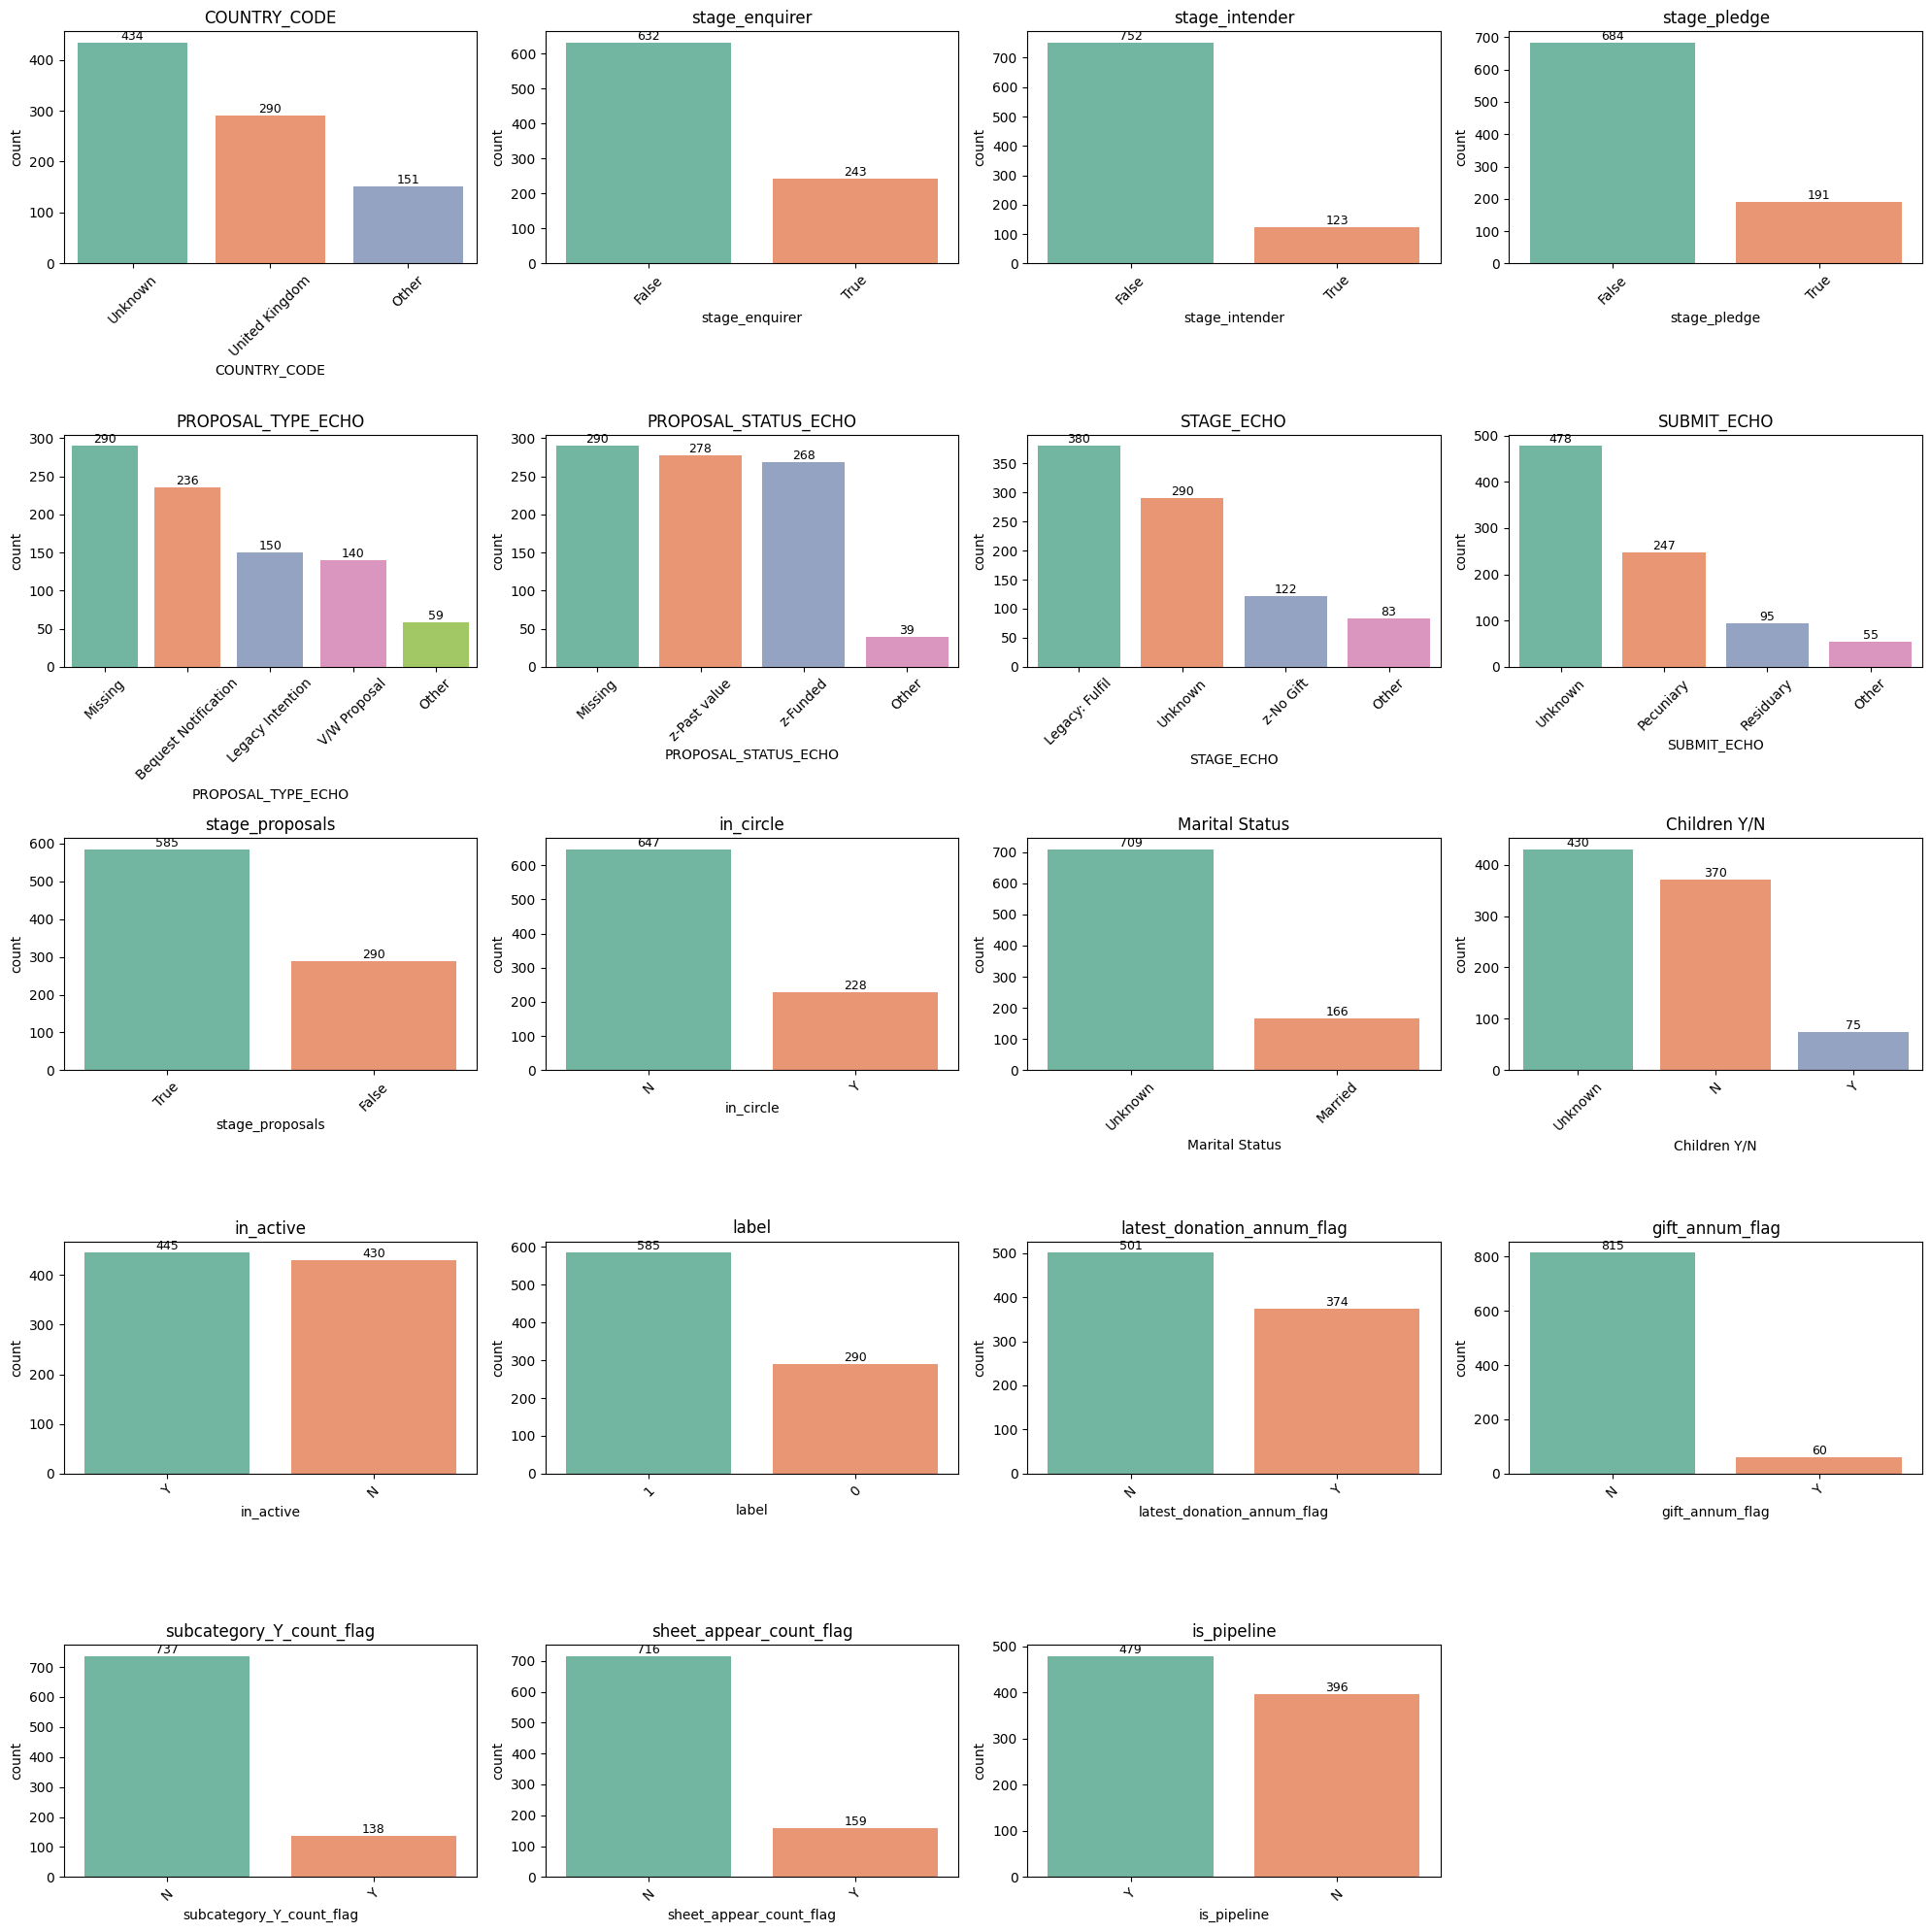

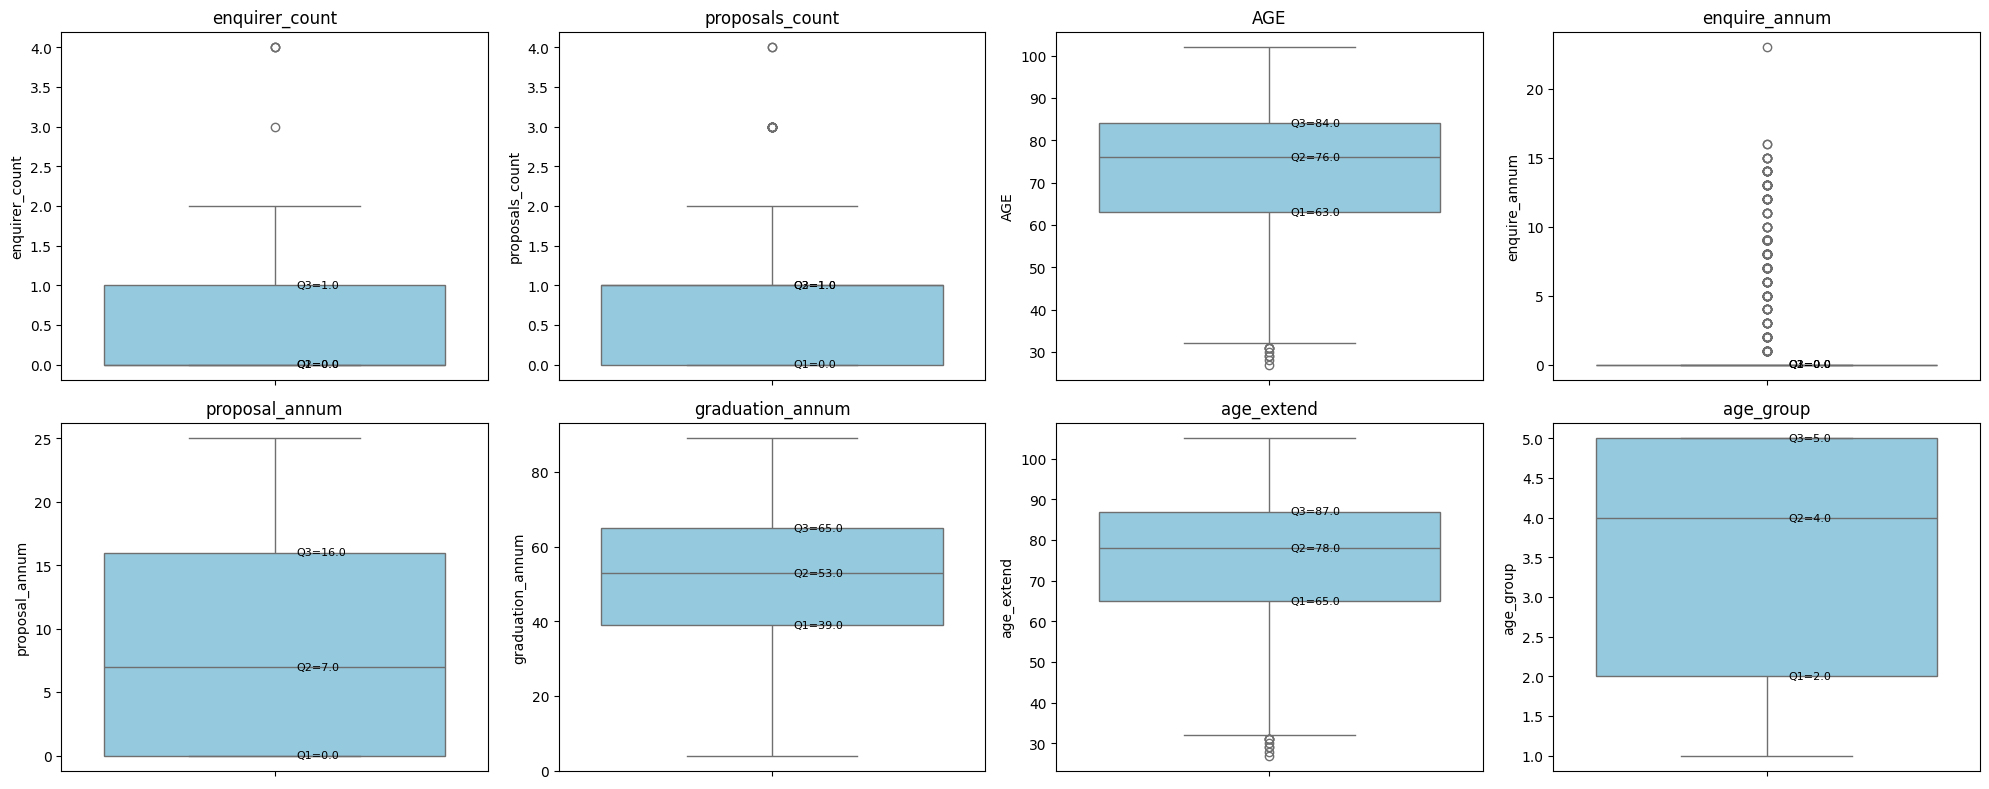

In [74]:
# Do not plot ID_NUMBER, drop it and copy the cleaned data to a new df.
df = merged_pipeline_2.drop(columns=["ID_NUMBER"], errors='ignore')

# detect categorical and numerical features based on the data types.
categorical_cols = df.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# categorical feature plot
def plot_categorical_distributions(df, cols, n_cols=4):
    n_rows = -(-len(cols) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        order = df[col].value_counts().index
        sns.countplot(x=col, data=df, ax=ax, order=order, palette="Set2")

        # add data labels
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9)

        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# boxplot of numerical features
def plot_numerical_boxplots(df, cols, n_cols=4):
    n_rows = -(-len(cols) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.boxplot(y=col, data=df, ax=axes[i], color='skyblue')
        axes[i].set_title(col)

        # quantiles
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.5)
        q3 = df[col].quantile(0.75)

        # add data labels of quantiles
        axes[i].annotate(f'Q1={q1:.1f}', xy=(0, q1), xytext=(0.05, q1), textcoords='data',
                         ha='left', va='center', fontsize=8, color='black')
        axes[i].annotate(f'Q2={q2:.1f}', xy=(0, q2), xytext=(0.05, q2), textcoords='data',
                         ha='left', va='center', fontsize=8, color='black')
        axes[i].annotate(f'Q3={q3:.1f}', xy=(0, q3), xytext=(0.05, q3), textcoords='data',
                         ha='left', va='center', fontsize=8, color='black')

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_categorical_distributions(df, categorical_cols)
plot_numerical_boxplots(df, numerical_cols)


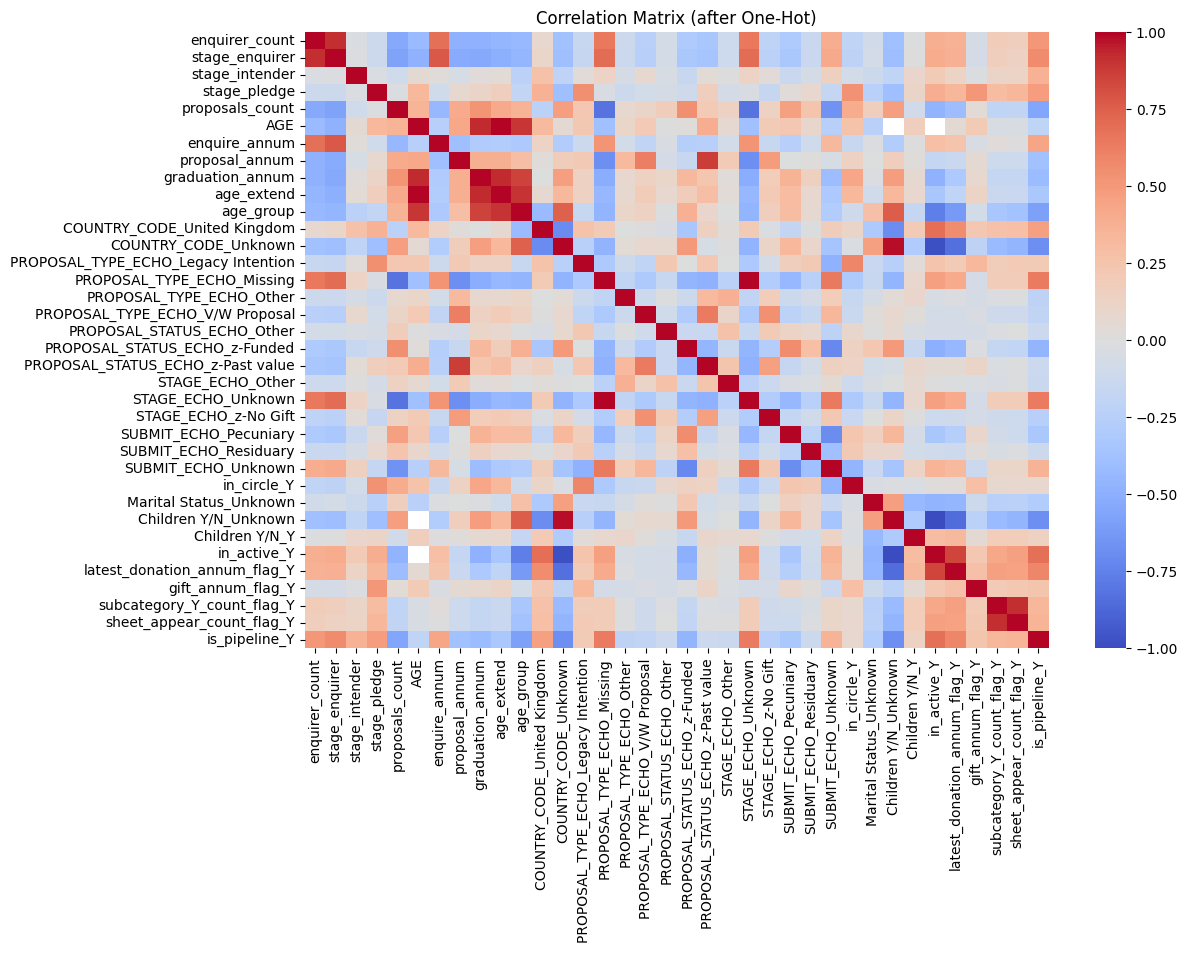

In [75]:
df_corr = merged_pipeline_2.copy()

# columns to drop in feature corr analysis.
exclude_cols = ["ID_NUMBER", "STOP_DATE", "label"
              #  , "stage_enquirer", "stage_intender", "stage_pledge"
               , "stage_proposals"]
df_corr = df_corr.drop(columns=exclude_cols, errors="ignore")

# bool -> 0/1
bool_cols = df_corr.select_dtypes(include="bool").columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

# OHE
df_corr_encoded = pd.get_dummies(df_corr, drop_first=True)

#corr matrix
corr_matrix = df_corr_encoded.corr()

# plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (after One-Hot)")
plt.show()

## 1.3 The 2nd Dataset for Analysis: active_alumni_merge

In [76]:
# label pipeline
active_alumni = anonymised.copy()
active_alumni['label'] = active_alumni['Advance ID'].isin(merged_pipeline_2['ID_NUMBER']).astype(int)

# check label distribution
active_alumni['label'].value_counts()

label
0    191712
1       445
Name: count, dtype: int64

In [77]:
active_alumni_merge = active_alumni.merge(id_subcategory_Y_count_df, how='left',
                    left_on='Advance ID', right_on='ID_NUMBER')
active_alumni_merge = active_alumni_merge.merge(id_sheet_count_df, how='left',
                    left_on='Advance ID', right_on='ID_NUMBER')
active_alumni_merge.drop(columns=['ID_NUMBER_x', 'ID_NUMBER_y'], inplace=True)

In [78]:
'''
1.TIME transition
'''
# TARGET_YEAR = 2025

# original columns to be dropped
cols_to_drop_after = ["Grad_year", "Latest Donation FY"]

# DEGREE_YEARS -> graduation_annum
if "Grad_year" in active_alumni_merge.columns:
    active_alumni_merge["Grad_year"] = pd.to_numeric(active_alumni_merge["Grad_year"], errors="coerce")
    active_alumni_merge["graduation_annum"] = (TARGET_YEAR - active_alumni_merge["Grad_year"]).astype("Int64")

# Latest Donation FY -> latest_donation_annum
if "Latest Donation FY" in active_alumni_merge.columns:
    active_alumni_merge["Latest Donation FY"] = pd.to_numeric(active_alumni_merge["Latest Donation FY"], errors="coerce")
    active_alumni_merge["latest_donation_annum"] = (TARGET_YEAR - active_alumni_merge["Latest Donation FY"]).astype("Int64")

In [79]:
# check the new columns calculated from datetime / year fields.
active_alumni_merge.filter(items=["Grad_year", "graduation_annum",
                                "Latest Donation FY", "latest_donation_annum"
                                 ]).head(20)

Grad_year  graduation_annum  Latest Donation FY  latest_donation_annum
0      1995.0                30              2023.0                      2
1      2011.0                14              2013.0                     12
2      2012.0                13                 NaN                   <NA>
3      2013.0                12              2023.0                      2
4      2014.0                11                 NaN                   <NA>
5      2015.0                10              2019.0                      6
6      2019.0                 6              2020.0                      5
7      2001.0                24                 NaN                   <NA>
8      1979.0                46              2023.0                      2
9      2005.0                20                 NaN                   <NA>
10     2010.0                15                 NaN                   <NA>
11     2012.0                13              2020.0                      5
12     2012.0                13              2022.0                      3
13     2013.0                12                 NaN                   <NA>
14     2019.0                 6                 NaN                   <NA>
15     2010.0                15              2022.0                      3
16     1993.0                32                 NaN                   <NA>
17     1994.0                31              2001.0                     24
18     1994.0                31                 NaN                   <NA>
19     1995.0                30                 NaN                   <NA>

In [80]:
# delete original columns
active_alumni_merge.drop(columns=[c for c in cols_to_drop_after if c in active_alumni_merge.columns], inplace=True)

In [81]:
# check if they were dropped successgfully.
active_alumni_merge.columns.to_list()

['Advance ID',
 'Marital Status',
 'AGE',
 'Children Y/N',
 'Alumni Relationship Manager',
 'COUNTRY',
 'CITY',
 'STATE',
 'DIS_DEGREES',
 'Department',
 'Degree',
 'label',
 'subcategory_Y_count',
 'sheet_appear_count',
 'graduation_annum',
 'latest_donation_annum']

In [82]:
'''
2.AGE transition
'''
def compute_age_simple(row):
    if pd.notna(row["AGE"]) and row["AGE"] > 0:
        return row["AGE"]
    elif pd.notna(row["graduation_annum"]):
        return 21 + row["graduation_annum"]
    else:
        return pd.NA

active_alumni_merge["age_extend"] = active_alumni_merge.apply(compute_age_simple, axis=1)

In [83]:
# check the output
active_alumni_merge[["AGE", "graduation_annum", "age_extend"]].head(20)

AGE  graduation_annum age_extend
0   56.0                30       56.0
1   36.0                14       36.0
2   39.0                13       39.0
3   41.0                12       41.0
4   34.0                11       34.0
5   40.0                10       40.0
6   28.0                 6       28.0
7   52.0                24       52.0
8   69.0                46       69.0
9   45.0                20       45.0
10  34.0                15       34.0
11  35.0                13       35.0
12  36.0                13       36.0
13  37.0                12       37.0
14  31.0                 6       31.0
15  44.0                15       44.0
16  61.0                32       61.0
17  53.0                31       53.0
18  55.0                31       55.0
19  56.0                30       56.0

In [84]:
'''
sanity check
'''
# 1.Print fields and datatype of each df.
print_column_types(active_alumni_merge, "active_alumni_merge")


====== active_alumni_merge ======
                     column   dtype
                 Advance ID  object
             Marital Status  object
                        AGE float64
               Children Y/N  object
Alumni Relationship Manager  object
                    COUNTRY  object
                       CITY  object
                      STATE  object
                DIS_DEGREES  object
                 Department  object
                     Degree  object
                      label   int64
        subcategory_Y_count float64
         sheet_appear_count float64
           graduation_annum   Int64
      latest_donation_annum   Int64
                 age_extend  object


In [85]:
# change the following variables types into Int64
cols_to_int = ["AGE", "age_extend","subcategory_Y_count","sheet_appear_count"]
active_alumni_merge[cols_to_int] = active_alumni_merge[cols_to_int].astype("Int64")

# check output
active_alumni_merge[cols_to_int].dtypes

AGE                    Int64
age_extend             Int64
subcategory_Y_count    Int64
sheet_appear_count     Int64
dtype: object

In [86]:
# in case the label field is not string, try this again.
active_alumni_merge["label"] = active_alumni_merge["label"].astype(str)

In [87]:
'''
sanity check
'''
# 2.distribution stats
df_check_pipeline = active_alumni_merge.drop(columns=["Advance ID"], errors="ignore")
summarize_dataframe_manual(df_check_pipeline, "merged_pipeline")


 ===== Summary for merged_pipeline =====

 Object Fields Value Counts (including NaN & blank):

>> Marital Status
Marital Status
<<NaN>>    177760
Married     13877
Partner       519
Widowed         1
Name: count, dtype: int64
Blank count: 0, NaN count: 177760

>> Children Y/N
Children Y/N
N    186840
Y      5317
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> Alumni Relationship Manager
Alumni Relationship Manager
<<NaN>>    192021
Yes           136
Name: count, dtype: int64
Blank count: 0, NaN count: 192021

>> COUNTRY
COUNTRY
United Kingdom                68182
USA                           23766
People's Republic of China    12927
<<NaN>>                       12560
Germany                        5599
                              ...  
Burma/Myanmar                    48
Zambia                           46
Costa Rica                       46
Estonia                          46
Bolivia                          45
Name: count, Length: 100, dtype: int64
Blank count: 0, Na

In [88]:
'''
missing or blank value processing
'''
# for the following columns in the list
# replace blanks with NaN then filled by 0
fill_zero_cols = [
    "sheet_appear_count",
    "subcategory_Y_count",
    "latest_donation_annum"
]

for col in fill_zero_cols:
    if col in active_alumni_merge.columns:
        active_alumni_merge[col] = active_alumni_merge[col].replace("", pd.NA).fillna(0).astype("int64")

In [89]:
# check if there is any missing or blank values left in those columns
for col in fill_zero_cols:
    if col in active_alumni_merge.columns:
        missing_after = active_alumni_merge[col].isna().sum() + (active_alumni_merge[col] == "").sum()
        print(f"  {col}: {missing_after} missing/blank")

  sheet_appear_count: 0 missing/blank
  subcategory_Y_count: 0 missing/blank
  latest_donation_annum: 0 missing/blank


In [90]:
# Fill NaN with "Unknown"
active_alumni_merge["Marital Status"] = active_alumni_merge["Marital Status"].fillna("Unknown")

# Merge "Partner" and "Widowed" into "Married"
active_alumni_merge["Marital Status"] = active_alumni_merge["Marital Status"].replace({
    "Partner": "Married",
    "Widowed": "Married"
})

# Check distribution
print(active_alumni_merge["Marital Status"].value_counts(dropna=False))

Marital Status
Unknown    177760
Married     14397
Name: count, dtype: int64


In [91]:
# latest_donation_annum, subcategory_Y_count， sheet_appear_count
# for these four columns, as the majority is 0, non-zero values are sparsely distributed
# therefore they are transformed into Y/N based on their values
# this approach is for ease of modeling later, or for each non-zero group, the sample size can be single or few
# This will cause overfitting problem in tree models.

cols_to_flag = ["latest_donation_annum", "subcategory_Y_count", "sheet_appear_count"]

for col in cols_to_flag:
    # new columns named by col+"_flag"，>0 → "Y", otherwise "N"
    active_alumni_merge[col + "_flag"] = np.where(active_alumni_merge[col] > 0, "Y", "N")

# delect original columns
active_alumni_merge = active_alumni_merge.drop(columns=cols_to_flag)


In [92]:
# print the distribution of the new columns
for col in active_alumni_merge.filter(regex="_flag$").columns:
    print(f"\n {col} distribution：")
    print(active_alumni_merge[col].value_counts(dropna=False))


 latest_donation_annum_flag distribution：
latest_donation_annum_flag
N    176573
Y     15584
Name: count, dtype: int64

 subcategory_Y_count_flag distribution：
subcategory_Y_count_flag
N    186606
Y      5551
Name: count, dtype: int64

 sheet_appear_count_flag distribution：
sheet_appear_count_flag
N    179607
Y     12550
Name: count, dtype: int64


In [93]:
# Children Y/N
# fill NaN in Children Y/N by Unknown
active_alumni_merge["Children Y/N"] = active_alumni_merge["Children Y/N"].fillna("Unknown")

# check distribution
print("Children Y/N distribution：")
print(active_alumni_merge["Children Y/N"].value_counts(dropna=False))

Children Y/N distribution：
Children Y/N
N    186840
Y      5317
Name: count, dtype: int64


In [94]:
# COUNTRY
active_alumni_merge["COUNTRY"] = active_alumni_merge["COUNTRY"].fillna("").replace("", "Unknown")

# retain only 2 countries, others labelled by Other
valid_countries = ["United Kingdom", "USA", "People's Republic of China", "Unknown"]
active_alumni_merge["COUNTRY"] = active_alumni_merge["COUNTRY"].apply(
    lambda x: x if x in valid_countries else "Other"
)

# check distribution
print(active_alumni_merge["COUNTRY"].value_counts(dropna=False))

COUNTRY
Other                         74722
United Kingdom                68182
USA                           23766
People's Republic of China    12927
Unknown                       12560
Name: count, dtype: int64


In [95]:
# Degree
# firstly group into Undergrad, Postgrad.
import re

def group_degree(degree):
    if pd.isna(degree) or degree == "Unknown":
        return "Unknown"

    degree_lower = degree.lower()

    if re.search(r'\b(bsc|ba|llb|bba|beng|bcom|general course)\b', degree_lower):
        return "Undergraduate"
    elif re.search(r'\b(msc|ma|llm|mba|mpa|mphil)\b', degree_lower):
        return "Postgraduate"
    elif re.search(r'\b(phd|dphil|doctorate)\b', degree_lower):
        return "Doctorate"
    elif re.search(r'\b(diploma|certificate|exec|pgcert)\b', degree_lower):
        return "Diploma/Cert"
    else:
        return "Other"

# apply function
active_alumni_merge["Degree"] = active_alumni_merge["Degree"].apply(group_degree)

# check distribution
print(active_alumni_merge["Degree"].value_counts(dropna=False))


Degree
Postgraduate     113248
Undergraduate     50772
Other             15482
Unknown            9374
Diploma/Cert       2169
Doctorate          1112
Name: count, dtype: int64


In [96]:
# create a list to drop some fields mannually
cols_to_drop = [
    "Department", "DIS_DEGREES",
    "CITY", "STATE"
]

# drop the columns and create a new df named merged_pipeline_2
# so that we only deal with the left columns in new df.
active_alumni_merge = active_alumni_merge.drop(columns=cols_to_drop, errors='ignore')

In [97]:
# sanity check for features included newly generated ones
df_check = active_alumni_merge.drop(columns=["Advance ID"], errors="ignore")

summarize_dataframe_manual(df_check, "active_alumni_merge")


 ===== Summary for active_alumni_merge =====

 Object Fields Value Counts (including NaN & blank):

>> Marital Status
Marital Status
Unknown    177760
Married     14397
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> Children Y/N
Children Y/N
N    186840
Y      5317
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> Alumni Relationship Manager
Alumni Relationship Manager
<<NaN>>    192021
Yes           136
Name: count, dtype: int64
Blank count: 0, NaN count: 192021

>> COUNTRY
COUNTRY
Other                         74722
United Kingdom                68182
USA                           23766
People's Republic of China    12927
Unknown                       12560
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> Degree
Degree
Postgraduate     113248
Undergraduate     50772
Other             15482
Unknown            9374
Diploma/Cert       2169
Doctorate          1112
Name: count, dtype: int64
Blank count: 0, NaN count: 0

>> label
label
0    191712
1       44

## 1.4 Label Analysis

### 1.4.1 For merged_pipeline

In [98]:
plot_data = merged_pipeline_2.copy()
display(plot_data.head())
plot_data.info()

ID_NUMBER  enquirer_count    COUNTRY_CODE  stage_enquirer  stage_intender  \
0    100032               0  United Kingdom           False           False   
1    100089               0  United Kingdom           False           False   
2    100102               0  United Kingdom           False            True   
3    100169               0         Unknown           False           False   
4    100258               1  United Kingdom            True            True   

   stage_pledge  STOP_DATE    PROPOSAL_TYPE_ECHO PROPOSAL_STATUS_ECHO  \
0          True 2006-09-27      Legacy Intention         z-Past value   
1          True 2008-02-15      Legacy Intention         z-Past value   
2          True 2007-11-23          V/W Proposal         z-Past value   
3         False 2018-01-01  Bequest Notification             z-Funded   
4         False        NaT      Legacy Intention         z-Past value   

       STAGE_ECHO  ... enquire_annum  proposal_annum  graduation_annum  \
0  Legacy: Fulfil  ...             0              22                71   
1  Legacy: Fulfil  ...             0              18                61   
2  Legacy: Fulfil  ...             0              21                65   
3  Legacy: Fulfil  ...             0               7              <NA>   
4           Other  ...             7               7                41   

  age_extend age_group  latest_donation_annum_flag gift_annum_flag  \
0         92         4                           Y               Y   
1         87         3                           Y               Y   
2         88         4                           Y               N   
3       <NA>         5                           N               N   
4         69         2                           N               N   

  subcategory_Y_count_flag sheet_appear_count_flag  is_pipeline  
0                        N                       N            Y  
1                        Y                       Y            Y  
2                        Y                       Y            Y  
3                        N                       N            N  
4                        N                       N            Y  

[5 rows x 29 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ID_NUMBER                   875 non-null    object        
 1   enquirer_count              875 non-null    int64         
 2   COUNTRY_CODE                875 non-null    object        
 3   stage_enquirer              875 non-null    bool          
 4   stage_intender              875 non-null    bool          
 5   stage_pledge                875 non-null    bool          
 6   STOP_DATE                   561 non-null    datetime64[ns]
 7   PROPOSAL_TYPE_ECHO          875 non-null    object        
 8   PROPOSAL_STATUS_ECHO        875 non-null    object        
 9   STAGE_ECHO                  875 non-null    object        
 10  SUBMIT_ECHO                 875 non-null    object        
 11  proposals_count             875 non-null    int64         

In [99]:
plot_data['label'].value_counts()

label
1    585
0    290
Name: count, dtype: int64

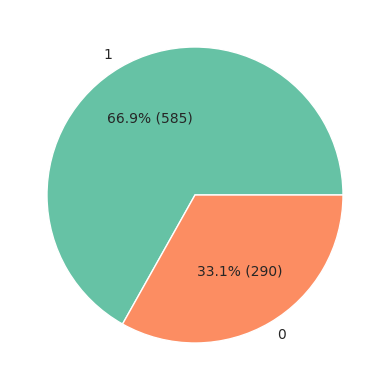

In [100]:
# pie chart of label
label_counts = plot_data['label'].value_counts()
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}% ({round(p*sum(label_counts)/100)})',
    colors=sns.color_palette("Set2"),
    textprops={'fontsize': 10}
)
plt.tight_layout()
plt.show()

In [101]:
# create a new column legacy_BN: BN if legacy left already, Not BN if commitment, No_donate if Missing
def classify_proposal(row):
    if row['PROPOSAL_TYPE_ECHO'] == "Bequest Notification":
        return 'BN'
    elif row['PROPOSAL_TYPE_ECHO'] == "Missing":
        return 'No_donate'
    else:
        return 'Not_BN'

plot_data['legacy_BN'] = plot_data.apply(classify_proposal, axis=1)
plot_data['legacy_BN'].value_counts()

legacy_BN
Not_BN       349
No_donate    290
BN           236
Name: count, dtype: int64

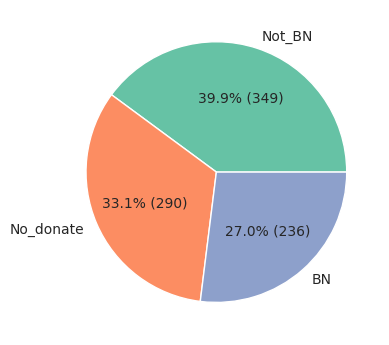

In [102]:
# pie chart of legacy_BN
label_counts = plot_data['legacy_BN'].value_counts()
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}% ({round(p*sum(label_counts)/100)})',
    colors=sns.color_palette("Set2"),
    textprops={'fontsize': 10}
)
plt.tight_layout()
plt.show()

In [103]:
# create a new column pipeline_donate: Both if one joined pipeline and donate/commitment, No_donate if one joined pipeline but no donation,
# No_pipeline if one donate/commit but did not join pipeline
def classify_donation(row):
    if row['is_pipeline'] == "Y" and row['stage_proposals'] == True:
        return 'Both'
    elif row['is_pipeline'] == "Y" and row['stage_proposals'] == False:
        return 'No_donate'
    elif row['is_pipeline'] == "N" and row['stage_proposals'] == True:
        return 'No_pipeline'

plot_data['pipeline_donate'] = plot_data.apply(classify_donation, axis=1)
plot_data['pipeline_donate'].value_counts()

pipeline_donate
No_pipeline    396
No_donate      290
Both           189
Name: count, dtype: int64

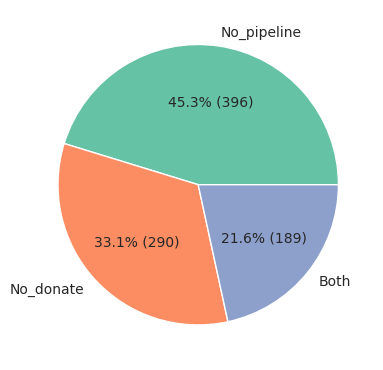

In [104]:
# pie chart of pipeline_donate
label_counts = plot_data['pipeline_donate'].value_counts()
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}% ({round(p*sum(label_counts)/100)})',
    colors=sns.color_palette("Set2"),
    textprops={'fontsize': 10}
)
plt.tight_layout()
plt.show()

In [105]:
# draw boxplots with labelled statistics
def draw_boxes(box_x, box_y, size_x, size_y, data):
    plt.figure(figsize=(size_x, size_y))
    ax = sns.boxplot(x=box_x, y=box_y, data=data, palette='Set2', hue=box_x, legend=False)

    for i, label in enumerate(data[box_x].unique()):
        lines = ax.lines[6*i : 6*(i+1)]

        # extract q1 median and q3
        q1 = lines[0].get_ydata()[0]
        median = lines[4].get_ydata()[0]
        q3 = lines[1].get_ydata()[0]

        # calculate min and max
        group_data = data[data[box_x] == label][box_y]
        real_min = group_data.min()
        real_max = group_data.max()

        # label statistics
        ## min
        ax.text(x=i, y=real_min-1, s=f'Min: {real_min:.1f}', ha='center', va='top', color='purple', fontsize=10)
        ## max
        ax.text(x=i, y=real_max, s=f'Max: {real_max:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
        ## Q3
        ax.text(x=i, y=q3, s=f'Q3: {q3:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
        # median
        ax.text(x=i, y=median+1, s=f'Median: {median:.1f}', ha='center', va='center', color='purple', fontsize=10)
        # Q1
        ax.text(x=i, y=q1-0.5, s=f'Q1: {q1:.1f}', ha='center', va='top', color='purple', fontsize=10)

    plt.tight_layout()
    plt.show()

In [106]:
# draw bar plots with labelled statistics
def draw_bars(dist, bar_x, bar_y, size_x, size_y):
    row_totals = dist.sum(axis=1)

    colors = sns.color_palette("Set2", len(dist.columns))
    ax = dist.plot(kind='bar', stacked=True, figsize=(size_x, size_y), color=colors)

    for i, (idx, row) in enumerate(dist.iterrows()):
        cumulative = 0
        for col in dist.columns:
            value = row[col]
            if value > 0:
                center = cumulative + value / 2
                percentage = (value / row_totals[idx]) * 100
                ax.text(i, center, f'{percentage:.1f}%', ha='center', va='center',fontsize=10, color='black')
            cumulative += value

    plt.ylabel('Count', fontsize=10)
    plt.xlabel(bar_x, fontsize=10)
    plt.legend(title=bar_y, bbox_to_anchor=(1, 1), loc='upper left')
    plt.xticks(rotation=0, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

`age_extend`

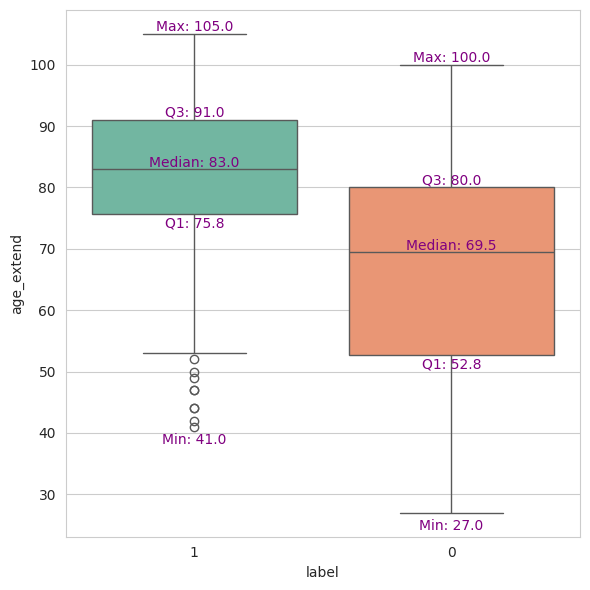

In [107]:
# Box Plot on label and age_extend
draw_boxes('label', 'age_extend', 6, 6, plot_data)

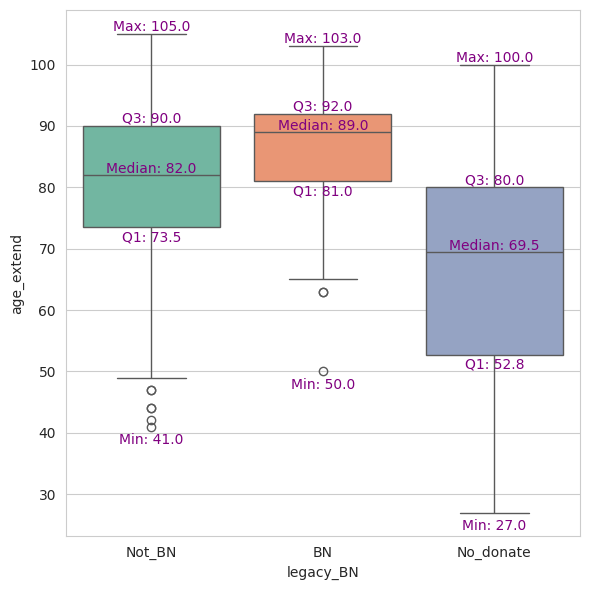

In [108]:
# Box Plot on legacy_BN and age_extend
draw_boxes('legacy_BN', 'age_extend', 6, 6, plot_data)

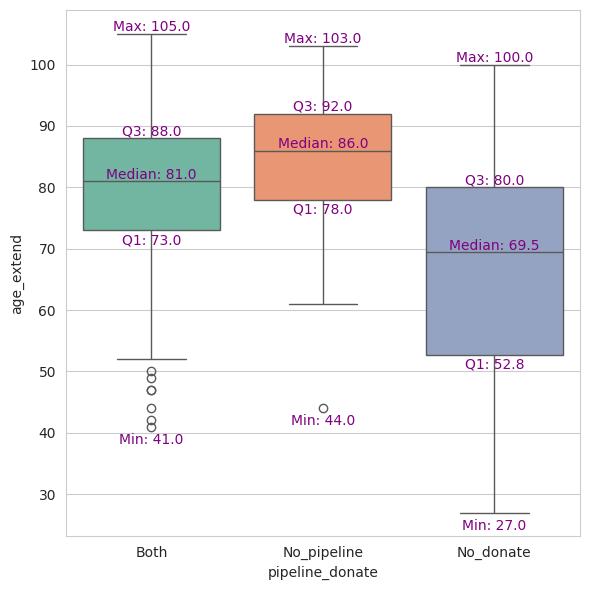

In [109]:
# Box Plot on pipeline_donate and age_extend
draw_boxes('pipeline_donate', 'age_extend', 6, 6, plot_data)

`COUNTRY_CODE`

In [110]:
plot_data['COUNTRY_CODE'].value_counts()

COUNTRY_CODE
Unknown           434
United Kingdom    290
Other             151
Name: count, dtype: int64

COUNTRY_CODE  Other  United Kingdom  Unknown
label                                       
0               109             134       47
1                42             156      387


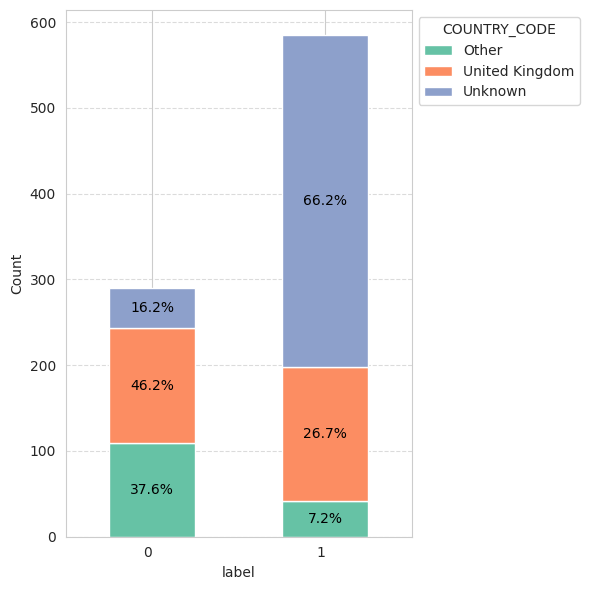

In [111]:
# Country Distribution by label
dist = pd.crosstab(plot_data['label'], plot_data['COUNTRY_CODE'])
print(dist)
draw_bars(dist, 'label', 'COUNTRY_CODE', 6, 6)

COUNTRY_CODE  Other  United Kingdom  Unknown
legacy_BN                                   
BN                0               0      236
No_donate       109             134       47
Not_BN           42             156      151


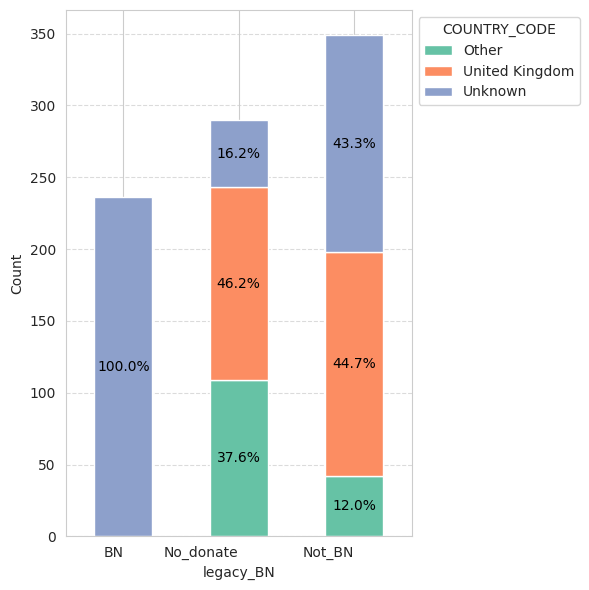

In [112]:
# Country Distribution by legacy_BN
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['COUNTRY_CODE'])
print(dist)
draw_bars(dist, 'legacy_BN', 'COUNTRY_CODE', 6, 6)

COUNTRY_CODE     Other  United Kingdom  Unknown
pipeline_donate                                
Both                27             120       42
No_donate          109             134       47
No_pipeline         15              36      345


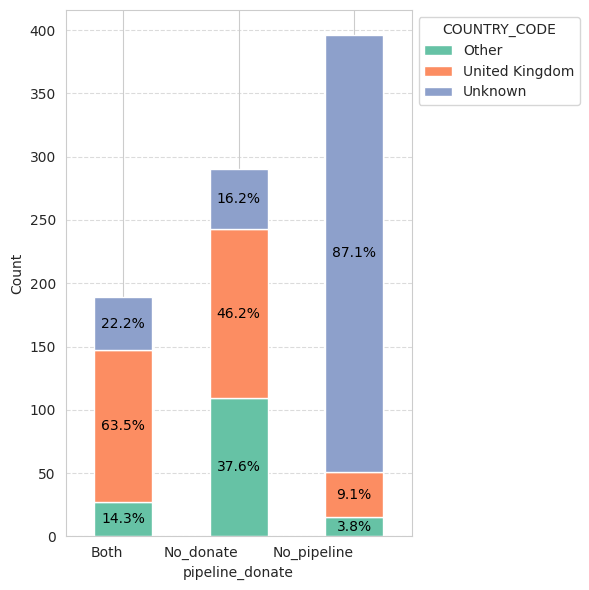

In [113]:
# Country Distribution by pipeline_donate
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['COUNTRY_CODE'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'COUNTRY_CODE', 6, 6)

`Marital Status`

Marital Status  Married  Unknown
label                           
0                    79      211
1                    87      498


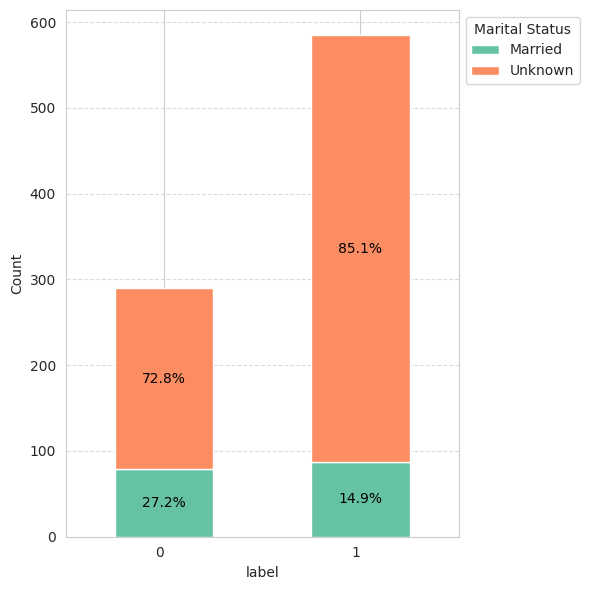

In [114]:
dist = pd.crosstab(plot_data['label'], plot_data['Marital Status'])
print(dist)
draw_bars(dist, 'label', 'Marital Status', 6, 6)

Marital Status  Married  Unknown
legacy_BN                       
BN                    0      236
No_donate            79      211
Not_BN               87      262


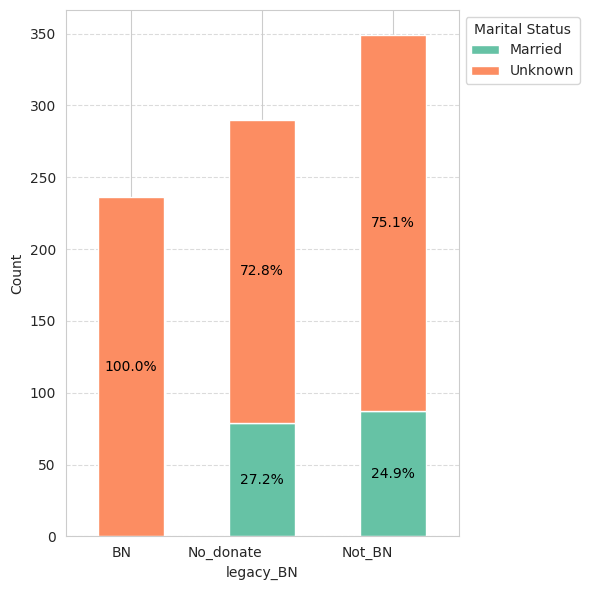

In [115]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['Marital Status'])
print(dist)
draw_bars(dist, 'legacy_BN', 'Marital Status', 6, 6)

Marital Status   Married  Unknown
pipeline_donate                  
Both                  60      129
No_donate             79      211
No_pipeline           27      369


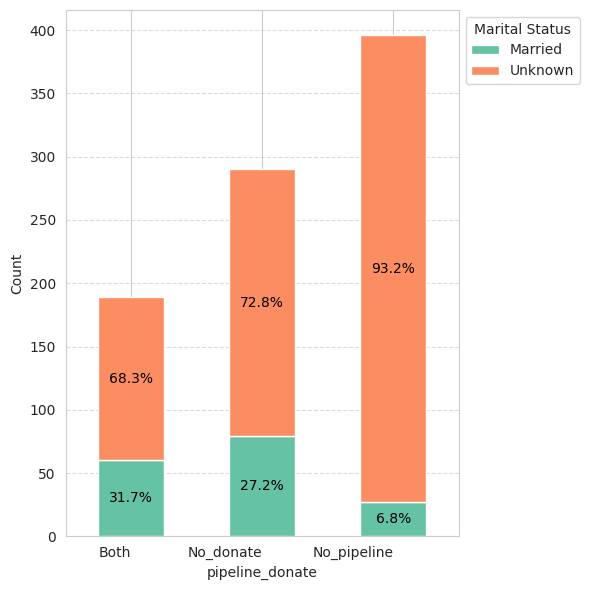

In [116]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['Marital Status'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'Marital Status', 6, 6)

`Children Y/N`

In [117]:
plot_data['Children Y/N'].value_counts()

Children Y/N
Unknown    430
N          370
Y           75
Name: count, dtype: int64

Children Y/N    N  Unknown   Y
label                         
0             209       47  34
1             161      383  41


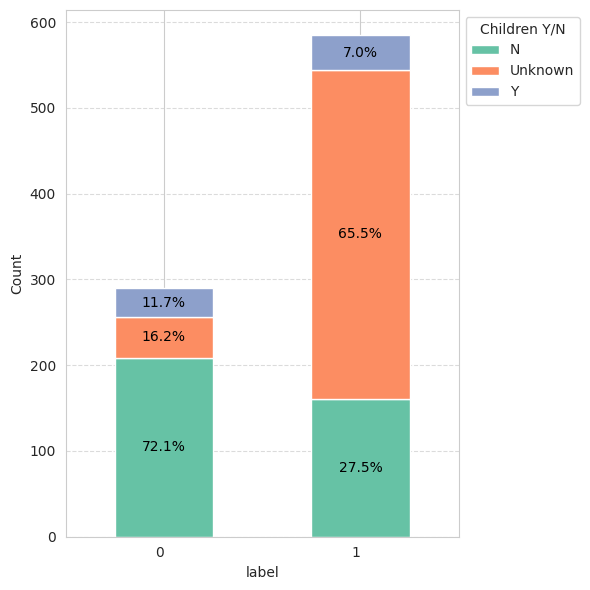

In [118]:
dist = pd.crosstab(plot_data['label'], plot_data['Children Y/N'])
print(dist)
draw_bars(dist, 'label', 'Children Y/N', 6, 6)

Children Y/N    N  Unknown   Y
legacy_BN                     
BN              0      236   0
No_donate     209       47  34
Not_BN        161      147  41


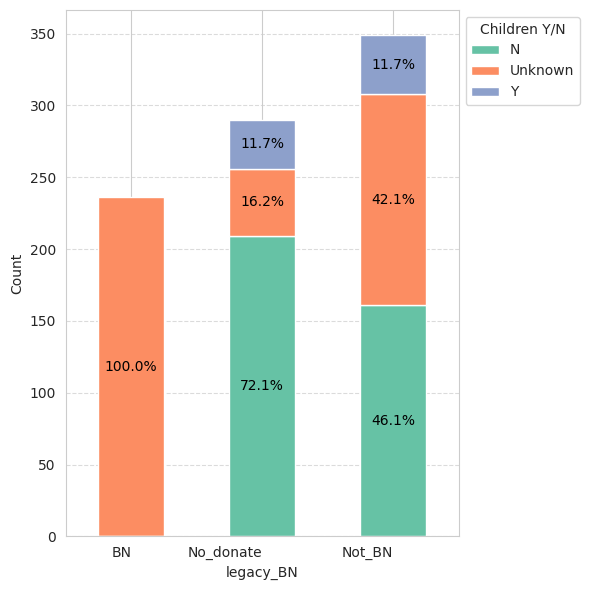

In [119]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['Children Y/N'])
print(dist)
draw_bars(dist, 'legacy_BN', 'Children Y/N', 6, 6)

Children Y/N       N  Unknown   Y
pipeline_donate                  
Both             124       40  25
No_donate        209       47  34
No_pipeline       37      343  16


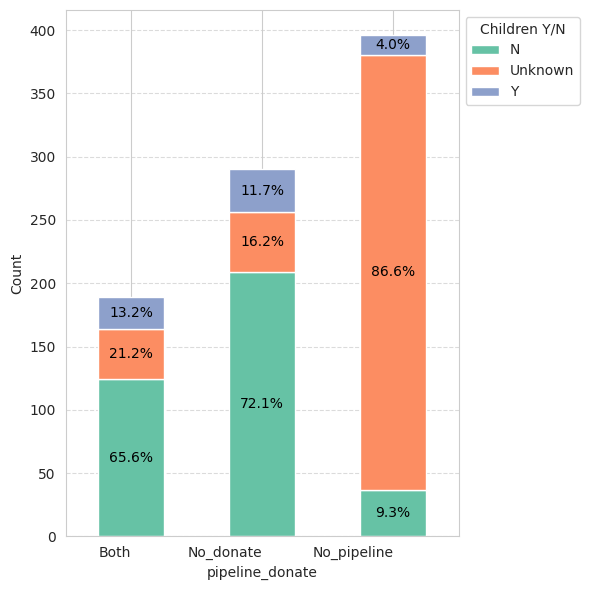

In [120]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['Children Y/N'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'Children Y/N', 6, 6)

`graduation_annum`

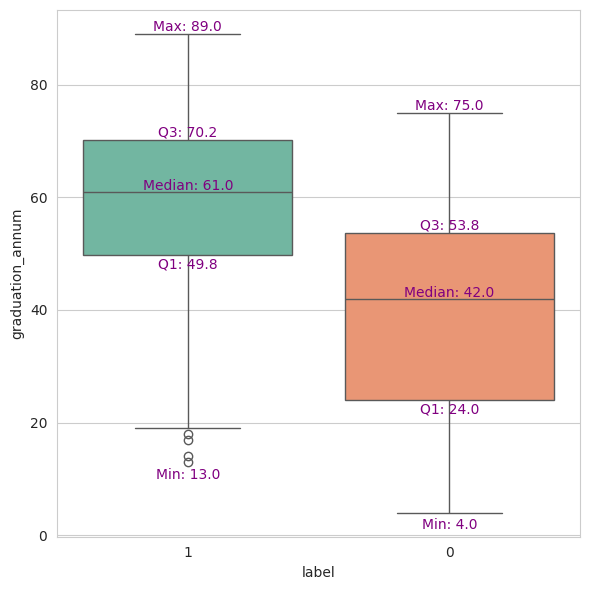

In [121]:
draw_boxes('label', 'graduation_annum', 6, 6, plot_data)

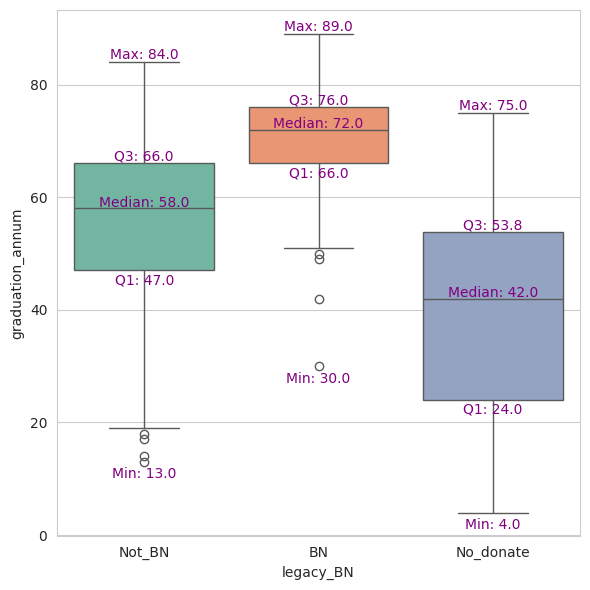

In [122]:
draw_boxes('legacy_BN', 'graduation_annum', 6, 6, plot_data)

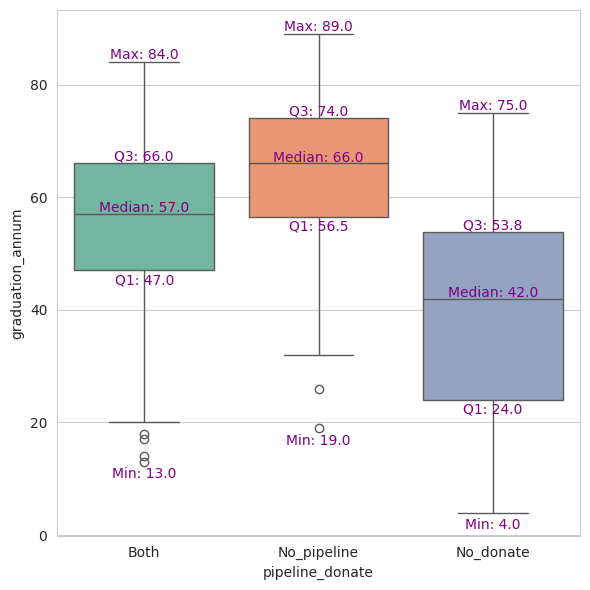

In [123]:
draw_boxes('pipeline_donate', 'graduation_annum', 6, 6, plot_data)

`enquire_annum`

enquire_positive  False  True 
label                         
0                    99    191
1                   559     26


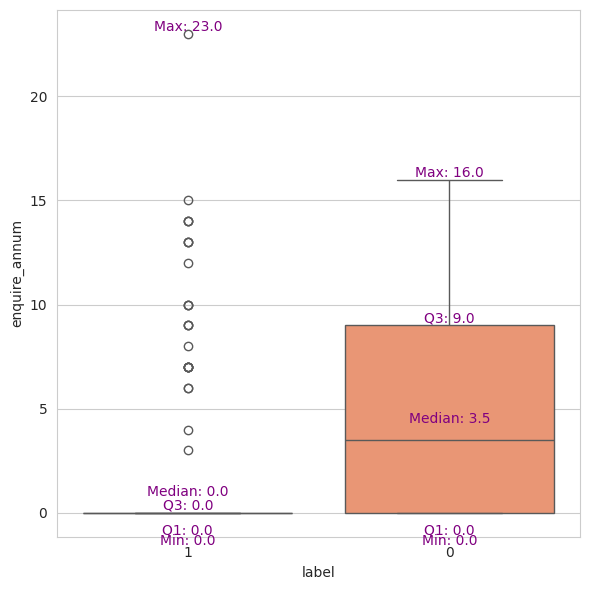

In [124]:
plot_data['enquire_positive'] = plot_data['enquire_annum'] > 0
counts = pd.crosstab(plot_data['label'], plot_data['enquire_positive'])
print(counts)

draw_boxes('label', 'enquire_annum', 6, 6, plot_data)

enquire_positive  False  True 
legacy_BN                     
BN                  229      7
No_donate            99    191
Not_BN              330     19


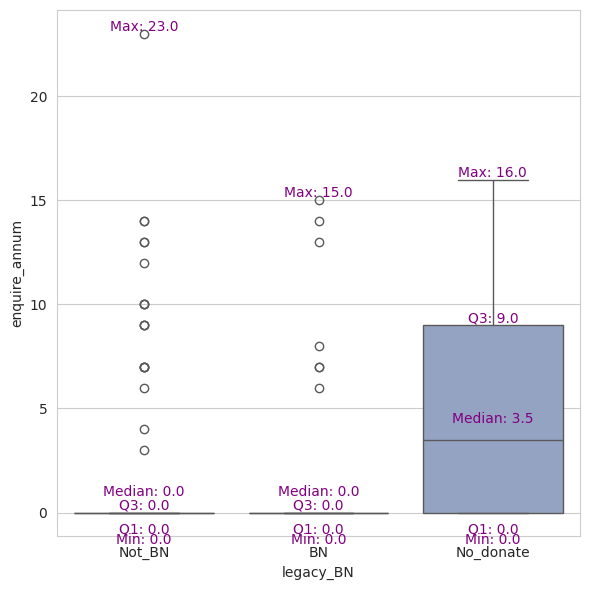

In [125]:
counts = pd.crosstab(plot_data['legacy_BN'], plot_data['enquire_positive'])
print(counts)

draw_boxes('legacy_BN', 'enquire_annum', 6, 6, plot_data)

enquire_positive  False  True 
pipeline_donate               
Both                163     26
No_donate            99    191
No_pipeline         396      0


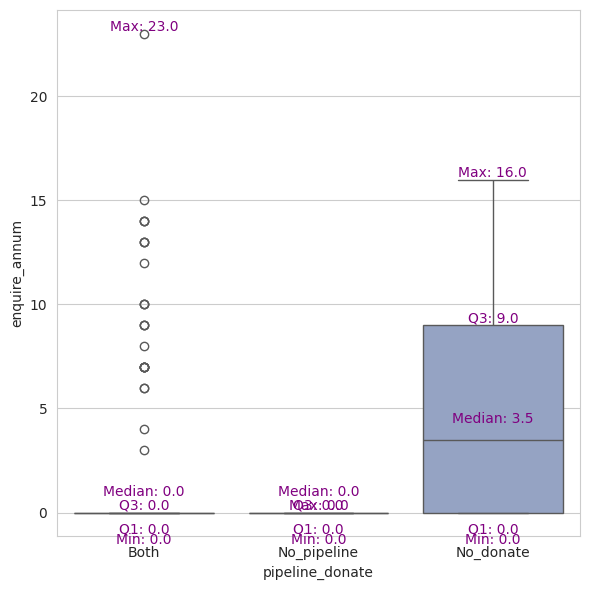

In [126]:
counts = pd.crosstab(plot_data['pipeline_donate'], plot_data['enquire_positive'])
print(counts)

draw_boxes('pipeline_donate', 'enquire_annum', 6, 6, plot_data)

`proposal_annum`

proposal_positive  False  True 
label                          
0                    290      0
1                      2    583


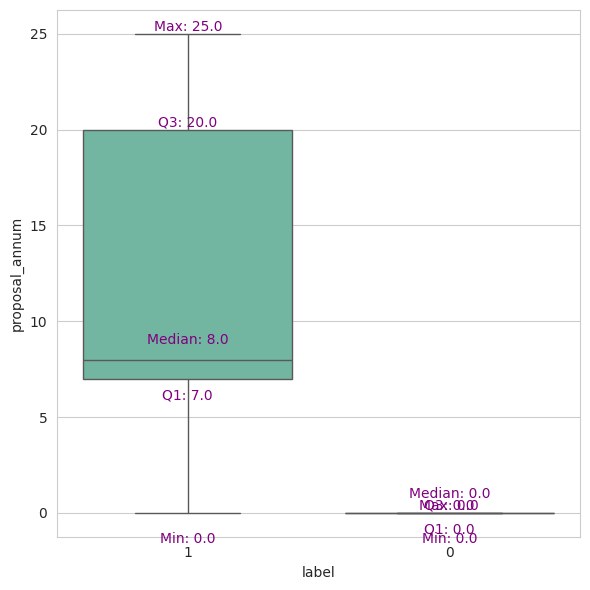

In [127]:
plot_data['proposal_positive'] = plot_data['proposal_annum'] > 0
counts = pd.crosstab(plot_data['label'], plot_data['proposal_positive'])
print(counts)

draw_boxes('label', 'proposal_annum', 6, 6, plot_data)

proposal_positive  False  True 
legacy_BN                      
BN                     1    235
No_donate            290      0
Not_BN                 1    348


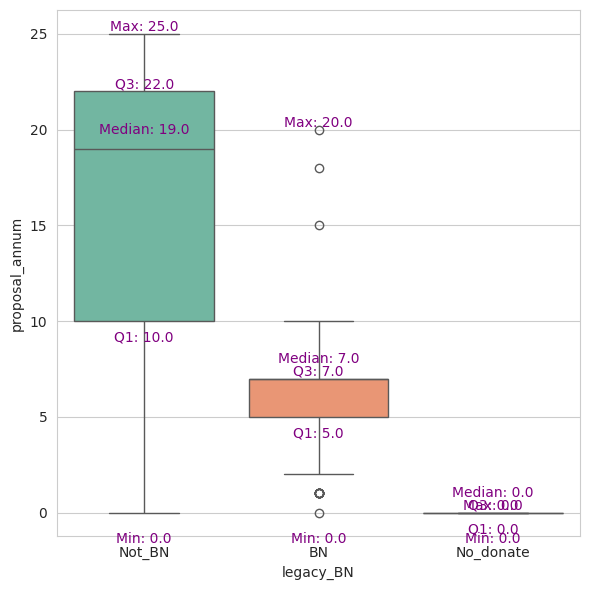

In [128]:
counts = pd.crosstab(plot_data['legacy_BN'], plot_data['proposal_positive'])
print(counts)

draw_boxes('legacy_BN', 'proposal_annum', 6, 6, plot_data)

proposal_positive  False  True 
pipeline_donate                
Both                   0    189
No_donate            290      0
No_pipeline            2    394


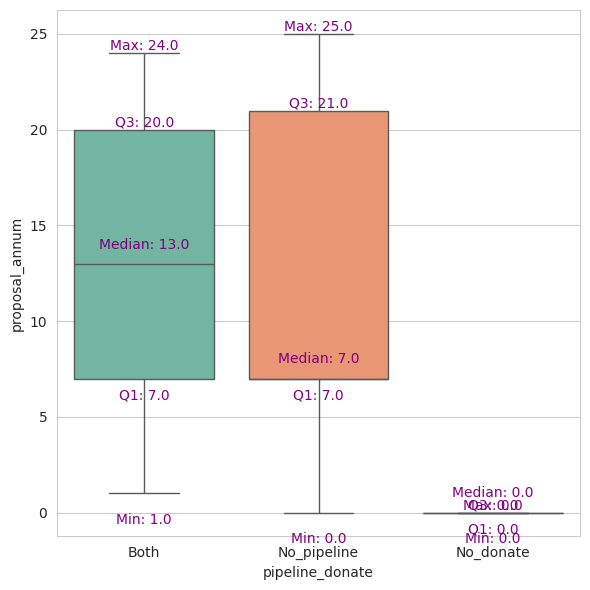

In [129]:
counts = pd.crosstab(plot_data['pipeline_donate'], plot_data['proposal_positive'])
print(counts)

draw_boxes('pipeline_donate', 'proposal_annum', 6, 6, plot_data)

`enquirer_count`

enquire_count_positive  False  True 
label                               
0                         274     16
1                         584      1


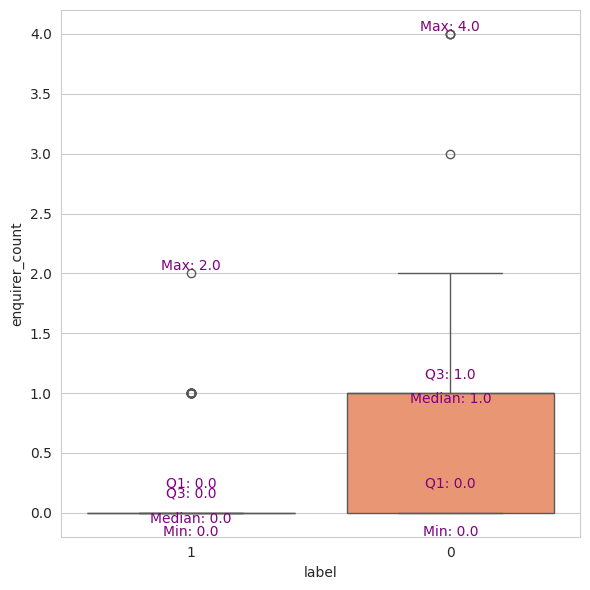

In [130]:
plot_data['enquire_count_positive'] = plot_data['enquirer_count'] > 1
counts = pd.crosstab(plot_data['label'], plot_data['enquire_count_positive'])
print(counts)
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='label', y='enquirer_count', data=plot_data, palette='Set2', hue='label', legend=False)

for i, label in enumerate(plot_data['label'].unique()):
    lines = ax.lines[6*i : 6*(i+1)]

    # extract q1 median and q3
    q1 = lines[0].get_ydata()[0]
    median = lines[4].get_ydata()[0]
    q3 = lines[1].get_ydata()[0]

    # calculate min and max
    group_data = plot_data[plot_data['label'] == label]['enquirer_count']
    real_min = group_data.min()
    real_max = group_data.max()

    # label statistics
    ## min
    ax.text(x=i, y=real_min-0.1, s=f'Min: {real_min:.1f}', ha='center', va='top', color='purple', fontsize=10)
    ## max
    ax.text(x=i, y=real_max, s=f'Max: {real_max:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    ## Q3
    ax.text(x=i, y=q3+0.1, s=f'Q3: {q3:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    # median
    ax.text(x=i, y=median-0.05, s=f'Median: {median:.1f}', ha='center', va='center', color='purple', fontsize=10)
    # Q1
    ax.text(x=i, y=q1+0.3, s=f'Q1: {q1:.1f}', ha='center', va='top', color='purple', fontsize=10)

plt.tight_layout()
plt.show()

enquire_count_positive  False  True 
legacy_BN                           
BN                        236      0
No_donate                 274     16
Not_BN                    348      1


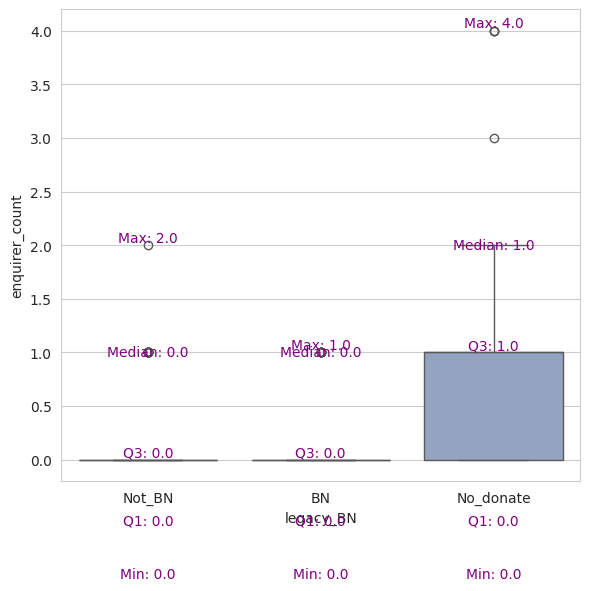

In [131]:
counts = pd.crosstab(plot_data['legacy_BN'], plot_data['enquire_count_positive'])
print(counts)

draw_boxes('legacy_BN', 'enquirer_count', 6, 6, plot_data)

enquire_count_positive  False  True 
pipeline_donate                     
Both                      188      1
No_donate                 274     16
No_pipeline               396      0


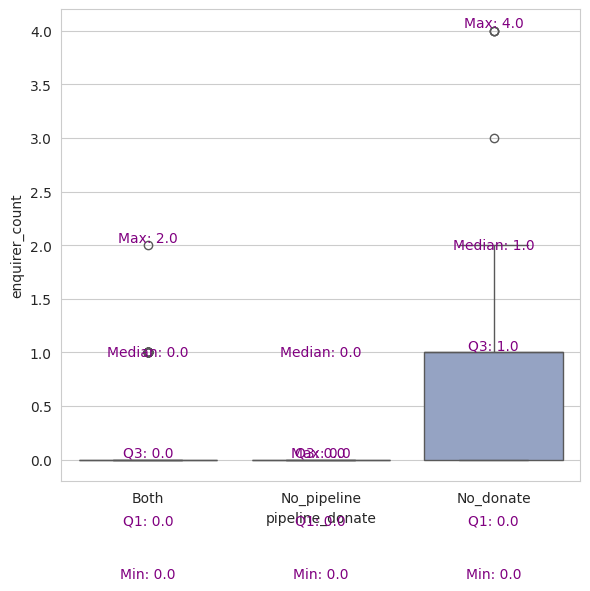

In [132]:
counts = pd.crosstab(plot_data['pipeline_donate'], plot_data['enquire_count_positive'])
print(counts)

draw_boxes('pipeline_donate', 'enquirer_count', 6, 6, plot_data)

`proposals_count`

proposal_count_positive  False  True 
label                                
0                          290      0
1                          449    136


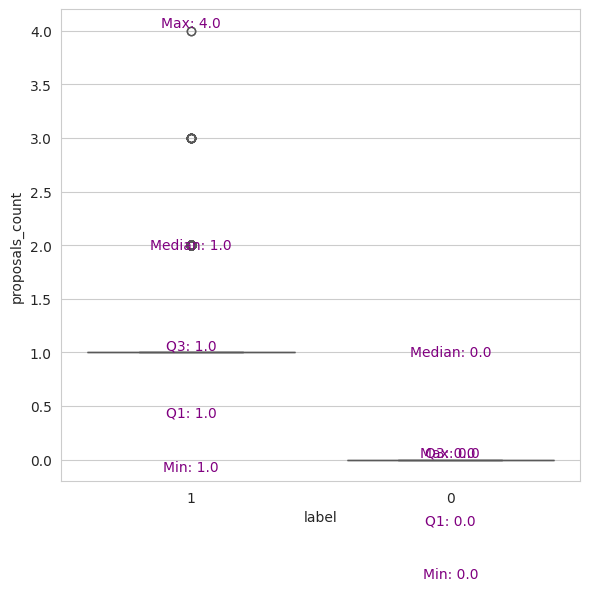

In [133]:
plot_data['proposal_count_positive'] = plot_data['proposals_count'] > 1
counts = pd.crosstab(plot_data['label'], plot_data['proposal_count_positive'])
print(counts)

draw_boxes('label', 'proposals_count', 6, 6, plot_data)

proposal_count_positive  False  True 
legacy_BN                            
BN                         133    103
No_donate                  290      0
Not_BN                     316     33


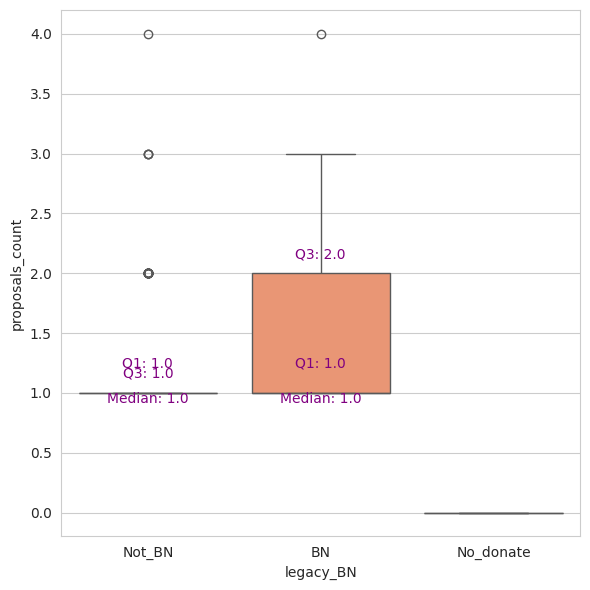

In [134]:
counts = pd.crosstab(plot_data['legacy_BN'], plot_data['proposal_count_positive'])
print(counts)

plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='legacy_BN', y='proposals_count', data=plot_data, palette='Set2', hue='legacy_BN', legend=False)

for i, label in enumerate(plot_data['label'].unique()):
    lines = ax.lines[6*i : 6*(i+1)]

    # extract q1 median and q3
    q1 = lines[0].get_ydata()[0]
    median = lines[4].get_ydata()[0]
    q3 = lines[1].get_ydata()[0]

    # calculate min and max
    group_data = plot_data[plot_data['legacy_BN'] == label]['proposals_count']
    real_min = group_data.min()
    real_max = group_data.max()

    # label statistics
    ## min
    ax.text(x=i, y=real_min-0.1, s=f'Min: {real_min:.1f}', ha='center', va='top', color='purple', fontsize=10)
    ## max
    ax.text(x=i, y=real_max, s=f'Max: {real_max:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    ## Q3
    ax.text(x=i, y=q3+0.1, s=f'Q3: {q3:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    # median
    ax.text(x=i, y=median-0.05, s=f'Median: {median:.1f}', ha='center', va='center', color='purple', fontsize=10)
    # Q1
    ax.text(x=i, y=q1+0.3, s=f'Q1: {q1:.1f}', ha='center', va='top', color='purple', fontsize=10)

plt.tight_layout()
plt.show()

proposal_count_positive  False  True 
pipeline_donate                      
Both                       159     30
No_donate                  290      0
No_pipeline                290    106


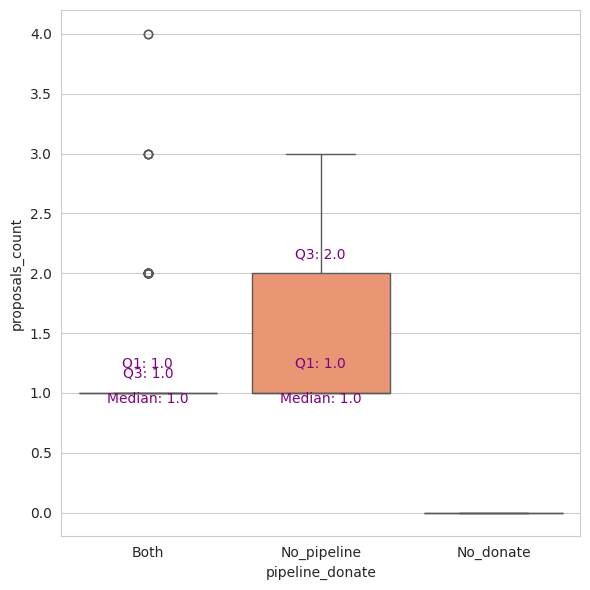

In [135]:
counts = pd.crosstab(plot_data['pipeline_donate'], plot_data['proposal_count_positive'])
print(counts)

plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='pipeline_donate', y='proposals_count', data=plot_data, palette='Set2', hue='pipeline_donate', legend=False)

for i, label in enumerate(plot_data['label'].unique()):
    lines = ax.lines[6*i : 6*(i+1)]

    # extract q1 median and q3
    q1 = lines[0].get_ydata()[0]
    median = lines[4].get_ydata()[0]
    q3 = lines[1].get_ydata()[0]

    # calculate min and max
    group_data = plot_data[plot_data['pipeline_donate'] == label]['proposals_count']
    real_min = group_data.min()
    real_max = group_data.max()

    # label statistics
    ## min
    ax.text(x=i, y=real_min-0.1, s=f'Min: {real_min:.1f}', ha='center', va='top', color='purple', fontsize=10)
    ## max
    ax.text(x=i, y=real_max, s=f'Max: {real_max:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    ## Q3
    ax.text(x=i, y=q3+0.1, s=f'Q3: {q3:.1f}', ha='center', va='bottom', color='purple', fontsize=10)
    # median
    ax.text(x=i, y=median-0.05, s=f'Median: {median:.1f}', ha='center', va='center', color='purple', fontsize=10)
    # Q1
    ax.text(x=i, y=q1+0.3, s=f'Q1: {q1:.1f}', ha='center', va='top', color='purple', fontsize=10)

plt.tight_layout()
plt.show()

`PROPOSAL_TYPE_ECHO`

PROPOSAL_TYPE_ECHO  Bequest Notification  Legacy Intention  Missing  Other  \
is_pipeline                                                                  
N                                    217                35        0     50   
Y                                     19               115      290      9   

PROPOSAL_TYPE_ECHO  V/W Proposal  
is_pipeline                       
N                             94  
Y                             46  


<Figure size 1200x600 with 0 Axes>

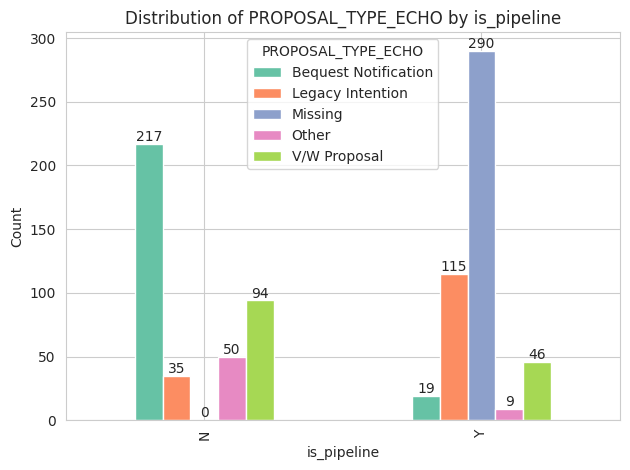

In [136]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['PROPOSAL_TYPE_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=False)

plt.title('Distribution of PROPOSAL_TYPE_ECHO by is_pipeline')
plt.xlabel('is_pipeline')
plt.ylabel('Count')
plt.legend(title='PROPOSAL_TYPE_ECHO')
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

PROPOSAL_TYPE_ECHO  Bequest Notification  Legacy Intention  Missing  Other  \
is_pipeline                                                                  
N                                    217                35        0     50   
Y                                     19               115      290      9   

PROPOSAL_TYPE_ECHO  V/W Proposal  
is_pipeline                       
N                             94  
Y                             46  


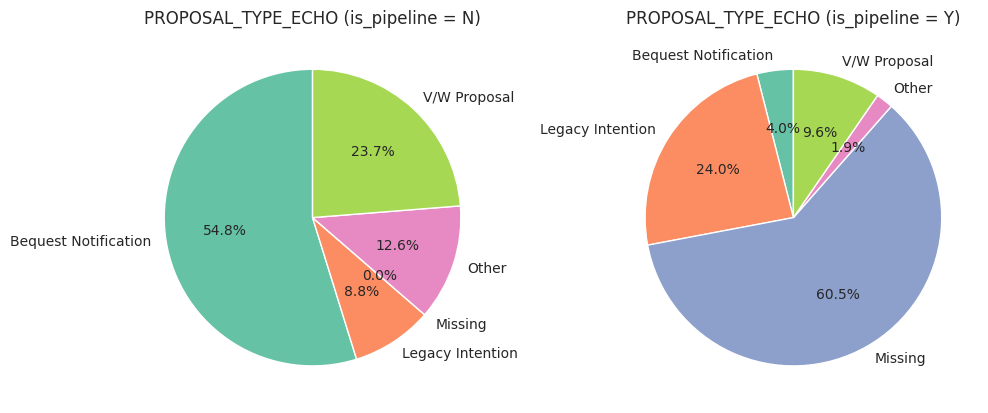

In [137]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['PROPOSAL_TYPE_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
fig, axes = plt.subplots(1, len(cross_tab), figsize=(10, 6))
for i, (index, row) in enumerate(cross_tab.iterrows()):
    axes[i].pie(
        row,
        labels=row.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'PROPOSAL_TYPE_ECHO (is_pipeline = {index})')
#plt.suptitle('Distribution of PROPOSAL_TYPE_ECHO by is_pipeline', y=1.05)
plt.tight_layout()
plt.show()

`PROPOSAL_STATUS_ECHO`

PROPOSAL_STATUS_ECHO  Missing  Other  z-Funded  z-Past value
is_pipeline                                                 
N                           0     29       215           152
Y                         290     10        53           126


<Figure size 1200x600 with 0 Axes>

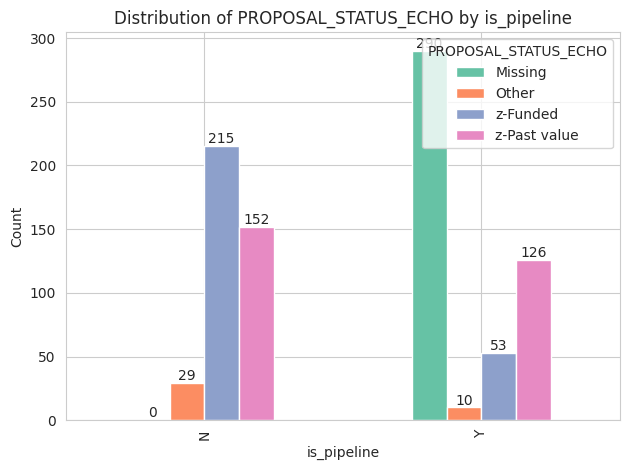

In [138]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['PROPOSAL_STATUS_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=False)

plt.title('Distribution of PROPOSAL_STATUS_ECHO by is_pipeline')
plt.xlabel('is_pipeline')
plt.ylabel('Count')
plt.legend(title='PROPOSAL_STATUS_ECHO')
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

PROPOSAL_STATUS_ECHO  Missing  Other  z-Funded  z-Past value
is_pipeline                                                 
N                           0     29       215           152
Y                         290     10        53           126


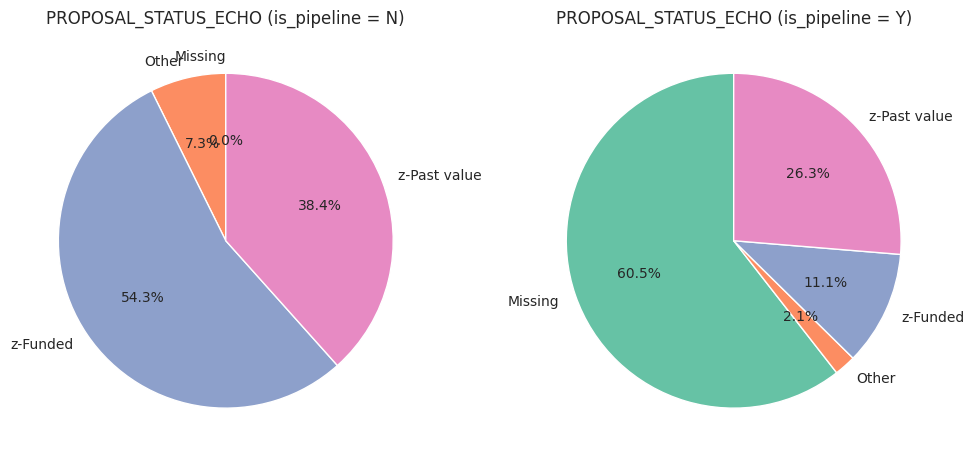

In [139]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['PROPOSAL_STATUS_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
fig, axes = plt.subplots(1, len(cross_tab), figsize=(10, 6))
for i, (index, row) in enumerate(cross_tab.iterrows()):
    axes[i].pie(
        row,
        labels=row.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'PROPOSAL_STATUS_ECHO (is_pipeline = {index})')
#plt.suptitle('Distribution of PROPOSAL_STATUS_ECHO by is_pipeline', y=1.05)
plt.tight_layout()
plt.show()

`STAGE_ECHO`

STAGE_ECHO   Legacy: Fulfil  Other  Unknown  z-No Gift
is_pipeline                                           
N                       248     55        0         93
Y                       132     28      290         29


<Figure size 1200x600 with 0 Axes>

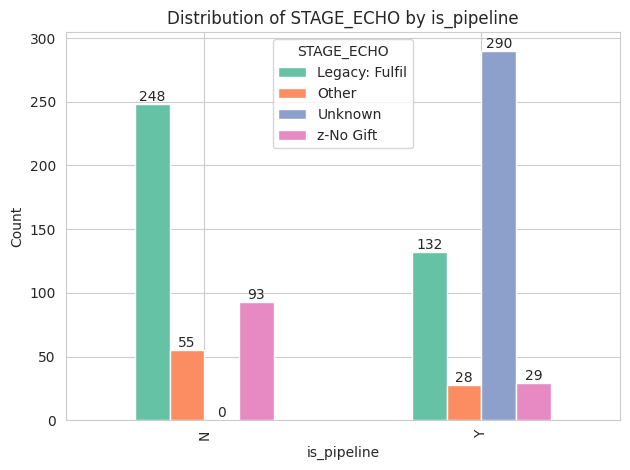

In [140]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['STAGE_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=False)

plt.title('Distribution of STAGE_ECHO by is_pipeline')
plt.xlabel('is_pipeline')
plt.ylabel('Count')
plt.legend(title='STAGE_ECHO')
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

STAGE_ECHO   Legacy: Fulfil  Other  Unknown  z-No Gift
is_pipeline                                           
N                       248     55        0         93
Y                       132     28      290         29


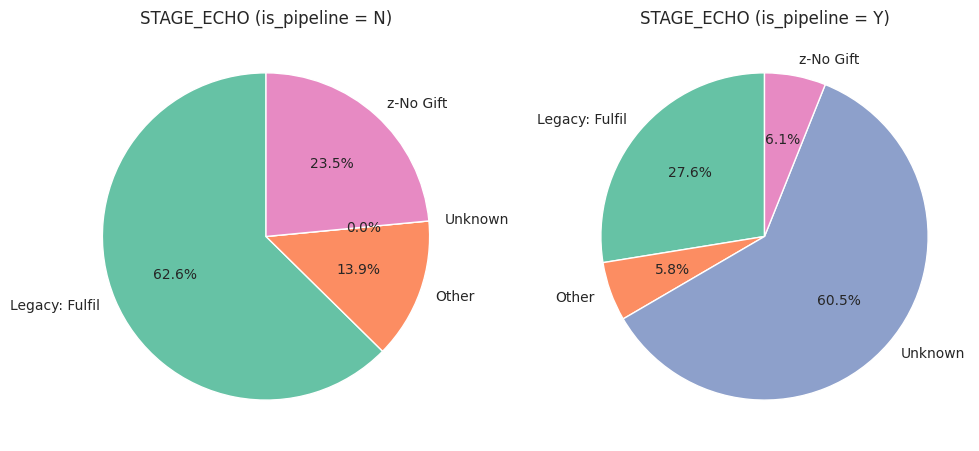

In [141]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['STAGE_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
fig, axes = plt.subplots(1, len(cross_tab), figsize=(10, 6))
for i, (index, row) in enumerate(cross_tab.iterrows()):
    axes[i].pie(
        row,
        labels=row.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'STAGE_ECHO (is_pipeline = {index})')
#plt.suptitle('Distribution of STAGE_ECHO by is_pipeline', y=1.05)
plt.tight_layout()
plt.show()

`SUBMIT_ECHO`

SUBMIT_ECHO  Other  Pecuniary  Residuary  Unknown
is_pipeline                                      
N               23        176         59      138
Y               32         71         36      340


<Figure size 1200x600 with 0 Axes>

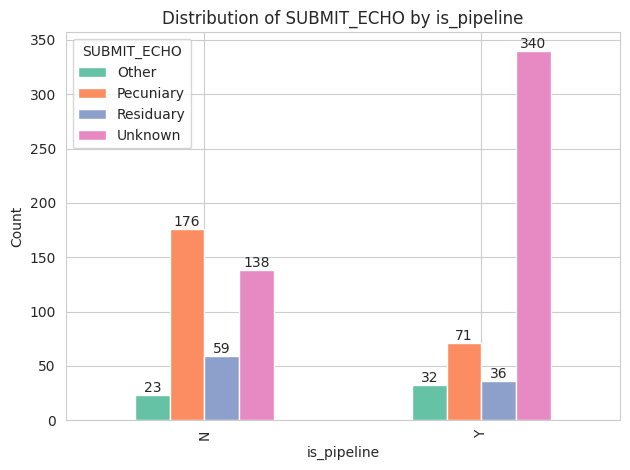

In [142]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['SUBMIT_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=False)

plt.title('Distribution of SUBMIT_ECHO by is_pipeline')
plt.xlabel('is_pipeline')
plt.ylabel('Count')
plt.legend(title='SUBMIT_ECHO')
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

SUBMIT_ECHO  Other  Pecuniary  Residuary  Unknown
is_pipeline                                      
N               23        176         59      138
Y               32         71         36      340


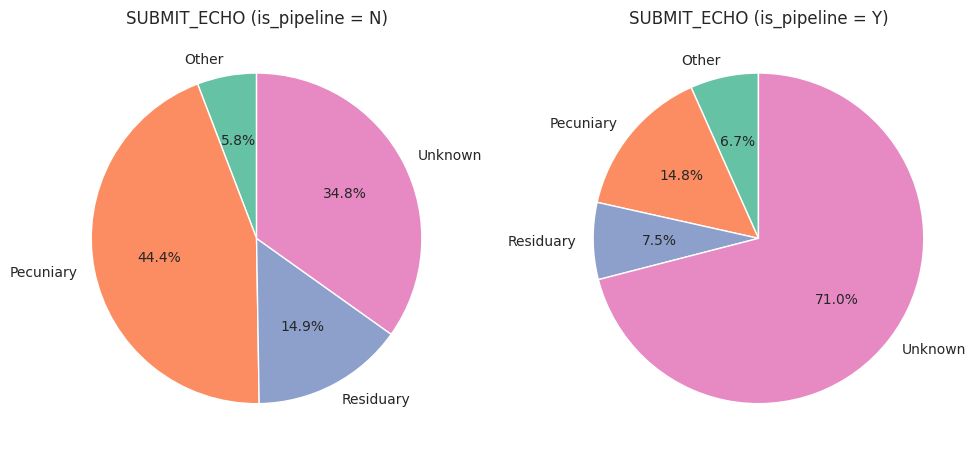

In [143]:
cross_tab = pd.crosstab(plot_data['is_pipeline'], plot_data['SUBMIT_ECHO'])
print(cross_tab)

sns.set_palette("Set2")
fig, axes = plt.subplots(1, len(cross_tab), figsize=(10, 6))
for i, (index, row) in enumerate(cross_tab.iterrows()):
    axes[i].pie(
        row,
        labels=row.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'SUBMIT_ECHO (is_pipeline = {index})')
#plt.suptitle('Distribution of SUBMIT_ECHO by is_pipeline', y=1.05)
plt.tight_layout()
plt.show()

`latest_donation_annum_flag`

latest_donation_annum_flag    N    Y
label                               
0                            83  207
1                           418  167


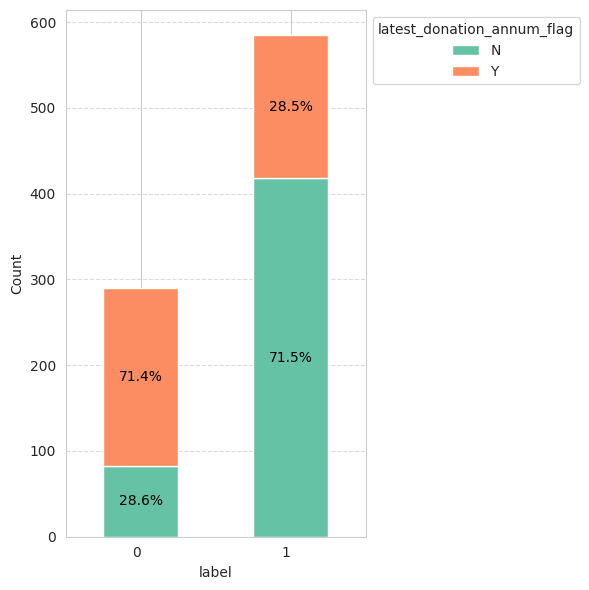

In [144]:
dist = pd.crosstab(plot_data['label'], plot_data['latest_donation_annum_flag'])
print(dist)
draw_bars(dist, 'label', 'latest_donation_annum_flag', 6, 6)

latest_donation_annum_flag    N    Y
legacy_BN                           
BN                          236    0
No_donate                    83  207
Not_BN                      182  167


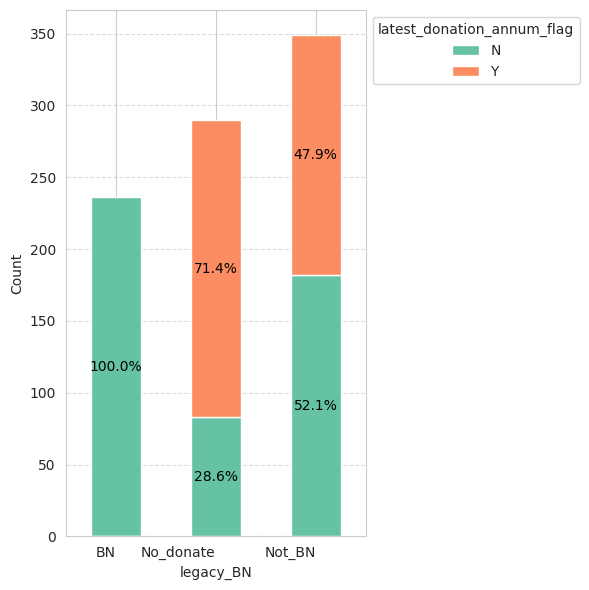

In [145]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['latest_donation_annum_flag'])
print(dist)
draw_bars(dist, 'legacy_BN', 'latest_donation_annum_flag', 6, 6)

latest_donation_annum_flag    N    Y
pipeline_donate                     
Both                         64  125
No_donate                    83  207
No_pipeline                 354   42


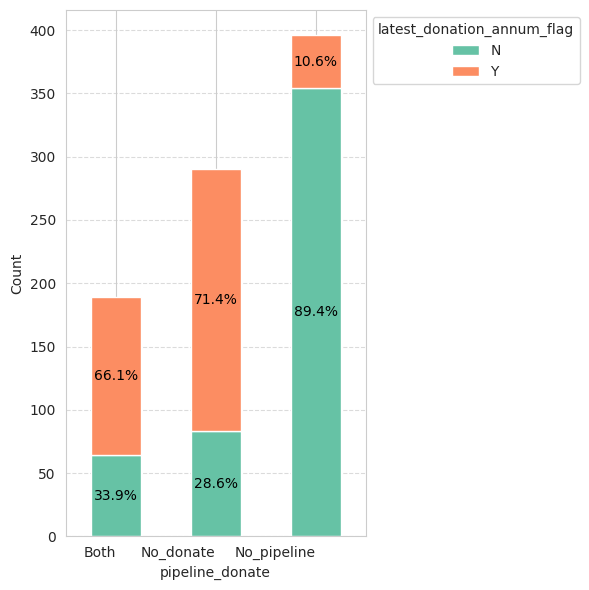

In [146]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['latest_donation_annum_flag'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'latest_donation_annum_flag', 6, 6)

`gift_annum_flag`

gift_annum_flag    N   Y
label                   
0                277  13
1                538  47


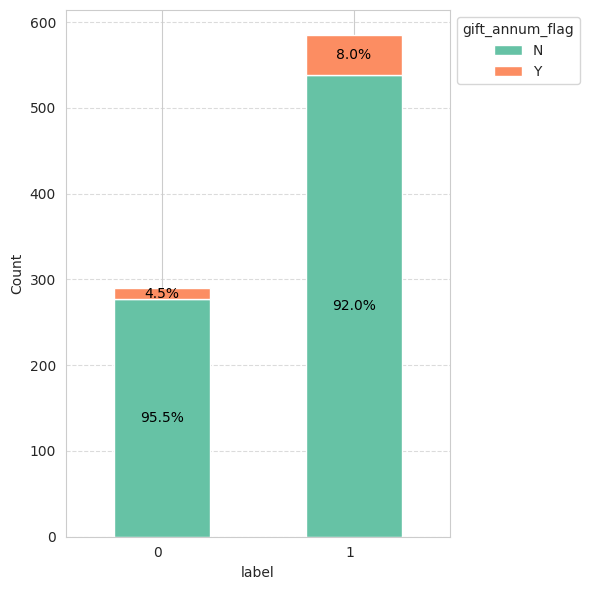

In [147]:
dist = pd.crosstab(plot_data['label'], plot_data['gift_annum_flag'])
print(dist)
draw_bars(dist, 'label', 'gift_annum_flag', 6, 6)

gift_annum_flag    N   Y
legacy_BN               
BN               235   1
No_donate        277  13
Not_BN           303  46


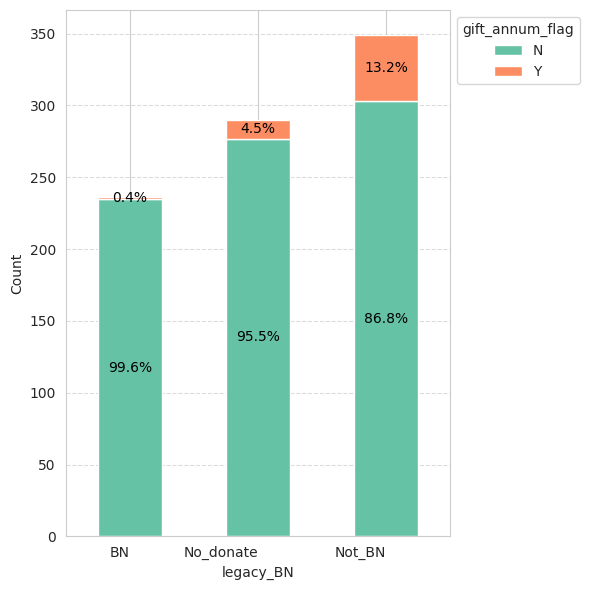

In [148]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['gift_annum_flag'])
print(dist)
draw_bars(dist, 'legacy_BN', 'gift_annum_flag', 6, 6)

gift_annum_flag    N   Y
pipeline_donate         
Both             142  47
No_donate        277  13
No_pipeline      396   0


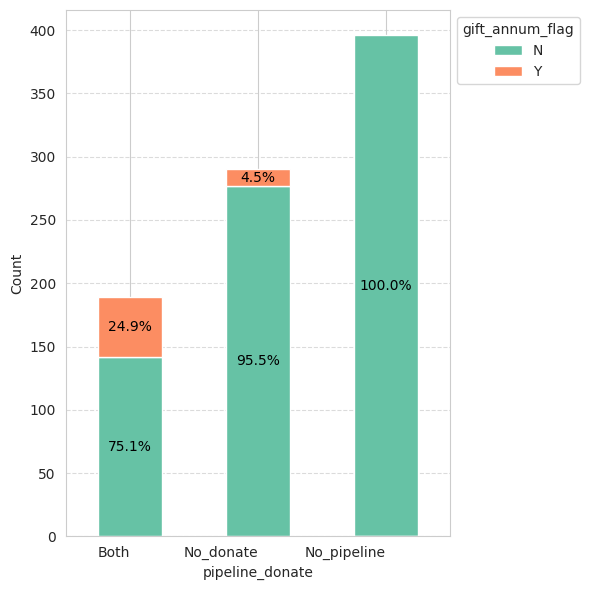

In [149]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['gift_annum_flag'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'gift_annum_flag', 6, 6)

`subcategory_Y_count_flag`

subcategory_Y_count_flag    N   Y
label                            
0                         215  75
1                         522  63


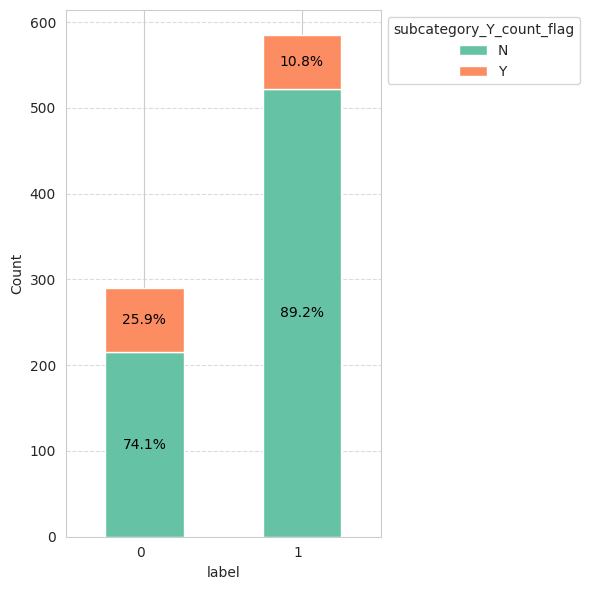

In [150]:
dist = pd.crosstab(plot_data['label'], plot_data['subcategory_Y_count_flag'])
print(dist)
draw_bars(dist, 'label', 'subcategory_Y_count_flag', 6, 6)

subcategory_Y_count_flag    N   Y
legacy_BN                        
BN                        236   0
No_donate                 215  75
Not_BN                    286  63


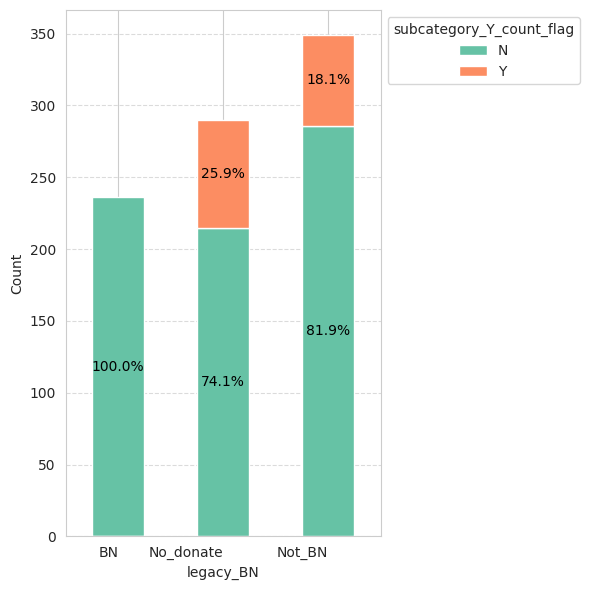

In [151]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['subcategory_Y_count_flag'])
print(dist)
draw_bars(dist, 'legacy_BN', 'subcategory_Y_count_flag', 6, 6)

subcategory_Y_count_flag    N   Y
pipeline_donate                  
Both                      134  55
No_donate                 215  75
No_pipeline               388   8


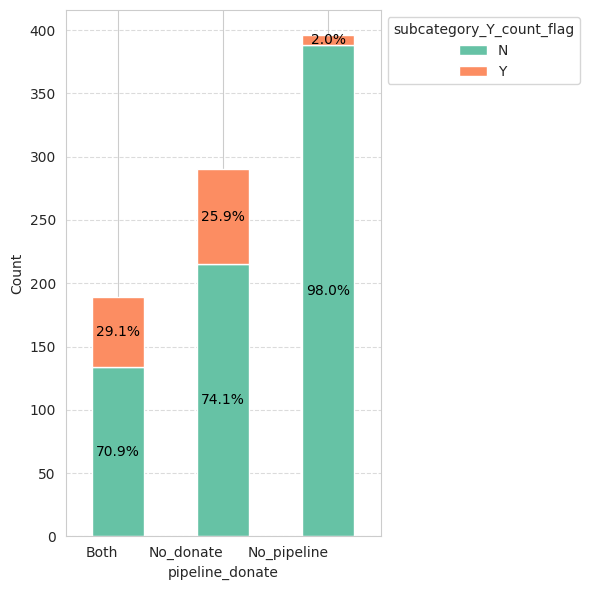

In [152]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['subcategory_Y_count_flag'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'subcategory_Y_count_flag', 6, 6)

`sheet_appear_count_flag`

sheet_appear_count_flag    N   Y
label                           
0                        207  83
1                        509  76


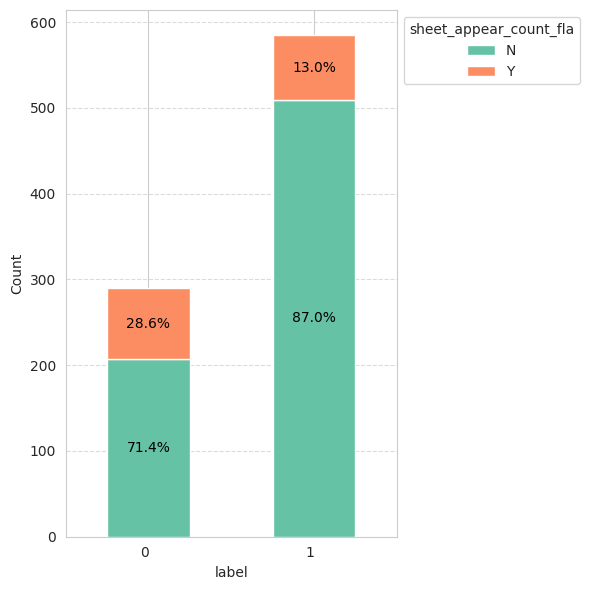

In [153]:
dist = pd.crosstab(plot_data['label'], plot_data['sheet_appear_count_flag'])
print(dist)
draw_bars(dist, 'label', 'sheet_appear_count_fla', 6, 6)

sheet_appear_count_flag    N   Y
legacy_BN                       
BN                       236   0
No_donate                207  83
Not_BN                   273  76


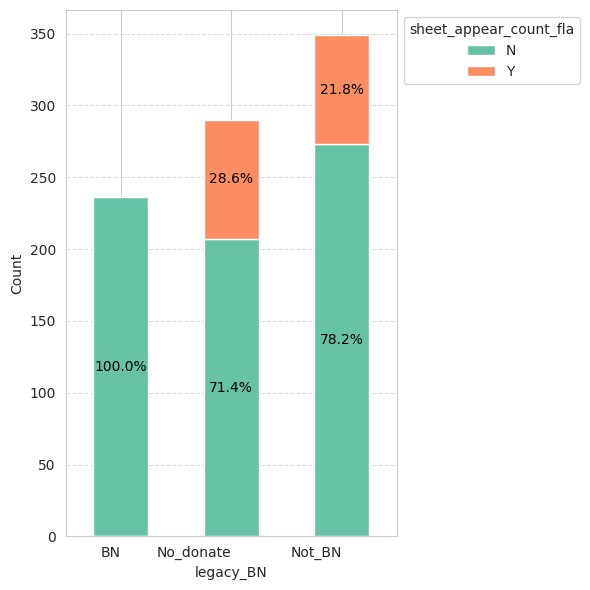

In [154]:
dist = pd.crosstab(plot_data['legacy_BN'], plot_data['sheet_appear_count_flag'])
print(dist)
draw_bars(dist, 'legacy_BN', 'sheet_appear_count_fla', 6, 6)

sheet_appear_count_flag    N   Y
pipeline_donate                 
Both                     125  64
No_donate                207  83
No_pipeline              384  12


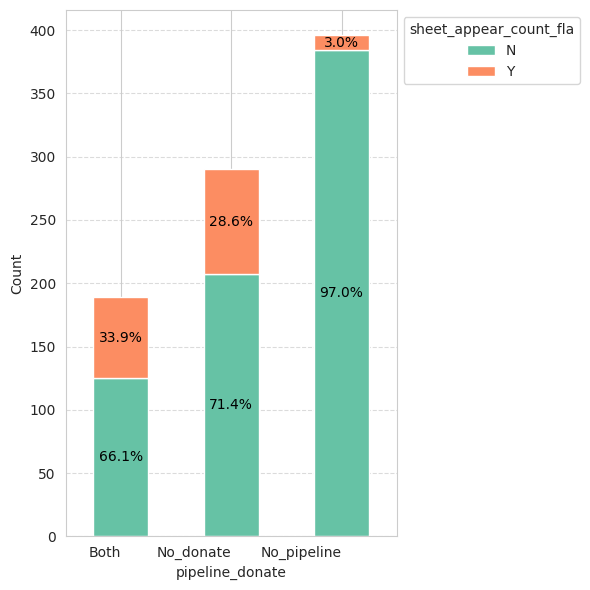

In [155]:
dist = pd.crosstab(plot_data['pipeline_donate'], plot_data['sheet_appear_count_flag'])
print(dist)
draw_bars(dist, 'pipeline_donate', 'sheet_appear_count_fla', 6, 6)

### 1.4.2 For active_alumni_merge

In [156]:
plot_data_2 = active_alumni_merge.copy()
plot_data_2['Alumni Relationship Manager'] = plot_data_2['Alumni Relationship Manager'].fillna("Unknown")

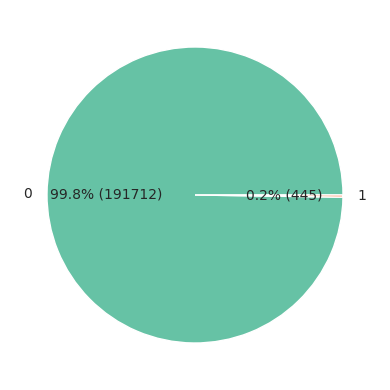

In [157]:
# pie chart for label
label_counts = plot_data_2['label'].value_counts()
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}% ({round(p*sum(label_counts)/100)})',
    colors=sns.color_palette("Set2"),
    textprops={'fontsize': 10}
)
plt.tight_layout()
plt.show()

In [158]:
def draw_bars_log(dist, bar_x, bar_y, size_x, size_y):
    row_totals = dist.sum(axis=1)

    colors = sns.color_palette("Set2", len(dist.columns))
    ax = dist.plot(kind='bar', stacked=True, figsize=(size_x, size_y), color=colors)

    for i, (idx, row) in enumerate(dist.iterrows()):
        cumulative = 0
        for col in dist.columns:
            value = row[col]
            if value > 0:
                center = cumulative + value / 2
                percentage = (value / row_totals[idx]) * 100
                ax.text(i, center, f'{percentage:.1f}%', ha='center', va='center',fontsize=10, color='black')
            cumulative += value

    plt.yscale('log')
    plt.ylabel('Count (Log Scale)', fontsize=10)
    plt.xlabel(bar_x, fontsize=10)
    plt.legend(title=bar_y, bbox_to_anchor=(1, 1), loc='upper left')
    plt.xticks(rotation=0, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

`Marital Status`

Marital Status  Married  Unknown
label                           
0                 14231   177481
1                   166      279


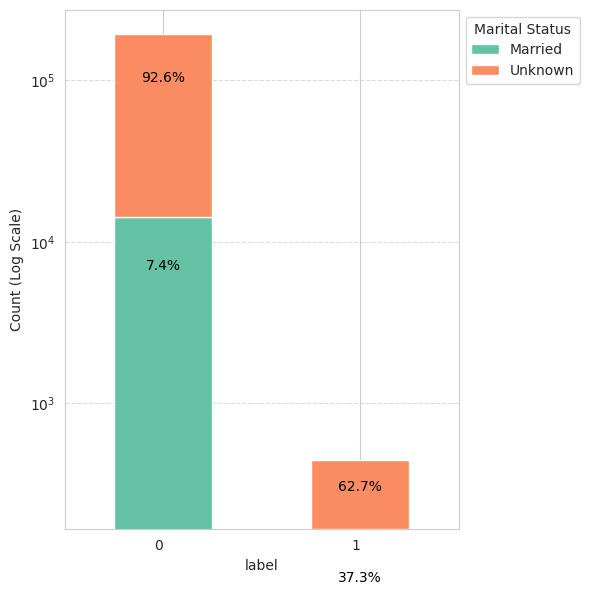

In [159]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['Marital Status'])
print(dist)
draw_bars_log(dist, 'label', 'Marital Status', 6, 6)

`Children Y/N`

Children Y/N       N     Y
label                     
0             186470  5242
1                370    75


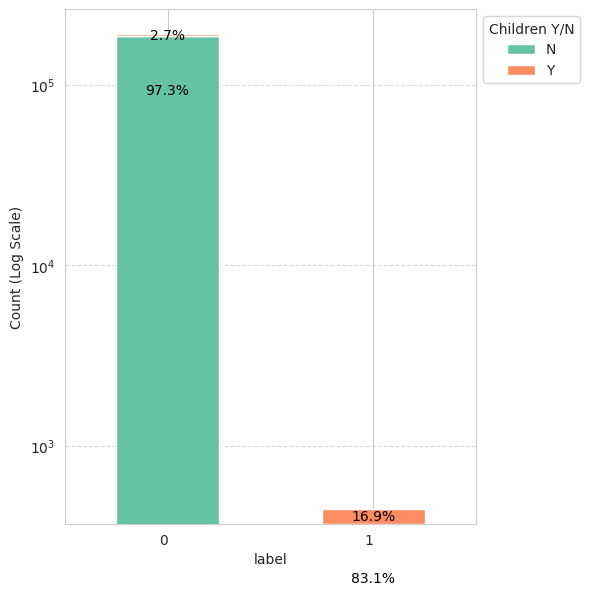

In [160]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['Children Y/N'])
print(dist)
draw_bars_log(dist, 'label', 'Children Y/N', 6, 6)

`COUNTRY`

COUNTRY  Other  People's Republic of China    USA  United Kingdom  Unknown
label                                                                     
0        74647                       12918  23701           67892    12554
1           75                           9     65             290        6


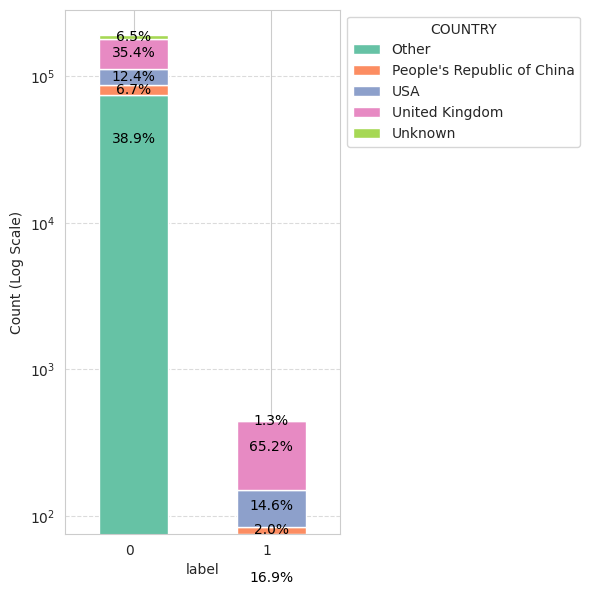

In [161]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['COUNTRY'])
print(dist)
draw_bars_log(dist, 'label', 'COUNTRY', 6, 6)

`Alumni Relationship Manager`

Alumni Relationship Manager  Unknown  Yes
label                                    
0                             191578  134
1                                443    2


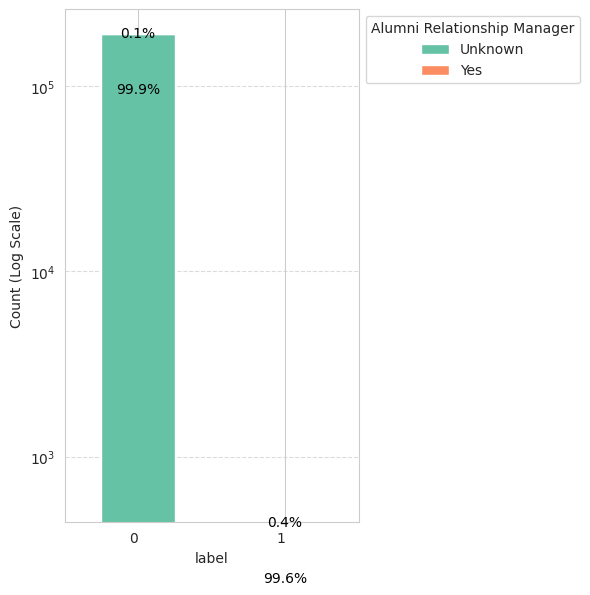

In [162]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['Alumni Relationship Manager'])
print(dist)
draw_bars_log(dist, 'label', 'Alumni Relationship Manager', 6, 6)

`graduation_annum`

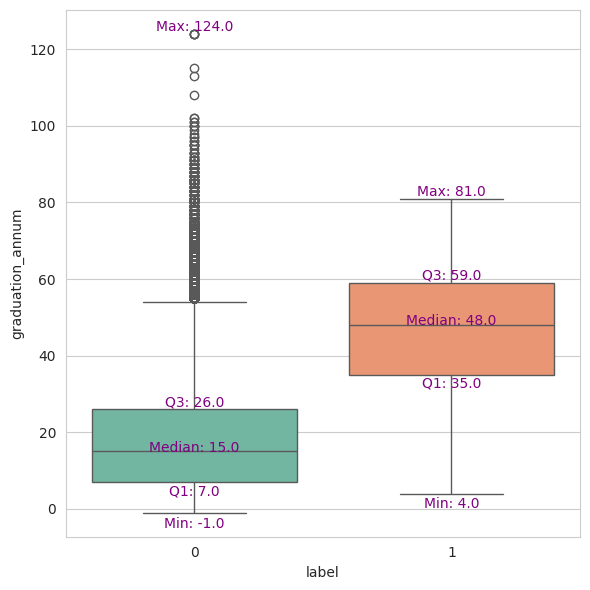

In [163]:
draw_boxes('label', 'graduation_annum', 6, 6, plot_data_2)

`age_extend`

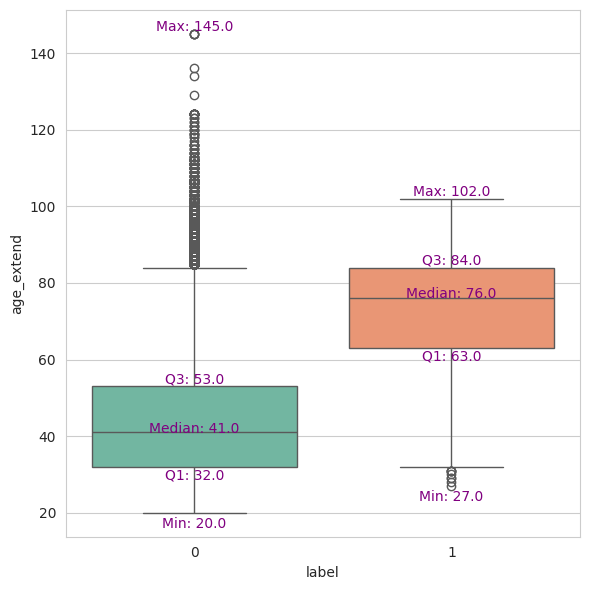

In [164]:
draw_boxes('label', 'age_extend', 6, 6, plot_data_2)

`Degree`

In [165]:
plot_data_2['Degree'].value_counts()

Degree
Postgraduate     113248
Undergraduate     50772
Other             15482
Unknown            9374
Diploma/Cert       2169
Doctorate          1112
Name: count, dtype: int64

Degree  Diploma/Cert  Doctorate  Other  Postgraduate  Undergraduate  Unknown
label                                                                       
0               2156       1112  15461        113065          50621     9297
1                 13          0     21           183            151       77


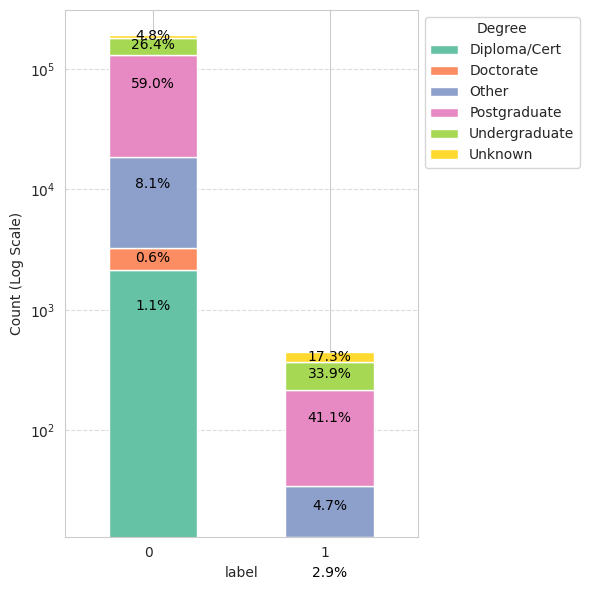

In [166]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['Degree'])
print(dist)
draw_bars_log(dist, 'label', 'Degree', 6, 6)

`latest_donation_annum_flag`

latest_donation_annum_flag       N      Y
label                                    
0                           176502  15210
1                               71    374


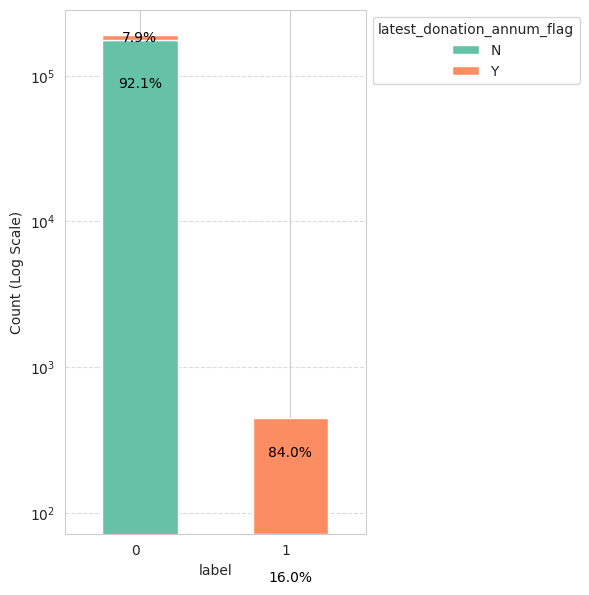

In [167]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['latest_donation_annum_flag'])
print(dist)
draw_bars_log(dist, 'label', 'latest_donation_annum_flag', 6, 6)

`subcategory_Y_count_flag`

subcategory_Y_count_flag       N     Y
label                                 
0                         186299  5413
1                            307   138


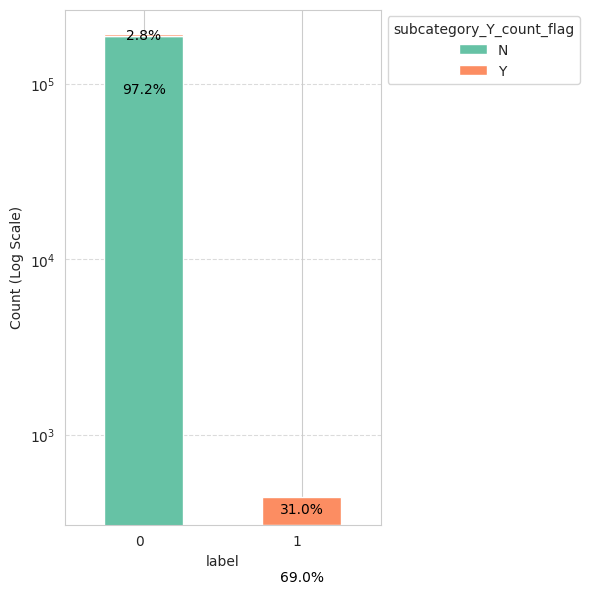

In [168]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['subcategory_Y_count_flag'])
print(dist)
draw_bars_log(dist, 'label', 'subcategory_Y_count_flag', 6, 6)

`sheet_appear_count_flag`

sheet_appear_count_flag       N      Y
label                                 
0                        179321  12391
1                           286    159


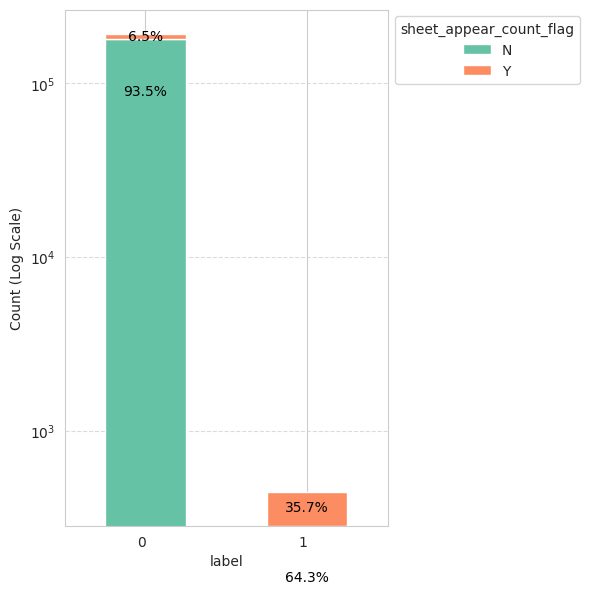

In [169]:
dist = pd.crosstab(plot_data_2['label'], plot_data_2['sheet_appear_count_flag'])
print(dist)
draw_bars_log(dist, 'label', 'sheet_appear_count_flag', 6, 6)

## 1.5 Legacy Pipeline Analysis

In [170]:
stages = merged_pipeline_2[['ID_NUMBER', 'stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals',
                            'in_circle', 'in_active', 'is_pipeline']]

In [171]:
# Define the columns we need to process
columns_to_process = [
    'stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals'
]

# Convert boolean values to integers (1/0)
for col in columns_to_process:
    if stages[col].dtype == 'bool':
        stages[col] = stages[col].astype(int)

/tmp/ipython-input-1436261127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stages[col] = stages[col].astype(int)
/tmp/ipython-input-1436261127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stages[col] = stages[col].astype(int)
/tmp/ipython-input-1436261127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [172]:
# Visulization 1：Distribution of Constituents Across Engagement Stages
# Step 1: Calculate stage counts
stage_counts = stages[['stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals']].sum().reset_index()
stage_counts.columns = ['Stage', 'Count']

# Step 2: Create bar chart with labels
fig1 = px.bar(
    stage_counts,
    x='Stage',
    y='Count',
    text='Count',
    labels={'Count': 'Number of Constituents', 'Stage': 'Engagement Stage'},
    color='Stage',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Step 3: Update layout and trace for display
fig1.update_layout(
    xaxis_title='Stage',
    yaxis_title='Number of Constituents',
    showlegend=False
)

fig1.update_traces(
    textposition='outside',
    cliponaxis=False         # Ensure labels outside the bar are shown even if above plot area
)

# Show plot
fig1.show()


In [173]:
# Calculate how many stages each individual participated in
stages['stages_participated'] = stages[['stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals']].sum(axis=1)

# Count frequency of each participation count
stage_participation_counts = stages['stages_participated'].value_counts().sort_index().reset_index()
stage_participation_counts.columns = ['Number of Stages', 'Count']

# Create bar chart with data labels
fig2 = px.bar(
    stage_participation_counts,
    x='Number of Stages',
    y='Count',
    text='Count',
    labels={'Count': 'Number of Constituents', 'Number of Stages': 'Number of Stages Participated'},
    color='Number of Stages',
    color_discrete_sequence=px.colors.sequential.Blues_r
)

# Layout & formatting
fig2.update_layout(
    xaxis_title='Number of Stages Participated',
    yaxis_title='Number of Constituents',
    xaxis=dict(tickmode='linear', dtick=1),
    showlegend=False
)

fig2.update_traces(
    textposition='outside',
    cliponaxis=False
)

# Show the plot
fig2.show()


/tmp/ipython-input-2434036958.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [174]:
# New definition: A positive sample is a record where stage_proposals == 1
stages['is_positive'] = (stages['stage_proposals'] == 1).astype(int)

# Define the core funnel stages for classification
funnel_stages = ['stage_enquirer', 'stage_intender', 'stage_pledge']
stages['num_funnel_stages'] = stages[funnel_stages].sum(axis=1)

# Classify the entire dataset into journey types
def categorize_journey(num_stages):
    if num_stages == 3:
        return '1. Full Journey (Loyalists)'
    elif num_stages > 0:
        return '2. Partial Journey (Enthusiasts)'
    else:
        return '3. No Journey (Surprises)'

stages['journey_type'] = stages['num_funnel_stages'].apply(categorize_journey)

print(f"\nTotal records analyzed: {len(stages)}")
print(f"Positive samples (stage_proposals=1): {stages['is_positive'].sum()}")
print(f"Negative samples (stage_proposals=0): {len(stages) - stages['is_positive'].sum()}")


Total records analyzed: 875
Positive samples (stage_proposals=1): 585
Negative samples (stage_proposals=0): 290


/tmp/ipython-input-642096911.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-642096911.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-642096911.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [175]:
# Analyze the Conversion Rate of Each Journey
# Group by journey type and positive/negative status
journey_conversion = stages.groupby(['journey_type', 'is_positive']).size().unstack(fill_value=0)
journey_conversion.columns = ['Negative Samples', 'Positive Samples']

# Calculate totals and conversion rate
journey_conversion['Total'] = journey_conversion['Negative Samples'] + journey_conversion['Positive Samples']
journey_conversion['Conversion Rate (%)'] = (journey_conversion['Positive Samples'] / journey_conversion['Total'] * 100).round(1)

print("\n--- Conversion Analysis by Journey Type ---")
print(journey_conversion.sort_index())


--- Conversion Analysis by Journey Type ---
                                  Negative Samples  Positive Samples  Total  \
journey_type                                                                  
1. Full Journey (Loyalists)                      3                 6      9   
2. Partial Journey (Enthusiasts)               287               183    470   
3. No Journey (Surprises)                        0               396    396   

                                  Conversion Rate (%)  
journey_type                                           
1. Full Journey (Loyalists)                      66.7  
2. Partial Journey (Enthusiasts)                 38.9  
3. No Journey (Surprises)                       100.0  


### 1.5.1 Conversion rate of three stages

In [176]:
# Total individuals at Enquirer stage
enquirer_total = stages[stages["stage_enquirer"] == True].shape[0]

# Individuals who were Enquirer and also reached Proposal stage
enquirer_and_proposal = stages[(stages["stage_enquirer"] == True) & (stages["stage_proposals"] == True)].shape[0]

# Conversion rate from Enquirer to Proposal
enquirer_conversion_rate = enquirer_and_proposal / enquirer_total if enquirer_total > 0 else 0

# === Not Enquirer but in other funnel stages ===
funnel_only = stages[stages["num_funnel_stages"] > 0]

not_enq_total = funnel_only[funnel_only["stage_enquirer"] != True].shape[0]
not_enq_and_proposal = funnel_only[(funnel_only["stage_enquirer"] != True) & (funnel_only["stage_proposals"] == True)].shape[0]
not_enq_conversion_rate = not_enq_and_proposal / not_enq_total if not_enq_total > 0 else 0


# --- Print Results ---
print(f"Enquirer stage total: {enquirer_total}")
print(f"Enquirer → Proposal conversions: {enquirer_and_proposal}")
print(f"Enquirer → Proposal conversion rate: {enquirer_conversion_rate:.2%}")
print("=== Not in Enquirer BUT in Other Funnel Stages ===")
print(f"Not in Enquirer stage total: {not_enq_total}")
print(f"Not in Enquirer but reached Proposal: {not_enq_and_proposal}")
print(f"Not in Enquirer → Proposal conversion rate: {not_enq_conversion_rate:.2%}")


Enquirer stage total: 243
Enquirer → Proposal conversions: 33
Enquirer → Proposal conversion rate: 13.58%
=== Not in Enquirer BUT in Other Funnel Stages ===
Not in Enquirer stage total: 236
Not in Enquirer but reached Proposal: 156
Not in Enquirer → Proposal conversion rate: 66.10%


In [177]:
# Total individuals at Intender stage
intender_total = stages[stages["stage_intender"] == True].shape[0]

# Individuals who were Intender and also reached Proposal stage
intender_and_proposal = stages[(stages["stage_intender"] == True) & (stages["stage_proposals"] == True)].shape[0]

# Conversion rate from Intender to Proposal
intender_conversion_rate = intender_and_proposal / intender_total if intender_total > 0 else 0

# === Not in Intender but in other funnel stages ===
not_intender_total = funnel_only[funnel_only["stage_intender"] != True].shape[0]
not_intender_and_proposal = funnel_only[(funnel_only["stage_intender"] != True) & (funnel_only["stage_proposals"] == True)].shape[0]
not_intender_conversion_rate = not_intender_and_proposal / not_intender_total if not_intender_total > 0 else 0

print(f"\nIntender stage total: {intender_total}")
print(f"Intender → Proposal conversions: {intender_and_proposal}")
print(f"Intender → Proposal conversion rate: {intender_conversion_rate:.2%}")
print("\n=== Not in Intender BUT in Other Funnel Stages ===")
print(f"Total: {not_intender_total}")
print(f"→ Proposal conversions: {not_intender_and_proposal}")
print(f"→ Proposal conversion rate: {not_intender_conversion_rate:.2%}")


Intender stage total: 123
Intender → Proposal conversions: 64
Intender → Proposal conversion rate: 52.03%

=== Not in Intender BUT in Other Funnel Stages ===
Total: 356
→ Proposal conversions: 125
→ Proposal conversion rate: 35.11%


In [178]:
# Count the total number of individuals at the Pledge stage
pledge_total = stages[stages["stage_pledge"] == True].shape[0]

# Count how many of them also reached the Proposal stage
pledge_and_proposal = stages[(stages["stage_pledge"] == True) & (stages["stage_proposals"] == True)].shape[0]

# Calculate the conversion rate from Pledge to Proposal
conversion_rate = pledge_and_proposal / pledge_total if pledge_total > 0 else 0

# === Not in Pledge but still in the funnel ===
not_pledge_total = funnel_only[funnel_only["stage_pledge"] != True].shape[0]
not_pledge_and_proposal = funnel_only[(funnel_only["stage_pledge"] != True) & (funnel_only["stage_proposals"] == True)].shape[0]
not_pledge_conversion_rate = not_pledge_and_proposal / not_pledge_total if not_pledge_total > 0 else 0

# Print the results
print(f"Total individuals at Pledge stage: {pledge_total}")
print(f"Number converted to Proposal stage: {pledge_and_proposal}")
print(f"Conversion rate: {conversion_rate:.2%}")

print("\n=== Not in Pledge BUT in Other Funnel Stages (excluding No Journey) ===")
print(f"Total: {not_pledge_total}")
print(f"→ Proposal conversions: {not_pledge_and_proposal}")
print(f"→ Proposal conversion rate: {not_pledge_conversion_rate:.2%}")

Total individuals at Pledge stage: 191
Number converted to Proposal stage: 134
Conversion rate: 70.16%

=== Not in Pledge BUT in Other Funnel Stages (excluding No Journey) ===
Total: 288
→ Proposal conversions: 55
→ Proposal conversion rate: 19.10%


In [179]:
# Build the data from previous analysis
conversion_data_detailed = {
    "Stage Group": [
        "Enquirer", "Not Enquirer",
        "Intender", "Not Intender",
        "Pledge", "Not Pledge"
    ],
    "Total Individuals": [
        243, 236,         # Enquirer + Not Enquirer
        123, 356,         # Intender + Not Intender
        191, 288          # Pledge + Not Pledge
    ],
    "Converted to Proposal": [
        33, 156,
        64, 125,
        134, 55
    ],
    "Conversion Rate (%)": [
        13.58, 66.10,
        52.03, 35.11,
        70.16, 19.10
    ]
}

# Create DataFrame
conversion_detailed_df = pd.DataFrame(conversion_data_detailed)

# Display preview (optional)
print(conversion_detailed_df)


    Stage Group  Total Individuals  Converted to Proposal  Conversion Rate (%)
0      Enquirer                243                     33                13.58
1  Not Enquirer                236                    156                66.10
2      Intender                123                     64                52.03
3  Not Intender                356                    125                35.11
4        Pledge                191                    134                70.16
5    Not Pledge                288                     55                19.10


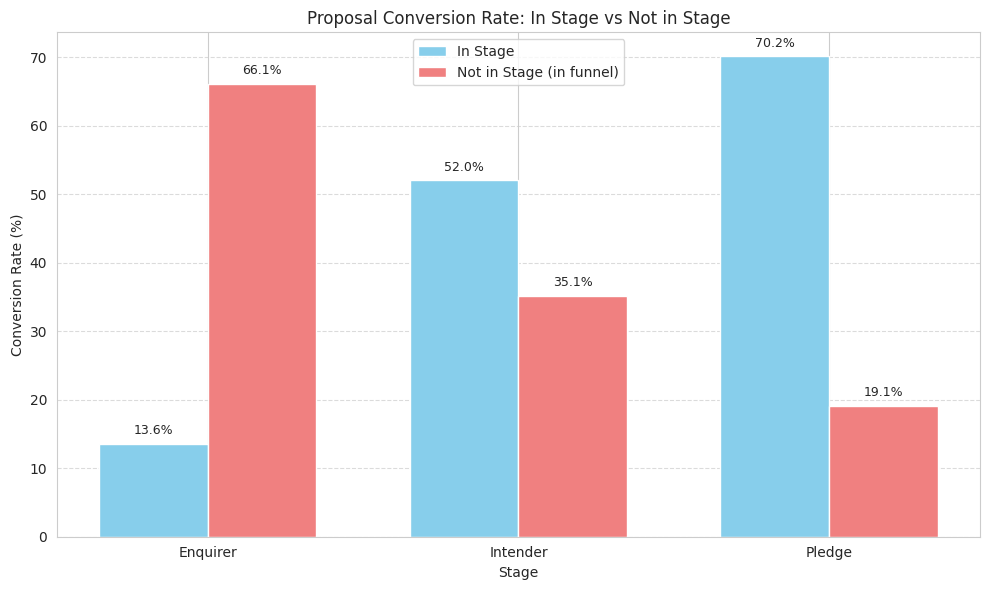

In [180]:
# Extract Data
stages1 = ["Enquirer", "Intender", "Pledge"]
in_stage = [13.58, 52.03, 70.16]
not_in_stage = [66.10, 35.11, 19.10]
x = np.arange(len(stages1))
bar_width = 0.35

# Plot
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, in_stage, width=bar_width, label='In Stage', color='skyblue')
bars2 = plt.bar(x + bar_width, not_in_stage, width=bar_width, label='Not in Stage (in funnel)', color='lightcoral')

# Add data labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

# Labels and formatting
plt.xlabel("Stage")
plt.ylabel("Conversion Rate (%)")
plt.xticks(x + bar_width / 2, stages1)
plt.title("Proposal Conversion Rate: In Stage vs Not in Stage")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 1.5.2 Conversion rate of stage combinations

In [181]:
stages.columns = stages.columns.str.lower()

# Ensure boolean type for key columns
for col in ['stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals']:
    stages[col] = stages[col].astype(bool)

# Identify only two-stage partial journeys
def classify_two_stage_path(row):
    path = []
    if row['stage_enquirer']:
        path.append("Enquirer")
    if row['stage_intender']:
        path.append("Intender")
    if row['stage_pledge']:
        path.append("Pledge")
    return " + ".join(path) if len(path) == 2 else None  # Only keep exactly two-stage paths

# Create new path column
stages['partial_path'] = stages.apply(classify_two_stage_path, axis=1)

# Filter non-null paths and summarize
path_summary = stages[stages['partial_path'].notna()].groupby('partial_path').agg(
    total_count=('stage_proposals', 'count'),
    proposal_count=('stage_proposals', 'sum')
).reset_index()

# Compute conversion and drop-off rates
path_summary['conversion_rate (%)'] = (path_summary['proposal_count'] / path_summary['total_count'] * 100).round(2)
path_summary['drop_off_rate (%)'] = (100 - path_summary['conversion_rate (%)']).round(2)

# Show result
print(path_summary)


          partial_path  total_count  proposal_count  conversion_rate (%)  \
0  Enquirer + Intender           22               3                13.64   
1    Enquirer + Pledge           24              13                54.17   
2    Intender + Pledge           14              14               100.00   

   drop_off_rate (%)  
0              86.36  
1              45.83  
2               0.00  


/tmp/ipython-input-1576596153.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1576596153.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1576596153.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-157

In [182]:
# Visualization 3: Composition of Each Journey Type (Showing Conversion)
display(journey_conversion.sort_index())

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    y=journey_conversion.index,
    x=journey_conversion['Positive Samples'],
    name='Positive (Reached Proposal)',
    orientation='h',
    marker_color='indianred',
    text=[f"{v}" if v > 0 else "" for v in journey_conversion['Positive Samples']],
    textposition='auto'
))
fig3.add_trace(go.Bar(
    y=journey_conversion.index,
    x=journey_conversion['Negative Samples'],
    name='Negative (Did Not Reach Proposal)',
    orientation='h',
    marker_color='lightsalmon',
    text=[f"{v}" if v > 0 else "" for v in journey_conversion['Negative Samples']],
    textposition='auto'
))

fig3.update_layout(
    barmode='stack',
    yaxis_title="Journey Type",
    xaxis_title="Number of Individuals"
)
fig3.show()

Negative Samples  Positive Samples  Total  \
journey_type                                                                  
1. Full Journey (Loyalists)                      3                 6      9   
2. Partial Journey (Enthusiasts)               287               183    470   
3. No Journey (Surprises)                        0               396    396   

                                  Conversion Rate (%)  
journey_type                                           
1. Full Journey (Loyalists)                      66.7  
2. Partial Journey (Enthusiasts)                 38.9  
3. No Journey (Surprises)                       100.0

In [183]:
# Visualization 4: Where Do Our Successful Conversions Come From?
positive_samples_df = stages[stages['is_positive'] == 1]
positive_journey_counts = positive_samples_df['journey_type'].value_counts()
display(positive_journey_counts)

conversion_rates = journey_conversion['Conversion Rate (%)']
fig4 = px.pie(
    values=conversion_rates.values,
    names=conversion_rates.index,
    title='Distribution of Conversion Rates by Journey Type',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig4.update_traces(textinfo='percent+label', pull=[0.05, 0, 0])
fig4.show()

journey_type
3. No Journey (Surprises)           396
2. Partial Journey (Enthusiasts)    183
1. Full Journey (Loyalists)           6
Name: count, dtype: int64

In [184]:
# Visualization 5: Conversion from Two-Stage Journeys to Proposal
path_summary["drop_off_count"] = path_summary["total_count"] - path_summary["proposal_count"]

# Build Sankey components
labels = list(path_summary["partial_path"]) + ["Proposal", "Drop-off"]
label_index = {label: i for i, label in enumerate(labels)}

sources = []
targets = []
values = []

for _, row in path_summary.iterrows():
    source_idx = label_index[row["partial_path"]]
    targets.append(label_index["Proposal"])
    sources.append(source_idx)
    values.append(row["proposal_count"])

    targets.append(label_index["Drop-off"])
    sources.append(source_idx)
    values.append(row["drop_off_count"])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=sources, target=targets, value=values)
)])

fig.update_layout(title_text="Conversion from Two-Stage Journeys to Proposal (Sankey Diagram)", font_size=12)
fig.show()

# 2.Analysis and Modelling

## 2.1 Factor Analysis

In [ ]:
# import modules
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.model_selection import train_test_split
from semopy import Model, calc_stats

### 2.1.1 Self-defined Functions for Factor Analysis

In [ ]:
# check for validity for EFA
def check_efa(df):
    kmo_all, kmo_model = calculate_kmo(df)
    chi_sq, p_value = calculate_bartlett_sphericity(df)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print(f"KMO value: {kmo_model:.3f}")
    print(f"Bartlett p-value: {p_value:.3f}")
    print(vif_data.sort_values("VIF", ascending=False))

In [ ]:
# function to decide number of factors in EFA
def efa_factor(df):
    # fit EFA
    efa = FactorAnalyzer(rotation=None)
    efa.fit(df)
    ev = efa.get_eigenvalues()[0]

    # Kaiser
    kaiser = sum(ev > 1)
    print(f"Number of factors based on Kaiser: {kaiser}")

    # Scree Plot
    plt.plot(range(1, len(ev)+1), ev, 'o-')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.xlabel("No Factor")
    plt.ylabel("Eigenvalues")
    plt.grid()
    plt.show()

In [ ]:
# function to present results of EFA
def efa_results(L, C, n_factors, df, ev):
    # loadings
    loadings = pd.DataFrame(L, index=df.columns, columns=[f'Factor_{i+1}' for i in range(n_factors)])
    #print("loadings:")
    #print(loadings.round(2))

    # significant loadings > 0.4
    significant_loadings = loadings.map(lambda x: x if abs(x) > 0.4 else None)
    #print("\nsignificant loadings(>|0.4|):")
    #print(significant_loadings.dropna(how='all'))
    plt.figure(figsize=(6, 6))
    sns.heatmap(significant_loadings.fillna(0), annot=True, cmap='coolwarm', center=0)
    plt.title("Significant Factor Loadings (|>0.4|)")
    plt.show()

    # Kaiser
    kaiser = sum(ev > 1)
    print(f"Number of factors based on Kaiser: {kaiser}")

    # communalities
    communalities = pd.DataFrame(C, index=df.columns, columns=['Communality'])
    print("\ncommunalities:")
    print(communalities.round(2))

    # variance
    total_variance = len(df.columns)
    explained_variance_ratio = ev / total_variance
    cumulative_variance = explained_variance_ratio.cumsum()
    factor_names = [f"Factor {i+1}" for i in range(len(df.columns))]
    variance_df = pd.DataFrame({
        "Factor": factor_names,
        "Variance Explained": explained_variance_ratio * 100,
        "Cumulative Variance": cumulative_variance * 100
    })
    variance_df = variance_df.round(2)
    print("\nExplained variance:")
    display(variance_df)


In [ ]:
# fit EFA automatically
def fit_efa(df, n_factor):
    for m in ("principal", "minres"):
        for r in ("varimax", "promax"):
            print(f"{m} + {r}")
            efa = FactorAnalyzer(n_factors=n_factor, method=m, rotation=r)
            efa.fit(df)
            ev = efa.get_eigenvalues()[0]
            efa_results(efa.loadings_, efa.get_communalities(), n_factor, df, ev)
            print("===============================================================================================================")
            print("\n")

### 2.1.2 EFA on Potential Donors
Data preparation:
- convert all boolean variables (only T/F, Y/N) to binary
- one-hot encoding all categorical variables (including unknown)
- split into training and test sets

In [ ]:
# select variables
fa_data = plot_data[['enquirer_count', 'COUNTRY_CODE', 'stage_enquirer', 'stage_intender', 'stage_pledge',
                   'in_circle', 'Marital Status', 'Children Y/N', 'in_active', 'enquire_annum',
                   'graduation_annum', 'age_extend', 'age_group', 'latest_donation_annum_flag',
                   'gift_annum_flag', 'subcategory_Y_count_flag',
                   'sheet_appear_count_flag', 'legacy_BN']].copy()

In [ ]:
display(fa_data.head())
fa_data.info()

enquirer_count    COUNTRY_CODE  stage_enquirer  stage_intender  \
0               0  United Kingdom           False           False   
1               0  United Kingdom           False           False   
2               0  United Kingdom           False            True   
3               0         Unknown           False           False   
4               1  United Kingdom            True            True   

   stage_pledge in_circle Marital Status Children Y/N in_active  \
0          True         Y        Married            N         Y   
1          True         Y        Unknown            Y         Y   
2          True         N        Unknown            N         Y   
3         False         N        Unknown      Unknown         N   
4         False         N        Unknown            N         Y   

   enquire_annum  graduation_annum  age_extend  age_group  \
0              0                71          92          4   
1              0                61          87          3   
2              0                65          88          4   
3              0              <NA>        <NA>          5   
4              7                41          69          2   

  latest_donation_annum_flag gift_annum_flag subcategory_Y_count_flag  \
0                          Y               Y                        N   
1                          Y               Y                        Y   
2                          Y               N                        Y   
3                          N               N                        N   
4                          N               N                        N   

  sheet_appear_count_flag legacy_BN  
0                       N    Not_BN  
1                       Y    Not_BN  
2                       Y    Not_BN  
3                       N        BN  
4                       N    Not_BN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   enquirer_count              875 non-null    int64 
 1   COUNTRY_CODE                875 non-null    object
 2   stage_enquirer              875 non-null    bool  
 3   stage_intender              875 non-null    bool  
 4   stage_pledge                875 non-null    bool  
 5   in_circle                   875 non-null    object
 6   Marital Status              875 non-null    object
 7   Children Y/N                875 non-null    object
 8   in_active                   875 non-null    object
 9   enquire_annum               875 non-null    int64 
 10  graduation_annum            510 non-null    Int64 
 11  age_extend                  548 non-null    Int64 
 12  age_group                   875 non-null    int64 
 13  latest_donation_annum_flag  875 non-null    object

In [ ]:
# convert non-numeric to binary
## categorical columns
fa_data['Children Y/N'] = fa_data['Children Y/N'].replace({
    'Y': 'Yes',
    'N': 'No'
})
fa_data = pd.get_dummies(fa_data, columns=['COUNTRY_CODE', 'Marital Status', 'Children Y/N'], drop_first=True)

## boolean columns
fa_data = fa_data.replace({
    True: 1,
    False: 0,
    'Y': 1,
    'N': 0
})

/var/folders/rc/1lcxmqw11fv119wgk5h7ldwh0000gn/T/ipykernel_99849/1899591618.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fa_data = fa_data.replace({


In [ ]:
# check for missing values
fa_data.isna().sum()

enquirer_count                   0
stage_enquirer                   0
stage_intender                   0
stage_pledge                     0
in_circle                        0
in_active                        0
enquire_annum                    0
graduation_annum               365
age_extend                     327
age_group                        0
latest_donation_annum_flag       0
gift_annum_flag                  0
subcategory_Y_count_flag         0
sheet_appear_count_flag          0
legacy_BN                        0
COUNTRY_CODE_United Kingdom      0
COUNTRY_CODE_Unknown             0
Marital Status_Unknown           0
Children Y/N_Unknown             0
Children Y/N_Yes                 0
dtype: int64

Fill NA in `age_extend`, `graduation_annum` using median values of each group in `legacy_BN`.

In [ ]:
for col in ['graduation_annum', 'age_extend']:
    fa_data[col] = fa_data.groupby('legacy_BN')[col].transform(
        lambda x: x.fillna(round(x.median()))
    )
fa_data['graduation_annum'] = fa_data['graduation_annum'].astype(int)
fa_data['age_extend'] = fa_data['age_extend'].astype(int)

In [ ]:
print(fa_data.dtypes)

enquirer_count                  int64
stage_enquirer                  int64
stage_intender                  int64
stage_pledge                    int64
in_circle                       int64
in_active                       int64
enquire_annum                   int64
graduation_annum                int64
age_extend                      int64
age_group                       int64
latest_donation_annum_flag      int64
gift_annum_flag                 int64
subcategory_Y_count_flag        int64
sheet_appear_count_flag         int64
legacy_BN                      object
COUNTRY_CODE_United Kingdom     int64
COUNTRY_CODE_Unknown            int64
Marital Status_Unknown          int64
Children Y/N_Unknown            int64
Children Y/N_Yes                int64
dtype: object


In [ ]:
# drop legacy_BN
fa_data = fa_data.drop(columns = ['legacy_BN'])
fa_data.columns = fa_data.columns.str.replace(' ', '_')
fa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   enquirer_count               875 non-null    int64
 1   stage_enquirer               875 non-null    int64
 2   stage_intender               875 non-null    int64
 3   stage_pledge                 875 non-null    int64
 4   in_circle                    875 non-null    int64
 5   in_active                    875 non-null    int64
 6   enquire_annum                875 non-null    int64
 7   graduation_annum             875 non-null    int64
 8   age_extend                   875 non-null    int64
 9   age_group                    875 non-null    int64
 10  latest_donation_annum_flag   875 non-null    int64
 11  gift_annum_flag              875 non-null    int64
 12  subcategory_Y_count_flag     875 non-null    int64
 13  sheet_appear_count_flag      875 non-null    int64

In [ ]:
# split train and test
train_data, test_data = train_test_split(fa_data, test_size=0.3, random_state=101)

In [ ]:
check_efa(train_data)

KMO value: 0.780
Bartlett p-value: 0.000
                       Variable        VIF
17         Children_Y/N_Unknown  84.130068
5                     in_active  49.066785
15         COUNTRY_CODE_Unknown  24.128195
1                stage_enquirer  11.318262
8                    age_extend   9.949496
7              graduation_annum   7.942075
13      sheet_appear_count_flag   7.830205
0                enquirer_count   7.791323
12     subcategory_Y_count_flag   7.607171
9                     age_group   6.779005
10   latest_donation_annum_flag   4.469822
6                 enquire_annum   2.911962
14  COUNTRY_CODE_United_Kingdom   2.605106
3                  stage_pledge   2.443860
4                     in_circle   1.954666
16       Marital_Status_Unknown   1.581332
11              gift_annum_flag   1.394088
18             Children_Y/N_Yes   1.304887
2                stage_intender   1.272808


/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [ ]:
check_efa(test_data)

KMO value: 0.771
Bartlett p-value: nan
                       Variable         VIF
17         Children_Y/N_Unknown  180.226292
15         COUNTRY_CODE_Unknown   71.877116
5                     in_active   64.420149
8                    age_extend   11.843109
7              graduation_annum    9.929802
1                stage_enquirer    7.885414
9                     age_group    6.939676
13      sheet_appear_count_flag    6.177280
12     subcategory_Y_count_flag    5.670443
0                enquirer_count    4.866005
10   latest_donation_annum_flag    4.003044
3                  stage_pledge    3.275683
6                 enquire_annum    2.823798
4                     in_circle    2.488825
14  COUNTRY_CODE_United_Kingdom    2.268477
11              gift_annum_flag    1.722601
16       Marital_Status_Unknown    1.636846
18             Children_Y/N_Yes    1.387736
2                stage_intender    1.230790


/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


Multicollinearity:
- remove `Children Y/N_Unknown`, `COUNTRY_CODE_Unknown`, and `in_active`
- for variables with high VIF (`stage_enquirer`, `sheet_appear_count_flag`, `subcategory_Y_count_flag`, `stage_proposals`, `enquirer_count`, `graduation_annum`), use PCA to reduce dimension or directly use PAF
- `age_extend` and `age_group` only keep one

EFA Models:
- method='principal' (PCA)
- method='minres' (PAF, default)
- rotation = 'varimax' (independent factors)
- rotation = 'promax' (allow dependence)

`age_extend`

In [ ]:
# remove variables
df_1 = train_data.copy().drop(columns = ['age_group', 'Children_Y/N_Unknown', 'COUNTRY_CODE_Unknown', 'in_active'])
check_efa(df_1)

KMO value: 0.728
Bartlett p-value: 0.000
                       Variable        VIF
7                    age_extend  95.819208
6              graduation_annum  75.507115
1                stage_enquirer  14.552101
0                enquirer_count  10.064989
11      sheet_appear_count_flag   9.093969
10     subcategory_Y_count_flag   8.717470
13       Marital_Status_Unknown   6.976516
8    latest_donation_annum_flag   4.446116
5                 enquire_annum   3.499092
3                  stage_pledge   2.853682
12  COUNTRY_CODE_United_Kingdom   2.559472
4                     in_circle   2.023175
9               gift_annum_flag   1.450937
14             Children_Y/N_Yes   1.400548
2                stage_intender   1.341152


/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Number of factors based on Kaiser: 5


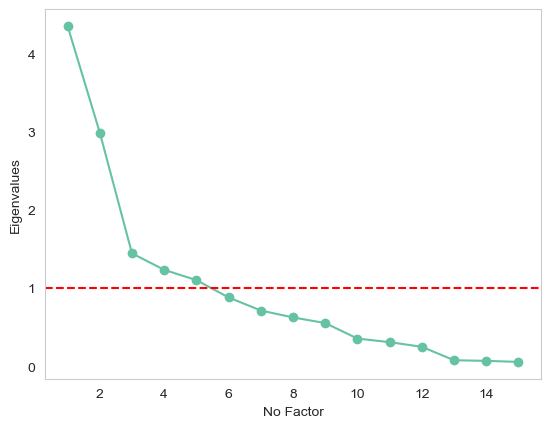

In [ ]:
# determine number of factors
efa_factor(df_1)

principal + varimax


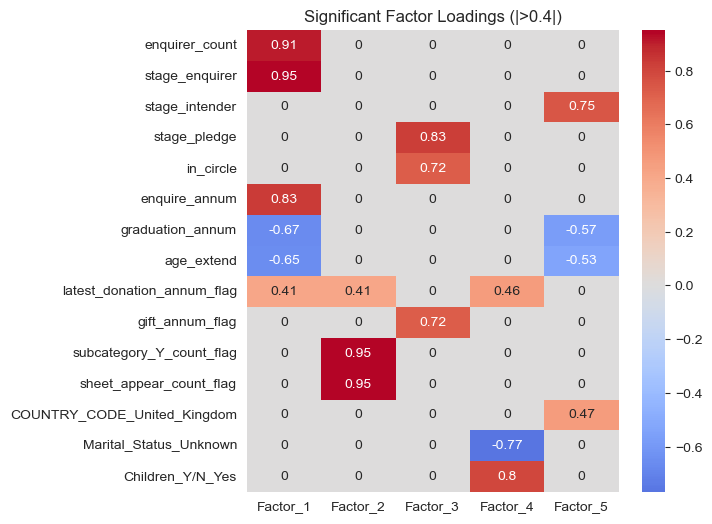

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.86
stage_enquirer                      0.92
stage_intender                      0.65
stage_pledge                        0.77
in_circle                           0.58
enquire_annum                       0.73
graduation_annum                    0.82
age_extend                          0.79
latest_donation_annum_flag          0.73
gift_annum_flag                     0.52
subcategory_Y_count_flag            0.95
sheet_appear_count_flag             0.94
COUNTRY_CODE_United_Kingdom         0.56
Marital_Status_Unknown              0.65
Children_Y/N_Yes                    0.64

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               29.00                29.00
1    Factor 2               19.92                48.92
2    Factor 3                9.62                58.54
3    Factor 4                8.22                66.76
4    Factor 5                7.34                74.10
5    Factor 6                5.87                79.97
6    Factor 7                4.75                84.72
7    Factor 8                4.16                88.88
8    Factor 9                3.68                92.57
9   Factor 10                2.36                94.93
10  Factor 11                2.06                96.99
11  Factor 12                1.66                98.65
12  Factor 13                0.51                99.16
13  Factor 14                0.47                99.63
14  Factor 15                0.37               100.00



principal + promax


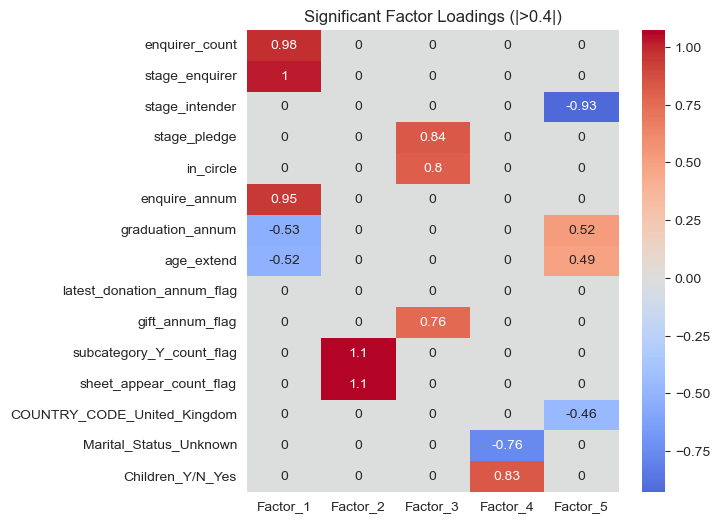

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      1.03
stage_enquirer                      1.10
stage_intender                      1.09
stage_pledge                        0.73
in_circle                           0.74
enquire_annum                       1.01
graduation_annum                    0.61
age_extend                          0.62
latest_donation_annum_flag          0.38
gift_annum_flag                     0.59
subcategory_Y_count_flag            1.18
sheet_appear_count_flag             1.15
COUNTRY_CODE_United_Kingdom         0.39
Marital_Status_Unknown              0.59
Children_Y/N_Yes                    0.70

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               29.00                29.00
1    Factor 2               19.92                48.92
2    Factor 3                9.62                58.54
3    Factor 4                8.22                66.76
4    Factor 5                7.34                74.10
5    Factor 6                5.87                79.97
6    Factor 7                4.75                84.72
7    Factor 8                4.16                88.88
8    Factor 9                3.68                92.57
9   Factor 10                2.36                94.93
10  Factor 11                2.06                96.99
11  Factor 12                1.66                98.65
12  Factor 13                0.51                99.16
13  Factor 14                0.47                99.63
14  Factor 15                0.37               100.00



minres + varimax


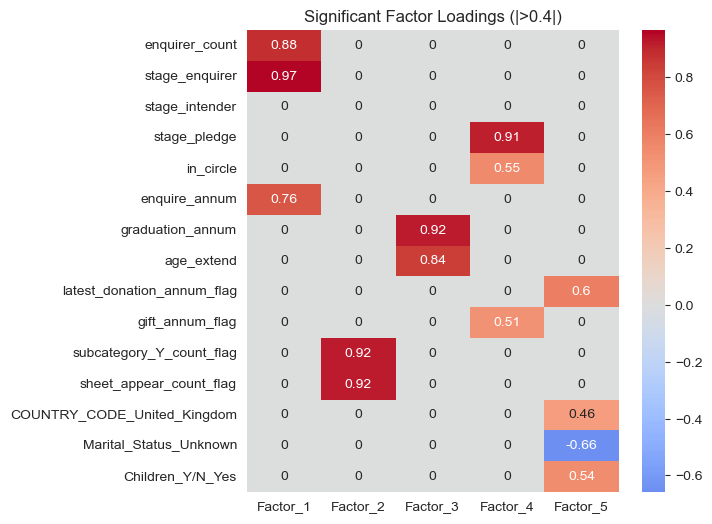

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.86
stage_enquirer                      1.01
stage_intender                      0.12
stage_pledge                        0.90
in_circle                           0.34
enquire_annum                       0.60
graduation_annum                    1.00
age_extend                          0.83
latest_donation_annum_flag          0.71
gift_annum_flag                     0.28
subcategory_Y_count_flag            0.92
sheet_appear_count_flag             0.94
COUNTRY_CODE_United_Kingdom         0.37
Marital_Status_Unknown              0.46
Children_Y/N_Yes                    0.30

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               29.00                29.00
1    Factor 2               19.92                48.92
2    Factor 3                9.62                58.54
3    Factor 4                8.22                66.76
4    Factor 5                7.34                74.10
5    Factor 6                5.87                79.97
6    Factor 7                4.75                84.72
7    Factor 8                4.16                88.88
8    Factor 9                3.68                92.57
9   Factor 10                2.36                94.93
10  Factor 11                2.06                96.99
11  Factor 12                1.66                98.65
12  Factor 13                0.51                99.16
13  Factor 14                0.47                99.63
14  Factor 15                0.37               100.00



minres + promax


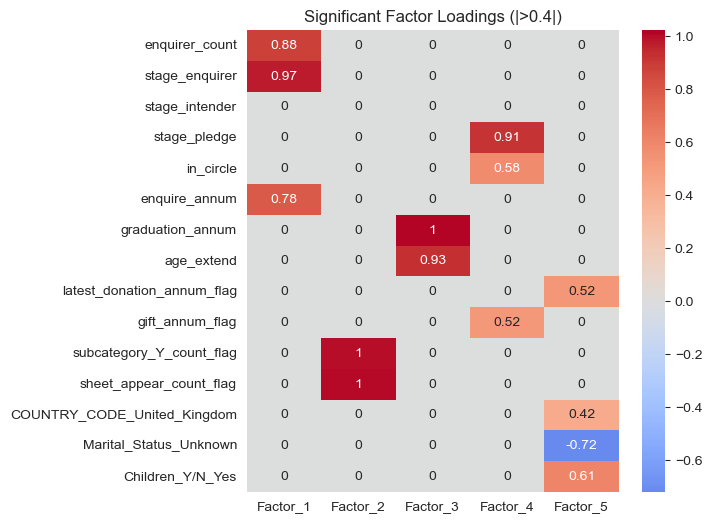

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.79
stage_enquirer                      0.96
stage_intender                      0.14
stage_pledge                        0.86
in_circle                           0.36
enquire_annum                       0.63
graduation_annum                    1.06
age_extend                          0.91
latest_donation_annum_flag          0.42
gift_annum_flag                     0.27
subcategory_Y_count_flag            1.01
sheet_appear_count_flag             1.01
COUNTRY_CODE_United_Kingdom         0.25
Marital_Status_Unknown              0.54
Children_Y/N_Yes                    0.40

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               29.00                29.00
1    Factor 2               19.92                48.92
2    Factor 3                9.62                58.54
3    Factor 4                8.22                66.76
4    Factor 5                7.34                74.10
5    Factor 6                5.87                79.97
6    Factor 7                4.75                84.72
7    Factor 8                4.16                88.88
8    Factor 9                3.68                92.57
9   Factor 10                2.36                94.93
10  Factor 11                2.06                96.99
11  Factor 12                1.66                98.65
12  Factor 13                0.51                99.16
13  Factor 14                0.47                99.63
14  Factor 15                0.37               100.00

In [ ]:
fit_efa(df_1, 5)

Issues:
- minres + promax: communities > 1
- minres + promax communities <= 0.3: gift_annum_flag, stage_intender
- minres + promax loadings >= 1: stage_enquirer, graduation_annum, age_extend, sheet_appear_count_flag

Reduced model: `age_extend`

KMO value: 0.722
Bartlett p-value: 0.000
                      Variable        VIF
1               stage_enquirer  14.128845
0               enquirer_count   9.975355
5      sheet_appear_count_flag   8.887168
4     subcategory_Y_count_flag   8.621086
3                   age_extend   4.513149
2                enquire_annum   3.470469
7            previous_donation   3.302838
8                       family   3.216037
6  COUNTRY_CODE_United_Kingdom   2.319930
9                     pipeline   2.246267
Number of factors based on Kaiser: 3


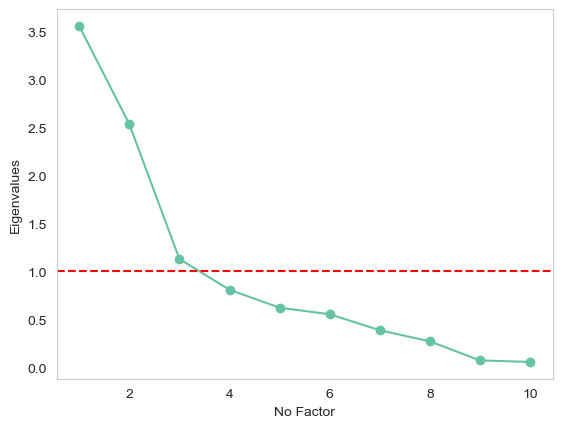

In [ ]:
# combine and remove variables
df_5 = df_1.copy().drop(columns = ['graduation_annum'])

df_5['previous_donation'] = (df_5['gift_annum_flag'] + df_5['latest_donation_annum_flag'])
df_5['family'] = (df_5['Children_Y/N_Yes'] - df_5['Marital_Status_Unknown'])
df_5['pipeline'] = (df_5['stage_intender'] + df_5['stage_pledge'] + df_5['in_circle'])

df_5 = df_5.drop(columns = ['Children_Y/N_Yes', 'gift_annum_flag', 'Marital_Status_Unknown', 'latest_donation_annum_flag',
                            'stage_intender', 'stage_pledge', 'in_circle'])

check_efa(df_5)
efa_factor(df_5)

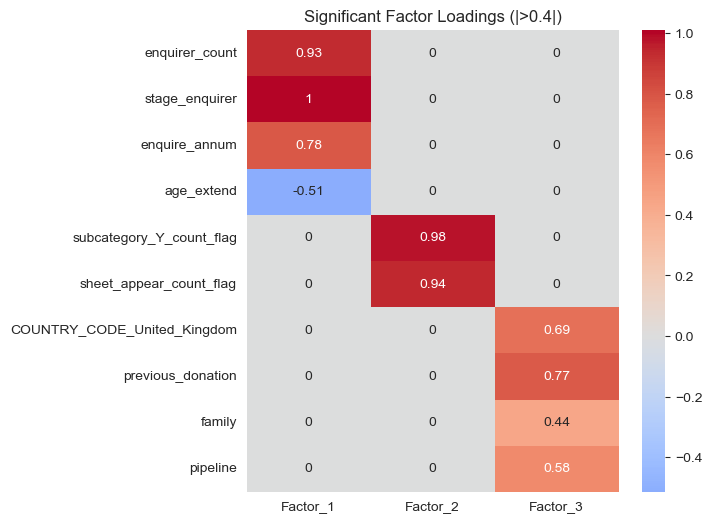

Number of factors based on Kaiser: 3

communalities:
                             Communality
enquirer_count                      0.87
stage_enquirer                      1.03
enquire_annum                       0.64
age_extend                          0.28
subcategory_Y_count_flag            0.97
sheet_appear_count_flag             0.88
COUNTRY_CODE_United_Kingdom         0.50
previous_donation                   0.65
family                              0.19
pipeline                            0.39

Explained variance:


Factor  Variance Explained  Cumulative Variance
0   Factor 1               35.62                35.62
1   Factor 2               25.38                61.00
2   Factor 3               11.30                72.30
3   Factor 4                8.09                80.39
4   Factor 5                6.22                86.61
5   Factor 6                5.54                92.15
6   Factor 7                3.87                96.01
7   Factor 8                2.71                98.72
8   Factor 9                0.72                99.44
9  Factor 10                0.56               100.00

Factor 1 Determinacy Coefficient: 0.652
Factor 2 Determinacy Coefficient: 0.472
Factor 3 Determinacy Coefficient: 0.385


In [ ]:
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='promax')
efa.fit(df_5)
ev = efa.get_eigenvalues()[0]
efa_results(efa.loadings_, efa.get_communalities(), 3, df_5, ev)
for i in range(efa.loadings_.shape[1]):
    ss_loadings = np.sum(efa.loadings_[:, i]**2)
    certainty = 1 - (1 / ss_loadings)
    print(f"Factor {i+1} Determinacy Coefficient: {certainty:.3f}")

KMO value: 0.711
Bartlett p-value: 0.000
                      Variable        VIF
1               stage_enquirer  14.063244
0               enquirer_count   9.969376
5      sheet_appear_count_flag   8.878187
4     subcategory_Y_count_flag   8.586805
2                enquire_annum   3.468822
7            previous_donation   3.089417
6  COUNTRY_CODE_United_Kingdom   2.316993
8                     pipeline   2.245495
3                   age_extend   1.938404
Number of factors based on Kaiser: 3


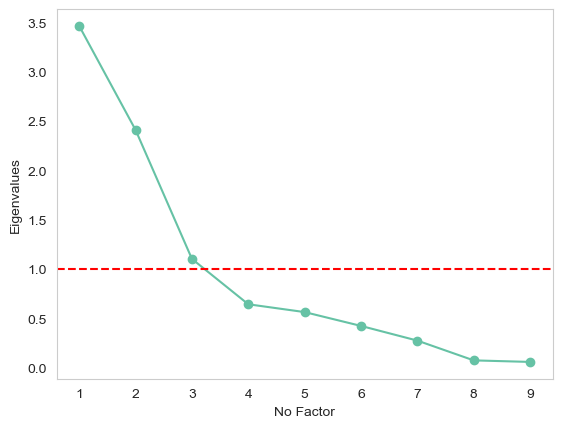

In [ ]:
# remove family
df_6 = df_5.copy().drop(columns = ['family'])
check_efa(df_6)
efa_factor(df_6)

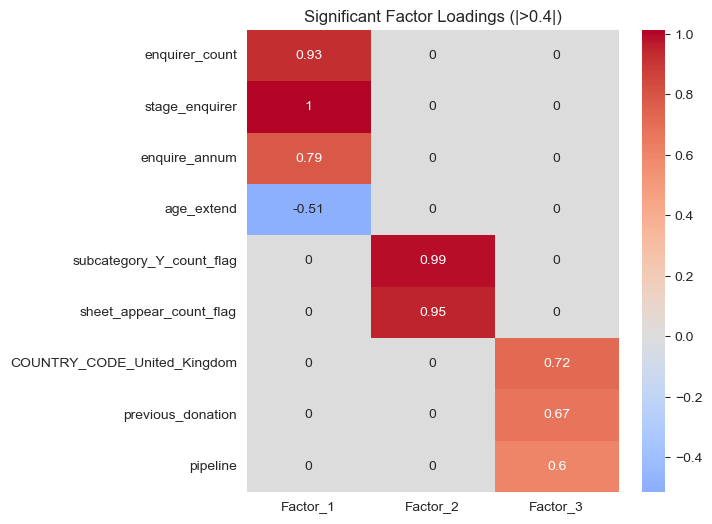

Number of factors based on Kaiser: 3

communalities:
                             Communality
enquirer_count                      0.87
stage_enquirer                      1.03
enquire_annum                       0.65
age_extend                          0.28
subcategory_Y_count_flag            0.98
sheet_appear_count_flag             0.91
COUNTRY_CODE_United_Kingdom         0.53
previous_donation                   0.51
pipeline                            0.42

Explained variance:


Factor  Variance Explained  Cumulative Variance
0  Factor 1               38.50                38.50
1  Factor 2               26.77                65.27
2  Factor 3               12.24                77.51
3  Factor 4                7.12                84.63
4  Factor 5                6.24                90.87
5  Factor 6                4.68                95.55
6  Factor 7                3.03                98.58
7  Factor 8                0.80                99.38
8  Factor 9                0.62               100.00

Factor 1 Determinacy Coefficient: 0.654
Factor 2 Determinacy Coefficient: 0.484
Factor 3 Determinacy Coefficient: 0.268


In [ ]:
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='promax')
efa.fit(df_6)
ev = efa.get_eigenvalues()[0]
efa_results(efa.loadings_, efa.get_communalities(), 3, df_6, ev)
for i in range(efa.loadings_.shape[1]):
    ss_loadings = np.sum(efa.loadings_[:, i]**2)
    certainty = 1 - (1 / ss_loadings)
    print(f"Factor {i+1} Determinacy Coefficient: {certainty:.3f}")

`age_group`

In [ ]:
df_2 = train_data.copy().drop(columns = ['age_extend', 'Children_Y/N_Unknown', 'COUNTRY_CODE_Unknown', 'in_active'])
check_efa(df_2)

KMO value: 0.732
Bartlett p-value: 0.000
                       Variable        VIF
6              graduation_annum  25.528270
7                     age_group  19.977181
1                stage_enquirer  14.508993
0                enquirer_count  10.057967
11      sheet_appear_count_flag   9.237148
10     subcategory_Y_count_flag   8.768288
13       Marital_Status_Unknown   6.470399
8    latest_donation_annum_flag   4.222732
5                 enquire_annum   3.511205
3                  stage_pledge   2.892356
12  COUNTRY_CODE_United_Kingdom   2.645730
4                     in_circle   2.356216
9               gift_annum_flag   1.451514
14             Children_Y/N_Yes   1.386577
2                stage_intender   1.320800


/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Number of factors based on Kaiser: 5


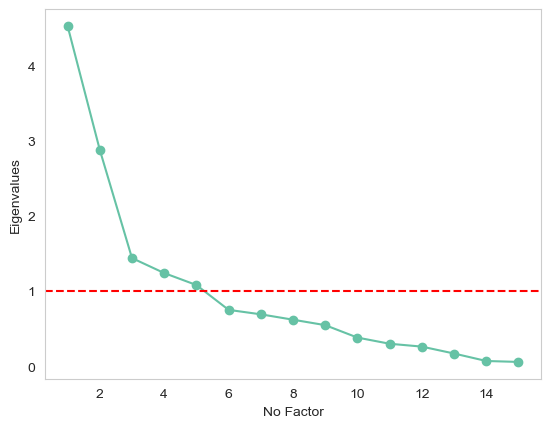

In [ ]:
# number of factors
efa_factor(df_2)

principal + varimax


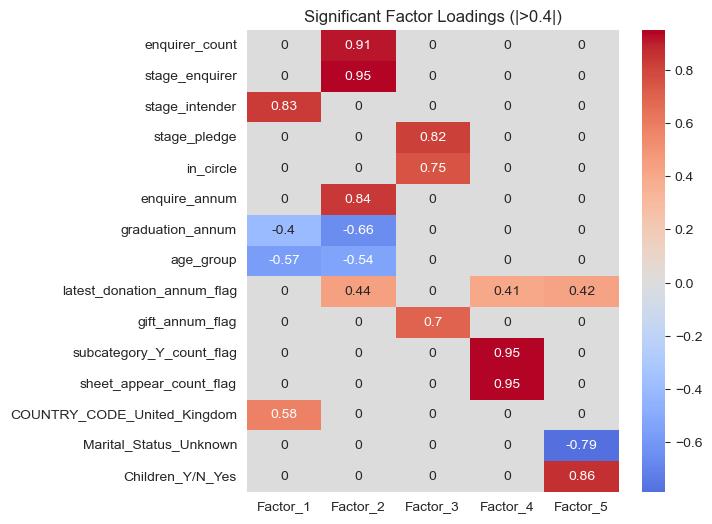

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.87
stage_enquirer                      0.92
stage_intender                      0.75
stage_pledge                        0.76
in_circle                           0.60
enquire_annum                       0.72
graduation_annum                    0.63
age_group                           0.75
latest_donation_annum_flag          0.74
gift_annum_flag                     0.50
subcategory_Y_count_flag            0.94
sheet_appear_count_flag             0.95
COUNTRY_CODE_United_Kingdom         0.60
Marital_Status_Unknown              0.69
Children_Y/N_Yes                    0.74

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               30.19                30.19
1    Factor 2               19.20                49.39
2    Factor 3                9.59                58.98
3    Factor 4                8.26                67.24
4    Factor 5                7.20                74.44
5    Factor 6                4.99                79.43
6    Factor 7                4.60                84.03
7    Factor 8                4.12                88.15
8    Factor 9                3.64                91.79
9   Factor 10                2.53                94.33
10  Factor 11                1.99                96.31
11  Factor 12                1.73                98.05
12  Factor 13                1.12                99.17
13  Factor 14                0.46                99.62
14  Factor 15                0.38               100.00



principal + promax


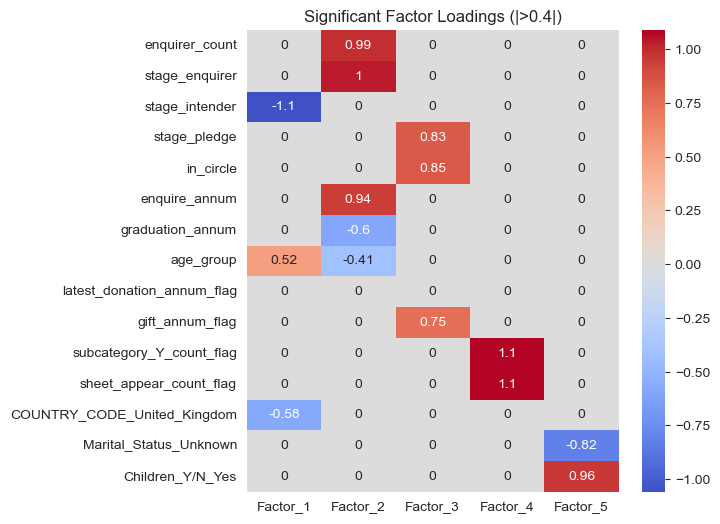

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      1.05
stage_enquirer                      1.12
stage_intender                      1.37
stage_pledge                        0.73
in_circle                           0.79
enquire_annum                       0.97
graduation_annum                    0.50
age_group                           0.47
latest_donation_annum_flag          0.32
gift_annum_flag                     0.57
subcategory_Y_count_flag            1.21
sheet_appear_count_flag             1.18
COUNTRY_CODE_United_Kingdom         0.43
Marital_Status_Unknown              0.68
Children_Y/N_Yes                    0.95

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               30.19                30.19
1    Factor 2               19.20                49.39
2    Factor 3                9.59                58.98
3    Factor 4                8.26                67.24
4    Factor 5                7.20                74.44
5    Factor 6                4.99                79.43
6    Factor 7                4.60                84.03
7    Factor 8                4.12                88.15
8    Factor 9                3.64                91.79
9   Factor 10                2.53                94.33
10  Factor 11                1.99                96.31
11  Factor 12                1.73                98.05
12  Factor 13                1.12                99.17
13  Factor 14                0.46                99.62
14  Factor 15                0.38               100.00



minres + varimax


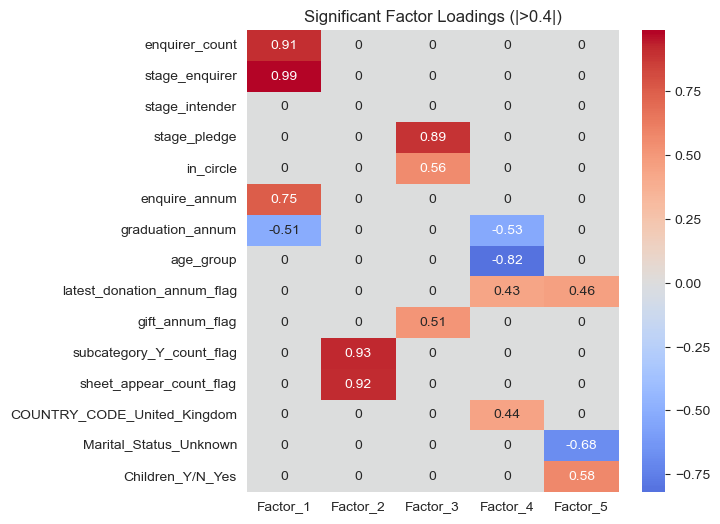

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.86
stage_enquirer                      1.01
stage_intender                      0.18
stage_pledge                        0.87
in_circle                           0.35
enquire_annum                       0.58
graduation_annum                    0.56
age_group                           0.90
latest_donation_annum_flag          0.71
gift_annum_flag                     0.28
subcategory_Y_count_flag            0.93
sheet_appear_count_flag             0.93
COUNTRY_CODE_United_Kingdom         0.41
Marital_Status_Unknown              0.52
Children_Y/N_Yes                    0.35

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               30.19                30.19
1    Factor 2               19.20                49.39
2    Factor 3                9.59                58.98
3    Factor 4                8.26                67.24
4    Factor 5                7.20                74.44
5    Factor 6                4.99                79.43
6    Factor 7                4.60                84.03
7    Factor 8                4.12                88.15
8    Factor 9                3.64                91.79
9   Factor 10                2.53                94.33
10  Factor 11                1.99                96.31
11  Factor 12                1.73                98.05
12  Factor 13                1.12                99.17
13  Factor 14                0.46                99.62
14  Factor 15                0.38               100.00



minres + promax


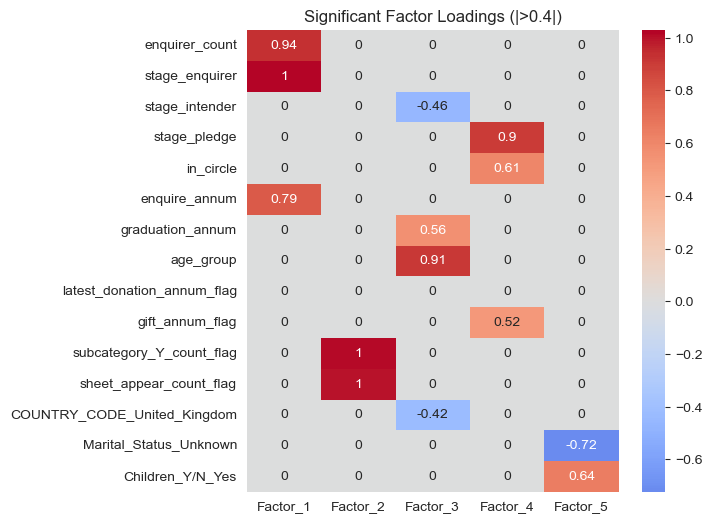

Number of factors based on Kaiser: 5

communalities:
                             Communality
enquirer_count                      0.90
stage_enquirer                      1.08
stage_intender                      0.29
stage_pledge                        0.83
in_circle                           0.41
enquire_annum                       0.65
graduation_annum                    0.49
age_group                           0.92
latest_donation_annum_flag          0.32
gift_annum_flag                     0.27
subcategory_Y_count_flag            1.03
sheet_appear_count_flag             1.01
COUNTRY_CODE_United_Kingdom         0.26
Marital_Status_Unknown              0.53
Children_Y/N_Yes                    0.41

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               30.19                30.19
1    Factor 2               19.20                49.39
2    Factor 3                9.59                58.98
3    Factor 4                8.26                67.24
4    Factor 5                7.20                74.44
5    Factor 6                4.99                79.43
6    Factor 7                4.60                84.03
7    Factor 8                4.12                88.15
8    Factor 9                3.64                91.79
9   Factor 10                2.53                94.33
10  Factor 11                1.99                96.31
11  Factor 12                1.73                98.05
12  Factor 13                1.12                99.17
13  Factor 14                0.46                99.62
14  Factor 15                0.38               100.00

In [ ]:
fit_efa(df_2, 5)

Issues:
- minres + promax: communities > 1
- minres + promax communities <= 0.3: gift_annum_flag
- minres + promax loadings >= 1: stage_enquirer, stage_pledge, subcategory_Y_count_flag

Reduced model: `age_group`

KMO value: 0.742
Bartlett p-value: 0.000
                      Variable        VIF
1               stage_enquirer  14.128562
0               enquirer_count   9.989625
5      sheet_appear_count_flag   8.907452
4     subcategory_Y_count_flag   8.635309
2                enquire_annum   3.469496
7            previous_donation   3.183175
3                    age_group   3.171784
8                       family   3.153932
6  COUNTRY_CODE_United_Kingdom   2.295913
9                     pipeline   2.138400
Number of factors based on Kaiser: 3


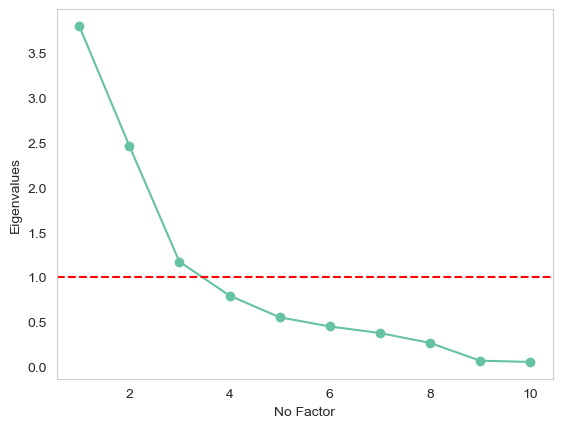

In [ ]:
# combine and remove variables
df_3 = df_2.copy().drop(columns = ['graduation_annum'])

df_3['previous_donation'] = (df_3['gift_annum_flag'] + df_3['latest_donation_annum_flag'])
df_3['family'] = (df_3['Children_Y/N_Yes'] - df_3['Marital_Status_Unknown'])
df_3['pipeline'] = (df_3['stage_intender'] + df_3['stage_pledge'] + df_3['in_circle'])

df_3 = df_3.drop(columns = ['Children_Y/N_Yes', 'Marital_Status_Unknown', 'latest_donation_annum_flag', 'gift_annum_flag',
                            'in_circle', 'stage_intender', 'stage_pledge', 'in_circle' ])

check_efa(df_3)
efa_factor(df_3)

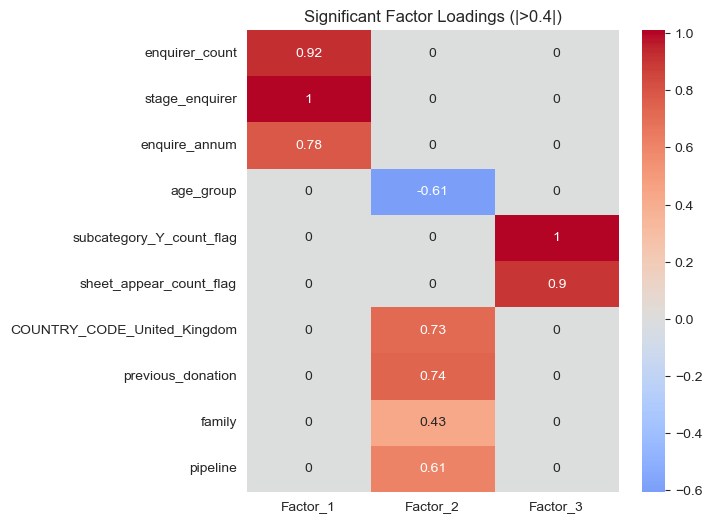

Number of factors based on Kaiser: 3

communalities:
                             Communality
enquirer_count                      0.86
stage_enquirer                      1.01
enquire_annum                       0.63
age_group                           0.48
subcategory_Y_count_flag            1.02
sheet_appear_count_flag             0.81
COUNTRY_CODE_United_Kingdom         0.53
previous_donation                   0.57
family                              0.19
pipeline                            0.46

Explained variance:


Factor  Variance Explained  Cumulative Variance
0   Factor 1               37.92                37.92
1   Factor 2               24.60                62.51
2   Factor 3               11.71                74.23
3   Factor 4                7.95                82.18
4   Factor 5                5.54                87.72
5   Factor 6                4.52                92.23
6   Factor 7                3.79                96.02
7   Factor 8                2.69                98.71
8   Factor 9                0.71                99.43
9  Factor 10                0.57               100.00

Factor 1 Determinacy Coefficient: 0.629
Factor 2 Determinacy Coefficient: 0.502
Factor 3 Determinacy Coefficient: 0.466


In [ ]:
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='promax')
efa.fit(df_3)
ev = efa.get_eigenvalues()[0]
efa_results(efa.loadings_, efa.get_communalities(), 3, df_3, ev)
for i in range(efa.loadings_.shape[1]):
    ss_loadings = np.sum(efa.loadings_[:, i]**2)
    certainty = 1 - (1 / ss_loadings)
    print(f"Factor {i+1} Determinacy Coefficient: {certainty:.3f}")

KMO value: 0.728
Bartlett p-value: 0.000
                      Variable        VIF
1               stage_enquirer  14.058838
0               enquirer_count   9.970061
5      sheet_appear_count_flag   8.877794
4     subcategory_Y_count_flag   8.584269
2                enquire_annum   3.469096
7            previous_donation   3.076589
6  COUNTRY_CODE_United_Kingdom   2.290107
8                     pipeline   2.108326
3                    age_group   1.389111
Number of factors based on Kaiser: 3


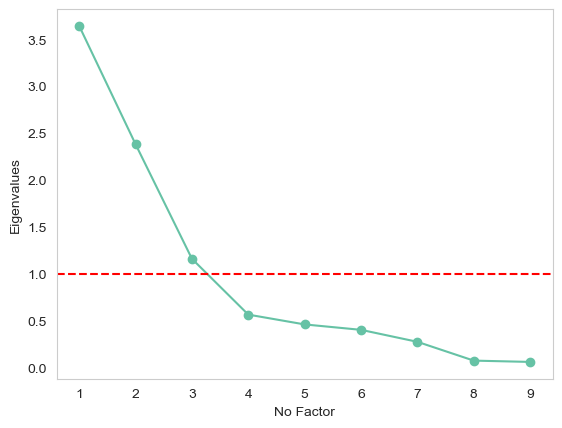

In [ ]:
# remove family
df_4 = df_3.copy().drop(columns = ['family'])
check_efa(df_4)
efa_factor(df_4)

In [ ]:
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='promax')
efa.fit(df_4)
ev = efa.get_eigenvalues()[0]
efa_results(efa.loadings_, efa.get_communalities(), 3, df_4, ev)
for i in range(efa.loadings_.shape[1]):
    ss_loadings = np.sum(efa.loadings_[:, i]**2)
    certainty = 1 - (1 / ss_loadings)
    print(f"Factor {i+1} Determinacy Coefficient: {certainty:.3f}")

### 2.1.3 CFA on Potential Donors
- use results in EFA: df_4 (age_group)

In [ ]:
# refit final EFA model
## age_group
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='promax')
efa.fit(df_4)
loadings = pd.DataFrame(efa.loadings_,
                       index=df_4.columns,
                       columns=[f'Factor_{i}' for i in range(1, 4)])

significant_loadings = loadings[abs(loadings) > 0.4].dropna(how='all')
factor_struc_1 = {}
for factor in significant_loadings.columns:
    vars = significant_loadings.index[significant_loadings[factor].notna()].tolist()
    factor_struc_1[factor] = vars

In [ ]:
factor_struc_1

{'Factor_1': ['enquirer_count', 'stage_enquirer', 'enquire_annum'],
 'Factor_2': ['subcategory_Y_count_flag', 'sheet_appear_count_flag'],
 'Factor_3': ['age_group',
  'COUNTRY_CODE_United_Kingdom',
  'previous_donation',
  'pipeline']}

In [ ]:
# define CFA model
cfa_1 = """
F1 =~ enquirer_count + stage_enquirer + enquire_annum
F2 =~ subcategory_Y_count_flag + sheet_appear_count_flag
F3 =~ age_group + COUNTRY_CODE_United_Kingdom + previous_donation + pipeline

F1 ~~ F2
F2 ~~ F3
F1 ~~ F3
"""

# test data
test_df_1 = test_data.copy().drop(columns = ['graduation_annum', 'age_extend', 'Children_Y/N_Unknown', 'COUNTRY_CODE_Unknown', 'in_active'])
test_df_1['previous_donation'] = (test_df_1['gift_annum_flag'] + test_df_1['latest_donation_annum_flag'])
test_df_1['family'] = (test_df_1['Children_Y/N_Yes'] - test_df_1['Marital_Status_Unknown'])
test_df_1['pipeline'] = (test_df_1['stage_intender'] + test_df_1['stage_pledge'] + test_df_1['in_circle'])
test_df_1 = test_df_1.drop(columns = ['Children_Y/N_Yes', 'Marital_Status_Unknown', 'latest_donation_annum_flag', 'gift_annum_flag',
                            'in_circle', 'stage_intender', 'stage_pledge', 'in_circle', 'family'])

In [ ]:
# apply on test set
cfa_model_1 = Model(cfa_1)
loss = cfa_model_1.fit(test_df_1)

In [ ]:
# evaluation metrics
fi = calc_stats(cfa_model_1)
if isinstance(fi, pd.Series):
    stats = fi
elif isinstance(fi, pd.DataFrame):
    if "Value" in fi.columns:
        stats = fi["Value"]
    elif 0 in fi.index:
        stats = fi.loc[0]
    elif fi.shape[1] == 1:
        stats = fi.iloc[:, 0]
    else:
        stats = fi.squeeze()
else:
    raise TypeError("Unexpected calc_stats return type:", type(fi))

chi2  = float(stats.get("chi2", np.nan))
dof   = float(stats.get("DoF", np.nan))
cfi   = float(stats.get("CFI", np.nan))
rmsea = float(stats.get("RMSEA", np.nan))
aic   = float(stats.get("AIC", np.nan))
bic   = float(stats.get("BIC", np.nan))

# CFI
if not np.isfinite(cfi):
    chi2_base = float(stats.get("chi2 Baseline", np.nan))
    dof_base  = float(stats.get("DoF Baseline", np.nan))
    num = max(chi2 - dof, 0.0) if np.isfinite(chi2) and np.isfinite(dof) else np.nan
    den = max(chi2_base - dof_base, 0.0) if np.isfinite(chi2_base) and np.isfinite(dof_base) else np.nan
    cfi = 1.0 - (num / den) if np.isfinite(num) and np.isfinite(den) and den > 0 else np.nan

# rmsea
if not np.isfinite(rmsea):
    try:

        est = cfa_model_1.inspect(std_est=False)
        obs_cols = sorted(est.loc[est["op"]=="=~","rval"].unique().tolist())
        N_eff = int(test_df_1[obs_cols].dropna().shape[0])
    except Exception:
        N_eff = int(test_df_1.shape[0])
    if np.isfinite(chi2) and np.isfinite(dof) and N_eff > 1 and dof > 0:
        rmsea = np.sqrt(max((chi2 - dof) / (dof * (N_eff - 1)), 0.0))
    else:
        rmsea = np.nan

# chi-square/df
chi2_over_df = (chi2 / dof) if np.isfinite(chi2) and np.isfinite(dof) and dof > 0 else np.nan

print("chi_squared/df:", None if not np.isfinite(chi2_over_df) else round(chi2_over_df, 3))
print("CFI:",           None if not np.isfinite(cfi)          else round(cfi, 3))
print("RMSEA:",         None if not np.isfinite(rmsea)        else round(rmsea, 3))
print("AIC:",           None if not np.isfinite(aic)          else round(aic, 3))
print("BIC:",           None if not np.isfinite(bic)          else round(bic, 3))

chi_squared/df: 6.142
CFI: 0.915
RMSEA: 0.14
AIC: 40.879
BIC: 115.894


### 2.1.4 EFA on Potential Participants

In [ ]:
fa_data_2 = active_alumni_merge.copy()

In [ ]:
# check for missing values
fa_data_2.isna().sum()

Advance ID                          0
Marital Status                      0
AGE                              4016
Children Y/N                        0
Alumni Relationship Manager    192021
COUNTRY                             0
Degree                              0
label                               0
graduation_annum                   75
age_extend                         29
latest_donation_annum_flag          0
subcategory_Y_count_flag            0
sheet_appear_count_flag             0
dtype: int64

In [ ]:
# encoding variables
## categorical columns
fa_data_2 = pd.get_dummies(fa_data_2, columns=['COUNTRY', 'Marital Status', 'Degree'], drop_first=True)

## boolean columns
fa_data_2['Alumni Relationship Manager'] = fa_data_2['Alumni Relationship Manager'].fillna('N')

fa_data_2 = fa_data_2.replace({
    True: 1,
    False: 0,
    'Y': 1,
    'Yes': 1,
    'N': 0
})

/var/folders/rc/1lcxmqw11fv119wgk5h7ldwh0000gn/T/ipykernel_99849/4133030293.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fa_data_2 = fa_data_2.replace({
/var/folders/rc/1lcxmqw11fv119wgk5h7ldwh0000gn/T/ipykernel_99849/4133030293.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fa_data_2 = fa_data_2.replace({


In [ ]:
for col in ['graduation_annum', 'age_extend']:
    fa_data_2[col] = fa_data_2.groupby('label')[col].transform(
        lambda x: x.fillna(round(x.median()))
    )
fa_data_2['graduation_annum'] = fa_data_2['graduation_annum'].astype(int)
fa_data_2['age_extend'] = fa_data_2['age_extend'].astype(int)

In [ ]:
fa_data_2 = fa_data_2.drop(columns = ['label', 'AGE', 'Advance ID'])
fa_data_2.columns = fa_data_2.columns.str.replace(' ', '_')

In [ ]:
fa_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192157 entries, 0 to 192156
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Children_Y/N                        192157 non-null  int64
 1   Alumni_Relationship_Manager         192157 non-null  int64
 2   graduation_annum                    192157 non-null  int64
 3   age_extend                          192157 non-null  int64
 4   latest_donation_annum_flag          192157 non-null  int64
 5   subcategory_Y_count_flag            192157 non-null  int64
 6   sheet_appear_count_flag             192157 non-null  int64
 7   COUNTRY_People's_Republic_of_China  192157 non-null  int64
 8   COUNTRY_USA                         192157 non-null  int64
 9   COUNTRY_United_Kingdom              192157 non-null  int64
 10  COUNTRY_Unknown                     192157 non-null  int64
 11  Marital_Status_Unknown              192157 non-null 

In [ ]:
# split train and test
train_data_2, test_data_2 = train_test_split(fa_data_2, test_size=0.3, random_state=101)

In [ ]:
check_efa(fa_data_2)

/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO value: 0.353
Bartlett p-value: 0.000
                              Variable        VIF
3                           age_extend  77.996138
2                     graduation_annum  27.420981
14                 Degree_Postgraduate  22.956075
11              Marital_Status_Unknown  17.307027
15                Degree_Undergraduate   9.605260
13                        Degree_Other   4.032823
16                      Degree_Unknown   3.086499
9               COUNTRY_United_Kingdom   1.997385
6              sheet_appear_count_flag   1.896716
5             subcategory_Y_count_flag   1.848734
0                         Children_Y/N   1.396495
8                          COUNTRY_USA   1.353457
4           latest_donation_annum_flag   1.312537
12                    Degree_Doctorate   1.225015
7   COUNTRY_People's_Republic_of_China   1.205717
10                     COUNTRY_Unknown   1.178316
1          Alumni_Relationship_Manager   1.019545


In [ ]:
check_efa(train_data_2)

/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO value: 0.353
Bartlett p-value: 0.000
                              Variable        VIF
3                           age_extend  78.128500
2                     graduation_annum  27.484166
14                 Degree_Postgraduate  22.953090
11              Marital_Status_Unknown  17.323565
15                Degree_Undergraduate   9.610916
13                        Degree_Other   4.062449
16                      Degree_Unknown   3.091810
9               COUNTRY_United_Kingdom   1.997218
6              sheet_appear_count_flag   1.885340
5             subcategory_Y_count_flag   1.837837
0                         Children_Y/N   1.404103
8                          COUNTRY_USA   1.357601
4           latest_donation_annum_flag   1.309637
12                    Degree_Doctorate   1.228990
7   COUNTRY_People's_Republic_of_China   1.207641
10                     COUNTRY_Unknown   1.178906
1          Alumni_Relationship_Manager   1.020117


In [ ]:
check_efa(test_data_2)

/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO value: 0.353
Bartlett p-value: 0.000
                              Variable        VIF
3                           age_extend  77.713917
2                     graduation_annum  27.283395
14                 Degree_Postgraduate  22.968649
11              Marital_Status_Unknown  17.279324
15                Degree_Undergraduate   9.594527
13                        Degree_Other   3.964800
16                      Degree_Unknown   3.075302
9               COUNTRY_United_Kingdom   1.998294
6              sheet_appear_count_flag   1.924422
5             subcategory_Y_count_flag   1.875449
0                         Children_Y/N   1.379462
8                          COUNTRY_USA   1.344227
4           latest_donation_annum_flag   1.320176
12                    Degree_Doctorate   1.215933
7   COUNTRY_People's_Republic_of_China   1.201330
10                     COUNTRY_Unknown   1.177144
1          Alumni_Relationship_Manager   1.018421


In [ ]:
# remove multicolinear variables
df_7 = train_data_2.copy().drop(columns = ['age_extend'])
check_efa(df_7)

/Users/bubblewhitetea/anaconda3/envs/445hw/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO value: 0.278
Bartlett p-value: 0.000
                              Variable        VIF
10              Marital_Status_Unknown  16.780529
13                 Degree_Postgraduate  13.373847
14                Degree_Undergraduate   7.000140
2                     graduation_annum   3.981684
12                        Degree_Other   2.747741
15                      Degree_Unknown   2.538539
8               COUNTRY_United_Kingdom   1.993302
5              sheet_appear_count_flag   1.885225
4             subcategory_Y_count_flag   1.837764
0                         Children_Y/N   1.391433
7                          COUNTRY_USA   1.357423
3           latest_donation_annum_flag   1.308712
6   COUNTRY_People's_Republic_of_China   1.202559
9                      COUNTRY_Unknown   1.175687
11                    Degree_Doctorate   1.121301
1          Alumni_Relationship_Manager   1.020116


Number of factors based on Kaiser: 8


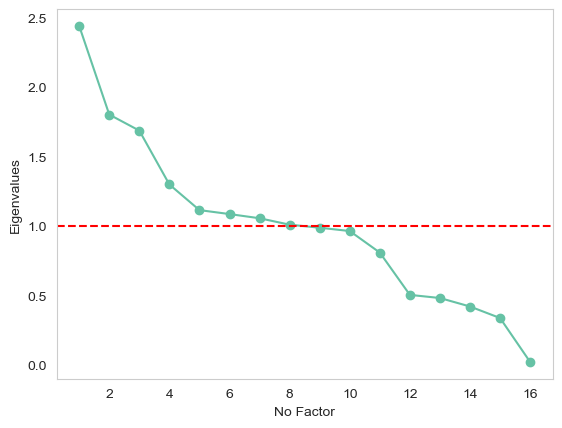

In [ ]:
# number of factors
efa_factor(df_7)

principal + varimax


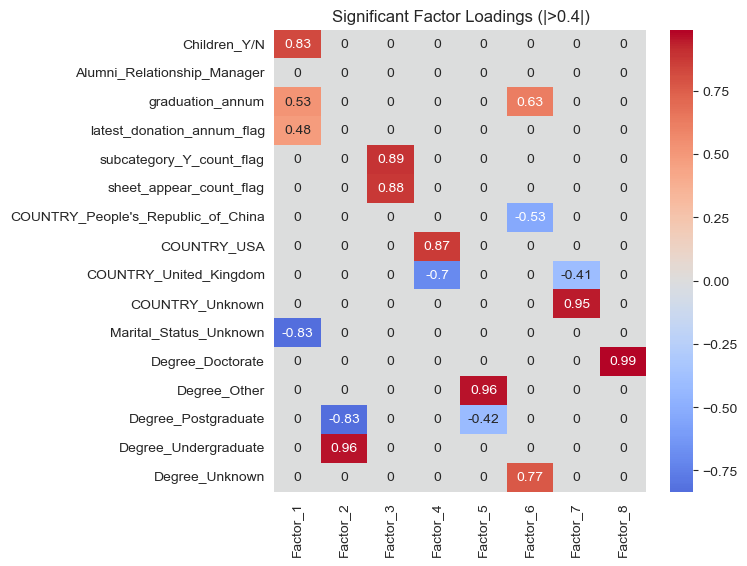

Number of factors based on Kaiser: 8

communalities:
                                    Communality
Children_Y/N                               0.69
Alumni_Relationship_Manager                0.10
graduation_annum                           0.69
latest_donation_annum_flag                 0.36
subcategory_Y_count_flag                   0.80
sheet_appear_count_flag                    0.78
COUNTRY_People's_Republic_of_China         0.37
COUNTRY_USA                                0.83
COUNTRY_United_Kingdom                     0.77
COUNTRY_Unknown                            0.91
Marital_Status_Unknown                     0.70
Degree_Doctorate                           0.99
Degree_Other                               0.93
Degree_Postgraduate                        0.95
Degree_Undergraduate                       0.97
Degree_Unknown                             0.64

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               15.25                15.25
1    Factor 2               11.26                26.51
2    Factor 3               10.54                37.05
3    Factor 4                8.11                45.16
4    Factor 5                6.96                52.12
5    Factor 6                6.78                58.90
6    Factor 7                6.59                65.49
7    Factor 8                6.30                71.79
8    Factor 9                6.17                77.96
9   Factor 10                6.02                83.97
10  Factor 11                5.05                89.02
11  Factor 12                3.14                92.16
12  Factor 13                3.00                95.16
13  Factor 14                2.62                97.78
14  Factor 15                2.10                99.88
15  Factor 16                0.12               100.00



principal + promax


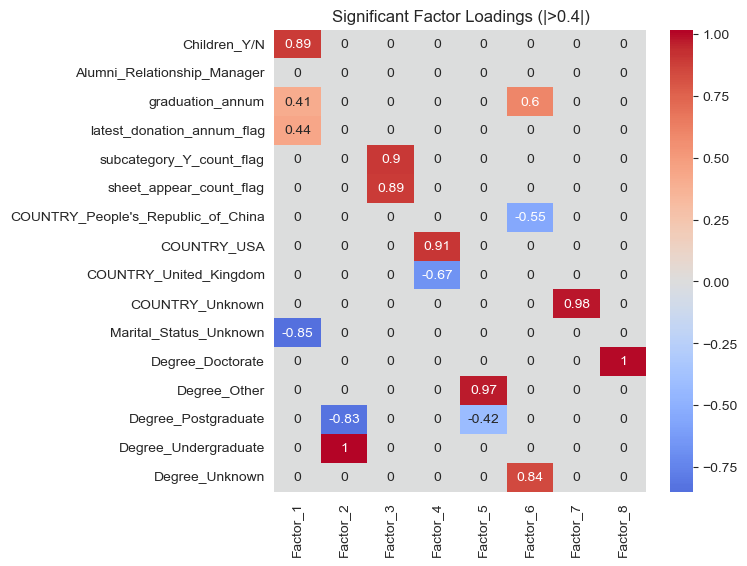

Number of factors based on Kaiser: 8

communalities:
                                    Communality
Children_Y/N                               0.84
Alumni_Relationship_Manager                0.10
graduation_annum                           0.55
latest_donation_annum_flag                 0.27
subcategory_Y_count_flag                   0.83
sheet_appear_count_flag                    0.83
COUNTRY_People's_Republic_of_China         0.39
COUNTRY_USA                                0.92
COUNTRY_United_Kingdom                     0.64
COUNTRY_Unknown                            0.99
Marital_Status_Unknown                     0.73
Degree_Doctorate                           1.02
Degree_Other                               0.96
Degree_Postgraduate                        0.90
Degree_Undergraduate                       1.13
Degree_Unknown                             0.79

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               15.25                15.25
1    Factor 2               11.26                26.51
2    Factor 3               10.54                37.05
3    Factor 4                8.11                45.16
4    Factor 5                6.96                52.12
5    Factor 6                6.78                58.90
6    Factor 7                6.59                65.49
7    Factor 8                6.30                71.79
8    Factor 9                6.17                77.96
9   Factor 10                6.02                83.97
10  Factor 11                5.05                89.02
11  Factor 12                3.14                92.16
12  Factor 13                3.00                95.16
13  Factor 14                2.62                97.78
14  Factor 15                2.10                99.88
15  Factor 16                0.12               100.00



minres + varimax


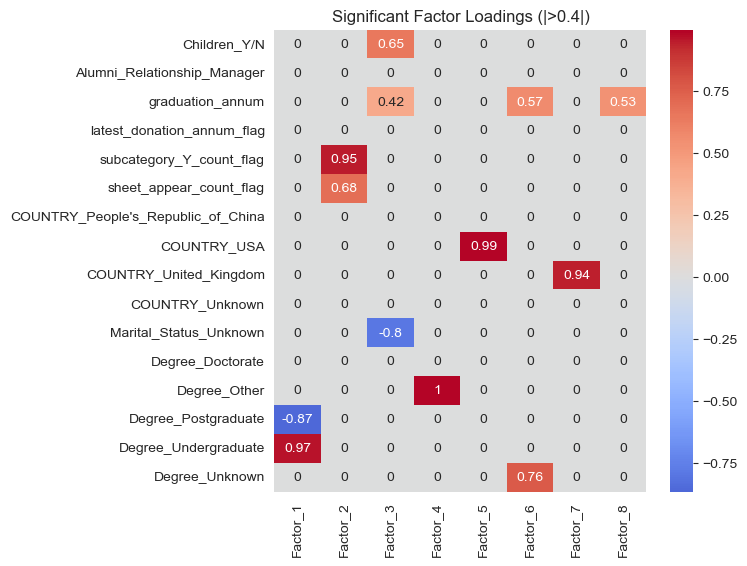

Number of factors based on Kaiser: 8

communalities:
                                    Communality
Children_Y/N                               0.42
Alumni_Relationship_Manager                0.02
graduation_annum                           0.80
latest_donation_annum_flag                 0.20
subcategory_Y_count_flag                   0.91
sheet_appear_count_flag                    0.48
COUNTRY_People's_Republic_of_China         0.09
COUNTRY_USA                                1.00
COUNTRY_United_Kingdom                     1.00
COUNTRY_Unknown                            0.07
Marital_Status_Unknown                     0.65
Degree_Doctorate                           0.01
Degree_Other                               1.00
Degree_Postgraduate                        1.01
Degree_Undergraduate                       1.00
Degree_Unknown                             0.61

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               15.25                15.25
1    Factor 2               11.26                26.51
2    Factor 3               10.54                37.05
3    Factor 4                8.11                45.16
4    Factor 5                6.96                52.12
5    Factor 6                6.78                58.90
6    Factor 7                6.59                65.49
7    Factor 8                6.30                71.79
8    Factor 9                6.17                77.96
9   Factor 10                6.02                83.97
10  Factor 11                5.05                89.02
11  Factor 12                3.14                92.16
12  Factor 13                3.00                95.16
13  Factor 14                2.62                97.78
14  Factor 15                2.10                99.88
15  Factor 16                0.12               100.00



minres + promax


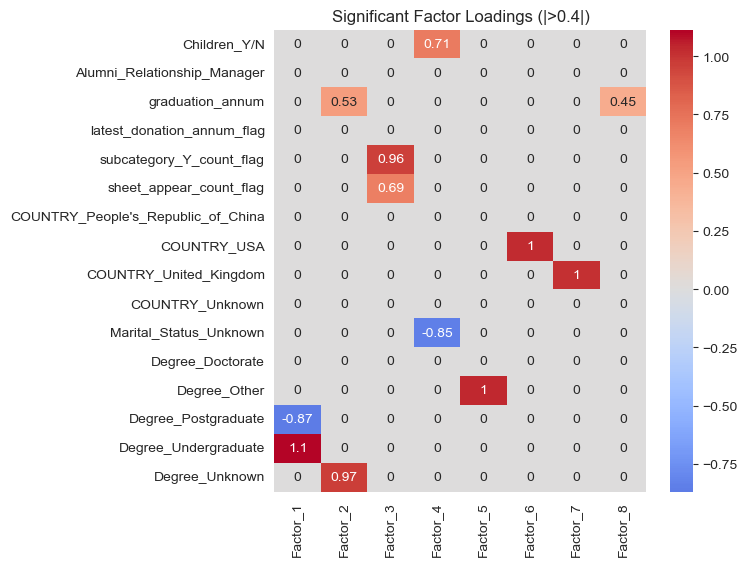

Number of factors based on Kaiser: 8

communalities:
                                    Communality
Children_Y/N                               0.52
Alumni_Relationship_Manager                0.02
graduation_annum                           0.52
latest_donation_annum_flag                 0.10
subcategory_Y_count_flag                   0.91
sheet_appear_count_flag                    0.50
COUNTRY_People's_Republic_of_China         0.06
COUNTRY_USA                                1.08
COUNTRY_United_Kingdom                     1.17
COUNTRY_Unknown                            0.08
Marital_Status_Unknown                     0.72
Degree_Doctorate                           0.02
Degree_Other                               1.14
Degree_Postgraduate                        1.01
Degree_Undergraduate                       1.44
Degree_Unknown                             1.04

Explained variance:


Factor  Variance Explained  Cumulative Variance
0    Factor 1               15.25                15.25
1    Factor 2               11.26                26.51
2    Factor 3               10.54                37.05
3    Factor 4                8.11                45.16
4    Factor 5                6.96                52.12
5    Factor 6                6.78                58.90
6    Factor 7                6.59                65.49
7    Factor 8                6.30                71.79
8    Factor 9                6.17                77.96
9   Factor 10                6.02                83.97
10  Factor 11                5.05                89.02
11  Factor 12                3.14                92.16
12  Factor 13                3.00                95.16
13  Factor 14                2.62                97.78
14  Factor 15                2.10                99.88
15  Factor 16                0.12               100.00

In [ ]:
fit_efa(df_7, 8)

minre + varimax:
- communities <= 0.3: Alumni_Relationship_Manager, latest_donation_annum_flag, COUNTRY_People's_Republic_of_China, Country_Unknown, Degree_Doctorate
- coommunities >= 1: COUNTRY_USA, COUNTRY_United_Kingdom, Degree_Other, Degree_Postgraduate, Degree_Undergraduate

reduced model:

KMO value: 0.553
Bartlett p-value: 0.000
                   Variable        VIF
5         Degree_post_under  17.973301
4    Marital_Status_Unknown  16.473763
6          Degree_new_other   3.990451
1          graduation_annum   3.101379
3   sheet_appear_count_flag   1.882504
2  subcategory_Y_count_flag   1.794024
0              Children_Y/N   1.382597
Number of factors based on Kaiser: 3


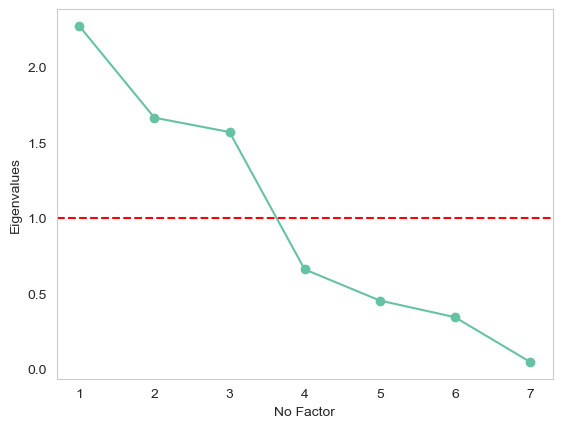

In [ ]:
df_8 = df_7.copy()

#df_8['Country_new_others'] = (df_8["COUNTRY_People's_Republic_of_China"] + df_8['COUNTRY_Unknown'])
#df_8['Country_US_UK'] = (df_8['COUNTRY_USA'] + df_8['COUNTRY_United_Kingdom'])
#df_8['relation'] = (df_8['Alumni_Relationship_Manager'] + df_8['latest_donation_annum_flag'])
df_8['Degree_post_under'] = (df_8['Degree_Undergraduate'] + df_8['Degree_Postgraduate'])
df_8['Degree_new_other'] = (df_8['Degree_Doctorate'] + df_8['Degree_Other'] + df_8['Degree_Unknown'])

df_8 = df_8.drop(columns = ["COUNTRY_People's_Republic_of_China", 'COUNTRY_Unknown', 'COUNTRY_USA', 'COUNTRY_United_Kingdom',
                            'Degree_Undergraduate', 'Degree_Postgraduate', 'Alumni_Relationship_Manager', 'latest_donation_annum_flag',
                            'Degree_Doctorate', 'Degree_Other', 'Degree_Unknown'])

check_efa(df_8)
efa_factor(df_8)

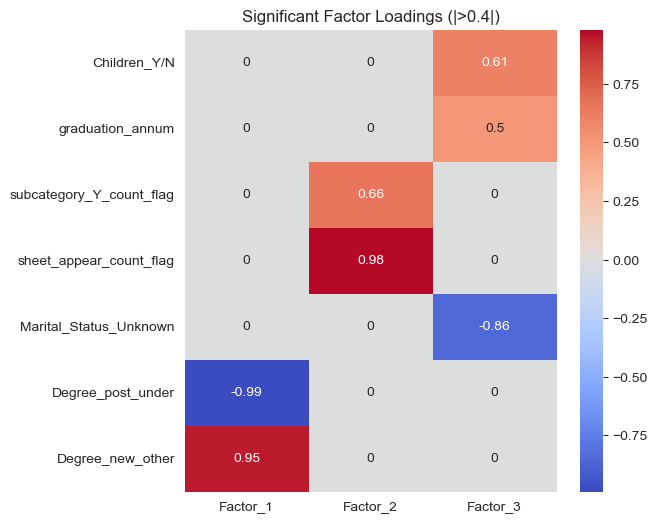

Number of factors based on Kaiser: 3

communalities:
                          Communality
Children_Y/N                     0.37
graduation_annum                 0.31
subcategory_Y_count_flag         0.43
sheet_appear_count_flag          0.96
Marital_Status_Unknown           0.74
Degree_post_under                1.00
Degree_new_other                 0.91

Explained variance:


Factor  Variance Explained  Cumulative Variance
0  Factor 1               32.44                32.44
1  Factor 2               23.76                56.20
2  Factor 3               22.40                78.61
3  Factor 4                9.41                88.01
4  Factor 5                6.46                94.47
5  Factor 6                4.88                99.35
6  Factor 7                0.65               100.00

Factor 1 Determinacy Coefficient: 0.483
Factor 2 Determinacy Coefficient: 0.286
Factor 3 Determinacy Coefficient: 0.279


In [ ]:
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='varimax')
efa.fit(df_8)
ev = efa.get_eigenvalues()[0]
efa_results(efa.loadings_, efa.get_communalities(), 3, df_8, ev)
for i in range(efa.loadings_.shape[1]):
    ss_loadings = np.sum(efa.loadings_[:, i]**2)
    certainty = 1 - (1 / ss_loadings)
    print(f"Factor {i+1} Determinacy Coefficient: {certainty:.3f}")

### 2.1.5 CFA on Potential Participants

In [ ]:
# refit final EFA model
efa = FactorAnalyzer(n_factors=3, method='minres', rotation='varimax')
efa.fit(df_8)
loadings = pd.DataFrame(efa.loadings_,
                       index=df_8.columns,
                       columns=[f'Factor_{i}' for i in range(1, 4)])

significant_loadings = loadings[abs(loadings) > 0.4].dropna(how='all')
factor_struc_2 = {}
for factor in significant_loadings.columns:
    vars = significant_loadings.index[significant_loadings[factor].notna()].tolist()
    factor_struc_2[factor] = vars

In [ ]:
factor_struc_2

{'Factor_1': ['Degree_post_under', 'Degree_new_other'],
 'Factor_2': ['subcategory_Y_count_flag', 'sheet_appear_count_flag'],
 'Factor_3': ['Children_Y/N', 'graduation_annum', 'Marital_Status_Unknown']}

In [ ]:
# define CFA model
cfa_2 = """
F1 =~ Degree_post_under + Degree_new_other
F2 =~ subcategory_Y_count_flag + sheet_appear_count_flag
F3 =~ Children_Y_N + graduation_annum + Marital_Status_Unknown

F1 ~~ F2
F2 ~~ F3
F1 ~~ F3
"""

# test data
test_df_2 = test_data_2.copy().drop(columns = ['age_extend'])
test_df_2['Degree_post_under'] = (test_df_2['Degree_Undergraduate'] + test_df_2['Degree_Postgraduate'])
test_df_2['Degree_new_other'] = (test_df_2['Degree_Doctorate'] + test_df_2['Degree_Other'] + test_df_2['Degree_Unknown'])
test_df_2 = test_df_2.drop(columns = ["COUNTRY_People's_Republic_of_China", 'COUNTRY_Unknown', 'COUNTRY_USA', 'COUNTRY_United_Kingdom',
                            'Degree_Undergraduate', 'Degree_Postgraduate', 'Alumni_Relationship_Manager', 'latest_donation_annum_flag',
                            'Degree_Doctorate', 'Degree_Other', 'Degree_Unknown'])
test_df_2.columns = [re.sub(r'[^0-9A-Za-z_]', '_', c) for c in test_df_2.columns]

In [ ]:
# apply on test set
cfa_model_2 = Model(cfa_2)
loss = cfa_model_2.fit(test_df_2)

In [ ]:
# evaluation metrics
fi = calc_stats(cfa_model_2)

if isinstance(fi, pd.Series):
    stats = fi
elif isinstance(fi, pd.DataFrame):
    if "Value" in fi.columns:
        stats = fi["Value"]
    elif 0 in fi.index:
        stats = fi.loc[0]
    elif fi.shape[1] == 1:
        stats = fi.iloc[:, 0]
    else:
        stats = fi.squeeze()
else:
    raise TypeError("Unexpected calc_stats return type:", type(fi))

chi2  = float(stats.get("chi2", np.nan))
dof   = float(stats.get("DoF", np.nan))
cfi   = float(stats.get("CFI", np.nan))
rmsea = float(stats.get("RMSEA", np.nan))
aic   = float(stats.get("AIC", np.nan))
bic   = float(stats.get("BIC", np.nan))

# CFI
if not np.isfinite(cfi):
    chi2_base = float(stats.get("chi2 Baseline", np.nan))
    dof_base  = float(stats.get("DoF Baseline", np.nan))
    num = max(chi2 - dof, 0.0) if np.isfinite(chi2) and np.isfinite(dof) else np.nan
    den = max(chi2_base - dof_base, 0.0) if np.isfinite(chi2_base) and np.isfinite(dof_base) else np.nan
    cfi = 1.0 - (num / den) if np.isfinite(num) and np.isfinite(den) and den > 0 else np.nan

# RMSEA
if not np.isfinite(rmsea):
    try:
        est = cfa_model_1.inspect(std_est=False)
        obs_cols = sorted(est.loc[est["op"]=="=~","rval"].unique().tolist())
        N_eff = int(test_df_1[obs_cols].dropna().shape[0])
    except Exception:
        N_eff = int(test_df_1.shape[0])
    if np.isfinite(chi2) and np.isfinite(dof) and N_eff > 1 and dof > 0:
        rmsea = np.sqrt(max((chi2 - dof) / (dof * (N_eff - 1)), 0.0))
    else:
        rmsea = np.nan

# chi-square/df
chi2_over_df = (chi2 / dof) if np.isfinite(chi2) and np.isfinite(dof) and dof > 0 else np.nan

print("chi_squared/df:", None if not np.isfinite(chi2_over_df) else round(chi2_over_df, 3))
print("CFI:",           None if not np.isfinite(cfi)          else round(cfi, 3))
print("RMSEA:",         None if not np.isfinite(rmsea)        else round(rmsea, 3))
print("AIC:",           None if not np.isfinite(aic)          else round(aic, 3))
print("BIC:",           None if not np.isfinite(bic)          else round(bic, 3))


chi_squared/df: 397.059
CFI: 0.979
RMSEA: 0.083
AIC: 33.848
BIC: 186.204


## 2.2 Cluster Analysis on Potential Donors

### 2.2.1 Data Exploration & Quality Assessment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
print("=== Dataset Overview ===")
print(f"Dataset shape: {merged_pipeline_2.shape}")
print(f"Memory usage: {merged_pipeline_2.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic information about the dataset
print("\n=== Data Types and Missing Values ===")
data_info = pd.DataFrame({
    'Data_Type': merged_pipeline_2.dtypes,
    'Non_Null_Count': merged_pipeline_2.count(),
    'Missing_Count': merged_pipeline_2.isnull().sum(),
    'Missing_Percentage': (merged_pipeline_2.isnull().sum() / len(merged_pipeline_2) * 100).round(2),
    'Unique_Values': merged_pipeline_2.nunique()
})
print(data_info)

# Statistical summary for numeric columns
print("\n=== Statistical Summary (Numeric Columns) ===")
numeric_summary = merged_pipeline_2.describe()
print(numeric_summary)

=== Dataset Overview ===
Dataset shape: (875, 30)
Memory usage: 0.84 MB

=== Data Types and Missing Values ===
                           Data_Type  Non_Null_Count  Missing_Count  \
ID_NUMBER                      int64             875              0   
enquirer_count                 int64             875              0   
COUNTRY_CODE                  object             875              0   
stage_enquirer                  bool             875              0   
stage_intender                  bool             875              0   
stage_pledge                    bool             875              0   
STOP_DATE                     object             561            314   
PROPOSAL_TYPE_ECHO            object             875              0   
PROPOSAL_STATUS_ECHO          object             875              0   
STAGE_ECHO                    object             875              0   
SUBMIT_ECHO                   object             875              0   
proposals_count                int64 

In [ ]:
# Enhanced preprocessing pipeline
def preprocess_data(df):
    """
    Enhanced preprocessing pipeline with outlier detection,
    intelligent missing value handling, and feature engineering
    """
    df_processed = df.copy()

    # Remove ID and timestamp columns (not useful for clustering)
    drop_cols = ['ID_NUMBER', 'STOP_DATE']
    df_processed = df_processed.drop(columns=drop_cols, errors='ignore')

    # Separate feature types
    numeric_cols = df_processed.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()
    bool_cols = df_processed.select_dtypes(include='bool').columns.tolist()
    cat_cols = df_processed.select_dtypes(include='object').columns.tolist()

    # Filter categorical columns (keep only low-cardinality ones)
    cat_cols = [col for col in cat_cols if df_processed[col].nunique() < 10]

    print(f"Feature types identified:")
    print(f"  Numeric: {len(numeric_cols)} columns")
    print(f"  Boolean: {len(bool_cols)} columns")
    print(f"  Categorical: {len(cat_cols)} columns")

    return df_processed, numeric_cols, bool_cols, cat_cols

# Outlier detection using Isolation Forest
def detect_outliers(X, contamination=0.1):
    """
    Detect outliers using Isolation Forest
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = iso_forest.fit_predict(X)
    outlier_indices = np.where(outlier_labels == -1)[0]

    print(f"Detected {len(outlier_indices)} outliers ({len(outlier_indices)/len(X)*100:.2f}% of data)")
    return outlier_indices

# Apply preprocessing
df_processed, numeric_cols, bool_cols, cat_cols = preprocess_data(merged_pipeline_2)

Feature types identified:
  Numeric: 10 columns
  Boolean: 4 columns
  Categorical: 14 columns


In [ ]:
# Intelligent missing value handling
print("=== Missing Value Treatment ===")
for col in numeric_cols:
    missing_pct = df_processed[col].isnull().sum() / len(df_processed) * 100
    if missing_pct > 0:
        print(f"{col}: {missing_pct:.2f}% missing")

        # Use median for numeric columns with outliers, mean for others
        if missing_pct < 50:  # If less than 50% missing
            # Check for outliers using IQR method
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            outlier_threshold = 1.5 * IQR

            if ((df_processed[col] < (Q1 - outlier_threshold)) |
                (df_processed[col] > (Q3 + outlier_threshold))).any():
                # Use median if outliers present
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
                print(f"  -> Filled with median (outliers detected)")
            else:
                # Use mean if no outliers
                df_processed[col].fillna(df_processed[col].mean(), inplace=True)
                print(f"  -> Filled with mean (no outliers)")
        else:
            # Create a separate indicator for high missing percentage
            df_processed[f'{col}_missing'] = df_processed[col].isnull().astype(int)
            df_processed[col].fillna(0, inplace=True)
            print(f"  -> High missing rate: filled with 0 and created indicator variable")
# Handle boolean columns
for col in bool_cols:
    df_processed[col] = df_processed[col].fillna(False)

# Handle categorical columns with mode
for col in cat_cols:
    mode_value = df_processed[col].mode().iloc[0] if not df_processed[col].mode().empty else "Unknown"
    df_processed[col] = df_processed[col].fillna(mode_value)

=== Missing Value Treatment ===
AGE: 51.43% missing
  -> High missing rate: filled with 0 and created indicator variable
graduation_annum: 41.71% missing
  -> Filled with mean (no outliers)
Last_Gift_Year: 93.14% missing
  -> High missing rate: filled with 0 and created indicator variable
age_extend: 37.37% missing
  -> Filled with median (outliers detected)


In [ ]:
# Preparation for clustering

# Create feature matrix
X_num = df_processed[numeric_cols + bool_cols]
print(f"Numeric/Boolean features: {X_num.shape[1]} columns")

# One-hot encode categorical features if any exist
if cat_cols:
    X_cat = pd.get_dummies(df_processed[cat_cols], drop_first=True, prefix=cat_cols)
    X = pd.concat([X_num, X_cat], axis=1)
    print(f"After one-hot encoding: {X.shape[1]} total features")
else:
    X = X_num
    print("No categorical features to encode")

# Feature scaling comparison: StandardScaler vs RobustScaler
print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")

# Detect outliers before scaling
outlier_indices = detect_outliers(X.fillna(0))

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

print(f"Data successfully preprocessed and scaled")


Numeric/Boolean features: 14 columns
After one-hot encoding: 40 total features

Final feature matrix shape: (875, 40)
Features: ['enquirer_count', 'proposals_count', 'AGE', 'label', 'enquire_annum', 'proposal_annum', 'graduation_annum', 'Last_Gift_Year', 'age_extend', 'age_group', 'stage_enquirer', 'stage_intender', 'stage_pledge', 'stage_proposals', 'COUNTRY_CODE_USA', 'COUNTRY_CODE_United Kingdom', 'COUNTRY_CODE_Unknown', 'PROPOSAL_TYPE_ECHO_Legacy Intention', 'PROPOSAL_TYPE_ECHO_Missing', 'PROPOSAL_TYPE_ECHO_Other', 'PROPOSAL_TYPE_ECHO_V/W Proposal', 'PROPOSAL_STATUS_ECHO_Other', 'PROPOSAL_STATUS_ECHO_z-Funded', 'PROPOSAL_STATUS_ECHO_z-Past value', 'STAGE_ECHO_Other', 'STAGE_ECHO_Unknown', 'STAGE_ECHO_z-No Gift', 'SUBMIT_ECHO_Pecuniary', 'SUBMIT_ECHO_Residuary', 'SUBMIT_ECHO_Unknown', 'in_circle_Y', 'Marital Status_Unknown', 'Children Y/N_Unknown', 'Children Y/N_Y', 'in_active_Y', 'latest_donation_annum_flag_Y', 'gift_annum_flag_Y', 'subcategory_Y_count_flag_Y', 'sheet_appear_count_

### 2.2.2 K-Means Clustering

In [ ]:
# Comprehensive clustering validation functions
def gap_statistic(X, max_k=10, n_refs=10, random_state=42):
    """
    Calculate Gap Statistic for optimal k determination
    """
    np.random.seed(random_state)
    gaps = []

    for k in range(1, max_k + 1):
        # Fit k-means to actual data
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        actual_inertia = kmeans.inertia_

        # Generate reference data and calculate inertias
        ref_inertias = []
        for _ in range(n_refs):
            # Generate random data with same shape and range as original
            random_data = np.random.uniform(X.min(), X.max(), X.shape)
            ref_kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            ref_kmeans.fit(random_data)
            ref_inertias.append(ref_kmeans.inertia_)

        # Calculate gap
        gap = np.log(np.mean(ref_inertias)) - np.log(actual_inertia)
        gaps.append(gap)

    return gaps
# Set environment variable to avoid threading issuesdef evaluate_clustering_metrics(X, labels):
def evaluate_clustering_metrics(X, labels):
    """
    Calculate multiple clustering evaluation metrics
    """
    metrics = {}

    # Silhouette Score
    if len(np.unique(labels)) > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics['silhouette'] = -1
        metrics['calinski_harabasz'] = 0
        metrics['davies_bouldin'] = float('inf')

    return metrics


import os
os.environ['OMP_NUM_THREADS'] = '1'

In [ ]:
# Comprehensive K-Means analysis with multiple validation methods
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Evaluating different numbers of clusters...")

for k in k_range:
    print(f"  Testing k={k}...")

    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Store inertia
    inertias.append(kmeans.inertia_)

    # Calculate evaluation metrics
    metrics = evaluate_clustering_metrics(X_scaled, labels)
    silhouette_scores.append(metrics['silhouette'])
    calinski_scores.append(metrics['calinski_harabasz'])
    davies_bouldin_scores.append(metrics['davies_bouldin'])

# Calculate Gap Statistic (computationally intensive, so using smaller sample if needed)
sample_size = min(1000, len(X_scaled))  # Use subset for efficiency
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

try:
    gap_scores = gap_statistic(X_sample, max_k=8, n_refs=5)
    gap_calculated = True
except Exception as e:
    print(f"Gap statistic calculation failed: {e}")
    gap_scores = [0] * 8
    gap_calculated = False

Evaluating different numbers of clusters...
  Testing k=2...
  Testing k=3...
  Testing k=4...
  Testing k=5...
  Testing k=6...
  Testing k=7...
  Testing k=8...
  Testing k=9...
  Testing k=10...


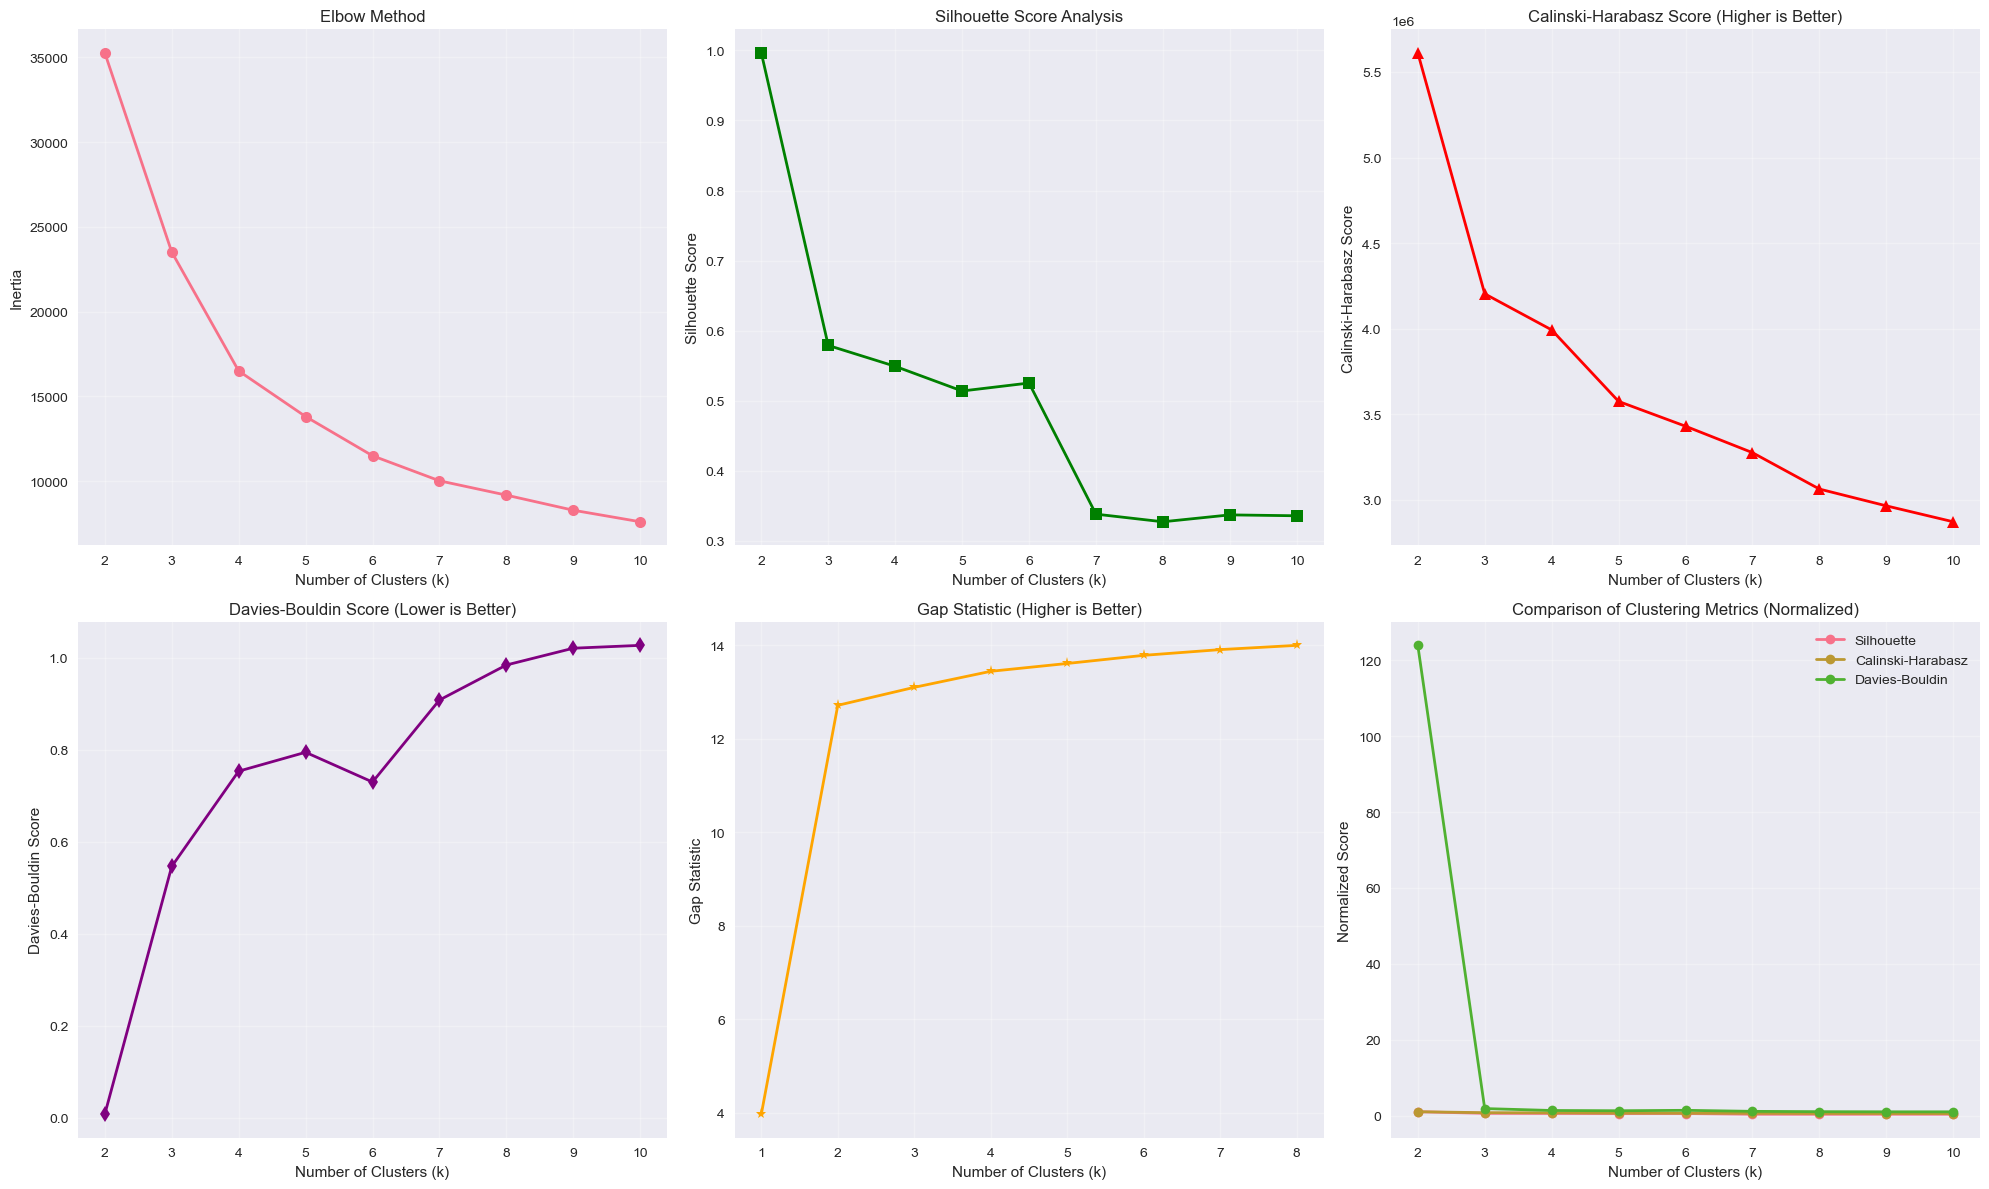

In [ ]:
# Comprehensive visualization of clustering validation metrics
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Elbow Method
axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score Analysis')
axes[0, 1].grid(True, alpha=0.3)

# 3. Calinski-Harabasz Score
axes[0, 2].plot(k_range, calinski_scores, marker='^', color='red', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Number of Clusters (k)')
axes[0, 2].set_ylabel('Calinski-Harabasz Score')
axes[0, 2].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Davies-Bouldin Score
axes[1, 0].plot(k_range, davies_bouldin_scores, marker='d', color='purple', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Gap Statistic
if gap_calculated:
    gap_k_range = range(1, len(gap_scores) + 1)
    axes[1, 1].plot(gap_k_range, gap_scores, marker='*', color='orange', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Gap Statistic')
    axes[1, 1].set_title('Gap Statistic (Higher is Better)')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Gap Statistic\nCalculation Failed',
                   ha='center', va='center', transform=axes[1, 1].transAxes)

# 6. Summary comparison
metrics_df = pd.DataFrame({
    'k': k_range,
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': np.array(calinski_scores) / max(calinski_scores),  # Normalize
    'Davies-Bouldin': 1 / np.array(davies_bouldin_scores)  # Invert (higher is better)
})

for metric in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']:
    axes[1, 2].plot(metrics_df['k'], metrics_df[metric], marker='o', label=metric, linewidth=2)

axes[1, 2].set_xlabel('Number of Clusters (k)')
axes[1, 2].set_ylabel('Normalized Score')
axes[1, 2].set_title('Comparison of Clustering Metrics (Normalized)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Choosing k=3 for k-means clustering

In [ ]:
# Apply multiple clustering algorithms with optimal parameters
clustering_results = {}
recommended_k=3

print("=== Applying Multiple Clustering Algorithms ===")

# 1. K-Means with optimal k
print(f"\n1. K-Means Clustering (k=3)")
kmeans = KMeans(n_clusters=recommended_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
clustering_results['K-Means'] = {
    'labels': kmeans_labels,
    'n_clusters': recommended_k,
    'algorithm': kmeans
}

=== Applying Multiple Clustering Algorithms ===

1. K-Means Clustering (k=3)


### 2.2.3 Hierarchical Clustering


2. Hierarchical Clustering (Auto-select k and best linkage)...
  ward linkage with k=2: silhouette = 0.9964
  ward linkage with k=3: silhouette = 0.5641
  ward linkage with k=4: silhouette = 0.5343
  ward linkage with k=5: silhouette = 0.4956
  ward linkage with k=6: silhouette = 0.4941
  ward linkage with k=7: silhouette = 0.3183
  ward linkage with k=8: silhouette = 0.3104
  ward linkage with k=9: silhouette = 0.3251
  ward linkage with k=10: silhouette = 0.3163
  complete linkage with k=2: silhouette = 0.9964
  complete linkage with k=3: silhouette = 0.9741
  complete linkage with k=4: silhouette = 0.9662
  complete linkage with k=5: silhouette = 0.4978
  complete linkage with k=6: silhouette = 0.4964
  complete linkage with k=7: silhouette = 0.4871
  complete linkage with k=8: silhouette = 0.4830
  complete linkage with k=9: silhouette = 0.4824
  complete linkage with k=10: silhouette = 0.5071
  average linkage with k=2: silhouette = 0.9964
  average linkage with k=3: silhouette =

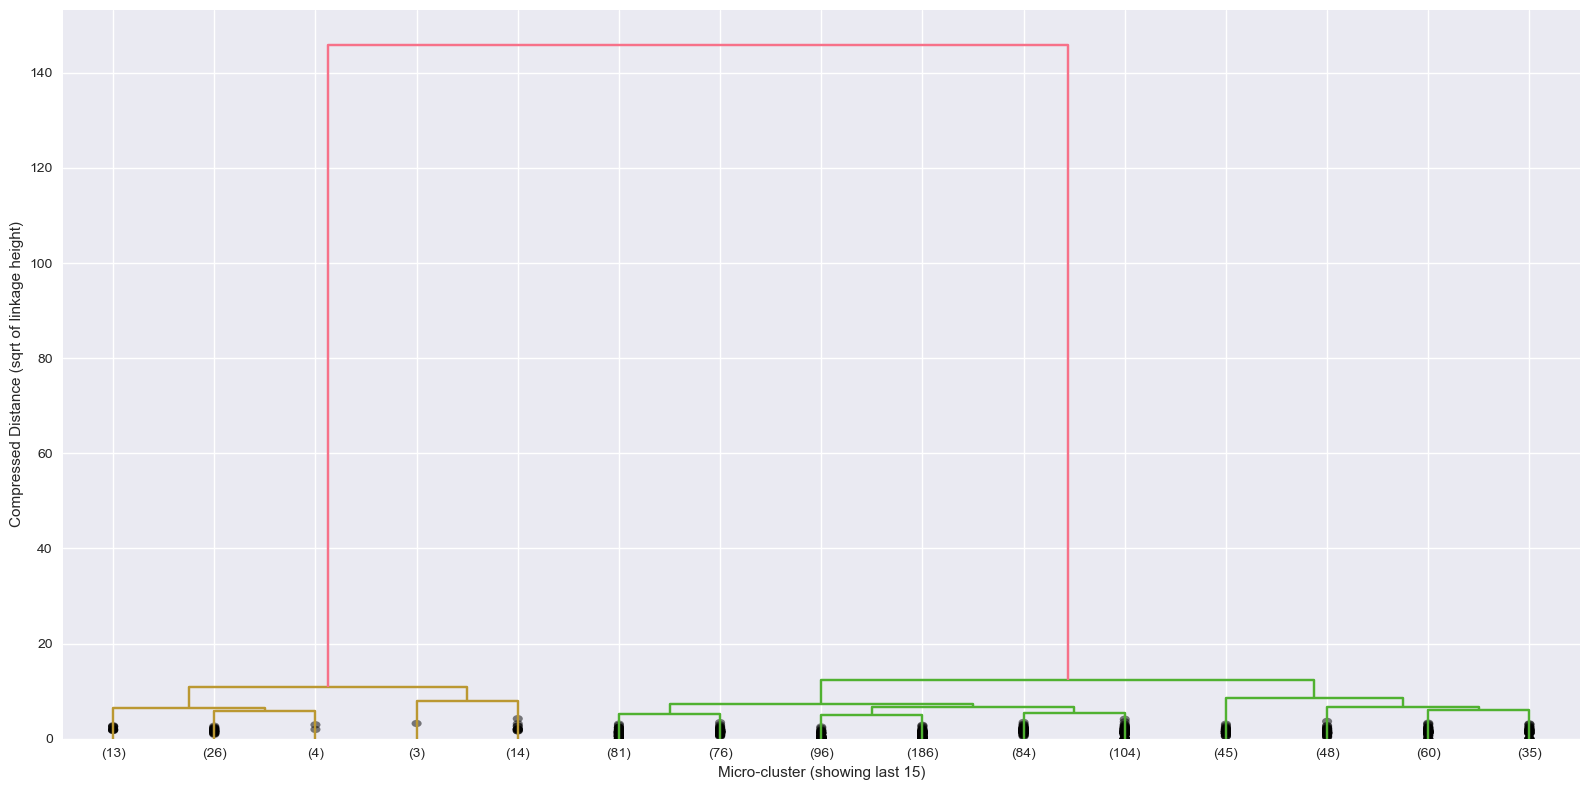

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

print("\n2. Hierarchical Clustering (Auto-select k and best linkage)...")
linkage_methods = ['ward', 'complete', 'average']
best_score = -1
best_hierarchical = None

for method in linkage_methods:
    try:
        Z = linkage(X_scaled, method=method)

        # Test multiple k values (2 to 10)
        for k in range(2, 11):
            labels = fcluster(Z, k, criterion='maxclust')
            score = silhouette_score(X_scaled, labels)

            print(f"  {method} linkage with k={k}: silhouette = {score:.4f}")
            if score > best_score:
                best_score = score
                best_hierarchical = {
                    'labels': labels,
                    'linkage_matrix': Z,
                    'method': method,
                    'n_clusters': k,
                    'score': score
                }
    except Exception as e:
        print(f"  {method} linkage failed: {e}")
# Add to clustering results
clustering_results['Hierarchical'] = {
        'labels': best_hierarchical['labels'],
        'n_clusters': best_hierarchical['n_clusters'],
        'linkage_matrix': best_hierarchical['linkage_matrix'],
        'method': best_hierarchical['method'],
        'score': best_hierarchical['score']
    }

import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# Store result and draw a clearer dendrogram
if best_hierarchical:
    print(f"\n Best Hierarchical Method: {best_hierarchical['method']} with k={best_hierarchical['n_clusters']} "
          f"(silhouette = {best_hierarchical['score']:.4f})")

    # --- 1) compress linkage heights to improve readability ---
    Z = best_hierarchical['linkage_matrix'].copy().astype(float)
    #square-root compression
    Z[:, 2] = np.sqrt(Z[:, 2])
    max_h = Z[:, 2].max()

    # --- 2) plot only the last p merges to avoid clutter ---
    p_show = 15
    plt.figure(figsize=(16, 8))
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=p_show,
        color_threshold=max_h * 0.6,
        leaf_rotation=0,
        leaf_font_size=10,
        show_contracted=True
    )
    plt.xlabel(f"Micro-cluster (showing last {p_show})")
    plt.ylabel("Compressed Distance (sqrt of linkage height)")
    plt.tight_layout()
    plt.show()

### 2.2.4 Bayesian Gaussian Mixture Model

In [ ]:
# 3. Bayesian Gaussian Mixture Model
print("\n3. Bayesian Gaussian Mixture Model...")
bgmm = BayesianGaussianMixture(
    n_components=10,
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,
    max_iter=1000,
    random_state=42
)

bgmm_labels = bgmm.fit_predict(X_scaled)
weight_threshold = 0.01
n_active_components =np.sum(bgmm.weights_ > weight_threshold)

clustering_results['BGMM'] = {
    'labels': bgmm_labels,
    'n_clusters': n_active_components,
    'algorithm': bgmm,
    'weights': bgmm.weights_
}

print(f"  Active components: {n_active_components}")


3. Bayesian Gaussian Mixture Model...
  Active components: 8


### 2.2.5 DBSCAN

In [ ]:
# 4. DBSCAN (density-based clustering)
print("\n4. DBSCAN (Density-Based Clustering)...")
# Try different epsilon values
eps_values = [0.3, 0.5, 0.8, 1.0, 1.2]
best_dbscan = None
best_dbscan_score = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    if n_clusters > 1:  # Need at least 2 clusters for silhouette score
        score = silhouette_score(X_scaled[dbscan_labels != -1],
                               dbscan_labels[dbscan_labels != -1])
        print(f"  eps={eps}: {n_clusters} clusters, {n_noise} noise points, silhouette = {score:.4f}")

        if score > best_dbscan_score and n_clusters >= 2:
            best_dbscan_score = score
            best_dbscan = {
                'labels': dbscan_labels,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'eps': eps,
                'algorithm': dbscan
            }
    else:
        print(f"  eps={eps}: {n_clusters} clusters, {n_noise} noise points")
if best_dbscan:
    clustering_results['DBSCAN'] = best_dbscan
    print(f"  Best DBSCAN: eps={best_dbscan['eps']}")
else:
    print("  DBSCAN did not produce good clustering results")

print(f"\nSuccessfully applied {len(clustering_results)} clustering algorithms")


4. DBSCAN (Density-Based Clustering)...
  eps=0.3: 10 clusters, 647 noise points, silhouette = 0.9066
  eps=0.5: 11 clusters, 630 noise points, silhouette = 0.8970
  eps=0.8: 11 clusters, 623 noise points, silhouette = 0.8852
  eps=1.0: 10 clusters, 550 noise points, silhouette = 0.5940
  eps=1.2: 11 clusters, 529 noise points, silhouette = 0.5692
  Best DBSCAN: eps=0.3

Successfully applied 4 clustering algorithms


### 2.2.6 Model Comparison

In [ ]:
# Comprehensive evaluation of all clustering methods
print("=== Clustering Algorithm Comparison ===")

evaluation_results = []

for name, result in clustering_results.items():
    labels = result['labels']
    n_clusters = result['n_clusters']

    # Handle noise points in DBSCAN
    if name == 'DBSCAN':
        # Exclude noise points for evaluation
        valid_mask = labels != -1
        if valid_mask.sum() > 0:
            eval_labels = labels[valid_mask]
            eval_data = X_scaled[valid_mask]
        else:
            continue
    else:
        eval_labels = labels
        eval_data = X_scaled

    # Calculate metrics
    if len(np.unique(eval_labels)) > 1:
        metrics = evaluate_clustering_metrics(eval_data, eval_labels)

        eval_result = {
            'Algorithm': name,
            'n_clusters': n_clusters,
            'silhouette': metrics['silhouette'],
            'calinski_harabasz': metrics['calinski_harabasz'],
            'davies_bouldin': metrics['davies_bouldin']
        }

        if name == 'DBSCAN':
            eval_result['n_noise'] = result['n_noise']
            eval_result['noise_ratio'] = result['n_noise'] / len(X_scaled)

        evaluation_results.append(eval_result)

# Create comparison DataFrame
comparison_df = pd.DataFrame(evaluation_results)
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("CLUSTERING ALGORITHM PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Rank algorithms
if len(comparison_df) > 0:
    # Normalize scores for ranking (higher is better for all)
    comparison_df['silhouette_rank'] = comparison_df['silhouette'].rank(ascending=False)
    comparison_df['calinski_rank'] = comparison_df['calinski_harabasz'].rank(ascending=False)
    comparison_df['davies_rank'] = comparison_df['davies_bouldin'].rank(ascending=True)  # Lower is better

    # Overall ranking (simple average)
    comparison_df['overall_rank'] = (
        comparison_df['silhouette_rank'] +
        comparison_df['calinski_rank'] +
        comparison_df['davies_rank']
    ) / 3
    comparison_df_sorted = comparison_df.sort_values('overall_rank')

    print(f"\n=== ALGORITHM RANKING (Best to Worst) ===")
    for i, (_, row) in enumerate(comparison_df_sorted.iterrows(), 1):
        print(f"{i}. {row['Algorithm']}: "
              f"Silhouette={row['silhouette']:.4f}, "
              f"Calinski-Harabasz={row['calinski_harabasz']:.2f}, "
              f"Davies-Bouldin={row['davies_bouldin']:.4f}")

    best_algorithm = comparison_df_sorted.iloc[0]['Algorithm']
    print(f"\n🏆 BEST PERFORMING ALGORITHM: {best_algorithm}")
else:
    print("No valid clustering results to compare")


=== Clustering Algorithm Comparison ===

CLUSTERING ALGORITHM PERFORMANCE COMPARISON
   Algorithm  n_clusters  silhouette  calinski_harabasz  davies_bouldin  n_noise  noise_ratio
     K-Means           3      0.5790       4203195.2630          0.5465      NaN          NaN
Hierarchical           2      0.9964       5611905.1029          0.0081      NaN          NaN
        BGMM           8      0.2399       1977036.0943          1.5898      NaN          NaN
      DBSCAN          10      0.9066         12311.3268          0.1425    647.0       0.7394

=== ALGORITHM RANKING (Best to Worst) ===
1. Hierarchical: Silhouette=0.9964, Calinski-Harabasz=5611905.10, Davies-Bouldin=0.0081
2. K-Means: Silhouette=0.5790, Calinski-Harabasz=4203195.26, Davies-Bouldin=0.5465
3. DBSCAN: Silhouette=0.9066, Calinski-Harabasz=12311.33, Davies-Bouldin=0.1425
4. BGMM: Silhouette=0.2399, Calinski-Harabasz=1977036.09, Davies-Bouldin=1.5898

🏆 BEST PERFORMING ALGORITHM: Hierarchical


In [ ]:
# Create comprehensive cluster profiles for the best performing algorithm
if 'comparison_df_sorted' in locals() and len(comparison_df_sorted) > 0:
    best_algorithm = comparison_df_sorted.iloc[0]['Algorithm']
    best_labels = clustering_results[best_algorithm]['labels']

    print(f"=== DETAILED CLUSTER ANALYSIS: {best_algorithm} ===")

    # Add cluster labels to original dataframe for analysis
    df_with_clusters = merged_pipeline_2.copy()
    df_with_clusters['cluster'] = best_labels

    # Handle noise points in DBSCAN - convert back to numeric for consistency
    if best_algorithm == 'DBSCAN':
        # Convert -1 (noise) to a special label for display, but keep numeric for calculations
        unique_clusters = sorted([c for c in df_with_clusters['cluster'].unique() if c != -1])
        if -1 in df_with_clusters['cluster'].values:
            unique_clusters.append(-1)  # Keep as numeric
    else:
        unique_clusters = sorted(df_with_clusters['cluster'].unique())

    print(f"Number of clusters: {len(unique_clusters)}")
    # Cluster size analysis
    cluster_sizes = df_with_clusters['cluster'].value_counts().sort_index()
    print(f"\nCluster sizes:")
    for cluster, size in cluster_sizes.items():
        percentage = (size / len(df_with_clusters)) * 100
        cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
        print(f"  {cluster_name}: {size} members ({percentage:.1f}%)")

    # Create comprehensive cluster profiles (exclude noise points for meaningful analysis)
    print(f"\n=== CLUSTER PROFILES ===")

    # Select features for profiling (exclude ID and non-meaningful columns)
    profile_cols = [col for col in merged_pipeline_2.columns
                   if col not in ['ID_NUMBER', 'STOP_DATE'] and
                   merged_pipeline_2[col].dtype in ['int64', 'float64', 'Int64', 'bool']]

    # For DBSCAN, exclude noise points from profiling
    if best_algorithm == 'DBSCAN':
        df_for_profiling = df_with_clusters[df_with_clusters['cluster'] != -1]
        clusters_for_profiling = [c for c in unique_clusters if c != -1]
    else:
        df_for_profiling = df_with_clusters
        clusters_for_profiling = unique_clusters

    if len(df_for_profiling) > 0:
        cluster_profiles = df_for_profiling.groupby('cluster')[profile_cols].agg([
            'mean', 'median', 'std'
        ]).round(3)

        # Display mean profiles
        mean_profiles = cluster_profiles.xs('mean', level=1, axis=1)
        print("\nMean values by cluster (excluding noise points):")
        print(mean_profiles.to_string())
        # Identify distinguishing features for each cluster
        print(f"\n=== CLUSTER CHARACTERISTICS ===")

        # Calculate feature importance for each cluster (deviation from overall mean)
        overall_means = merged_pipeline_2[profile_cols].mean()

        for cluster in clusters_for_profiling:
            cluster_data = mean_profiles.loc[cluster]
            deviations = ((cluster_data - overall_means) / overall_means.abs()).abs()
            top_features = deviations.nlargest(5)

            print(f"\nCluster {cluster} (n={cluster_sizes[cluster]}):")
            print("  Most distinctive features:")
            for feature, deviation in top_features.items():
                cluster_val = cluster_data[feature]
                overall_val = overall_means[feature]
                direction = "higher" if cluster_val > overall_val else "lower"
                print(f"    • {feature}: {cluster_val:.3f} vs avg {overall_val:.3f} "
                      f"({direction} by {abs(cluster_val - overall_val):.3f})")
    else:
        print("No valid clusters found for profiling")
else:
    print("No clustering results available for profiling")

=== DETAILED CLUSTER ANALYSIS: Hierarchical ===
Number of clusters: 2

Cluster sizes:
  Cluster 1: 60 members (6.9%)
  Cluster 2: 815 members (93.1%)

=== CLUSTER PROFILES ===

Mean values by cluster (excluding noise points):
         enquirer_count  stage_enquirer  stage_intender  stage_pledge  proposals_count  stage_proposals     AGE  label  enquire_annum  proposal_annum  graduation_annum  Last_Gift_Year  age_extend  age_group
cluster                                                                                                                                                                                                       
1                 0.183           0.167           0.117         1.000            0.950            0.783  80.278  0.783          1.333           9.867            54.372         2013.95      80.491      2.950
2                 0.314           0.286           0.142         0.161            0.836            0.660  70.105  0.660          1.901           7.994    

### 2.2.7 Model Visualization

In [ ]:
# Advanced dimensionality reduction and visualization
print("=== Creating Advanced Visualizations ===")

# 1. PCA Analysis
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"PCA 2D explained variance: {pca_2d.explained_variance_ratio_.sum():.3f}")
print(f"PCA 3D explained variance: {pca_3d.explained_variance_ratio_.sum():.3f}")

# 2. t-SNE Analysis (use subset for efficiency)
print("Computing t-SNE...")
tsne_sample_size = min(1000, len(X_scaled))
tsne_indices = np.random.choice(len(X_scaled), tsne_sample_size, replace=False)
X_tsne_subset = X_scaled[tsne_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_tsne_subset)

# Prepare labels for visualization
visualization_labels = {}
for name, result in clustering_results.items():
    labels = result['labels']
    if name == 'DBSCAN':
        # Map noise points to a special label
        labels = np.where(labels == -1, 'Noise', labels.astype(str))
    visualization_labels[name] = labels

print("Visualization data prepared successfully")


=== Creating Advanced Visualizations ===
Computing PCA...
PCA 2D explained variance: 1.000
PCA 3D explained variance: 1.000
Computing t-SNE...
Visualization data prepared successfully


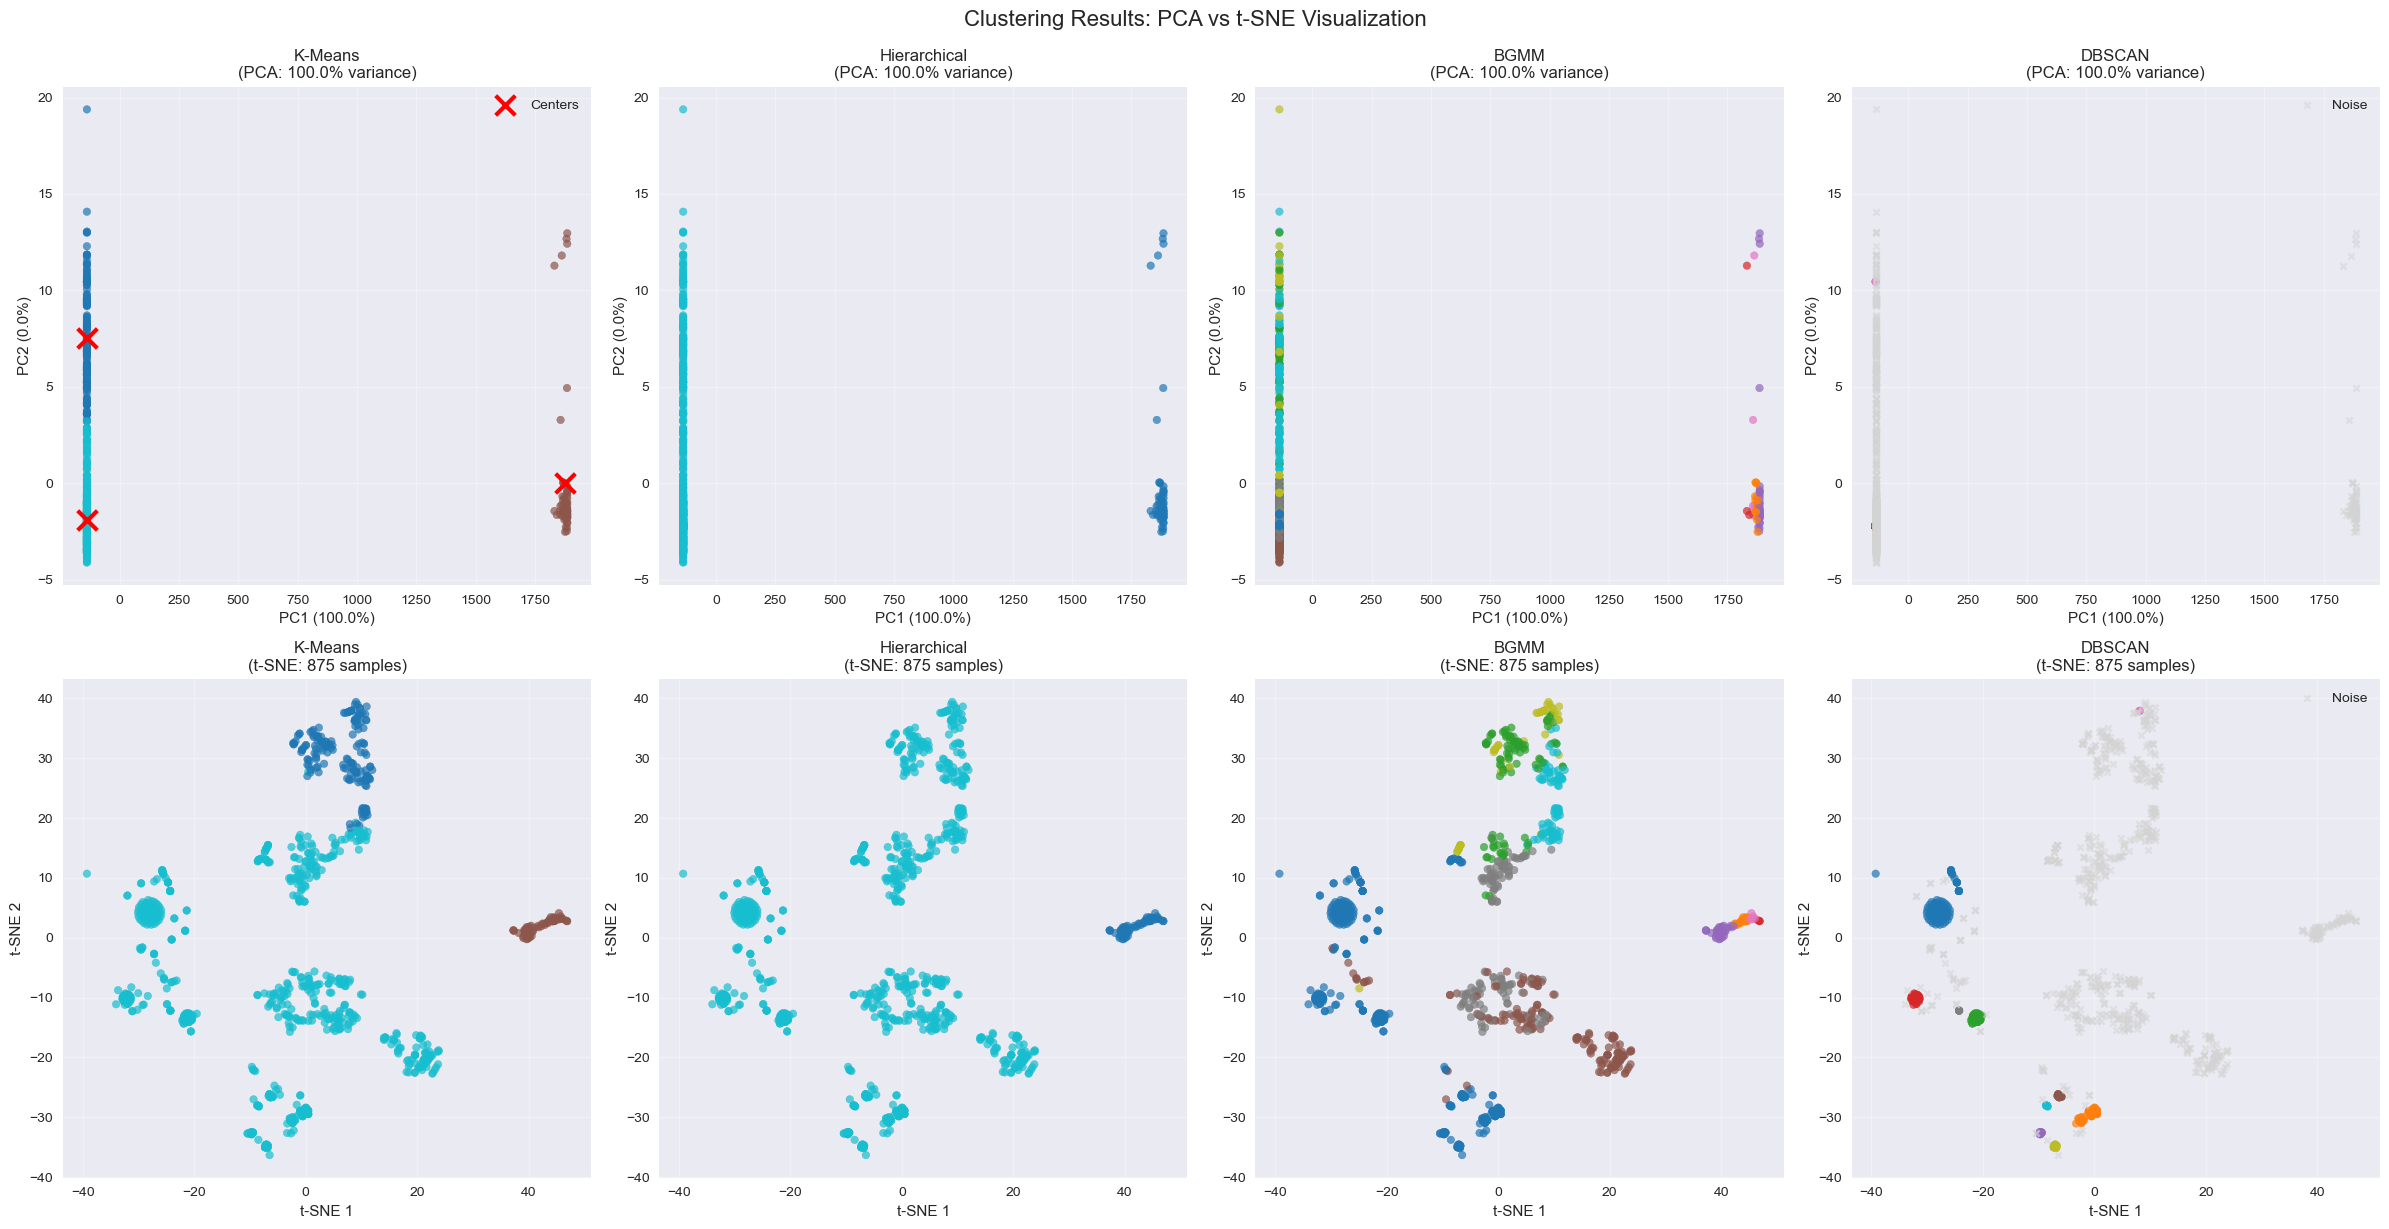

In [ ]:
# Comprehensive clustering visualization with proper color handling
n_algorithms = len(clustering_results)
fig, axes = plt.subplots(2, n_algorithms, figsize=(6*n_algorithms, 12))

if n_algorithms == 1:
    axes = axes.reshape(-1, 1)

# Function to convert labels to numeric for plotting
def prepare_labels_for_plotting(labels, algorithm_name):
    """Convert labels to numeric format suitable for matplotlib coloring"""
    if algorithm_name == 'DBSCAN':
        # Convert string labels back to numeric, keeping -1 for noise
        numeric_labels = []
        for label in labels:
            if label == 'Noise':
                numeric_labels.append(-1)
            else:
                numeric_labels.append(int(label))
        return np.array(numeric_labels)
    else:
        # Ensure labels are numeric
        return np.array(labels, dtype=int)

# PCA Visualizations
for i, (name, result) in enumerate(clustering_results.items()):
    labels = visualization_labels[name]
    plot_labels = prepare_labels_for_plotting(labels, name)

    # Handle DBSCAN noise points separately
    if name == 'DBSCAN':
        # Plot regular clusters
        regular_mask = plot_labels != -1
        if regular_mask.any():
            scatter = axes[0, i].scatter(X_pca_2d[regular_mask, 0], X_pca_2d[regular_mask, 1],
                                        c=plot_labels[regular_mask], cmap='tab10', s=30, alpha=0.7)

        # Plot noise points in gray
        noise_mask = plot_labels == -1
        if noise_mask.any():
            axes[0, i].scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1],
                              c='lightgray', s=20, alpha=0.5, marker='x', label='Noise')
            axes[0, i].legend()
    else:
        # Regular clustering visualization
        scatter = axes[0, i].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                                    c=plot_labels, cmap='tab10', s=30, alpha=0.7)

    axes[0, i].set_title(f'{name}\n(PCA: {pca_2d.explained_variance_ratio_.sum():.1%} variance)')
    axes[0, i].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
    axes[0, i].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
    axes[0, i].grid(True, alpha=0.3)

    # Add cluster centers for applicable algorithms
    if name in ['K-Means'] and hasattr(result['algorithm'], 'cluster_centers_'):
        centers_pca = pca_2d.transform(result['algorithm'].cluster_centers_)
        axes[0, i].scatter(centers_pca[:, 0], centers_pca[:, 1],
                          c='red', marker='x', s=200, linewidths=3, label='Centers')
        axes[0, i].legend()

# t-SNE Visualizations (using subset)
for i, (name, result) in enumerate(clustering_results.items()):
    labels_subset = visualization_labels[name][tsne_indices]
    plot_labels_subset = prepare_labels_for_plotting(labels_subset, name)

    # Handle DBSCAN noise points separately for t-SNE
    if name == 'DBSCAN':
        # Plot regular clusters
        regular_mask = plot_labels_subset != -1
        if regular_mask.any():
            scatter = axes[1, i].scatter(X_tsne[regular_mask, 0], X_tsne[regular_mask, 1],
                                        c=plot_labels_subset[regular_mask], cmap='tab10', s=30, alpha=0.7)

        # Plot noise points in gray
        noise_mask = plot_labels_subset == -1
        if noise_mask.any():
            axes[1, i].scatter(X_tsne[noise_mask, 0], X_tsne[noise_mask, 1],
                              c='lightgray', s=20, alpha=0.5, marker='x', label='Noise')
            axes[1, i].legend()
    else:
        # Regular clustering visualization
        scatter = axes[1, i].scatter(X_tsne[:, 0], X_tsne[:, 1],
                                    c=plot_labels_subset, cmap='tab10', s=30, alpha=0.7)

    axes[1, i].set_title(f'{name}\n(t-SNE: {tsne_sample_size} samples)')
    axes[1, i].set_xlabel('t-SNE 1')
    axes[1, i].set_ylabel('t-SNE 2')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Clustering Results: PCA vs t-SNE Visualization', fontsize=16, y=1.02)
plt.show()

## 2.3 Cluster Analysis on Potential Participants

### 2.3.1 K-Means Clustering

In [ ]:
# Separate feature types
numeric_cols = active_alumni_merge.select_dtypes(include=["int64", "float64"]).columns.tolist()
bool_cols = active_alumni_merge.select_dtypes(include=["bool"]).columns.tolist()
cat_cols = active_alumni_merge.select_dtypes(include=["object", "category"]).columns.tolist()

# Combine numerical and boolean features
features_raw = active_alumni_merge[numeric_cols + bool_cols]
print(f"Numeric/Boolean features: {features_raw.shape[1]} columns")

# One-hot encode categorical variables (if any)
if cat_cols:
    features_cat = pd.get_dummies(active_alumni_merge[cat_cols], drop_first=True, prefix=cat_cols)
    features_raw = pd.concat([features_raw, features_cat], axis=1)
    print(f"After one-hot encoding: {features_raw.shape[1]} total features")
else:
    print("No categorical features to encode")

# Fill missing values with 0 before scaling
features_filled = features_raw.fillna(0)

# Use RobustScaler to handle potential outliers
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_filled)

print(f"Final feature matrix shape: {features_scaled.shape}")
print(f"Feature names: {list(features_raw.columns)}")

Numeric/Boolean features: 5 columns
After one-hot encoding: 19 total features
Final feature matrix shape: (192157, 19)
Feature names: ['Advance ID', 'AGE', 'label', 'graduation_annum', 'age_extend', 'Marital Status_Unknown', 'Children Y/N_Y', "COUNTRY_People's Republic of China", 'COUNTRY_USA', 'COUNTRY_United Kingdom', 'COUNTRY_Unknown', 'Degree_Doctorate', 'Degree_Other', 'Degree_Postgraduate', 'Degree_Undergraduate', 'Degree_Unknown', 'latest_donation_annum_flag_Y', 'subcategory_Y_count_flag_Y', 'sheet_appear_count_flag_Y']


In [ ]:
k_range = range(2, 11)

inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(features_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(features_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(features_scaled, labels))

# Plot evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Elbow Method
axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score Analysis')
axes[0, 1].grid(True, alpha=0.3)

# 3. Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, marker='^', color='red', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Davies-Bouldin Score
axes[1, 1].plot(k_range, davies_bouldin_scores, marker='d', color='purple', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Define the optimal number of clusters for the new dataset
recommended_k_2 = 2

print("=== Applying Multiple Clustering Algorithms on active_alumni ===")

# Apply KMeans clustering on the new scaled data
print(f"\n1.K-Means on active alumni (k={recommended_k_2}) …")

kmeans_2 = KMeans(n_clusters=recommended_k_2, random_state=42, n_init=10)
kmeans_labels_2 = kmeans_2.fit_predict(features_scaled)

# Store results in a dictionary
clustering_results_2 = {
    'K-Means': {
        'labels': kmeans_labels_2,
        'n_clusters': recommended_k_2,
        'algorithm': kmeans_2
    }
}

print("Clustering completed and stored in clustering_results_2.")

=== Applying Multiple Clustering Algorithms on active_alumni ===

1.K-Means on active alumni (k=2) …
Clustering completed and stored in clustering_results_2.


### 2.3.2 Hierarchical Clustering

In [ ]:
print("\n2. Hierarchical Clustering on active alumni (Auto-select k and best linkage)...")

# Step 1: PCA reduction (to avoid high-dimensional linkage explosion)
pca = PCA(n_components=5, random_state=42)
features_reduced = pca.fit_transform(features_scaled)

# Step 2: Sampling for linkage computation
max_samples = 2000
if features_reduced.shape[0] > max_samples:
    sampled_idx = np.random.choice(features_reduced.shape[0], max_samples, replace=False)
    features_hier = features_reduced[sampled_idx]
else:
    features_hier = features_reduced

# Step 3: Try different linkage methods and k values
linkage_methods = ['ward', 'complete', 'average']
best_score = -1
best_hierarchical_2 = None

for method in linkage_methods:
    try:
        Z = linkage(features_hier, method=method)
        for k in range(2, 11):
            labels = fcluster(Z, k, criterion='maxclust')
            score = silhouette_score(features_hier, labels)

            print(f"  {method} linkage with k={k}: silhouette = {score:.4f}")
            if score > best_score:
                best_score = score
                best_hierarchical_2 = {
                    'labels': labels,
                    'linkage_matrix': Z,
                    'method': method,
                    'n_clusters': k,
                    'score': score
                }
    except Exception as e:
        print(f"  {method} linkage failed: {e}")


2. Hierarchical Clustering on active alumni (Auto-select k and best linkage)...
  ward linkage with k=2: silhouette = 0.3597
  ward linkage with k=3: silhouette = 0.2950
  ward linkage with k=4: silhouette = 0.2854
  ward linkage with k=5: silhouette = 0.3027
  ward linkage with k=6: silhouette = 0.3331
  ward linkage with k=7: silhouette = 0.3342
  ward linkage with k=8: silhouette = 0.3702
  ward linkage with k=9: silhouette = 0.3806
  ward linkage with k=10: silhouette = 0.3896
  complete linkage with k=2: silhouette = 0.4667
  complete linkage with k=3: silhouette = 0.4518
  complete linkage with k=4: silhouette = 0.3320
  complete linkage with k=5: silhouette = 0.3282
  complete linkage with k=6: silhouette = 0.2777
  complete linkage with k=7: silhouette = 0.2708
  complete linkage with k=8: silhouette = 0.2207
  complete linkage with k=9: silhouette = 0.2163
  complete linkage with k=10: silhouette = 0.2525
  average linkage with k=2: silhouette = 0.5020
  average linkage with 


 Best Hierarchical Method for active alumni: average with k=2 (silhouette = 0.5020)


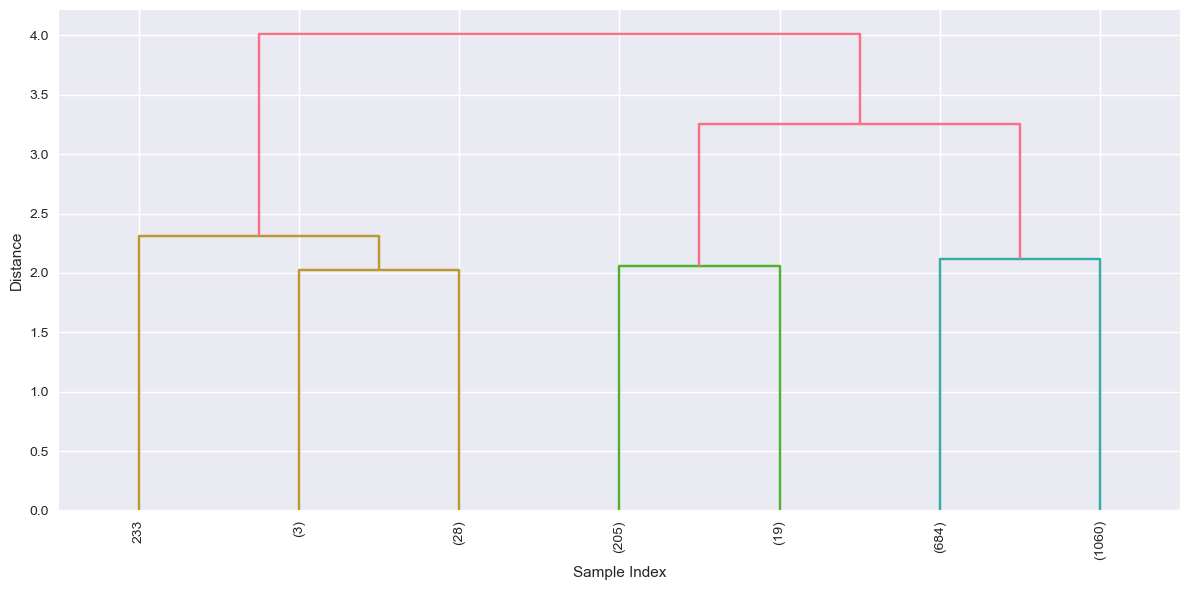

In [ ]:
# Store result and draw dendrogram
if best_hierarchical_2:
    print(f"\n Best Hierarchical Method for active alumni: {best_hierarchical_2['method']} with k={best_hierarchical_2['n_clusters']} "
          f"(silhouette = {best_hierarchical_2['score']:.4f})")

    # Draw dendrogram with colored clusters
    plt.figure(figsize=(12, 6))
    dendrogram(
        best_hierarchical_2['linkage_matrix'],
        truncate_mode='level',
        p=best_hierarchical_2['n_clusters'],
        leaf_rotation=90.,
        leaf_font_size=10.,
        color_threshold=None
    )
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

In [ ]:
# Apply Hierarchical Clustering on the full dataset(active alumni)
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Build sparse nearest-neighbor graph to avoid full O(n^2) memory use
connectivity = kneighbors_graph(features_scaled, n_neighbors=10, include_self=False)

# Run memory-efficient hierarchical clustering with average linkage and k=2
agglo_model_full = AgglomerativeClustering(
    n_clusters=2,
    linkage='average',
    connectivity=connectivity,  # <- this limits the linkage calculations
    memory=None
)

full_labels = agglo_model_full.fit_predict(features_scaled)

# Save result
clustering_results_2['Hierarchical'] = {
    'labels': full_labels,
    'n_clusters': 2,
    'method': 'average',
    'score': None  # optional: recompute silhouette if needed
}

print(" Hierarchical clustering with average linkage (k=2) applied using connectivity constraints.")

 Hierarchical clustering with average linkage (k=2) applied using connectivity constraints.


### 2.3.3 Bayesian Gaussian Mixture Model

In [ ]:
 #3. Bayesian Gaussian Mixture Model on active alumni
print("\n3. Bayesian Gaussian Mixture Model on active alumni...")

# Step 1: Train BGMM on a subset (to reduce memory/compute cost)
subset_size = 10000  # adjustable
subset_indices = np.random.choice(features_scaled.shape[0], subset_size, replace=False)
subset_data = features_scaled[subset_indices]

bgmm = BayesianGaussianMixture(
    n_components=10,  # max possible components
    covariance_type='diag',  # lighter than 'full' for high dimensions
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,
    max_iter=1000,
    random_state=42
)

bgmm.fit(subset_data)

# Step 2: Predict labels for the entire dataset
bgmm_labels_2 = bgmm.predict(features_scaled)

# Step 3: Count effective components (those with non-trivial weights)
weight_threshold = 0.01
n_active_components_2 = np.sum(bgmm.weights_ > weight_threshold)

# Step 4: Store results
clustering_results_2['BGMM'] = {
    'labels': bgmm_labels_2,
    'n_clusters': n_active_components_2,
    'algorithm': bgmm,
    'weights': bgmm.weights_
}
print(f"BGMM applied to full dataset")
print(f"   Active components (weight > {weight_threshold}): {n_active_components_2}")



3. Bayesian Gaussian Mixture Model on active alumni...
BGMM applied to full dataset
   Active components (weight > 0.01): 9


### 2.3.4 DBSCAN

In [ ]:
#4. DBSCAN on active alumni...
print("\n4. DBSCAN (Density-Based Clustering) on active alumni...")

# Step 1: Try different eps values on a small subset
subset_size = 10000
subset_indices = np.random.choice(features_scaled.shape[0], subset_size, replace=False)
subset_data = features_scaled[subset_indices]

eps_values = [0.3, 0.5, 0.8, 1.0, 1.2]
best_dbscan = None
best_dbscan_score = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    subset_labels = dbscan.fit_predict(subset_data)

    n_clusters = len(set(subset_labels)) - (1 if -1 in subset_labels else 0)
    n_noise = list(subset_labels).count(-1)

    if n_clusters > 1:
        score = silhouette_score(subset_data[subset_labels != -1], subset_labels[subset_labels != -1])
        print(f"  [Subset] eps={eps}: {n_clusters} clusters, {n_noise} noise, silhouette={score:.4f}")

        if score > best_dbscan_score:
            best_dbscan_score = score
            best_dbscan = {
                'eps': eps,
                'score': score
            }
    else:
        print(f"  [Subset] eps={eps}: {n_clusters} clusters, {n_noise} noise (ignored)")

# Step 2: Apply best DBSCAN to full dataset

# Ensure features are float32 to save memory
features_scaled_32 = features_scaled.astype(np.float32)

# Use best eps from step 1
best_eps = best_dbscan['eps']

# Try using more efficient tree-based algorithm
try:
    final_dbscan = DBSCAN(
        eps=best_eps,
        min_samples=5,
        metric='euclidean',
        algorithm='ball_tree',
        n_jobs=-1  # Use all cores
    )

    full_labels = final_dbscan.fit_predict(features_scaled_32)

    n_clusters_full = len(set(full_labels)) - (1 if -1 in full_labels else 0)
    n_noise_full = list(full_labels).count(-1)

    clustering_results_2['DBSCAN'] = {
        'labels': full_labels,
        'n_clusters': n_clusters_full,
        'n_noise': n_noise_full,
        'eps': best_eps,
        'algorithm': final_dbscan
    }

    print(f"DBSCAN completed: {n_clusters_full} clusters, {n_noise_full} noise points")

except MemoryError:
    print(" MemoryError: Even with optimizations, DBSCAN failed on full dataset")

except Exception as e:
    print(f"DBSCAN failed with error: {e}")


4. DBSCAN (Density-Based Clustering) on active alumni...
  [Subset] eps=0.3: 108 clusters, 1282 noise, silhouette=0.4125
  [Subset] eps=0.5: 100 clusters, 824 noise, silhouette=0.1836
  [Subset] eps=0.8: 94 clusters, 589 noise, silhouette=0.1224
  [Subset] eps=1.0: 98 clusters, 492 noise, silhouette=0.1294
  [Subset] eps=1.2: 2 clusters, 80 noise, silhouette=0.4395
DBSCAN completed: 4 clusters, 67 noise points


In [ ]:
print(f"\nSuccessfully applied {len(clustering_results_2)} clustering algorithms")


Successfully applied 4 clustering algorithms


### 2.3.5 Model Evaluation

In [ ]:
# Comprehensive evaluation of all clustering methods (new dataset version)
print("=== Clustering Algorithm Comparison for Active Alumni ===")

def evaluate_clustering_metrics(X, labels):
    """
    Calculate multiple clustering evaluation metrics
    """
    metrics = {}

    # Silhouette Score
    if len(np.unique(labels)) > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics['silhouette'] = -1
        metrics['calinski_harabasz'] = 0
        metrics['davies_bouldin'] = float('inf')

    return metrics


evaluation_results_2 = []

for name, result in clustering_results_2.items():
    labels = result['labels']
    n_clusters = result['n_clusters']

    # Handle DBSCAN noise points
    if name == 'DBSCAN':
        valid_mask = labels != -1
        if valid_mask.sum() > 0:
            eval_labels = labels[valid_mask]
            eval_data = features_scaled[valid_mask]
        else:
            continue
    else:
        eval_labels = labels
        eval_data = features_scaled

    # Evaluate only if more than one cluster
    if len(np.unique(eval_labels)) > 1:
        metrics = evaluate_clustering_metrics(eval_data, eval_labels)

        eval_result = {
            'Algorithm': name,
            'n_clusters': n_clusters,
            'silhouette': metrics['silhouette'],
            'calinski_harabasz': metrics['calinski_harabasz'],
            'davies_bouldin': metrics['davies_bouldin']
        }

        if name == 'DBSCAN':
            eval_result['n_noise'] = result['n_noise']
            eval_result['noise_ratio'] = result['n_noise'] / len(features_scaled)

        evaluation_results_2.append(eval_result)

# Create comparison DataFrame
comparison_df_2 = pd.DataFrame(evaluation_results_2)
comparison_df_2 = comparison_df_2.round(4)

print("\n" + "="*80)
print("CLUSTERING ALGORITHM PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df_2.to_string(index=False))

# Rank algorithms
if len(comparison_df_2) > 0:
    # Normalize and rank (higher is better except for Davies-Bouldin)
    comparison_df_2['silhouette_rank'] = comparison_df_2['silhouette'].rank(ascending=False)
    comparison_df_2['calinski_rank'] = comparison_df_2['calinski_harabasz'].rank(ascending=False)
    comparison_df_2['davies_rank'] = comparison_df_2['davies_bouldin'].rank(ascending=True)

    # Average ranking
    comparison_df_2['overall_rank'] = (
        comparison_df_2['silhouette_rank'] +
        comparison_df_2['calinski_rank'] +
        comparison_df_2['davies_rank']
    ) / 3

    # Sort by overall rank
    comparison_df_sorted_2 = comparison_df_2.sort_values('overall_rank')

    print(f"\n=== ALGORITHM RANKING (Best to Worst) ===")
    for i, (_, row) in enumerate(comparison_df_sorted_2.iterrows(), 1):
        print(f"{i}. {row['Algorithm']}: "
              f"Silhouette={row['silhouette']:.4f}, "
              f"Calinski-Harabasz={row['calinski_harabasz']:.2f}, "
              f"Davies-Bouldin={row['davies_bouldin']:.4f}")

    # Store best algorithm name
    best_algorithm_2 = comparison_df_sorted_2.iloc[0]['Algorithm']
    print(f"\n🏆 BEST PERFORMING ALGORITHM: {best_algorithm_2}")

else:
    print("No valid clustering results to compare.")


=== Clustering Algorithm Comparison for Active Alumni ===

CLUSTERING ALGORITHM PERFORMANCE COMPARISON
   Algorithm  n_clusters  silhouette  calinski_harabasz  davies_bouldin  n_noise  noise_ratio
     K-Means           2      0.3656        116814.8801          1.1919      NaN          NaN
      DBSCAN           4      0.3081           111.5278          1.1179     67.0       0.0003
Hierarchical           2      0.1624         30018.5989          2.1513      NaN          NaN
        BGMM           9      0.2215         29662.7471          1.8004      NaN          NaN

=== ALGORITHM RANKING (Best to Worst) ===
1. K-Means: Silhouette=0.3656, Calinski-Harabasz=116814.88, Davies-Bouldin=1.1919
2. DBSCAN: Silhouette=0.3081, Calinski-Harabasz=111.53, Davies-Bouldin=1.1179
3. BGMM: Silhouette=0.2215, Calinski-Harabasz=29662.75, Davies-Bouldin=1.8004
4. Hierarchical: Silhouette=0.1624, Calinski-Harabasz=30018.60, Davies-Bouldin=2.1513

🏆 BEST PERFORMING ALGORITHM: K-Means



### 2.3.6 Use the best algorithm K-means to create profile

In [ ]:
# 1. Remove 'Advance ID' column if present
features_cleaned = features_raw.drop(columns=['Advance ID'], errors='ignore')

# 2. Add cluster labels to the dataset
features_with_labels = features_cleaned.copy()
features_with_labels['Cluster'] = kmeans_labels_2

# 3. Show cluster sizes and proportions
cluster_counts = features_with_labels['Cluster'].value_counts().sort_index()
cluster_ratios = cluster_counts / len(features_with_labels)

print("\n=== Cluster Size and Ratio ===")
for cluster_id in sorted(cluster_counts.index):
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} samples "
          f"({cluster_ratios[cluster_id]:.2%})")

# 4. Compute cluster-wise mean profiles
cluster_profiles = features_with_labels.groupby('Cluster').mean(numeric_only=True)

print("\n=== Cluster Profile (Mean Feature Values) ===")
display(cluster_profiles)

# 5. Compute top 5 features with the largest absolute and relative differences
if len(cluster_profiles) == 2:
    mean0 = cluster_profiles.iloc[0]
    mean1 = cluster_profiles.iloc[1]

    # Absolute difference
    abs_diff = (mean0 - mean1).abs()
    top_abs_features = abs_diff.sort_values(ascending=False).head(5)

    # Relative difference
    avg_mean = (mean0 + mean1) / 2
    rel_diff = ((mean0 - mean1) / avg_mean).abs()
    top_rel_features = rel_diff.sort_values(ascending=False).head(5)

    # Print top absolute differences
    print("\n=== Top 5 Features by Absolute Difference ===")
    for feature in top_abs_features.index:
        val_0 = mean0[feature]
        val_1 = mean1[feature]
        print(f"{feature}: Cluster 0 = {val_0:.4f}, Cluster 1 = {val_1:.4f}, Abs Diff = {abs(val_0 - val_1):.4f}")

    # Print top relative differences
    print("\n=== Top 5 Features by Relative Difference ===")
    for feature in top_rel_features.index:
        val_0 = mean0[feature]
        val_1 = mean1[feature]
        rel = (val_0 - val_1) / ((val_0 + val_1) / 2)
        print(f"{feature}: Cluster 0 = {val_0:.4f}, Cluster 1 = {val_1:.4f}, Rel Diff = {rel:.2%}")
else:
    print("More than 2 clusters — difference comparison only implemented for 2 clusters.")


=== Cluster Size and Ratio ===
Cluster 0: 129292 samples (67.28%)
Cluster 1: 62865 samples (32.72%)

=== Cluster Profile (Mean Feature Values) ===


AGE     label  graduation_annum  age_extend  \
Cluster                                                      
0        35.319127  0.000441         10.479961   35.371545   
1        61.753718  0.006172         36.629038   62.693725   

         Marital Status_Unknown  Children Y/N_Y  \
Cluster                                           
0                      0.995444        0.000851   
1                      0.780355        0.082828   

         COUNTRY_People's Republic of China  COUNTRY_USA  \
Cluster                                                    
0                                  0.097214     0.095837   
1                                  0.005695     0.180943   

         COUNTRY_United Kingdom  COUNTRY_Unknown  Degree_Doctorate  \
Cluster                                                              
0                      0.334298         0.069401          0.007835   
1                      0.397041         0.057059          0.001575   

         Degree_Other  Degree_Postgraduate  Degree_Undergraduate  \
Cluster                                                            
0            0.078969             0.656498              0.248778   
1            0.083862             0.451253              0.295983   

         Degree_Unknown  latest_donation_annum_flag_Y  \
Cluster                                                 
0              0.003372                      0.021834   
1              0.142178                      0.202991   

         subcategory_Y_count_flag_Y  sheet_appear_count_flag_Y  
Cluster                                                         
0                          0.028702                   0.075728  
1                          0.029269                   0.043888


=== Top 5 Features by Absolute Difference ===
age_extend: Cluster 0 = 35.3715, Cluster 1 = 62.6937, Abs Diff = 27.3222
AGE: Cluster 0 = 35.3191, Cluster 1 = 61.7537, Abs Diff = 26.4346
graduation_annum: Cluster 0 = 10.4800, Cluster 1 = 36.6290, Abs Diff = 26.1491
Marital Status_Unknown: Cluster 0 = 0.9954, Cluster 1 = 0.7804, Abs Diff = 0.2151
Degree_Postgraduate: Cluster 0 = 0.6565, Cluster 1 = 0.4513, Abs Diff = 0.2052

=== Top 5 Features by Relative Difference ===
Children Y/N_Y: Cluster 0 = 0.0009, Cluster 1 = 0.0828, Rel Diff = -195.93%
Degree_Unknown: Cluster 0 = 0.0034, Cluster 1 = 0.1422, Rel Diff = -190.73%
COUNTRY_People's Republic of China: Cluster 0 = 0.0972, Cluster 1 = 0.0057, Rel Diff = 177.86%
label: Cluster 0 = 0.0004, Cluster 1 = 0.0062, Rel Diff = -173.33%
latest_donation_annum_flag_Y: Cluster 0 = 0.0218, Cluster 1 = 0.2030, Rel Diff = -161.15%


### 2.3.7 Model Visualization

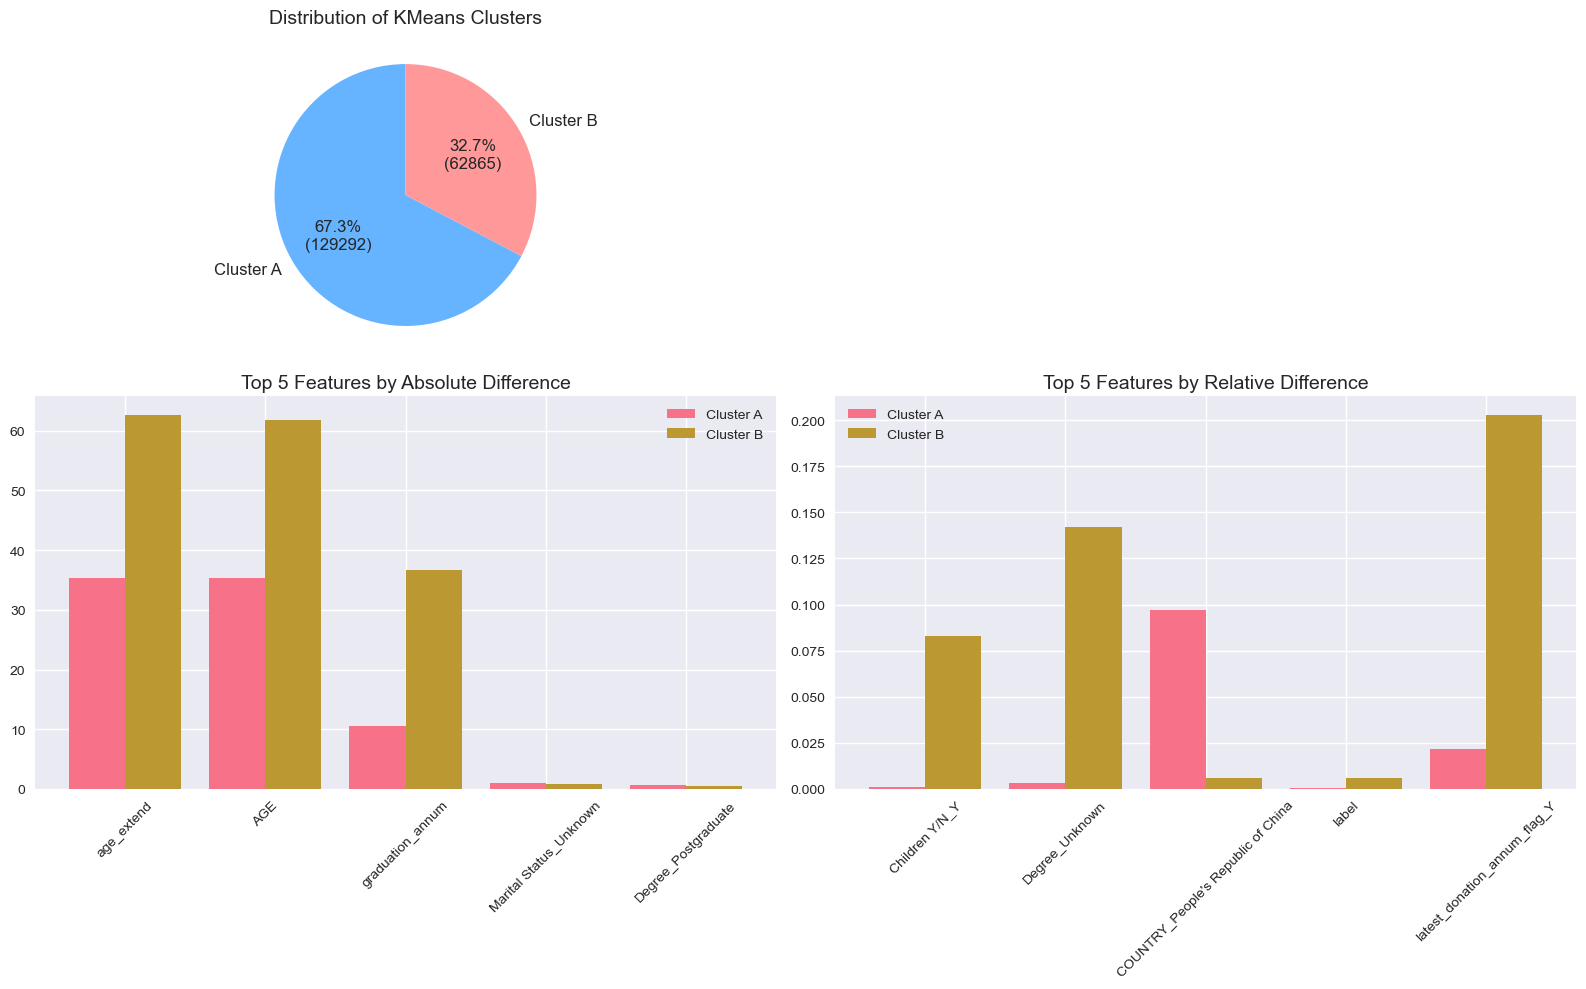

In [ ]:
# Prepare cluster labels
cluster_counts = pd.Series(kmeans_labels_2, name="Cluster").value_counts().sort_index()
labels = ['Cluster A', 'Cluster B']
sizes = cluster_counts.values
total = sizes.sum()

# Format for pie chart labels
def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

# Extract top features' values for both clusters
abs_vals_A = cluster_profiles.loc[0, top_abs_features.index]
abs_vals_B = cluster_profiles.loc[1, top_abs_features.index]
rel_vals_A = cluster_profiles.loc[0, top_rel_features.index]
rel_vals_B = cluster_profiles.loc[1, top_rel_features.index]

# Set up the figure with GridSpec
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])

# === Pie chart (0, 0) ===
ax0 = fig.add_subplot(gs[0, 0])
colors = ['#66b3ff', '#ff9999']
wedges, texts, autotexts = ax0.pie(
    sizes,
    labels=labels,
    autopct=autopct_format,
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12}
)
ax0.set_title("Distribution of KMeans Clusters", fontsize=14)

# === Bar chart: Absolute Difference (1, 0) ===
ax1 = fig.add_subplot(gs[1, 0])
x_abs = range(len(top_abs_features))
ax1.bar(x_abs, abs_vals_A, width=0.4, label='Cluster A', align='center')
ax1.bar([x + 0.4 for x in x_abs], abs_vals_B, width=0.4, label='Cluster B', align='center')
ax1.set_xticks([x + 0.2 for x in x_abs])
ax1.set_xticklabels(top_abs_features.index, rotation=45)
ax1.set_title("Top 5 Features by Absolute Difference", fontsize=14)
ax1.legend()

# === Bar chart: Relative Difference (1, 1) ===
ax2 = fig.add_subplot(gs[1, 1])
x_rel = range(len(top_rel_features))
ax2.bar(x_rel, rel_vals_A, width=0.4, label='Cluster A', align='center')
ax2.bar([x + 0.4 for x in x_rel], rel_vals_B, width=0.4, label='Cluster B', align='center')
ax2.set_xticks([x + 0.2 for x in x_rel])
ax2.set_xticklabels(top_rel_features.index, rotation=45)
ax2.set_title("Top 5 Features by Relative Difference", fontsize=14)
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## 2.4 Predictive Models for Potential Donrs

### 2.4.0 Helper functions for 2.4 and 2.5

In [189]:
"""
    use it in 2.4.1 and 2.5.1 for generate processors for Logistic Regression and Tree models
    before training baseline models.
"""

def pick_preprocessor(estimator):
    # LR & Bagging(Logistic) → k-1 dummies; others (trees/boosting) → full OHE
    if isinstance(estimator, LogisticRegression):
        return preprocessor_lr
    if isinstance(estimator, BaggingClassifier) and isinstance(estimator.estimator, LogisticRegression):
        return preprocessor_lr
    return preprocessor_tree




"""
    use fit_stack_and_evaluate (the 2nd helper function in this module)
    for Part B Stacking model in 2.4.2 & 2.4.3 & 2.5.2 & 2.5.3
"""
# --- helper: get positive-class scores for ROC/AUC ---
def _probability_scores(model: BaseEstimator, X: np.ndarray) -> np.ndarray:
    """Return positive-class scores. Prefer predict_proba; fallback to decision_function normalized to [0,1]."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s_min, s_max = np.min(s), np.max(s)
        if s_max == s_min:
            return np.full_like(s, 0.5, dtype=float)
        return (s - s_min) / (s_max - s_min)
    # Worst case: use predictions as 0/1 “probabilities”
    return model.predict(X).astype(float)

def fit_stack_and_evaluate(
    best_models: Dict[str, BaseEstimator],
    X_train,
    y_train,
    X_test,
    y_test,
    results_df: Optional[pd.DataFrame] = None,
    base_order: Optional[List[str]] = None,
    final_estimator: Optional[BaseEstimator] = None,
    cv: int = 5,
    passthrough: bool = False,
    pos_label: int = 1,
    threshold: float = 0.5,             # adjustable threshold (e.g., 0.3 for 2.5.3 Part B )
    plot_roc: bool = True,
    figure_size: Tuple[int, int] = (8, 6),
):
    """
    Train a stacking classifier on top of fine-tuned base models and evaluate with a configurable threshold.

    Notes
    -----
    - `threshold` applies to converting probabilities to class labels for all models and stacking.
    - ROC/AUC are computed from probabilities, unaffected by `threshold`.
    """
    # 1) Base learners order (default to LR, RF, GB/GBDT, XGB if available)
    if base_order is None:
        candidate_names = [
            "Logistic Regression (L1)",
            "Random Forest",
            "Gradient Boosting",   # your current key
            "GBDT",                # alt key some codebases use
            "XGBoost"
        ]
        base_order = [n for n in candidate_names if n in best_models] or list(best_models.keys())

    base_learners = [(key, best_models[key]) for key in base_order]

    # 2) Stacking model
    if final_estimator is None:
        final_estimator = LogisticRegression(max_iter=1000, random_state=42)

    stack_model = StackingClassifier(
        estimators=base_learners,
        final_estimator=final_estimator,
        passthrough=passthrough,
        n_jobs=-1,
        cv=cv
    )

    # 3) Fit
    stack_model.fit(X_train, y_train)

    # 4) Evaluate (per-model table with threshold)
    summary_rows = []

    # fine-tuned base models
    for name, model in best_models.items():
        y_proba = _probability_scores(model, X_test)
        y_pred = (y_proba >= threshold).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
        rec = recall_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
        f1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)

        summary_rows.append({
            "model": name,
            "accuracy": acc,
            "precision_1": prec,
            "recall_1": rec,
            "f1_1": f1,
            "auc": auc
        })

    # Stacking model
    y_proba_stack = _probability_scores(stack_model, X_test)
    y_pred_stack  = (y_proba_stack >= threshold).astype(int)

    summary_rows.append({
        "model": "Stacking (LR meta)",
        "accuracy": accuracy_score(y_test, y_pred_stack),
        "precision_1": precision_score(y_test, y_pred_stack, pos_label=pos_label, zero_division=0),
        "recall_1": recall_score(y_test, y_pred_stack, pos_label=pos_label, zero_division=0),
        "f1_1": f1_score(y_test, y_pred_stack, pos_label=pos_label, zero_division=0),
        "auc": roc_auc_score(y_test, y_proba_stack)
    })

    # Pretty print table
    df_summary = pd.DataFrame(summary_rows)
    display_df = df_summary.copy()
    for c in ["accuracy","precision_1","recall_1","f1_1","auc"]:
        display_df[c] = display_df[c].round(4)

    print(f"\n=== Tuned Model Results + Stacking (Threshold={threshold}) ===")
    print(display_df)

    # Optional: full classification report for the stacking model (at chosen threshold)
    print("\n=== Stacking Model Classification Report ===")
    print(classification_report(y_test, y_pred_stack, digits=4))

    # 5) Append stacking row into your running results table (optional)
    if results_df is not None:
        results_df = pd.concat([results_df, df_summary[df_summary["model"]=="Stacking (LR meta)"]], ignore_index=True)

    # 6) ROC curves (probability-based; unaffected by threshold)
    fig = None
    if plot_roc:
        fig = plt.figure(figsize=figure_size)
        for name, model in best_models.items():
            y_proba = _probability_scores(model, X_test)
            fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=pos_label)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.4f})")

        fpr, tpr, _ = roc_curve(y_test, y_proba_stack, pos_label=pos_label)
        plt.plot(fpr, tpr, label=f"Stacking (AUC={roc_auc_score(y_test, y_proba_stack):.4f})",
                 linewidth=2, color='black')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        # plt.title("ROC Curve - Fine-tuned Models + Stacking")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return stack_model, df_summary, results_df, fig



"""
    use it in 2.4.4 and 2.5.4 for generating and ploting feature importance of
    the selected optimal model
"""
def show_feature_importance(model_name="XGBoost", top_n=10, save_path=None):

    # A. Generating values
    # 1) Retrieve pipeline and model
    clf = trained_models[model_name]
    xgb_model = clf.named_steps['classifier']

    # 2) feature names after one-hot encoding
    ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_features, cat_feature_names])

    # 3) Extract feature importance
    fi = xgb_model.feature_importances_
    assert len(fi) == len(all_feature_names), \
        f"Length mismatch: importances={len(fi)} vs features={len(all_feature_names)}"

    # 4) Sort the feature importance values in a descending order
    fi_df = (
        pd.DataFrame({'feature': all_feature_names, 'importance': fi})
        .sort_values(by='importance', ascending=False)
    )

    print(f"\n=== Top {top_n} XGBoost Feature Importances (Random Search) ===")
    print(fi_df.head(top_n))

    # B. Visualisation
    # 1) get top N values
    top_df = fi_df.head(top_n).sort_values('importance', ascending=False)

    # 2) Plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=top_df,
        x='importance',
        y='feature',
        color='teal'
    )

    # 3) Add on data labels
    max_val = top_df['importance'].max()
    for i, (value, feature) in enumerate(zip(top_df['importance'], top_df['feature'])):
        ax.text(value + max_val * 0.02, i, f"{value:.3f}",
                ha='left', va='center', color='black')

    # boudnary control
    plt.xlim(0, max_val * 1.2)

    # plt.title(f'{model_name} Feature Importances (Top {top_n}) — Random Search')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

### 2.4.1 Baseline Model


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8889    0.8828    0.8858       145
           1     0.8229    0.8316    0.8272        95

    accuracy                         0.8625       240
   macro avg     0.8559    0.8572    0.8565       240
weighted avg     0.8628    0.8625    0.8626       240

AUC Score: 0.915499

=== Logistic Regression (L1) ===
              precision    recall  f1-score   support

           0     0.8881    0.8759    0.8819       145
           1     0.8144    0.8316    0.8229        95

    accuracy                         0.8583       240
   macro avg     0.8513    0.8537    0.8524       240
weighted avg     0.8589    0.8583    0.8586       240

AUC Score: 0.914846

=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.8519    0.7931    0.8214       145
           1     0.7143    0.7895    0.7500        95

    accuracy                         0.7917       240
  

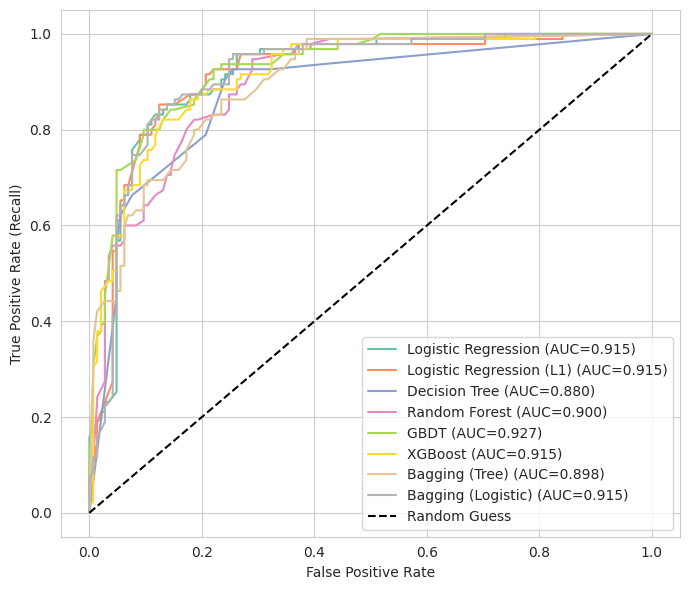

In [192]:
# 1) Data preparation
df = merged_pipeline_2.copy()
df = df[df['is_pipeline'] == 'Y'].copy()

drop_cols = [
    'ID_NUMBER'
    ,'STOP_DATE',
    'stage_proposals', 'graduation_annum'
    , 'age_extend', 'AGE', 'is_pipeline', 'label',
    'proposal_annum','proposals_count','PROPOSAL_TYPE_ECHO','PROPOSAL_STATUS_ECHO',
    'STAGE_ECHO','SUBMIT_ECHO'
]

# 2) Contruct features and labels
X = df.drop(columns=drop_cols)
y = df['label'].astype(int)

# 3) Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# 4) Devide features w.r.t dtype
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# 5) Process pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# categorical_transformer for logistic regression models
categorical_transformer_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# categorical_transformer for tree models
categorical_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 6) ColumnTransformers for Logistic Regression and Tree models respectively.
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_lr, categorical_features)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_tree, categorical_features)
    ]
)

n_estimators = 25
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5,random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=n_estimators, random_state=42),
    "GBDT": GradientBoostingClassifier(n_estimators=n_estimators, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss',n_estimators=n_estimators, random_state=42),
    "Bagging (Tree)": BaggingClassifier(estimator=DecisionTreeClassifier()
                                        ,n_estimators=n_estimators
                                        ,random_state=42
                                      )
    ,"Bagging (Logistic)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000)
                                        ,n_estimators=n_estimators
                                        ,random_state=42
                                      )
}

# 7) Model training and evaluation
trained_models = {}
results_summary = []
roc_curves = {}

for name, model in models.items():
    preproc = pick_preprocessor(model)
    clf = Pipeline(steps=[('preprocessor', preproc), ('classifier', model)])
    clf.fit(X_train, y_train)
    trained_models[name] = clf

    # predictions
    y_pred = clf.predict(X_test)

    # prefer predict_proba; fall back to decision_function if available
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        # scale decision scores to [0,1] via min-max for ROC-AUC comparability
        scores = clf.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None

    # metrics (robust to edge cases)
    acc  = float((y_pred == y_test).mean())
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1  = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc   = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.6f}")

    # summary row
    results_summary.append({
        'model': name,
        'accuracy': acc,
        'precision_1': prec1,
        'recall_1': rec1,
        'f1_1': f1_1,
        'auc': auc
    })

    # store ROC points
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr, auc)

# 8) Print evaluation report
results_df = pd.DataFrame(results_summary)

results_display = results_df.copy()
for col in ['accuracy', 'precision_1', 'recall_1', 'f1_1', 'auc']:
    results_display[col] = results_display[col].apply(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "-")

print("\n=== Evaluation between models (Detailed %) ===")
print(results_display[['model', 'accuracy', 'precision_1', 'recall_1', 'f1_1', 'auc']])

# 9) ROC curves
plt.figure(figsize=(7, 6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
# plt.title("ROC Curves for Different Models (Baseline)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.4.2 Fine tune models with GridSearchCV

#### Part A Best Models from Grid Search

In [193]:
'''
Fine-tune with GridSearchCV
'''

# Split the data in the same way as it is in 2.1.1 Baseline models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# Hyperparameters space
param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__max_depth": [None, 2, 3, 5, 8, 10],
        "classifier__min_samples_split": [2, 3, 5],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ['sqrt', 'log2'],
        "classifier__bootstrap": [True, False]
    },
    "GBDT": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0]
    },
    "Logistic Regression (L1)": {
        "classifier__C": [0.01, 0.05, 0.1, 1, 10],
        "classifier__penalty": ['l1'],
        "classifier__solver": ['liblinear'],
        "classifier__max_iter": [1000]
    }
}

# Define models
model_defs = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Logistic Regression (L1)": LogisticRegression()
}

# to save the results
best_models = {}
results_summary = []

for name in model_defs:
    print(f"\n🔍 Tuning {name}...")

    # use the same pick_preprocessor in 2.4.1
    preproc = pick_preprocessor(model_defs[name])

    pipe = Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', model_defs[name])
    ])

    #Grid Search
    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    # prediction
    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None

    # evaluation
    acc = float((y_pred == y_test).mean())
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Best Params for {name}: {grid.best_params_}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.4f}")

    results_summary.append({
        "model": name,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f1_1,
        "auc": auc
    })

# print output
results_df = pd.DataFrame(results_summary)
print("\n=== Tuned Model Results ===")
print(results_df)



🔍 Tuning Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Params for Random Forest: {'classifier__bootstrap': False, 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 30}
              precision    recall  f1-score   support

           0     0.8609    0.8966    0.8784       145
           1     0.8315    0.7789    0.8043        95

    accuracy                         0.8500       240
   macro avg     0.8462    0.8377    0.8414       240
weighted avg     0.8493    0.8500    0.8491       240

AUC Score: 0.9236

🔍 Tuning GBDT...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Params for GBDT: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 2, 'classifier__n_estimators': 25, 'classifier__subsample': 0.6}
              precision    recall  f1-score   support

           0     0.8395    0.9379    0.8860       

#### Part B Stacking Best Models and Evaluation


=== Tuned Model Results + Stacking (Threshold=0.5) ===
                      model  accuracy  precision_1  recall_1    f1_1     auc
0             Random Forest    0.8500       0.8315    0.7789  0.8043  0.9236
1                      GBDT    0.8542       0.8846    0.7263  0.7977  0.9244
2                   XGBoost    0.8500       0.8554    0.7474  0.7978  0.9261
3  Logistic Regression (L1)    0.8583       0.8144    0.8316  0.8229  0.9148
4        Stacking (LR meta)    0.8500       0.8242    0.7895  0.8065  0.9278

=== Stacking Model Classification Report ===
              precision    recall  f1-score   support

           0     0.8658    0.8897    0.8776       145
           1     0.8242    0.7895    0.8065        95

    accuracy                         0.8500       240
   macro avg     0.8450    0.8396    0.8420       240
weighted avg     0.8493    0.8500    0.8494       240



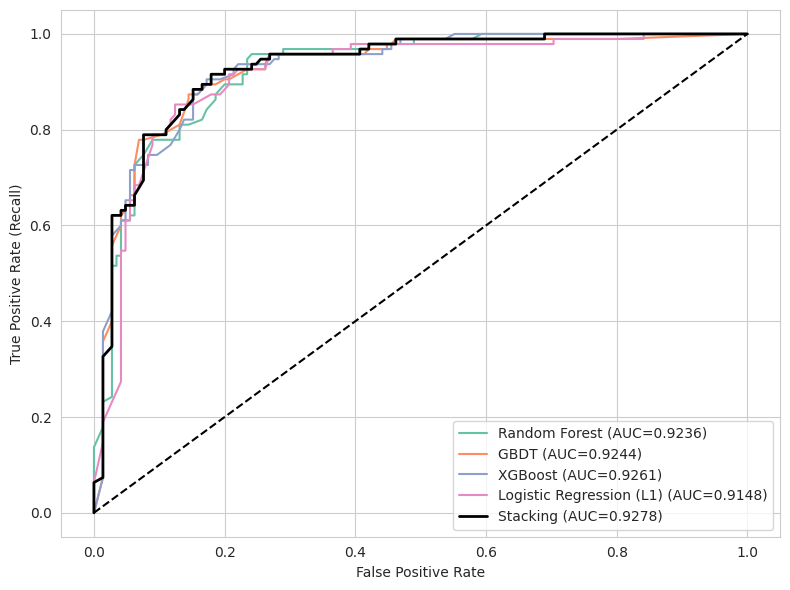

In [194]:
stack_model, df_summary, results_df, fig = fit_stack_and_evaluate(
    best_models=best_models,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    results_df=results_df,
    base_order=["Logistic Regression (L1)", "Random Forest", "GBDT", "XGBoost"],
    cv=5,
    passthrough=False,
    pos_label=1,
    threshold=0.5,                  # for potential donors, use 0.5
    plot_roc=True
)

### 2.4.3 Fine-tune with RandomizedSearchCV

#### Part A Best Models from Grid Search

In [195]:
'''
Fine-tune with RandomizedSearchCV
'''

# split the data in the same way as it is in 2.1.1 Baseline models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# hyperparameters space
param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__max_depth": [None, 2, 3, 5, 8, 10],
        "classifier__min_samples_split": [2, 3, 5],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ['sqrt', 'log2'],
        "classifier__bootstrap": [True, False]
    },
    "GBDT": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3],
        "classifier__subsample": [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0]
    },
    "Logistic Regression (L1)": {
        "classifier__C": [0.01, 0.05, 0.1, 1, 10],
        "classifier__penalty": ['l1'],
        "classifier__solver": ['liblinear'],
        "classifier__max_iter": [1000]
    }
}

# define the models
model_defs = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression (L1)": LogisticRegression()
}

# to save the results
best_models = {}
results_summary = []

for name, model in model_defs.items():
    print(f"\n🔍 Tuning {name}...")

    # use the same pick_preprocessor in 2.1.1
    preproc = pick_preprocessor(model)

    pipe = Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', model)
    ])

    # Random Search
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        scoring='roc_auc',
        n_iter=30,
        cv=5,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None

    acc = float((y_pred == y_test).mean())
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Best Params for {name}: {random_search.best_params_}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.4f}")

    results_summary.append({
        "model": name,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f1_1,
        "auc": auc
    })

# Print output
results_df = pd.DataFrame(results_summary)
print("\n=== Tuned Model Results ===")
print(results_df)



🔍 Tuning Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params for Random Forest: {'classifier__n_estimators': 25, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 3, 'classifier__bootstrap': False}
              precision    recall  f1-score   support

           0     0.8944    0.8759    0.8850       145
           1     0.8163    0.8421    0.8290        95

    accuracy                         0.8625       240
   macro avg     0.8553    0.8590    0.8570       240
weighted avg     0.8635    0.8625    0.8629       240

AUC Score: 0.9294

🔍 Tuning GBDT...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params for GBDT: {'classifier__subsample': 0.6, 'classifier__n_estimators': 20, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.1}
              precision    recall  f1-score   support

           0     0.8667    0.8966    0.8814       145

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[19:10:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 5 is smaller than n_iter=30. Running 5 iterations. For exhaustive searches, use GridSearchCV.



Best Params for XGBoost: {'classifier__subsample': 0.6, 'classifier__n_estimators': 30, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.02, 'classifier__colsample_bytree': 0.6}
              precision    recall  f1-score   support

           0     0.7977    0.9517    0.8679       145
           1     0.8955    0.6316    0.7407        95

    accuracy                         0.8250       240
   macro avg     0.8466    0.7917    0.8043       240
weighted avg     0.8364    0.8250    0.8176       240

AUC Score: 0.9319

🔍 Tuning Logistic Regression (L1)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params for Logistic Regression (L1): {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 1000, 'classifier__C': 1}
              precision    recall  f1-score   support

           0     0.8881    0.8759    0.8819       145
           1     0.8144    0.8316    0.8229        95

    accuracy                         0.8583     

#### Part B Stacking Best Models and Evaluation


=== Tuned Model Results + Stacking (Threshold=0.5) ===
                      model  accuracy  precision_1  recall_1    f1_1     auc
0             Random Forest    0.8625       0.8163    0.8421  0.8290  0.9294
1                      GBDT    0.8542       0.8333    0.7895  0.8108  0.9242
2                   XGBoost    0.8250       0.8955    0.6316  0.7407  0.9319
3  Logistic Regression (L1)    0.8583       0.8144    0.8316  0.8229  0.9148
4        Stacking (LR meta)    0.8583       0.8211    0.8211  0.8211  0.9268

=== Stacking Model Classification Report ===
              precision    recall  f1-score   support

           0     0.8828    0.8828    0.8828       145
           1     0.8211    0.8211    0.8211        95

    accuracy                         0.8583       240
   macro avg     0.8519    0.8519    0.8519       240
weighted avg     0.8583    0.8583    0.8583       240



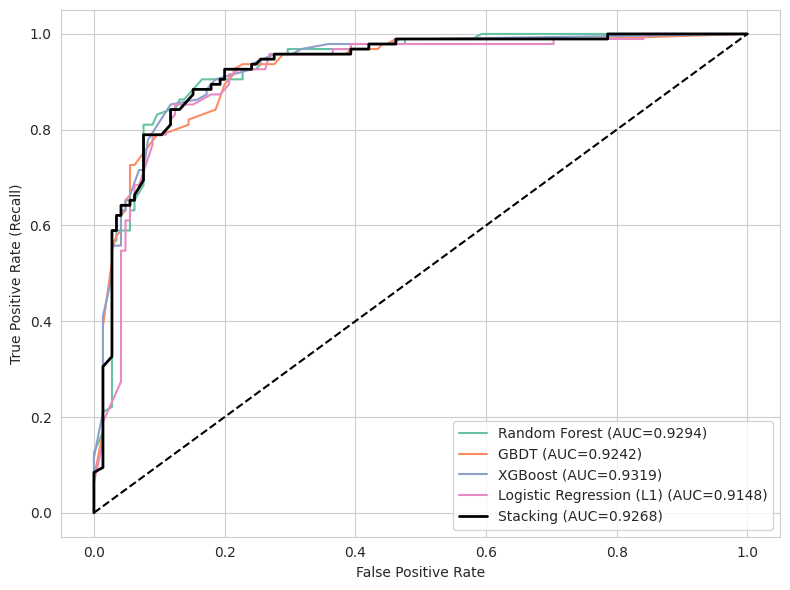

In [196]:
stack_model, df_summary, results_df, fig = fit_stack_and_evaluate(
    best_models=best_models,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    results_df=results_df,
    base_order=["Logistic Regression (L1)", "Random Forest", "GBDT", "XGBoost"],
    cv=5,
    passthrough=False,
    pos_label=1,
    threshold=0.5,                  # for potential donors, use 0.5
    plot_roc=True
)


### 2.4.4 Feature Importance of The Optimal Mode


=== Top 10 XGBoost Feature Importances (Random Search) ===
                        feature  importance
2                     age_group    0.135477
13                  in_circle_Y    0.121825
1                 enquire_annum    0.118340
12                  in_circle_N    0.088755
6          stage_enquirer_False    0.085087
7           stage_enquirer_True    0.074894
11            stage_pledge_True    0.050035
4   COUNTRY_CODE_United Kingdom    0.028480
0                enquirer_count    0.023068
3            COUNTRY_CODE_Other    0.021091


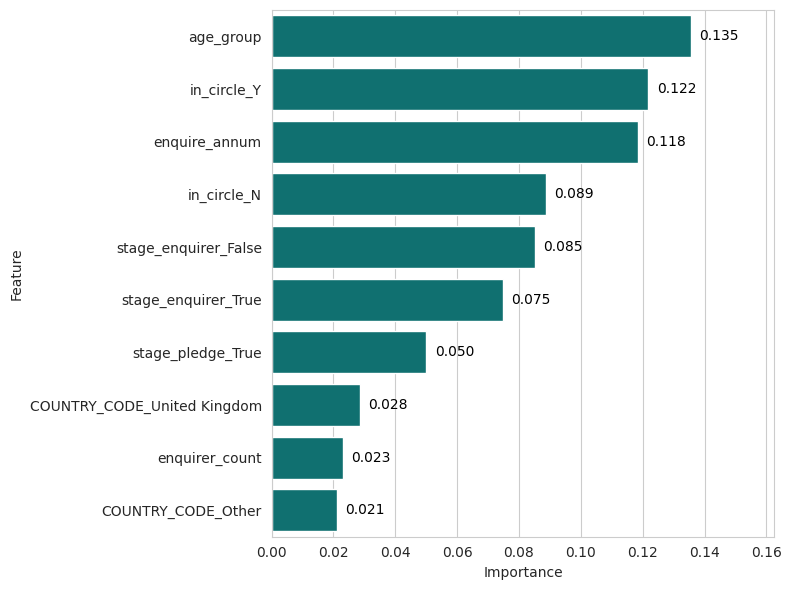

In [197]:
# refer this module in 2.4.0
show_feature_importance(model_name="Random Forest"
                        , top_n=10
                        , save_path="rf_feature_importance_random_search.png")

### 2.4.5 Shortlist for Potential Donors

In [ ]:

# 1) Feature preparation
X_all = df.drop(columns=drop_cols)

# 2) Retrieve the Random Forest pipeline
rf_best_pipe = best_models['Random Forest']  # 如果你想用 baseline，可换成 trained_models["Random Forest"]

# 3) Predict prbability & label with threshold of 0.5
y_proba_all = rf_best_pipe.predict_proba(X_all)[:, 1]
y_pred_all = (y_proba_all >= 0.5).astype(int)

# 4) Add on the predicted results on the df.
df['rf_pred_proba'] = y_proba_all
df['rf_pred_label'] = y_pred_all

# Optional: check the result
# print(df.head())

# Save the df to csv.
df.to_csv('df_proposal_predictions.csv', index=False)


## 2.5 Predictive Models for Potential Participants

### 2.5.1 Baseline Model


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9988    0.9754    0.9870     19171
           1     0.0465    0.5111    0.0852        45

    accuracy                         0.9743     19216
   macro avg     0.5226    0.7432    0.5361     19216
weighted avg     0.9966    0.9743    0.9849     19216

AUC Score: 0.963207

=== Logistic Regression (L1) ===
              precision    recall  f1-score   support

           0     0.9988    0.9750    0.9868     19171
           1     0.0458    0.5111    0.0841        45

    accuracy                         0.9739     19216
   macro avg     0.5223    0.7431    0.5354     19216
weighted avg     0.9966    0.9739    0.9847     19216

AUC Score: 0.963758

=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.9988    0.9737    0.9861     19171
           1     0.0417    0.4889    0.0769        45

    accuracy                         0.9725     19216
  

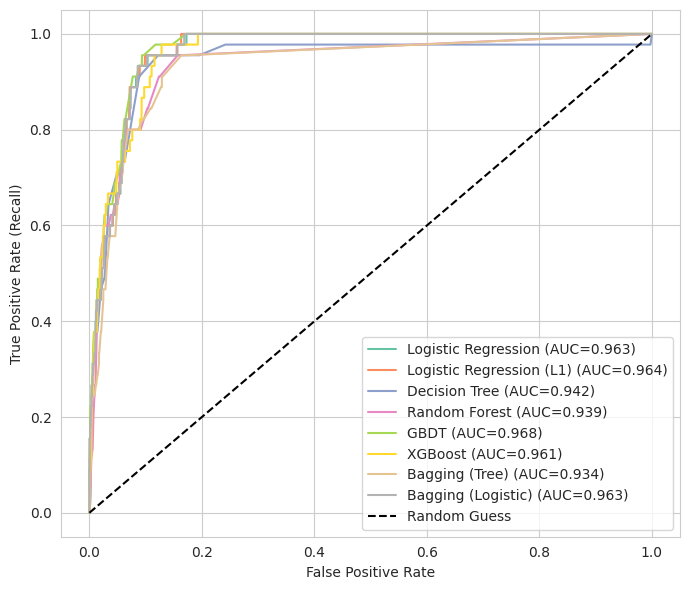

In [199]:

# 1) Data preparation
df = active_alumni_merge.copy()
drop_cols = [
    'Advance ID', 'AGE', 'label'
]

# 2. Contruct features and labels
X = df.drop(columns=drop_cols)
y = df['label'].astype(int)

# 3) Test set split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# 4) Downsample the split trainvla dataset
trainval = X_trainval.copy()
trainval['label'] = y_trainval
positive = trainval[trainval['label'] == 1]
negative = trainval[trainval['label'] == 0]

negative_sample = negative.sample(n=min(len(negative), len(positive)*10), random_state=42)
balanced = pd.concat([positive, negative_sample])

features = X.columns.tolist()
X_balanced = balanced[features]
y_balanced = balanced['label']

# 5) Process pipeline
numeric_features = X_balanced.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_balanced.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
# categorical_transformer for logistic regression models
categorical_transformer_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# categorical_transformer for tree models
categorical_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 5) ColumnTransformers for Logistic Regression and Tree models respectively
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_lr, categorical_features)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_tree, categorical_features)
    ]
)

# 6) Define models
n_estimators = 25
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=n_estimators, random_state=42),
    "GBDT": GradientBoostingClassifier(n_estimators=n_estimators, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=n_estimators, random_state=42),
    "Bagging (Tree)": BaggingClassifier(estimator=DecisionTreeClassifier(),
                                        n_estimators=n_estimators, random_state=42),
    "Bagging (Logistic)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000),
                                            n_estimators=n_estimators, random_state=42)
}

# 7) Model training and evaluation
trained_models = {}
results_summary = []
roc_curves = {}

for name, model in models.items():
    preproc = pick_preprocessor(model)
    clf = Pipeline(steps=[('preprocessor', preproc), ('classifier', model)])
    clf.fit(X_balanced, y_balanced)
    trained_models[name] = clf

    # predictions
    y_pred = clf.predict(X_test)

    # prefer predict_proba; fall back to decision_function if available
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        # scale decision scores to [0,1] via min-max for ROC-AUC comparability
        scores = clf.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None

    # metrics (robust to edge cases)
    acc  = float((y_pred == y_test).mean())
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1  = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc   = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.6f}")

    # summary row
    results_summary.append({
        'model': name,
        'accuracy': acc,
        'precision_1': prec1,
        'recall_1': rec1,
        'f1_1': f1_1,
        'auc': auc
    })

    # store ROC points
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr, auc)

# 8) Print evaluation report
results_df = pd.DataFrame(results_summary)

results_display = results_df.copy()
for col in ['accuracy', 'precision_1', 'recall_1', 'f1_1', 'auc']:
    results_display[col] = results_display[col].apply(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "-")

print("\n=== Evaluation between models (Detailed %) ===")
print(results_display[['model', 'accuracy', 'precision_1', 'recall_1', 'f1_1', 'auc']])

# 9) ROC curves
plt.figure(figsize=(7, 6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
# plt.title("ROC Curves for Baseline Models (on Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Threshold Selection

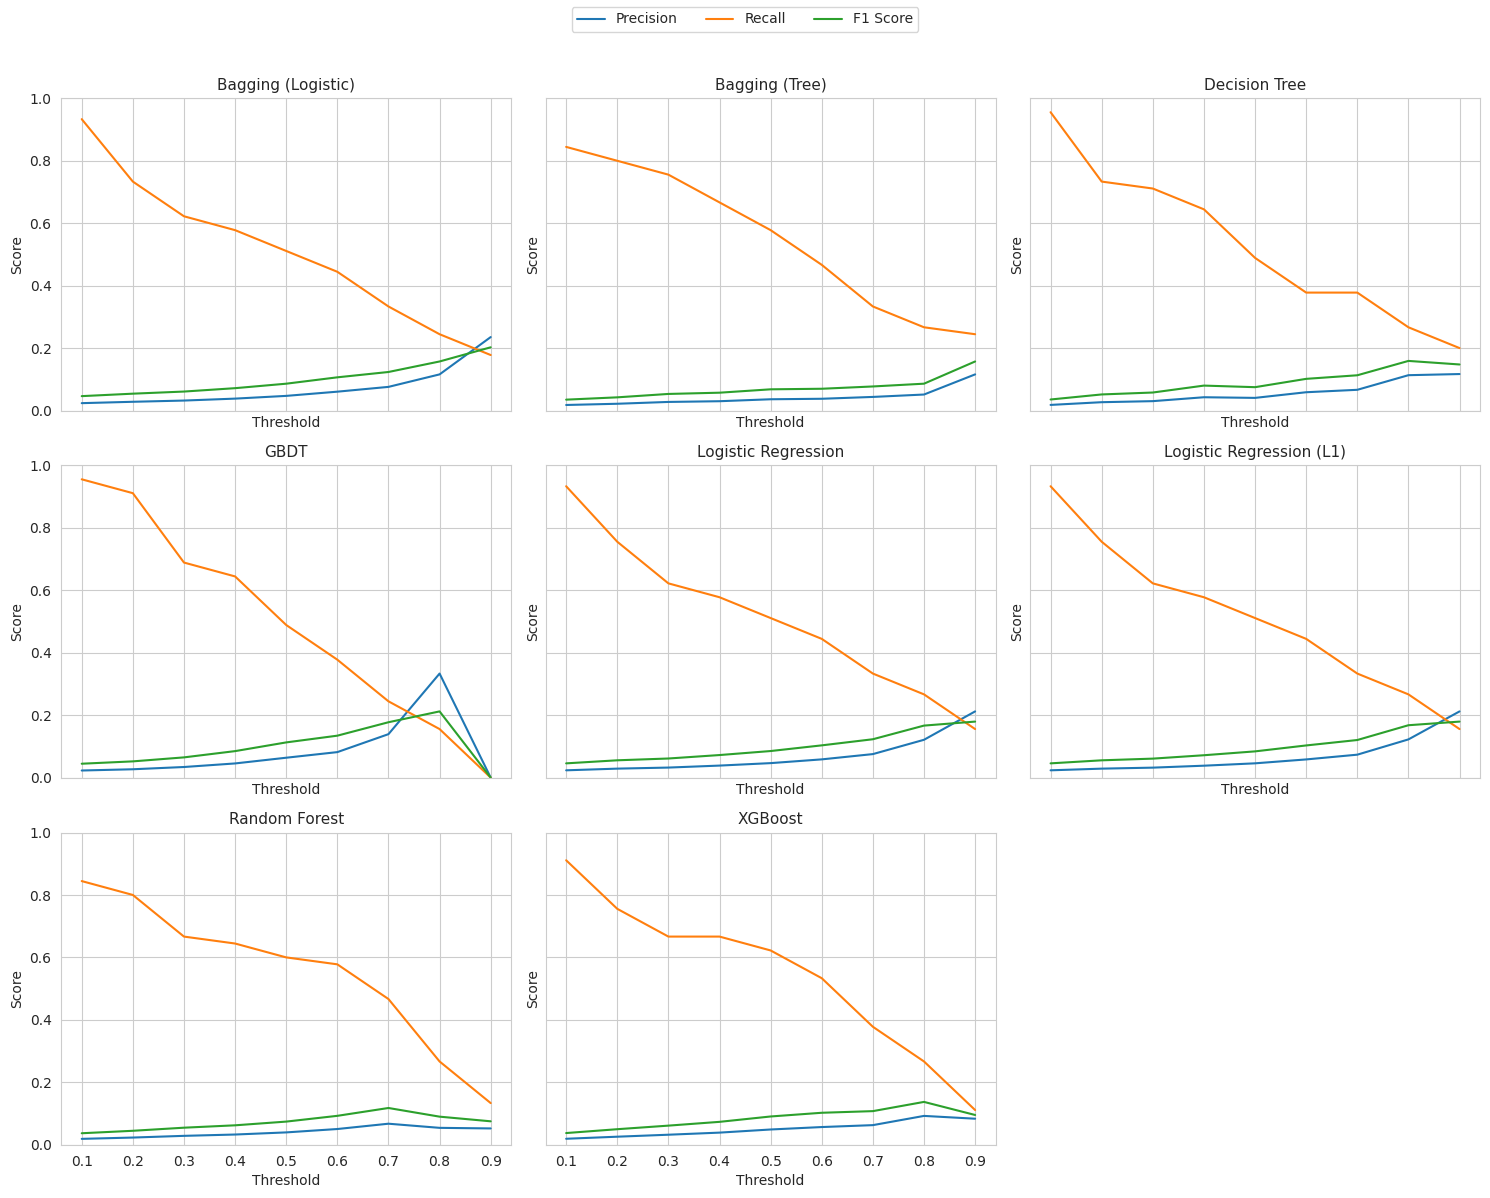

In [200]:
# Calculate precision, recall, and f1 w.r.t different threshold values
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_results = []

for name, model in trained_models.items():
    # predict probability
    y_proba = model.predict_proba(X_test)[:, 1]

    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        precision = precision_score(y_test.astype(int), y_pred_thresh, zero_division=0)
        recall = recall_score(y_test.astype(int), y_pred_thresh, zero_division=0)
        f1 = f1_score(y_test.astype(int), y_pred_thresh, zero_division=0)

        threshold_results.append({
            'model': name,
            'threshold': round(thresh, 2),
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

threshold_df = pd.DataFrame(threshold_results)
threshold_df = threshold_df.sort_values(['model', 'threshold']).reset_index(drop=True)

# Plot
models_to_plot = threshold_df['model'].unique()
num_models = len(models_to_plot)

n_cols = 3
n_rows = math.ceil(num_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

colors = {
    'precision': 'tab:blue',
    'recall': 'tab:orange',
    'f1': 'tab:green'
}

# Subplot
for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx]
    df_plot = threshold_df[threshold_df['model'] == model_name]

    ax.plot(df_plot['threshold'], df_plot['precision'], label='Precision', color=colors['precision'])
    ax.plot(df_plot['threshold'], df_plot['recall'], label='Recall', color=colors['recall'])
    ax.plot(df_plot['threshold'], df_plot['f1'], label='F1 Score', color=colors['f1'])

    ax.set_title(model_name, fontsize=11)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.grid(True)

# Delete extra subplot
for j in range(len(models_to_plot), len(axes)):
    fig.delaxes(axes[j])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)
# plt.suptitle("Model Metrics vs Threshold", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 2.5.2 Fine-tune with GridSearchCV

#### Part A Best Models from Grid Search

In [201]:
'''
Fine-tune with GridSearchCV
'''

# Split the {trainval set} in 2.5.1 into train and test set!
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.5, stratify=y_balanced, random_state=42
)

# Hyperparameters space
param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__max_depth": [None, 2, 3, 5, 8, 10],
        "classifier__min_samples_split": [2, 3, 5],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ['sqrt', 'log2'],
        "classifier__bootstrap": [True, False]
    },
    "GBDT": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0]
    },
    "Logistic Regression (L1)": {
        "classifier__C": [0.01, 0.05, 0.1, 1, 10],
        "classifier__penalty": ['l1'],
        "classifier__solver": ['liblinear'],
        "classifier__max_iter": [1000]
    }
}

# Define models
model_defs = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression (L1)": LogisticRegression()
}

# to save the results
best_models = {}
results_summary = []

for name, model in model_defs.items():
    print(f"\n🔍 Tuning {name}...")

    # use the same pick_preprocessor in 2.5.1
    preproc = pick_preprocessor(model)

    pipe = Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', model)
    ])

    #Grid Search
    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model


    # prediction
    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None


    # evaluation
    acc = (y_pred == y_test).mean()
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Best Params for {name}: {grid.best_params_}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.4f}")

    results_summary.append({
        "model": name,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f1_1,
        "auc": auc
    })

# Print output
results_df = pd.DataFrame(results_summary)
print("\n=== Tuned Model Results ===")
print(results_df)



🔍 Tuning Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Params for Random Forest: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
              precision    recall  f1-score   support

           0     0.9988    0.9762    0.9874     19171
           1     0.0480    0.5111    0.0878        45

    accuracy                         0.9751     19216
   macro avg     0.5234    0.7437    0.5376     19216
weighted avg     0.9966    0.9751    0.9853     19216

AUC Score: 0.9647

🔍 Tuning GBDT...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Params for GBDT: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 30, 'classifier__subsample': 0.8}
              precision    recall  f1-score   support

           0     0.9989    0.9764    0.9875     19171
           1     0.0504    0.5333    0.0921        45

    accuracy                     

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[19:20:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Best Params for XGBoost: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 30, 'classifier__subsample': 0.6}
              precision    recall  f1-score   support

           0     0.9990    0.9757    0.9872     19171
           1     0.0530    0.5778    0.0970        45

    accuracy                         0.9748     19216
   macro avg     0.5260    0.7768    0.5421     19216
weighted avg     0.9968    0.9748    0.9851     19216

AUC Score: 0.9686

🔍 Tuning Logistic Regression (L1)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params for Logistic Regression (L1): {'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
              precision    recall  f1-score   support

           0     0.9989    0.9702    0.9844     19171
           1     0.0419    0.5556    0.0780        45

    accuracy                         0.9692     1

#### Part B Stacking Best Models and Evaluation


=== Tuned Model Results + Stacking (Threshold=0.3) ===
                      model  accuracy  precision_1  recall_1    f1_1     auc
0             Random Forest    0.9368       0.0290    0.8000  0.0560  0.9647
1                      GBDT    0.9481       0.0333    0.7556  0.0638  0.9664
2                   XGBoost    0.9467       0.0333    0.7778  0.0639  0.9686
3  Logistic Regression (L1)    0.9485       0.0308    0.6889  0.0589  0.9642
4        Stacking (LR meta)    0.9608       0.0366    0.6222  0.0692  0.9669

=== Stacking Model Classification Report ===
              precision    recall  f1-score   support

           0     0.9991    0.9616    0.9800     19171
           1     0.0366    0.6222    0.0692        45

    accuracy                         0.9608     19216
   macro avg     0.5179    0.7919    0.5246     19216
weighted avg     0.9968    0.9608    0.9779     19216



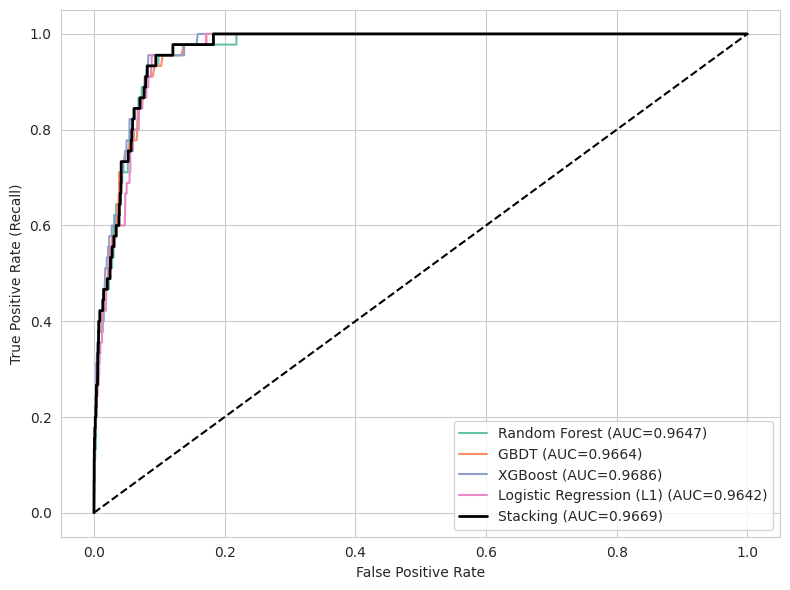

In [202]:
stack_model, df_summary, results_df, fig = fit_stack_and_evaluate(
    best_models=best_models,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    results_df=results_df,
    base_order=["Logistic Regression (L1)", "Random Forest", "GBDT", "XGBoost"],
    cv=5,
    passthrough=False,
    pos_label=1,
    threshold=0.3,                  # for potential participants, use 0.3!
    plot_roc=True
)

### 2.5.3 Fine-tune with RandomSearchCV

#### Part A Best Models from Grid Search

In [203]:
'''
Fine-tune with RandomizedSearchCV
'''

# Split the {trainval set} in 2.5.1 into train and test set!
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Hyperparameters space
param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__max_depth": [None, 2, 3, 5, 8, 10],
        "classifier__min_samples_split": [2, 3, 5],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ['sqrt', 'log2'],
        "classifier__bootstrap": [True, False]
    },
    "GBDT": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        "classifier__n_estimators": [20, 25, 30],
        "classifier__learning_rate": [0.02, 0.05, 0.1],
        "classifier__max_depth": [2, 3, 5],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0]
    },
    "Logistic Regression (L1)": {
        "classifier__C": [0.01, 0.05, 0.1, 1, 10],
        "classifier__penalty": ['l1'],
        "classifier__solver": ['liblinear'],
        "classifier__max_iter": [1000]
    }
}

# Define models
model_defs = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression (L1)": LogisticRegression()
}

# to save the results
best_models = {}
results_summary = []

for name, model in model_defs.items():
    print(f"\n🔍 Random Search for {name}...")

    # use the same pick_preprocessor in 2.5.1
    preproc = pick_preprocessor(model)

    pipe = Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', model)
    ])

    # Random search
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grids[name],
        n_iter=30,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_models[name] = best_model

    # prediction
    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        s_min, s_max = scores.min(), scores.max()
        y_proba = (scores - s_min) / (s_max - s_min + 1e-12)
    else:
        y_proba = None

    # evaluation
    acc = (y_pred == y_test).mean()
    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Best Params for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    if auc is not None:
        print(f"AUC Score: {auc:.4f}")

    results_summary.append({
        "model": name,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f1_1,
        "auc": auc
    })

# Print output
results_df = pd.DataFrame(results_summary)
print("\n=== Tuned Model Results (Random Search) ===")
print(results_df)



🔍 Random Search for Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params for Random Forest: {'classifier__n_estimators': 20, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 8, 'classifier__bootstrap': True}
              precision    recall  f1-score   support

           0     0.9989    0.9770    0.9878     19171
           1     0.0516    0.5333    0.0941        45

    accuracy                         0.9760     19216
   macro avg     0.5252    0.7552    0.5410     19216
weighted avg     0.9967    0.9760    0.9857     19216

AUC Score: 0.9643

🔍 Random Search for GBDT...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params for GBDT: {'classifier__subsample': 0.8, 'classifier__n_estimators': 30, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
              precision    recall  f1-score   support

           0     0.9987    0.977

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[19:22:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 5 is smaller than n_iter=30. Running 5 iterations. For exhaustive searches, use GridSearchCV.



Best Params for XGBoost: {'classifier__subsample': 1.0, 'classifier__n_estimators': 30, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0     0.9987    0.9796    0.9890     19171
           1     0.0487    0.4444    0.0877        45

    accuracy                         0.9784     19216
   macro avg     0.5237    0.7120    0.5384     19216
weighted avg     0.9964    0.9784    0.9869     19216

AUC Score: 0.9653

🔍 Random Search for Logistic Regression (L1)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params for Logistic Regression (L1): {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 1000, 'classifier__C': 1}
              precision    recall  f1-score   support

           0     0.9990    0.9734    0.9860     19171
           1     0.0485    0.5778    0.0895        45

    accuracy                         0

#### Part B Stacking Best Models and Evaluation


=== Tuned Model Results + Stacking (Threshold=0.3) ===
                      model  accuracy  precision_1  recall_1    f1_1     auc
0             Random Forest    0.9440       0.0301    0.7333  0.0578  0.9643
1                      GBDT    0.9514       0.0316    0.6667  0.0604  0.9668
2                   XGBoost    0.9527       0.0345    0.7111  0.0658  0.9653
3  Logistic Regression (L1)    0.9532       0.0318    0.6444  0.0605  0.9628
4        Stacking (LR meta)    0.9646       0.0378    0.5778  0.0710  0.9659

=== Stacking Model Classification Report ===
              precision    recall  f1-score   support

           0     0.9990    0.9655    0.9820     19171
           1     0.0378    0.5778    0.0710        45

    accuracy                         0.9646     19216
   macro avg     0.5184    0.7716    0.5265     19216
weighted avg     0.9967    0.9646    0.9798     19216



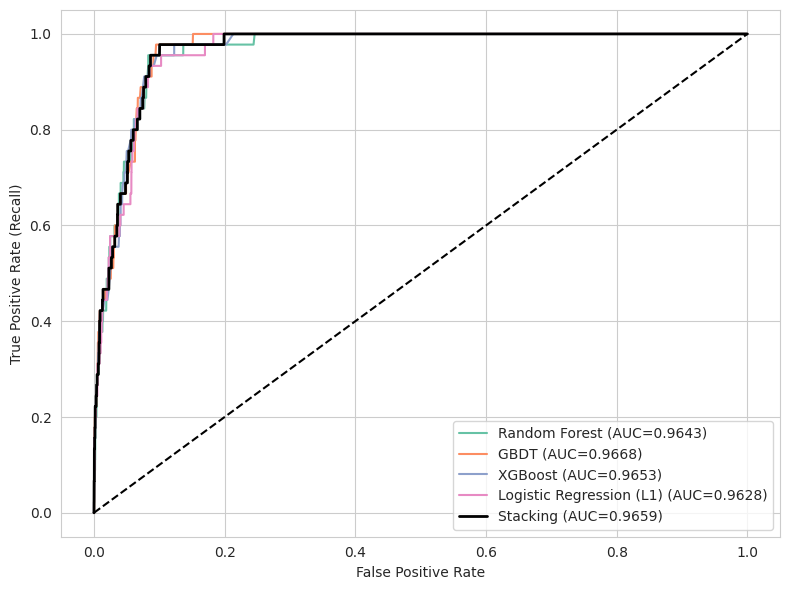

In [204]:
stack_model, df_summary, results_df, fig = fit_stack_and_evaluate(
    best_models=best_models,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    results_df=results_df,
    base_order=["Logistic Regression (L1)", "Random Forest", "GBDT", "XGBoost"],
    cv=5,
    passthrough=False,
    pos_label=1,
    threshold=0.3,                  # for potential donors, use 0.3!
    plot_roc=True
)

### 2.5.4 Feature Importance of The Optimal Mode


=== Top 10 XGBoost Feature Importances (Random Search) ===
                               feature  importance
19        latest_donation_annum_flag_N    0.788616
23           sheet_appear_count_flag_N    0.034490
11              COUNTRY_United Kingdom    0.025342
1                           age_extend    0.023376
9   COUNTRY_People's Republic of China    0.014769
18                      Degree_Unknown    0.012481
0                     graduation_annum    0.012129
10                         COUNTRY_USA    0.012085
2               Marital Status_Married    0.011295
8                        COUNTRY_Other    0.009961


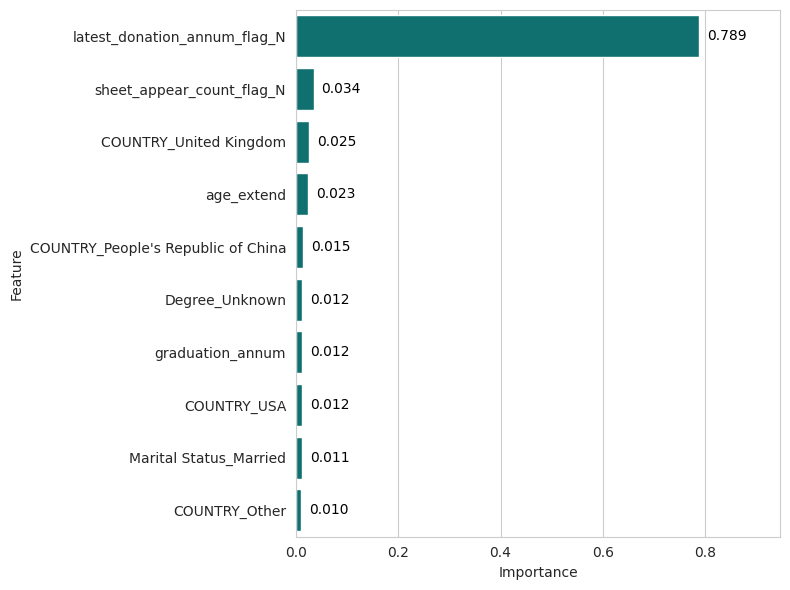

In [205]:
# refer this module in 2.4.0
show_feature_importance(model_name="XGBoost"
                        , top_n=10
                        , save_path="xgb_feature_importance_random_search.png")


### 2.5.5 Shortlist for Pipeline Engagement

In [ ]:
# ===== 用已调参的 Random Forest 生成全量预测并回填到 df =====
# 前置假设：
# - 你前面已得到 best_models['Random Forest']，它是包含 preprocessor+classifier 的 Pipeline
# - df 为你当前用于建模的数据（已做 is_pipeline=='Y' 的过滤）
# - drop_cols 与之前一致，包含 'label' 等不用于特征的列

# 1) 准备特征
X_all = df.drop(columns=drop_cols)

# 2) 取出已调参的 Random Forest 管道
rf_best_pipe = best_models['XGBoost']  # 如果你想用 baseline，可换成 trained_models["Random Forest"]

# 3) 预测概率与类别（阈值=0.5）
y_proba_all = rf_best_pipe.predict_proba(X_all)[:, 1]
y_pred_all = (y_proba_all >= 0.3).astype(int)  # 显式以 0.3 为阈值

# 4) 回填到原数据（追加两列）
df['rf_pred_proba'] = y_proba_all
df['rf_pred_label'] = y_pred_all

# （可选）检查结果
# print(df.head())

df.to_csv("df_pipeline_predictions.csv", index=False)